In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"

DATA_DIR = ROOT_DIR + "data/"
DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NEURAL_NETWORK_NAME = 'freehand_v2.1_double_input_mp_iq'

OUTPUT_FILENAME = NEURAL_NETWORK_NAME + '.dat'
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

# Imports

In [3]:
import pickle
import pandas as pd
import h5py
import cmath
import numpy as np

import keras
import keras.models as models
from keras.layers import Input, concatenate
from keras.layers.core import Reshape, Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution1D, Convolution2D, MaxPooling2D, ZeroPadding2D

from tensorflow.keras.layers import Input

import matplotlib.pyplot as plt

import sys
sys.path.append(ROOT_DIR)

import neural_networks

# Dataset

In [4]:
dataset_filename = DATASET_2016_10a_FILENAME

dataset = []

with (open(dataset_filename, "rb")) as dataset_file:
    data = dataset_file.read()
    data_dict = pickle.loads(data, encoding='bytes') # unpickle data
    keys = data_dict.keys()
    
    # for each key in dataset keys
    for key in keys:
        # extract modulation label and snr
        modulation, snr = key[0].decode("utf-8") , key[1]
        
        # for each I/Q signal couple sample
        for signal in data_dict[key]:
            # save the tuple (signal, modulation_label, snr) in the list
            tuple = (signal, modulation, snr)
            dataset.append(tuple)

## Dataset in a pandas Dataframe

In [5]:
dataset_df = pd.DataFrame(data=dataset)

# pandas aesthetics

iq_signals_column_dataframe_name = 'IQ signals'
modulation_label_column_dataframe_name = 'Modulation_Label'
snr_column_dataframe_name = 'SNR'

dataset_df.columns = [
    iq_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Discrete Fourier Transform

Each signal is transformed from an I/Q sample using Discrete Fourier Transform, and added as a column to the dataset.

In [7]:
def I_Q_to_DFT(signal):
    complex_IQ_representation = []
    
    # a signal is 
    I = signal[0]
    Q = signal[1]

    # for each <i,q> couple
    for j in range(0, len(I)):
        cmplx = complex(I[j], Q[j]) # <i,q> can be represented as a complex number (i = real part, q = complex part)
        complex_IQ_representation.append(cmplx)
    
    # numpy fft(arr) transforms an array 'arr' of complex numbers using Discrete Fourier Transform
    ffted_cplx = np.fft.fft(complex_IQ_representation)
    return [ffted_cplx.real, ffted_cplx.imag]

### Attention

This isn't a really heavy computation, but careful executing this block on devices with low computational resources, it may require a long time.

In [8]:
transformed_signals = []

for index, row in dataset_df.iterrows():
    signal = row[iq_signals_column_dataframe_name]
    transformed_signal = I_Q_to_DFT(signal)
    
    # transformed_signal is a train of values
    transformed_signals.append(transformed_signal)

In [9]:
dft_signals_column_dataframe_name = 'DFT signals'

# add Module/Phase signals to pandas Dataframe
dataset_df[dft_signals_column_dataframe_name] = transformed_signals

# (Aesthetics) Rearrange columns to show signal columns, and then other columns
df_columns = [
    iq_signals_column_dataframe_name,
    dft_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]
dataset_df = dataset_df[df_columns]

## The dataset after adding DFT Signals

In [10]:
dataset_df

,IQ signals,DFT signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...","[[-0.060862621969135944, -0.22769021567320955,...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...","[[0.07303547981427982, 0.21388404694926202, -0...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...","[[0.07157310681941453, 0.06983173884925772, -0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...","[[0.06919694535099552, 0.05751631710576523, -0...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...","[[0.16920786396804033, 0.3561287889109632, 0.3...",QPSK,2
...,...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....","[[-0.02215634343883721, 0.11752126689233586, 0...",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....","[[-0.10105456630867593, -0.10305432796774971, ...",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....","[[-0.0646182048258197, 0.0054176624689576194, ...",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...","[[-0.16591021459316835, 0.001243809761688204, ...",BPSK,-18


# Neural network

## Configuration

In [11]:
TRAINING_SET_DIMENSION = 0.7
DROPOUT_RATE = 0.5

# Set up some params 
NB_EPOCH = 100     # number of epochs to train on
BATCH_SIZE = 1024  # training batch size

## Data prepare

In [12]:
iq_signals = dataset_df[iq_signals_column_dataframe_name].tolist()
dft_signals = dataset_df[dft_signals_column_dataframe_name].tolist()
labels = dataset_df[modulation_label_column_dataframe_name].tolist()

# [QPSQ, BPSK, ...]
mods = dataset_df[modulation_label_column_dataframe_name].unique().tolist()
mods.sort()
# [-18, -16, ...]
snrs = dataset_df[snr_column_dataframe_name].unique().tolist()
snrs.sort()

### Training and Test data partitioning

In [13]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each

# seeding the random numpy object
np.random.seed(2016)

# 220.000
n_examples = len(iq_signals)

# take a portion of the dataset as training set
n_train = int(n_examples * TRAINING_SET_DIMENSION)

# extract datapoints indexes randomly
# train_index = [I_1, I_2, ..., I_N_TRAIN]
train_index = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# obtain the remaining datapoints indexes
# test_index = [I_1, I_2, ..., I_HALF_N_EXAMPLES]
test_index = list(set(range(0,n_examples)) - set(train_index))

iq_signals = np.array(iq_signals)
dft_signals = np.array(dft_signals)

iq_train = iq_signals[train_index]
iq_test =  iq_signals[test_index]

dft_train = dft_signals[train_index]
dft_test =  dft_signals[test_index]

### One-hot encoding for Training and Test labels

In [14]:
def to_onehot(x):
    input_list = list(x)
    vectors_number = len(list(input_list))
    number_of_elements_for_each_vector = max(input_list, default=0) + 1

    # one hot encoding is a vector of zeros, and only a 1 that identifies the class
    # producing <vectors_number> vectors of <number_of_elements_for_each_vector> elements
    result = np.zeros([vectors_number, number_of_elements_for_each_vector])
    
    # placing the 1 in the correct place
    for i in range(0, vectors_number):
        result[i][input_list[i]] = 1
    
    return result

Y_train = to_onehot(map(lambda x: mods.index(labels[x]), train_index))
Y_test = to_onehot(map(lambda x: mods.index(labels[x]), test_index))

## Build the Neural Network

In [15]:
iq_shape = iq_train.shape
dft_shape = dft_train.shape
print(iq_shape)
print(dft_shape)
iq_shape = list(iq_shape[1:])
dft_shape = list(dft_shape[1:])

classes = mods

(154000, 2, 128)
(154000, 2, 128)


In [16]:
model = neural_networks.freehand_v2_1_double_input(iq_shape, dft_shape)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2, 128)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2, 128)]     0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 2, 128, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 2, 128, 1)    0           input_2[0][0]                    
______________________________________________________________________________________________

### Train the model

In [17]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history = model.fit(
    (iq_train, dft_train),
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=NB_EPOCH,
    validation_data=((iq_test, dft_test), Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100


  1/151 [..............................] - ETA: 32:54 - loss: 2.3978

  2/151 [..............................] - ETA: 17s - loss: 2.3977  

  3/151 [..............................] - ETA: 17s - loss: 2.3974

  4/151 [..............................] - ETA: 17s - loss: 2.3970

  5/151 [..............................] - ETA: 17s - loss: 2.3966

  6/151 [>.............................] - ETA: 17s - loss: 2.3961

  7/151 [>.............................] - ETA: 17s - loss: 2.3956

  8/151 [>.............................] - ETA: 16s - loss: 2.3950

  9/151 [>.............................] - ETA: 16s - loss: 2.3942

 10/151 [>.............................] - ETA: 16s - loss: 2.3932

 11/151 [=>............................] - ETA: 16s - loss: 2.3921

 12/151 [=>............................] - ETA: 16s - loss: 2.3909

 13/151 [=>............................] - ETA: 16s - loss: 2.3895

 14/151 [=>............................] - ETA: 16s - loss: 2.3878

 15/151 [=>............................] - ETA: 16s - loss: 2.3859

 16/151 [==>...........................] - ETA: 16s - loss: 2.3837

 17/151 [==>...........................] - ETA: 15s - loss: 2.3812

 18/151 [==>...........................] - ETA: 15s - loss: 2.3786

 19/151 [==>...........................] - ETA: 15s - loss: 2.3757

 20/151 [==>...........................] - ETA: 15s - loss: 2.3726

 21/151 [===>..........................] - ETA: 15s - loss: 2.3693

 22/151 [===>..........................] - ETA: 15s - loss: 2.3657

 23/151 [===>..........................] - ETA: 15s - loss: 2.3620

 24/151 [===>..........................] - ETA: 15s - loss: 2.3581

 25/151 [===>..........................] - ETA: 14s - loss: 2.3540

 26/151 [====>.........................] - ETA: 14s - loss: 2.3498

 27/151 [====>.........................] - ETA: 14s - loss: 2.3455

 28/151 [====>.........................] - ETA: 14s - loss: 2.3411

 29/151 [====>.........................] - ETA: 14s - loss: 2.3367

 30/151 [====>.........................] - ETA: 14s - loss: 2.3322

 31/151 [=====>........................] - ETA: 14s - loss: 2.3278

 32/151 [=====>........................] - ETA: 14s - loss: 2.3234

 33/151 [=====>........................] - ETA: 13s - loss: 2.3190

 34/151 [=====>........................] - ETA: 13s - loss: 2.3147

 35/151 [=====>........................] - ETA: 13s - loss: 2.3104

 36/151 [======>.......................] - ETA: 13s - loss: 2.3061

 37/151 [======>.......................] - ETA: 13s - loss: 2.3019

 38/151 [======>.......................] - ETA: 13s - loss: 2.2977

 39/151 [======>.......................] - ETA: 13s - loss: 2.2935

 40/151 [======>.......................] - ETA: 13s - loss: 2.2894

 41/151 [=======>......................] - ETA: 13s - loss: 2.2853

 42/151 [=======>......................] - ETA: 12s - loss: 2.2813

 43/151 [=======>......................] - ETA: 12s - loss: 2.2774

 44/151 [=======>......................] - ETA: 12s - loss: 2.2734

 45/151 [=======>......................] - ETA: 12s - loss: 2.2696

 46/151 [========>.....................] - ETA: 12s - loss: 2.2658

 47/151 [========>.....................] - ETA: 12s - loss: 2.2621

 48/151 [========>.....................] - ETA: 12s - loss: 2.2584

 49/151 [========>.....................] - ETA: 12s - loss: 2.2548

 50/151 [========>.....................] - ETA: 11s - loss: 2.2512

 51/151 [=========>....................] - ETA: 11s - loss: 2.2477

 52/151 [=========>....................] - ETA: 11s - loss: 2.2442

 53/151 [=========>....................] - ETA: 11s - loss: 2.2408

 54/151 [=========>....................] - ETA: 11s - loss: 2.2374

 55/151 [=========>....................] - ETA: 11s - loss: 2.2341

 56/151 [==========>...................] - ETA: 11s - loss: 2.2309

 57/151 [==========>...................] - ETA: 11s - loss: 2.2277

 58/151 [==========>...................] - ETA: 11s - loss: 2.2245

 59/151 [==========>...................] - ETA: 10s - loss: 2.2214

 60/151 [==========>...................] - ETA: 10s - loss: 2.2183

 61/151 [===========>..................] - ETA: 10s - loss: 2.2153

 62/151 [===========>..................] - ETA: 10s - loss: 2.2123

 63/151 [===========>..................] - ETA: 10s - loss: 2.2094

 64/151 [===========>..................] - ETA: 10s - loss: 2.2065

 65/151 [===========>..................] - ETA: 10s - loss: 2.2036

 66/151 [============>.................] - ETA: 10s - loss: 2.2008

 67/151 [============>.................] - ETA: 9s - loss: 2.1980 

 68/151 [============>.................] - ETA: 9s - loss: 2.1953

 69/151 [============>.................] - ETA: 9s - loss: 2.1926

 70/151 [============>.................] - ETA: 9s - loss: 2.1899

 71/151 [=============>................] - ETA: 9s - loss: 2.1873

 72/151 [=============>................] - ETA: 9s - loss: 2.1848

 73/151 [=============>................] - ETA: 9s - loss: 2.1822

 74/151 [=============>................] - ETA: 9s - loss: 2.1797

 75/151 [=============>................] - ETA: 9s - loss: 2.1772

 76/151 [==============>...............] - ETA: 8s - loss: 2.1748

 77/151 [==============>...............] - ETA: 8s - loss: 2.1724

 78/151 [==============>...............] - ETA: 8s - loss: 2.1700

 79/151 [==============>...............] - ETA: 8s - loss: 2.1676

 80/151 [==============>...............] - ETA: 8s - loss: 2.1653

 81/151 [===============>..............] - ETA: 8s - loss: 2.1630

 82/151 [===============>..............] - ETA: 8s - loss: 2.1608

 83/151 [===============>..............] - ETA: 8s - loss: 2.1585

 84/151 [===============>..............] - ETA: 7s - loss: 2.1563

 85/151 [===============>..............] - ETA: 7s - loss: 2.1541

 86/151 [================>.............] - ETA: 7s - loss: 2.1520

 87/151 [================>.............] - ETA: 7s - loss: 2.1498

 88/151 [================>.............] - ETA: 7s - loss: 2.1477

 89/151 [================>.............] - ETA: 7s - loss: 2.1457

 90/151 [================>.............] - ETA: 7s - loss: 2.1436

 91/151 [=================>............] - ETA: 7s - loss: 2.1416

 92/151 [=================>............] - ETA: 6s - loss: 2.1396

 93/151 [=================>............] - ETA: 6s - loss: 2.1376

 94/151 [=================>............] - ETA: 6s - loss: 2.1356

 95/151 [=================>............] - ETA: 6s - loss: 2.1337

 96/151 [==================>...........] - ETA: 6s - loss: 2.1318

 97/151 [==================>...........] - ETA: 6s - loss: 2.1299

 98/151 [==================>...........] - ETA: 6s - loss: 2.1280

 99/151 [==================>...........] - ETA: 6s - loss: 2.1262

100/151 [==================>...........] - ETA: 6s - loss: 2.1243

101/151 [===================>..........] - ETA: 5s - loss: 2.1225

102/151 [===================>..........] - ETA: 5s - loss: 2.1207

103/151 [===================>..........] - ETA: 5s - loss: 2.1190

104/151 [===================>..........] - ETA: 5s - loss: 2.1172

105/151 [===================>..........] - ETA: 5s - loss: 2.1155

106/151 [====================>.........] - ETA: 5s - loss: 2.1138

107/151 [====================>.........] - ETA: 5s - loss: 2.1121

108/151 [====================>.........] - ETA: 5s - loss: 2.1104

109/151 [====================>.........] - ETA: 4s - loss: 2.1087

110/151 [====================>.........] - ETA: 4s - loss: 2.1071

111/151 [=====================>........] - ETA: 4s - loss: 2.1054

112/151 [=====================>........] - ETA: 4s - loss: 2.1038

113/151 [=====================>........] - ETA: 4s - loss: 2.1022

114/151 [=====================>........] - ETA: 4s - loss: 2.1006

115/151 [=====================>........] - ETA: 4s - loss: 2.0991

116/151 [======================>.......] - ETA: 4s - loss: 2.0975

117/151 [======================>.......] - ETA: 4s - loss: 2.0960

118/151 [======================>.......] - ETA: 3s - loss: 2.0945

119/151 [======================>.......] - ETA: 3s - loss: 2.0930

120/151 [======================>.......] - ETA: 3s - loss: 2.0915

121/151 [=======================>......] - ETA: 3s - loss: 2.0900

122/151 [=======================>......] - ETA: 3s - loss: 2.0885

123/151 [=======================>......] - ETA: 3s - loss: 2.0871

124/151 [=======================>......] - ETA: 3s - loss: 2.0857

125/151 [=======================>......] - ETA: 3s - loss: 2.0843

126/151 [========================>.....] - ETA: 2s - loss: 2.0829

127/151 [========================>.....] - ETA: 2s - loss: 2.0815

128/151 [========================>.....] - ETA: 2s - loss: 2.0801

129/151 [========================>.....] - ETA: 2s - loss: 2.0787

130/151 [========================>.....] - ETA: 2s - loss: 2.0774

131/151 [=========================>....] - ETA: 2s - loss: 2.0760

132/151 [=========================>....] - ETA: 2s - loss: 2.0747

133/151 [=========================>....] - ETA: 2s - loss: 2.0734

134/151 [=========================>....] - ETA: 2s - loss: 2.0721

135/151 [=========================>....] - ETA: 1s - loss: 2.0708

136/151 [==========================>...] - ETA: 1s - loss: 2.0695

137/151 [==========================>...] - ETA: 1s - loss: 2.0682

138/151 [==========================>...] - ETA: 1s - loss: 2.0670

139/151 [==========================>...] - ETA: 1s - loss: 2.0657

140/151 [==========================>...] - ETA: 1s - loss: 2.0645

141/151 [===========================>..] - ETA: 1s - loss: 2.0633

142/151 [===========================>..] - ETA: 1s - loss: 2.0621

143/151 [===========================>..] - ETA: 0s - loss: 2.0609

144/151 [===========================>..] - ETA: 0s - loss: 2.0597

145/151 [===========================>..] - ETA: 0s - loss: 2.0585

146/151 [============================>.] - ETA: 0s - loss: 2.0573

147/151 [============================>.] - ETA: 0s - loss: 2.0562

148/151 [============================>.] - ETA: 0s - loss: 2.0550

149/151 [============================>.] - ETA: 0s - loss: 2.0539

150/151 [============================>.] - ETA: 0s - loss: 2.0527

151/151 [==============================] - ETA: 0s - loss: 2.0516

151/151 [==============================] - 36s 150ms/step - loss: 2.0505 - val_loss: 1.7471


Epoch 2/100
  1/151 [..............................] - ETA: 17s - loss: 1.7315

  2/151 [..............................] - ETA: 17s - loss: 1.7352

  3/151 [..............................] - ETA: 17s - loss: 1.7397

  4/151 [..............................] - ETA: 17s - loss: 1.7428

  5/151 [..............................] - ETA: 17s - loss: 1.7433

  6/151 [>.............................] - ETA: 17s - loss: 1.7438

  7/151 [>.............................] - ETA: 17s - loss: 1.7435

  8/151 [>.............................] - ETA: 16s - loss: 1.7423

  9/151 [>.............................] - ETA: 16s - loss: 1.7416

 10/151 [>.............................] - ETA: 16s - loss: 1.7409

 11/151 [=>............................] - ETA: 16s - loss: 1.7405

 12/151 [=>............................] - ETA: 16s - loss: 1.7400

 13/151 [=>............................] - ETA: 16s - loss: 1.7398

 14/151 [=>............................] - ETA: 16s - loss: 1.7396

 15/151 [=>............................] - ETA: 16s - loss: 1.7395

 16/151 [==>...........................] - ETA: 16s - loss: 1.7394

 17/151 [==>...........................] - ETA: 15s - loss: 1.7392

 18/151 [==>...........................] - ETA: 15s - loss: 1.7390

 19/151 [==>...........................] - ETA: 15s - loss: 1.7389

 20/151 [==>...........................] - ETA: 15s - loss: 1.7388

 21/151 [===>..........................] - ETA: 15s - loss: 1.7387

 22/151 [===>..........................] - ETA: 15s - loss: 1.7386

 23/151 [===>..........................] - ETA: 15s - loss: 1.7384

 24/151 [===>..........................] - ETA: 15s - loss: 1.7382

 25/151 [===>..........................] - ETA: 14s - loss: 1.7380

 26/151 [====>.........................] - ETA: 14s - loss: 1.7378

 27/151 [====>.........................] - ETA: 14s - loss: 1.7377

 28/151 [====>.........................] - ETA: 14s - loss: 1.7375

 29/151 [====>.........................] - ETA: 14s - loss: 1.7372

 30/151 [====>.........................] - ETA: 14s - loss: 1.7370

 31/151 [=====>........................] - ETA: 14s - loss: 1.7368

 32/151 [=====>........................] - ETA: 14s - loss: 1.7365

 33/151 [=====>........................] - ETA: 14s - loss: 1.7363

 34/151 [=====>........................] - ETA: 13s - loss: 1.7360

 35/151 [=====>........................] - ETA: 13s - loss: 1.7359

 36/151 [======>.......................] - ETA: 13s - loss: 1.7356

 37/151 [======>.......................] - ETA: 13s - loss: 1.7354

 38/151 [======>.......................] - ETA: 13s - loss: 1.7351

 39/151 [======>.......................] - ETA: 13s - loss: 1.7349

 40/151 [======>.......................] - ETA: 13s - loss: 1.7347

 41/151 [=======>......................] - ETA: 13s - loss: 1.7346

 42/151 [=======>......................] - ETA: 12s - loss: 1.7344

 43/151 [=======>......................] - ETA: 12s - loss: 1.7343

 44/151 [=======>......................] - ETA: 12s - loss: 1.7342

 45/151 [=======>......................] - ETA: 12s - loss: 1.7342

 46/151 [========>.....................] - ETA: 12s - loss: 1.7341

 47/151 [========>.....................] - ETA: 12s - loss: 1.7340

 48/151 [========>.....................] - ETA: 12s - loss: 1.7339

 49/151 [========>.....................] - ETA: 12s - loss: 1.7338

 50/151 [========>.....................] - ETA: 11s - loss: 1.7337

 51/151 [=========>....................] - ETA: 11s - loss: 1.7336

 52/151 [=========>....................] - ETA: 11s - loss: 1.7335

 53/151 [=========>....................] - ETA: 11s - loss: 1.7334

 54/151 [=========>....................] - ETA: 11s - loss: 1.7334

 55/151 [=========>....................] - ETA: 11s - loss: 1.7333

 56/151 [==========>...................] - ETA: 11s - loss: 1.7332

 57/151 [==========>...................] - ETA: 11s - loss: 1.7332

 58/151 [==========>...................] - ETA: 11s - loss: 1.7331

 59/151 [==========>...................] - ETA: 10s - loss: 1.7330

 60/151 [==========>...................] - ETA: 10s - loss: 1.7329

 61/151 [===========>..................] - ETA: 10s - loss: 1.7329

 62/151 [===========>..................] - ETA: 10s - loss: 1.7328

 63/151 [===========>..................] - ETA: 10s - loss: 1.7327

 64/151 [===========>..................] - ETA: 10s - loss: 1.7326

 65/151 [===========>..................] - ETA: 10s - loss: 1.7325

 66/151 [============>.................] - ETA: 10s - loss: 1.7324

 67/151 [============>.................] - ETA: 9s - loss: 1.7323 

 68/151 [============>.................] - ETA: 9s - loss: 1.7322

 69/151 [============>.................] - ETA: 9s - loss: 1.7321

 70/151 [============>.................] - ETA: 9s - loss: 1.7321

 71/151 [=============>................] - ETA: 9s - loss: 1.7320

 72/151 [=============>................] - ETA: 9s - loss: 1.7319

 73/151 [=============>................] - ETA: 9s - loss: 1.7318

 74/151 [=============>................] - ETA: 9s - loss: 1.7317

 75/151 [=============>................] - ETA: 9s - loss: 1.7316

 76/151 [==============>...............] - ETA: 8s - loss: 1.7315

 77/151 [==============>...............] - ETA: 8s - loss: 1.7315

 78/151 [==============>...............] - ETA: 8s - loss: 1.7314

 79/151 [==============>...............] - ETA: 8s - loss: 1.7313

 80/151 [==============>...............] - ETA: 8s - loss: 1.7312

 81/151 [===============>..............] - ETA: 8s - loss: 1.7311

 82/151 [===============>..............] - ETA: 8s - loss: 1.7310

 83/151 [===============>..............] - ETA: 8s - loss: 1.7309

 84/151 [===============>..............] - ETA: 7s - loss: 1.7309

 85/151 [===============>..............] - ETA: 7s - loss: 1.7308

 86/151 [================>.............] - ETA: 7s - loss: 1.7307

 87/151 [================>.............] - ETA: 7s - loss: 1.7306

 88/151 [================>.............] - ETA: 7s - loss: 1.7305

 89/151 [================>.............] - ETA: 7s - loss: 1.7304

 90/151 [================>.............] - ETA: 7s - loss: 1.7303

 91/151 [=================>............] - ETA: 7s - loss: 1.7302

 92/151 [=================>............] - ETA: 7s - loss: 1.7301

 93/151 [=================>............] - ETA: 6s - loss: 1.7300

 94/151 [=================>............] - ETA: 6s - loss: 1.7299

 95/151 [=================>............] - ETA: 6s - loss: 1.7298

 96/151 [==================>...........] - ETA: 6s - loss: 1.7297

 97/151 [==================>...........] - ETA: 6s - loss: 1.7296

 98/151 [==================>...........] - ETA: 6s - loss: 1.7294

 99/151 [==================>...........] - ETA: 6s - loss: 1.7293

100/151 [==================>...........] - ETA: 6s - loss: 1.7292

101/151 [===================>..........] - ETA: 5s - loss: 1.7291

102/151 [===================>..........] - ETA: 5s - loss: 1.7290

103/151 [===================>..........] - ETA: 5s - loss: 1.7289

104/151 [===================>..........] - ETA: 5s - loss: 1.7287

105/151 [===================>..........] - ETA: 5s - loss: 1.7286

106/151 [====================>.........] - ETA: 5s - loss: 1.7285

107/151 [====================>.........] - ETA: 5s - loss: 1.7283

108/151 [====================>.........] - ETA: 5s - loss: 1.7282

109/151 [====================>.........] - ETA: 4s - loss: 1.7280

110/151 [====================>.........] - ETA: 4s - loss: 1.7279

111/151 [=====================>........] - ETA: 4s - loss: 1.7278

112/151 [=====================>........] - ETA: 4s - loss: 1.7276

113/151 [=====================>........] - ETA: 4s - loss: 1.7275

114/151 [=====================>........] - ETA: 4s - loss: 1.7273

115/151 [=====================>........] - ETA: 4s - loss: 1.7272

116/151 [======================>.......] - ETA: 4s - loss: 1.7271

117/151 [======================>.......] - ETA: 4s - loss: 1.7269

118/151 [======================>.......] - ETA: 3s - loss: 1.7268

119/151 [======================>.......] - ETA: 3s - loss: 1.7266

120/151 [======================>.......] - ETA: 3s - loss: 1.7265

121/151 [=======================>......] - ETA: 3s - loss: 1.7264

122/151 [=======================>......] - ETA: 3s - loss: 1.7262

123/151 [=======================>......] - ETA: 3s - loss: 1.7261

124/151 [=======================>......] - ETA: 3s - loss: 1.7259

125/151 [=======================>......] - ETA: 3s - loss: 1.7258

126/151 [========================>.....] - ETA: 2s - loss: 1.7257

127/151 [========================>.....] - ETA: 2s - loss: 1.7255

128/151 [========================>.....] - ETA: 2s - loss: 1.7254

129/151 [========================>.....] - ETA: 2s - loss: 1.7252

130/151 [========================>.....] - ETA: 2s - loss: 1.7251

131/151 [=========================>....] - ETA: 2s - loss: 1.7249

132/151 [=========================>....] - ETA: 2s - loss: 1.7248

133/151 [=========================>....] - ETA: 2s - loss: 1.7247

134/151 [=========================>....] - ETA: 2s - loss: 1.7245

135/151 [=========================>....] - ETA: 1s - loss: 1.7244

136/151 [==========================>...] - ETA: 1s - loss: 1.7242

137/151 [==========================>...] - ETA: 1s - loss: 1.7241

138/151 [==========================>...] - ETA: 1s - loss: 1.7240

139/151 [==========================>...] - ETA: 1s - loss: 1.7238

140/151 [==========================>...] - ETA: 1s - loss: 1.7237

141/151 [===========================>..] - ETA: 1s - loss: 1.7235

142/151 [===========================>..] - ETA: 1s - loss: 1.7234

143/151 [===========================>..] - ETA: 0s - loss: 1.7233

144/151 [===========================>..] - ETA: 0s - loss: 1.7231

145/151 [===========================>..] - ETA: 0s - loss: 1.7230

146/151 [============================>.] - ETA: 0s - loss: 1.7228

147/151 [============================>.] - ETA: 0s - loss: 1.7227

148/151 [============================>.] - ETA: 0s - loss: 1.7225

149/151 [============================>.] - ETA: 0s - loss: 1.7224

150/151 [============================>.] - ETA: 0s - loss: 1.7222

151/151 [==============================] - 20s 136ms/step - loss: 1.7219 - val_loss: 1.6541


Epoch 3/100


  1/151 [..............................] - ETA: 17s - loss: 1.6378

  2/151 [..............................] - ETA: 17s - loss: 1.6386

  3/151 [..............................] - ETA: 17s - loss: 1.6420

  4/151 [..............................] - ETA: 17s - loss: 1.6408

  5/151 [..............................] - ETA: 17s - loss: 1.6403

  6/151 [>.............................] - ETA: 17s - loss: 1.6395

  7/151 [>.............................] - ETA: 17s - loss: 1.6394

  8/151 [>.............................] - ETA: 17s - loss: 1.6394

  9/151 [>.............................] - ETA: 16s - loss: 1.6391

 10/151 [>.............................] - ETA: 16s - loss: 1.6389

 11/151 [=>............................] - ETA: 16s - loss: 1.6383

 12/151 [=>............................] - ETA: 16s - loss: 1.6373

 13/151 [=>............................] - ETA: 16s - loss: 1.6365

 14/151 [=>............................] - ETA: 16s - loss: 1.6358

 15/151 [=>............................] - ETA: 16s - loss: 1.6352

 16/151 [==>...........................] - ETA: 16s - loss: 1.6347

 17/151 [==>...........................] - ETA: 15s - loss: 1.6341

 18/151 [==>...........................] - ETA: 15s - loss: 1.6336

 19/151 [==>...........................] - ETA: 15s - loss: 1.6331

 20/151 [==>...........................] - ETA: 15s - loss: 1.6326

 21/151 [===>..........................] - ETA: 15s - loss: 1.6322

 22/151 [===>..........................] - ETA: 15s - loss: 1.6318

 23/151 [===>..........................] - ETA: 15s - loss: 1.6314

 24/151 [===>..........................] - ETA: 15s - loss: 1.6310

 25/151 [===>..........................] - ETA: 15s - loss: 1.6306

 26/151 [====>.........................] - ETA: 14s - loss: 1.6301

 27/151 [====>.........................] - ETA: 14s - loss: 1.6297

 28/151 [====>.........................] - ETA: 14s - loss: 1.6293

 29/151 [====>.........................] - ETA: 14s - loss: 1.6289

 30/151 [====>.........................] - ETA: 14s - loss: 1.6285

 31/151 [=====>........................] - ETA: 14s - loss: 1.6282

 32/151 [=====>........................] - ETA: 14s - loss: 1.6279

 33/151 [=====>........................] - ETA: 14s - loss: 1.6276

 34/151 [=====>........................] - ETA: 13s - loss: 1.6273

 35/151 [=====>........................] - ETA: 13s - loss: 1.6270

 36/151 [======>.......................] - ETA: 13s - loss: 1.6267

 37/151 [======>.......................] - ETA: 13s - loss: 1.6265

 38/151 [======>.......................] - ETA: 13s - loss: 1.6263

 39/151 [======>.......................] - ETA: 13s - loss: 1.6261

 40/151 [======>.......................] - ETA: 13s - loss: 1.6259

 41/151 [=======>......................] - ETA: 13s - loss: 1.6258

 42/151 [=======>......................] - ETA: 12s - loss: 1.6256

 43/151 [=======>......................] - ETA: 12s - loss: 1.6255

 44/151 [=======>......................] - ETA: 12s - loss: 1.6254

 45/151 [=======>......................] - ETA: 12s - loss: 1.6253

 46/151 [========>.....................] - ETA: 12s - loss: 1.6251

 47/151 [========>.....................] - ETA: 12s - loss: 1.6250

 48/151 [========>.....................] - ETA: 12s - loss: 1.6249

 49/151 [========>.....................] - ETA: 12s - loss: 1.6249

 50/151 [========>.....................] - ETA: 12s - loss: 1.6248

 51/151 [=========>....................] - ETA: 11s - loss: 1.6247

 52/151 [=========>....................] - ETA: 11s - loss: 1.6246

 53/151 [=========>....................] - ETA: 11s - loss: 1.6245

 54/151 [=========>....................] - ETA: 11s - loss: 1.6244

 55/151 [=========>....................] - ETA: 11s - loss: 1.6242

 56/151 [==========>...................] - ETA: 11s - loss: 1.6241

 57/151 [==========>...................] - ETA: 11s - loss: 1.6240

 58/151 [==========>...................] - ETA: 11s - loss: 1.6239

 59/151 [==========>...................] - ETA: 10s - loss: 1.6238

 60/151 [==========>...................] - ETA: 10s - loss: 1.6237

 61/151 [===========>..................] - ETA: 10s - loss: 1.6237

 62/151 [===========>..................] - ETA: 10s - loss: 1.6236

 63/151 [===========>..................] - ETA: 10s - loss: 1.6235

 64/151 [===========>..................] - ETA: 10s - loss: 1.6234

 65/151 [===========>..................] - ETA: 10s - loss: 1.6233

 66/151 [============>.................] - ETA: 10s - loss: 1.6232

 67/151 [============>.................] - ETA: 10s - loss: 1.6231

 68/151 [============>.................] - ETA: 9s - loss: 1.6231 

 69/151 [============>.................] - ETA: 9s - loss: 1.6230

 70/151 [============>.................] - ETA: 9s - loss: 1.6229

 71/151 [=============>................] - ETA: 9s - loss: 1.6228

 72/151 [=============>................] - ETA: 9s - loss: 1.6227

 73/151 [=============>................] - ETA: 9s - loss: 1.6226

 74/151 [=============>................] - ETA: 9s - loss: 1.6225

 75/151 [=============>................] - ETA: 9s - loss: 1.6224

 76/151 [==============>...............] - ETA: 8s - loss: 1.6223

 77/151 [==============>...............] - ETA: 8s - loss: 1.6222

 78/151 [==============>...............] - ETA: 8s - loss: 1.6221

 79/151 [==============>...............] - ETA: 8s - loss: 1.6220

 80/151 [==============>...............] - ETA: 8s - loss: 1.6219

 81/151 [===============>..............] - ETA: 8s - loss: 1.6218

 82/151 [===============>..............] - ETA: 8s - loss: 1.6217

 83/151 [===============>..............] - ETA: 8s - loss: 1.6216

 84/151 [===============>..............] - ETA: 7s - loss: 1.6216

 85/151 [===============>..............] - ETA: 7s - loss: 1.6215

 86/151 [================>.............] - ETA: 7s - loss: 1.6214

 87/151 [================>.............] - ETA: 7s - loss: 1.6213

 88/151 [================>.............] - ETA: 7s - loss: 1.6212

 89/151 [================>.............] - ETA: 7s - loss: 1.6211

 90/151 [================>.............] - ETA: 7s - loss: 1.6210

 91/151 [=================>............] - ETA: 7s - loss: 1.6210

 92/151 [=================>............] - ETA: 7s - loss: 1.6209

 93/151 [=================>............] - ETA: 6s - loss: 1.6209

 94/151 [=================>............] - ETA: 6s - loss: 1.6209

 95/151 [=================>............] - ETA: 6s - loss: 1.6209

 96/151 [==================>...........] - ETA: 6s - loss: 1.6209

 97/151 [==================>...........] - ETA: 6s - loss: 1.6209

 98/151 [==================>...........] - ETA: 6s - loss: 1.6209

 99/151 [==================>...........] - ETA: 6s - loss: 1.6209

100/151 [==================>...........] - ETA: 6s - loss: 1.6209

101/151 [===================>..........] - ETA: 5s - loss: 1.6209

102/151 [===================>..........] - ETA: 5s - loss: 1.6209

103/151 [===================>..........] - ETA: 5s - loss: 1.6209

104/151 [===================>..........] - ETA: 5s - loss: 1.6209

105/151 [===================>..........] - ETA: 5s - loss: 1.6209

106/151 [====================>.........] - ETA: 5s - loss: 1.6209

107/151 [====================>.........] - ETA: 5s - loss: 1.6209

108/151 [====================>.........] - ETA: 5s - loss: 1.6210

109/151 [====================>.........] - ETA: 5s - loss: 1.6210

110/151 [====================>.........] - ETA: 4s - loss: 1.6210

111/151 [=====================>........] - ETA: 4s - loss: 1.6210

112/151 [=====================>........] - ETA: 4s - loss: 1.6210

113/151 [=====================>........] - ETA: 4s - loss: 1.6211

114/151 [=====================>........] - ETA: 4s - loss: 1.6211

115/151 [=====================>........] - ETA: 4s - loss: 1.6211

116/151 [======================>.......] - ETA: 4s - loss: 1.6211

117/151 [======================>.......] - ETA: 4s - loss: 1.6211

118/151 [======================>.......] - ETA: 3s - loss: 1.6211

119/151 [======================>.......] - ETA: 3s - loss: 1.6211

120/151 [======================>.......] - ETA: 3s - loss: 1.6211

121/151 [=======================>......] - ETA: 3s - loss: 1.6211

122/151 [=======================>......] - ETA: 3s - loss: 1.6210

123/151 [=======================>......] - ETA: 3s - loss: 1.6210

124/151 [=======================>......] - ETA: 3s - loss: 1.6210

125/151 [=======================>......] - ETA: 3s - loss: 1.6210

126/151 [========================>.....] - ETA: 2s - loss: 1.6210

127/151 [========================>.....] - ETA: 2s - loss: 1.6209

128/151 [========================>.....] - ETA: 2s - loss: 1.6209

129/151 [========================>.....] - ETA: 2s - loss: 1.6209

130/151 [========================>.....] - ETA: 2s - loss: 1.6208

131/151 [=========================>....] - ETA: 2s - loss: 1.6208

132/151 [=========================>....] - ETA: 2s - loss: 1.6207

133/151 [=========================>....] - ETA: 2s - loss: 1.6207

134/151 [=========================>....] - ETA: 2s - loss: 1.6207

135/151 [=========================>....] - ETA: 1s - loss: 1.6206

136/151 [==========================>...] - ETA: 1s - loss: 1.6206

137/151 [==========================>...] - ETA: 1s - loss: 1.6205

138/151 [==========================>...] - ETA: 1s - loss: 1.6205

139/151 [==========================>...] - ETA: 1s - loss: 1.6204

140/151 [==========================>...] - ETA: 1s - loss: 1.6204

141/151 [===========================>..] - ETA: 1s - loss: 1.6203

142/151 [===========================>..] - ETA: 1s - loss: 1.6203

143/151 [===========================>..] - ETA: 0s - loss: 1.6202

144/151 [===========================>..] - ETA: 0s - loss: 1.6202

145/151 [===========================>..] - ETA: 0s - loss: 1.6201

146/151 [============================>.] - ETA: 0s - loss: 1.6200

147/151 [============================>.] - ETA: 0s - loss: 1.6200

148/151 [============================>.] - ETA: 0s - loss: 1.6199

149/151 [============================>.] - ETA: 0s - loss: 1.6199

150/151 [============================>.] - ETA: 0s - loss: 1.6198

151/151 [==============================] - 20s 136ms/step - loss: 1.6197 - val_loss: 1.5498


Epoch 4/100


  1/151 [..............................] - ETA: 17s - loss: 1.5387

  2/151 [..............................] - ETA: 17s - loss: 1.5313

  3/151 [..............................] - ETA: 17s - loss: 1.5331

  4/151 [..............................] - ETA: 17s - loss: 1.5392

  5/151 [..............................] - ETA: 17s - loss: 1.5419

  6/151 [>.............................] - ETA: 17s - loss: 1.5442

  7/151 [>.............................] - ETA: 17s - loss: 1.5465

  8/151 [>.............................] - ETA: 17s - loss: 1.5484

  9/151 [>.............................] - ETA: 16s - loss: 1.5497

 10/151 [>.............................] - ETA: 16s - loss: 1.5503

 11/151 [=>............................] - ETA: 16s - loss: 1.5512

 12/151 [=>............................] - ETA: 16s - loss: 1.5518

 13/151 [=>............................] - ETA: 16s - loss: 1.5521

 14/151 [=>............................] - ETA: 16s - loss: 1.5524

 15/151 [=>............................] - ETA: 16s - loss: 1.5528

 16/151 [==>...........................] - ETA: 16s - loss: 1.5530

 17/151 [==>...........................] - ETA: 15s - loss: 1.5533

 18/151 [==>...........................] - ETA: 15s - loss: 1.5535

 19/151 [==>...........................] - ETA: 15s - loss: 1.5537

 20/151 [==>...........................] - ETA: 15s - loss: 1.5537

 21/151 [===>..........................] - ETA: 15s - loss: 1.5537

 22/151 [===>..........................] - ETA: 15s - loss: 1.5536

 23/151 [===>..........................] - ETA: 15s - loss: 1.5534

 24/151 [===>..........................] - ETA: 15s - loss: 1.5532

 25/151 [===>..........................] - ETA: 14s - loss: 1.5529

 26/151 [====>.........................] - ETA: 14s - loss: 1.5527

 27/151 [====>.........................] - ETA: 14s - loss: 1.5524

 28/151 [====>.........................] - ETA: 14s - loss: 1.5521

 29/151 [====>.........................] - ETA: 14s - loss: 1.5519

 30/151 [====>.........................] - ETA: 14s - loss: 1.5517

 31/151 [=====>........................] - ETA: 14s - loss: 1.5515

 32/151 [=====>........................] - ETA: 14s - loss: 1.5512

 33/151 [=====>........................] - ETA: 14s - loss: 1.5509

 34/151 [=====>........................] - ETA: 13s - loss: 1.5507

 35/151 [=====>........................] - ETA: 13s - loss: 1.5504

 36/151 [======>.......................] - ETA: 13s - loss: 1.5502

 37/151 [======>.......................] - ETA: 13s - loss: 1.5500

 38/151 [======>.......................] - ETA: 13s - loss: 1.5497

 39/151 [======>.......................] - ETA: 13s - loss: 1.5495

 40/151 [======>.......................] - ETA: 13s - loss: 1.5493

 41/151 [=======>......................] - ETA: 13s - loss: 1.5491

 42/151 [=======>......................] - ETA: 12s - loss: 1.5489

 43/151 [=======>......................] - ETA: 12s - loss: 1.5486

 44/151 [=======>......................] - ETA: 12s - loss: 1.5484

 45/151 [=======>......................] - ETA: 12s - loss: 1.5482

 46/151 [========>.....................] - ETA: 12s - loss: 1.5480

 47/151 [========>.....................] - ETA: 12s - loss: 1.5479

 48/151 [========>.....................] - ETA: 12s - loss: 1.5477

 49/151 [========>.....................] - ETA: 12s - loss: 1.5475

 50/151 [========>.....................] - ETA: 12s - loss: 1.5473

 51/151 [=========>....................] - ETA: 11s - loss: 1.5472

 52/151 [=========>....................] - ETA: 11s - loss: 1.5470

 53/151 [=========>....................] - ETA: 11s - loss: 1.5468

 54/151 [=========>....................] - ETA: 11s - loss: 1.5466

 55/151 [=========>....................] - ETA: 11s - loss: 1.5465

 56/151 [==========>...................] - ETA: 11s - loss: 1.5463

 57/151 [==========>...................] - ETA: 11s - loss: 1.5461

 58/151 [==========>...................] - ETA: 11s - loss: 1.5459

 59/151 [==========>...................] - ETA: 10s - loss: 1.5458

 60/151 [==========>...................] - ETA: 10s - loss: 1.5456

 61/151 [===========>..................] - ETA: 10s - loss: 1.5455

 62/151 [===========>..................] - ETA: 10s - loss: 1.5454

 63/151 [===========>..................] - ETA: 10s - loss: 1.5452

 64/151 [===========>..................] - ETA: 10s - loss: 1.5451

 65/151 [===========>..................] - ETA: 10s - loss: 1.5450

 66/151 [============>.................] - ETA: 10s - loss: 1.5449

 67/151 [============>.................] - ETA: 9s - loss: 1.5448 

 68/151 [============>.................] - ETA: 9s - loss: 1.5447

 69/151 [============>.................] - ETA: 9s - loss: 1.5446

 70/151 [============>.................] - ETA: 9s - loss: 1.5444

 71/151 [=============>................] - ETA: 9s - loss: 1.5443

 72/151 [=============>................] - ETA: 9s - loss: 1.5442

 73/151 [=============>................] - ETA: 9s - loss: 1.5441

 74/151 [=============>................] - ETA: 9s - loss: 1.5439

 75/151 [=============>................] - ETA: 9s - loss: 1.5438

 76/151 [==============>...............] - ETA: 8s - loss: 1.5437

 77/151 [==============>...............] - ETA: 8s - loss: 1.5435

 78/151 [==============>...............] - ETA: 8s - loss: 1.5434

 79/151 [==============>...............] - ETA: 8s - loss: 1.5433

 80/151 [==============>...............] - ETA: 8s - loss: 1.5432

 81/151 [===============>..............] - ETA: 8s - loss: 1.5430

 82/151 [===============>..............] - ETA: 8s - loss: 1.5429

 83/151 [===============>..............] - ETA: 8s - loss: 1.5428

 84/151 [===============>..............] - ETA: 7s - loss: 1.5427

 85/151 [===============>..............] - ETA: 7s - loss: 1.5425

 86/151 [================>.............] - ETA: 7s - loss: 1.5424

 87/151 [================>.............] - ETA: 7s - loss: 1.5423

 88/151 [================>.............] - ETA: 7s - loss: 1.5422

 89/151 [================>.............] - ETA: 7s - loss: 1.5421

 90/151 [================>.............] - ETA: 7s - loss: 1.5420

 91/151 [=================>............] - ETA: 7s - loss: 1.5420

 92/151 [=================>............] - ETA: 7s - loss: 1.5419

 93/151 [=================>............] - ETA: 6s - loss: 1.5418

 94/151 [=================>............] - ETA: 6s - loss: 1.5417

 95/151 [=================>............] - ETA: 6s - loss: 1.5417

 96/151 [==================>...........] - ETA: 6s - loss: 1.5416

 97/151 [==================>...........] - ETA: 6s - loss: 1.5416

 98/151 [==================>...........] - ETA: 6s - loss: 1.5416

 99/151 [==================>...........] - ETA: 6s - loss: 1.5416

100/151 [==================>...........] - ETA: 6s - loss: 1.5416

101/151 [===================>..........] - ETA: 5s - loss: 1.5416

102/151 [===================>..........] - ETA: 5s - loss: 1.5416

103/151 [===================>..........] - ETA: 5s - loss: 1.5416

104/151 [===================>..........] - ETA: 5s - loss: 1.5416

105/151 [===================>..........] - ETA: 5s - loss: 1.5416

106/151 [====================>.........] - ETA: 5s - loss: 1.5416

107/151 [====================>.........] - ETA: 5s - loss: 1.5416

108/151 [====================>.........] - ETA: 5s - loss: 1.5416

109/151 [====================>.........] - ETA: 4s - loss: 1.5416

110/151 [====================>.........] - ETA: 4s - loss: 1.5416

111/151 [=====================>........] - ETA: 4s - loss: 1.5417

112/151 [=====================>........] - ETA: 4s - loss: 1.5417

113/151 [=====================>........] - ETA: 4s - loss: 1.5417

114/151 [=====================>........] - ETA: 4s - loss: 1.5417

115/151 [=====================>........] - ETA: 4s - loss: 1.5417

116/151 [======================>.......] - ETA: 4s - loss: 1.5417

117/151 [======================>.......] - ETA: 4s - loss: 1.5417

118/151 [======================>.......] - ETA: 3s - loss: 1.5417

119/151 [======================>.......] - ETA: 3s - loss: 1.5417

120/151 [======================>.......] - ETA: 3s - loss: 1.5417

121/151 [=======================>......] - ETA: 3s - loss: 1.5417

122/151 [=======================>......] - ETA: 3s - loss: 1.5417

123/151 [=======================>......] - ETA: 3s - loss: 1.5417

124/151 [=======================>......] - ETA: 3s - loss: 1.5417

125/151 [=======================>......] - ETA: 3s - loss: 1.5417

126/151 [========================>.....] - ETA: 2s - loss: 1.5417

127/151 [========================>.....] - ETA: 2s - loss: 1.5417

128/151 [========================>.....] - ETA: 2s - loss: 1.5417

129/151 [========================>.....] - ETA: 2s - loss: 1.5417

130/151 [========================>.....] - ETA: 2s - loss: 1.5417

131/151 [=========================>....] - ETA: 2s - loss: 1.5417

132/151 [=========================>....] - ETA: 2s - loss: 1.5417

133/151 [=========================>....] - ETA: 2s - loss: 1.5417

134/151 [=========================>....] - ETA: 2s - loss: 1.5417

135/151 [=========================>....] - ETA: 1s - loss: 1.5417

136/151 [==========================>...] - ETA: 1s - loss: 1.5417

137/151 [==========================>...] - ETA: 1s - loss: 1.5416

138/151 [==========================>...] - ETA: 1s - loss: 1.5416

139/151 [==========================>...] - ETA: 1s - loss: 1.5416

140/151 [==========================>...] - ETA: 1s - loss: 1.5416

141/151 [===========================>..] - ETA: 1s - loss: 1.5415

142/151 [===========================>..] - ETA: 1s - loss: 1.5415

143/151 [===========================>..] - ETA: 0s - loss: 1.5415

144/151 [===========================>..] - ETA: 0s - loss: 1.5415

145/151 [===========================>..] - ETA: 0s - loss: 1.5414

146/151 [============================>.] - ETA: 0s - loss: 1.5414

147/151 [============================>.] - ETA: 0s - loss: 1.5413

148/151 [============================>.] - ETA: 0s - loss: 1.5413

149/151 [============================>.] - ETA: 0s - loss: 1.5413

150/151 [============================>.] - ETA: 0s - loss: 1.5412

151/151 [==============================] - 20s 136ms/step - loss: 1.5412 - val_loss: 1.5158


Epoch 5/100


  1/151 [..............................] - ETA: 17s - loss: 1.5217

  2/151 [..............................] - ETA: 17s - loss: 1.5206

  3/151 [..............................] - ETA: 17s - loss: 1.5224

  4/151 [..............................] - ETA: 17s - loss: 1.5217

  5/151 [..............................] - ETA: 17s - loss: 1.5218

  6/151 [>.............................] - ETA: 17s - loss: 1.5220

  7/151 [>.............................] - ETA: 17s - loss: 1.5234

  8/151 [>.............................] - ETA: 17s - loss: 1.5243

  9/151 [>.............................] - ETA: 16s - loss: 1.5240

 10/151 [>.............................] - ETA: 16s - loss: 1.5233

 11/151 [=>............................] - ETA: 16s - loss: 1.5224

 12/151 [=>............................] - ETA: 16s - loss: 1.5217

 13/151 [=>............................] - ETA: 16s - loss: 1.5214

 14/151 [=>............................] - ETA: 16s - loss: 1.5215

 15/151 [=>............................] - ETA: 16s - loss: 1.5213

 16/151 [==>...........................] - ETA: 16s - loss: 1.5211

 17/151 [==>...........................] - ETA: 15s - loss: 1.5209

 18/151 [==>...........................] - ETA: 15s - loss: 1.5207

 19/151 [==>...........................] - ETA: 15s - loss: 1.5206

 20/151 [==>...........................] - ETA: 15s - loss: 1.5204

 21/151 [===>..........................] - ETA: 15s - loss: 1.5201

 22/151 [===>..........................] - ETA: 15s - loss: 1.5198

 23/151 [===>..........................] - ETA: 15s - loss: 1.5195

 24/151 [===>..........................] - ETA: 15s - loss: 1.5193

 25/151 [===>..........................] - ETA: 15s - loss: 1.5190

 26/151 [====>.........................] - ETA: 14s - loss: 1.5188

 27/151 [====>.........................] - ETA: 14s - loss: 1.5186

 28/151 [====>.........................] - ETA: 14s - loss: 1.5184

 29/151 [====>.........................] - ETA: 14s - loss: 1.5181

 30/151 [====>.........................] - ETA: 14s - loss: 1.5180

 31/151 [=====>........................] - ETA: 14s - loss: 1.5178

 32/151 [=====>........................] - ETA: 14s - loss: 1.5177

 33/151 [=====>........................] - ETA: 14s - loss: 1.5175

 34/151 [=====>........................] - ETA: 13s - loss: 1.5174

 35/151 [=====>........................] - ETA: 13s - loss: 1.5172

 36/151 [======>.......................] - ETA: 13s - loss: 1.5170

 37/151 [======>.......................] - ETA: 13s - loss: 1.5169

 38/151 [======>.......................] - ETA: 13s - loss: 1.5167

 39/151 [======>.......................] - ETA: 13s - loss: 1.5166

 40/151 [======>.......................] - ETA: 13s - loss: 1.5165

 41/151 [=======>......................] - ETA: 13s - loss: 1.5163

 42/151 [=======>......................] - ETA: 12s - loss: 1.5162

 43/151 [=======>......................] - ETA: 12s - loss: 1.5160

 44/151 [=======>......................] - ETA: 12s - loss: 1.5159

 45/151 [=======>......................] - ETA: 12s - loss: 1.5158

 46/151 [========>.....................] - ETA: 12s - loss: 1.5157

 47/151 [========>.....................] - ETA: 12s - loss: 1.5156

 48/151 [========>.....................] - ETA: 12s - loss: 1.5155

 49/151 [========>.....................] - ETA: 12s - loss: 1.5155

 50/151 [========>.....................] - ETA: 12s - loss: 1.5155

 51/151 [=========>....................] - ETA: 11s - loss: 1.5155

 52/151 [=========>....................] - ETA: 11s - loss: 1.5155

 53/151 [=========>....................] - ETA: 11s - loss: 1.5155

 54/151 [=========>....................] - ETA: 11s - loss: 1.5156

 55/151 [=========>....................] - ETA: 11s - loss: 1.5156

 56/151 [==========>...................] - ETA: 11s - loss: 1.5156

 57/151 [==========>...................] - ETA: 11s - loss: 1.5156

 58/151 [==========>...................] - ETA: 11s - loss: 1.5157

 59/151 [==========>...................] - ETA: 10s - loss: 1.5157

 60/151 [==========>...................] - ETA: 10s - loss: 1.5158

 61/151 [===========>..................] - ETA: 10s - loss: 1.5158

 62/151 [===========>..................] - ETA: 10s - loss: 1.5159

 63/151 [===========>..................] - ETA: 10s - loss: 1.5160

 64/151 [===========>..................] - ETA: 10s - loss: 1.5162

 65/151 [===========>..................] - ETA: 10s - loss: 1.5163

 66/151 [============>.................] - ETA: 10s - loss: 1.5164

 67/151 [============>.................] - ETA: 10s - loss: 1.5166

 68/151 [============>.................] - ETA: 9s - loss: 1.5167 

 69/151 [============>.................] - ETA: 9s - loss: 1.5169

 70/151 [============>.................] - ETA: 9s - loss: 1.5170

 71/151 [=============>................] - ETA: 9s - loss: 1.5172

 72/151 [=============>................] - ETA: 9s - loss: 1.5174

 73/151 [=============>................] - ETA: 9s - loss: 1.5176

 74/151 [=============>................] - ETA: 9s - loss: 1.5178

 75/151 [=============>................] - ETA: 9s - loss: 1.5180

 76/151 [==============>...............] - ETA: 8s - loss: 1.5182

 77/151 [==============>...............] - ETA: 8s - loss: 1.5183

 78/151 [==============>...............] - ETA: 8s - loss: 1.5185

 79/151 [==============>...............] - ETA: 8s - loss: 1.5187

 80/151 [==============>...............] - ETA: 8s - loss: 1.5189

 81/151 [===============>..............] - ETA: 8s - loss: 1.5191

 82/151 [===============>..............] - ETA: 8s - loss: 1.5193

 83/151 [===============>..............] - ETA: 8s - loss: 1.5195

 84/151 [===============>..............] - ETA: 7s - loss: 1.5197

 85/151 [===============>..............] - ETA: 7s - loss: 1.5198

 86/151 [================>.............] - ETA: 7s - loss: 1.5200

 87/151 [================>.............] - ETA: 7s - loss: 1.5202

 88/151 [================>.............] - ETA: 7s - loss: 1.5203

 89/151 [================>.............] - ETA: 7s - loss: 1.5205

 90/151 [================>.............] - ETA: 7s - loss: 1.5206

 91/151 [=================>............] - ETA: 7s - loss: 1.5207

 92/151 [=================>............] - ETA: 7s - loss: 1.5209

 93/151 [=================>............] - ETA: 6s - loss: 1.5210

 94/151 [=================>............] - ETA: 6s - loss: 1.5211

 95/151 [=================>............] - ETA: 6s - loss: 1.5213

 96/151 [==================>...........] - ETA: 6s - loss: 1.5214

 97/151 [==================>...........] - ETA: 6s - loss: 1.5215

 98/151 [==================>...........] - ETA: 6s - loss: 1.5216

 99/151 [==================>...........] - ETA: 6s - loss: 1.5217

100/151 [==================>...........] - ETA: 6s - loss: 1.5218

101/151 [===================>..........] - ETA: 5s - loss: 1.5219

102/151 [===================>..........] - ETA: 5s - loss: 1.5220

103/151 [===================>..........] - ETA: 5s - loss: 1.5221

104/151 [===================>..........] - ETA: 5s - loss: 1.5222

105/151 [===================>..........] - ETA: 5s - loss: 1.5222

106/151 [====================>.........] - ETA: 5s - loss: 1.5223

107/151 [====================>.........] - ETA: 5s - loss: 1.5224

108/151 [====================>.........] - ETA: 5s - loss: 1.5224

109/151 [====================>.........] - ETA: 5s - loss: 1.5225

110/151 [====================>.........] - ETA: 4s - loss: 1.5226

111/151 [=====================>........] - ETA: 4s - loss: 1.5226

112/151 [=====================>........] - ETA: 4s - loss: 1.5227

113/151 [=====================>........] - ETA: 4s - loss: 1.5227

114/151 [=====================>........] - ETA: 4s - loss: 1.5228

115/151 [=====================>........] - ETA: 4s - loss: 1.5228

116/151 [======================>.......] - ETA: 4s - loss: 1.5229

117/151 [======================>.......] - ETA: 4s - loss: 1.5229

118/151 [======================>.......] - ETA: 3s - loss: 1.5229

119/151 [======================>.......] - ETA: 3s - loss: 1.5229

120/151 [======================>.......] - ETA: 3s - loss: 1.5230

121/151 [=======================>......] - ETA: 3s - loss: 1.5230

122/151 [=======================>......] - ETA: 3s - loss: 1.5230

123/151 [=======================>......] - ETA: 3s - loss: 1.5230

124/151 [=======================>......] - ETA: 3s - loss: 1.5230

125/151 [=======================>......] - ETA: 3s - loss: 1.5230

126/151 [========================>.....] - ETA: 2s - loss: 1.5230

127/151 [========================>.....] - ETA: 2s - loss: 1.5230

128/151 [========================>.....] - ETA: 2s - loss: 1.5230

129/151 [========================>.....] - ETA: 2s - loss: 1.5230

130/151 [========================>.....] - ETA: 2s - loss: 1.5230

131/151 [=========================>....] - ETA: 2s - loss: 1.5230

132/151 [=========================>....] - ETA: 2s - loss: 1.5230

133/151 [=========================>....] - ETA: 2s - loss: 1.5230

134/151 [=========================>....] - ETA: 2s - loss: 1.5230

135/151 [=========================>....] - ETA: 1s - loss: 1.5230

136/151 [==========================>...] - ETA: 1s - loss: 1.5230

137/151 [==========================>...] - ETA: 1s - loss: 1.5229

138/151 [==========================>...] - ETA: 1s - loss: 1.5229

139/151 [==========================>...] - ETA: 1s - loss: 1.5229

140/151 [==========================>...] - ETA: 1s - loss: 1.5229

141/151 [===========================>..] - ETA: 1s - loss: 1.5229

142/151 [===========================>..] - ETA: 1s - loss: 1.5229

143/151 [===========================>..] - ETA: 0s - loss: 1.5228

144/151 [===========================>..] - ETA: 0s - loss: 1.5228

145/151 [===========================>..] - ETA: 0s - loss: 1.5228

146/151 [============================>.] - ETA: 0s - loss: 1.5228

147/151 [============================>.] - ETA: 0s - loss: 1.5227

148/151 [============================>.] - ETA: 0s - loss: 1.5227

149/151 [============================>.] - ETA: 0s - loss: 1.5227

150/151 [============================>.] - ETA: 0s - loss: 1.5226

151/151 [==============================] - 21s 136ms/step - loss: 1.5226 - val_loss: 1.5256


Epoch 6/100
  1/151 [..............................] - ETA: 17s - loss: 1.4663

  2/151 [..............................] - ETA: 17s - loss: 1.4577

  3/151 [..............................] - ETA: 17s - loss: 1.4630

  4/151 [..............................] - ETA: 17s - loss: 1.4672

  5/151 [..............................] - ETA: 17s - loss: 1.4733

  6/151 [>.............................] - ETA: 17s - loss: 1.4777

  7/151 [>.............................] - ETA: 17s - loss: 1.4813

  8/151 [>.............................] - ETA: 17s - loss: 1.4838

  9/151 [>.............................] - ETA: 16s - loss: 1.4854

 10/151 [>.............................] - ETA: 16s - loss: 1.4865

 11/151 [=>............................] - ETA: 16s - loss: 1.4873

 12/151 [=>............................] - ETA: 16s - loss: 1.4877

 13/151 [=>............................] - ETA: 16s - loss: 1.4878

 14/151 [=>............................] - ETA: 16s - loss: 1.4881

 15/151 [=>............................] - ETA: 16s - loss: 1.4884

 16/151 [==>...........................] - ETA: 16s - loss: 1.4886

 17/151 [==>...........................] - ETA: 15s - loss: 1.4886

 18/151 [==>...........................] - ETA: 15s - loss: 1.4887

 19/151 [==>...........................] - ETA: 15s - loss: 1.4888

 20/151 [==>...........................] - ETA: 15s - loss: 1.4889

 21/151 [===>..........................] - ETA: 15s - loss: 1.4891

 22/151 [===>..........................] - ETA: 15s - loss: 1.4892

 23/151 [===>..........................] - ETA: 15s - loss: 1.4893

 24/151 [===>..........................] - ETA: 15s - loss: 1.4895

 25/151 [===>..........................] - ETA: 15s - loss: 1.4897

 26/151 [====>.........................] - ETA: 14s - loss: 1.4899

 27/151 [====>.........................] - ETA: 14s - loss: 1.4900

 28/151 [====>.........................] - ETA: 14s - loss: 1.4901

 29/151 [====>.........................] - ETA: 14s - loss: 1.4902

 30/151 [====>.........................] - ETA: 14s - loss: 1.4902

 31/151 [=====>........................] - ETA: 14s - loss: 1.4903

 32/151 [=====>........................] - ETA: 14s - loss: 1.4903

 33/151 [=====>........................] - ETA: 14s - loss: 1.4903

 34/151 [=====>........................] - ETA: 13s - loss: 1.4902

 35/151 [=====>........................] - ETA: 13s - loss: 1.4901

 36/151 [======>.......................] - ETA: 13s - loss: 1.4900

 37/151 [======>.......................] - ETA: 13s - loss: 1.4899

 38/151 [======>.......................] - ETA: 13s - loss: 1.4898

 39/151 [======>.......................] - ETA: 13s - loss: 1.4897

 40/151 [======>.......................] - ETA: 13s - loss: 1.4896

 41/151 [=======>......................] - ETA: 13s - loss: 1.4894

 42/151 [=======>......................] - ETA: 12s - loss: 1.4893

 43/151 [=======>......................] - ETA: 12s - loss: 1.4893

 44/151 [=======>......................] - ETA: 12s - loss: 1.4892

 45/151 [=======>......................] - ETA: 12s - loss: 1.4891

 46/151 [========>.....................] - ETA: 12s - loss: 1.4890

 47/151 [========>.....................] - ETA: 12s - loss: 1.4889

 48/151 [========>.....................] - ETA: 12s - loss: 1.4888

 49/151 [========>.....................] - ETA: 12s - loss: 1.4888

 50/151 [========>.....................] - ETA: 12s - loss: 1.4887

 51/151 [=========>....................] - ETA: 11s - loss: 1.4886

 52/151 [=========>....................] - ETA: 11s - loss: 1.4885

 53/151 [=========>....................] - ETA: 11s - loss: 1.4885

 54/151 [=========>....................] - ETA: 11s - loss: 1.4884

 55/151 [=========>....................] - ETA: 11s - loss: 1.4883

 56/151 [==========>...................] - ETA: 11s - loss: 1.4883

 57/151 [==========>...................] - ETA: 11s - loss: 1.4882

 58/151 [==========>...................] - ETA: 11s - loss: 1.4881

 59/151 [==========>...................] - ETA: 10s - loss: 1.4881

 60/151 [==========>...................] - ETA: 10s - loss: 1.4880

 61/151 [===========>..................] - ETA: 10s - loss: 1.4879

 62/151 [===========>..................] - ETA: 10s - loss: 1.4879

 63/151 [===========>..................] - ETA: 10s - loss: 1.4878

 64/151 [===========>..................] - ETA: 10s - loss: 1.4877

 65/151 [===========>..................] - ETA: 10s - loss: 1.4876

 66/151 [============>.................] - ETA: 10s - loss: 1.4875

 67/151 [============>.................] - ETA: 10s - loss: 1.4874

 68/151 [============>.................] - ETA: 9s - loss: 1.4873 

 69/151 [============>.................] - ETA: 9s - loss: 1.4871

 70/151 [============>.................] - ETA: 9s - loss: 1.4870

 71/151 [=============>................] - ETA: 9s - loss: 1.4869

 72/151 [=============>................] - ETA: 9s - loss: 1.4868

 73/151 [=============>................] - ETA: 9s - loss: 1.4867

 74/151 [=============>................] - ETA: 9s - loss: 1.4866

 75/151 [=============>................] - ETA: 9s - loss: 1.4864

 76/151 [==============>...............] - ETA: 8s - loss: 1.4863

 77/151 [==============>...............] - ETA: 8s - loss: 1.4862

 78/151 [==============>...............] - ETA: 8s - loss: 1.4861

 79/151 [==============>...............] - ETA: 8s - loss: 1.4860

 80/151 [==============>...............] - ETA: 8s - loss: 1.4859

 81/151 [===============>..............] - ETA: 8s - loss: 1.4858

 82/151 [===============>..............] - ETA: 8s - loss: 1.4857

 83/151 [===============>..............] - ETA: 8s - loss: 1.4856

 84/151 [===============>..............] - ETA: 7s - loss: 1.4855

 85/151 [===============>..............] - ETA: 7s - loss: 1.4854

 86/151 [================>.............] - ETA: 7s - loss: 1.4853

 87/151 [================>.............] - ETA: 7s - loss: 1.4852

 88/151 [================>.............] - ETA: 7s - loss: 1.4851

 89/151 [================>.............] - ETA: 7s - loss: 1.4850

 90/151 [================>.............] - ETA: 7s - loss: 1.4849

 91/151 [=================>............] - ETA: 7s - loss: 1.4848

 92/151 [=================>............] - ETA: 7s - loss: 1.4847

 93/151 [=================>............] - ETA: 6s - loss: 1.4846

 94/151 [=================>............] - ETA: 6s - loss: 1.4845

 95/151 [=================>............] - ETA: 6s - loss: 1.4844

 96/151 [==================>...........] - ETA: 6s - loss: 1.4843

 97/151 [==================>...........] - ETA: 6s - loss: 1.4842

 98/151 [==================>...........] - ETA: 6s - loss: 1.4841

 99/151 [==================>...........] - ETA: 6s - loss: 1.4840

100/151 [==================>...........] - ETA: 6s - loss: 1.4839

101/151 [===================>..........] - ETA: 5s - loss: 1.4838

102/151 [===================>..........] - ETA: 5s - loss: 1.4837

103/151 [===================>..........] - ETA: 5s - loss: 1.4837

104/151 [===================>..........] - ETA: 5s - loss: 1.4836

105/151 [===================>..........] - ETA: 5s - loss: 1.4835

106/151 [====================>.........] - ETA: 5s - loss: 1.4834

107/151 [====================>.........] - ETA: 5s - loss: 1.4833

108/151 [====================>.........] - ETA: 5s - loss: 1.4833

109/151 [====================>.........] - ETA: 5s - loss: 1.4832

110/151 [====================>.........] - ETA: 4s - loss: 1.4831

111/151 [=====================>........] - ETA: 4s - loss: 1.4830

112/151 [=====================>........] - ETA: 4s - loss: 1.4830

113/151 [=====================>........] - ETA: 4s - loss: 1.4829

114/151 [=====================>........] - ETA: 4s - loss: 1.4828

115/151 [=====================>........] - ETA: 4s - loss: 1.4828

116/151 [======================>.......] - ETA: 4s - loss: 1.4827

117/151 [======================>.......] - ETA: 4s - loss: 1.4826

118/151 [======================>.......] - ETA: 3s - loss: 1.4826

119/151 [======================>.......] - ETA: 3s - loss: 1.4825

120/151 [======================>.......] - ETA: 3s - loss: 1.4824

121/151 [=======================>......] - ETA: 3s - loss: 1.4824

122/151 [=======================>......] - ETA: 3s - loss: 1.4823

123/151 [=======================>......] - ETA: 3s - loss: 1.4822

124/151 [=======================>......] - ETA: 3s - loss: 1.4822

125/151 [=======================>......] - ETA: 3s - loss: 1.4821

126/151 [========================>.....] - ETA: 2s - loss: 1.4820

127/151 [========================>.....] - ETA: 2s - loss: 1.4819

128/151 [========================>.....] - ETA: 2s - loss: 1.4819

129/151 [========================>.....] - ETA: 2s - loss: 1.4818

130/151 [========================>.....] - ETA: 2s - loss: 1.4817

131/151 [=========================>....] - ETA: 2s - loss: 1.4816

132/151 [=========================>....] - ETA: 2s - loss: 1.4816

133/151 [=========================>....] - ETA: 2s - loss: 1.4815

134/151 [=========================>....] - ETA: 2s - loss: 1.4814

135/151 [=========================>....] - ETA: 1s - loss: 1.4813

136/151 [==========================>...] - ETA: 1s - loss: 1.4812

137/151 [==========================>...] - ETA: 1s - loss: 1.4811

138/151 [==========================>...] - ETA: 1s - loss: 1.4810

139/151 [==========================>...] - ETA: 1s - loss: 1.4810

140/151 [==========================>...] - ETA: 1s - loss: 1.4809

141/151 [===========================>..] - ETA: 1s - loss: 1.4808

142/151 [===========================>..] - ETA: 1s - loss: 1.4807

143/151 [===========================>..] - ETA: 0s - loss: 1.4806

144/151 [===========================>..] - ETA: 0s - loss: 1.4805

145/151 [===========================>..] - ETA: 0s - loss: 1.4804

146/151 [============================>.] - ETA: 0s - loss: 1.4803

147/151 [============================>.] - ETA: 0s - loss: 1.4803

148/151 [============================>.] - ETA: 0s - loss: 1.4802

149/151 [============================>.] - ETA: 0s - loss: 1.4801

150/151 [============================>.] - ETA: 0s - loss: 1.4800

151/151 [==============================] - ETA: 0s - loss: 1.4799

151/151 [==============================] - 21s 136ms/step - loss: 1.4798 - val_loss: 1.4429


Epoch 7/100
  1/151 [..............................] - ETA: 18s - loss: 1.4721

  2/151 [..............................] - ETA: 17s - loss: 1.4642

  3/151 [..............................] - ETA: 17s - loss: 1.4575

  4/151 [..............................] - ETA: 17s - loss: 1.4529

  5/151 [..............................] - ETA: 17s - loss: 1.4500

  6/151 [>.............................] - ETA: 17s - loss: 1.4469

  7/151 [>.............................] - ETA: 17s - loss: 1.4457

  8/151 [>.............................] - ETA: 17s - loss: 1.4444

  9/151 [>.............................] - ETA: 16s - loss: 1.4441

 10/151 [>.............................] - ETA: 16s - loss: 1.4441

 11/151 [=>............................] - ETA: 16s - loss: 1.4445

 12/151 [=>............................] - ETA: 16s - loss: 1.4446

 13/151 [=>............................] - ETA: 16s - loss: 1.4447

 14/151 [=>............................] - ETA: 16s - loss: 1.4448

 15/151 [=>............................] - ETA: 16s - loss: 1.4449

 16/151 [==>...........................] - ETA: 16s - loss: 1.4450

 17/151 [==>...........................] - ETA: 16s - loss: 1.4451

 18/151 [==>...........................] - ETA: 15s - loss: 1.4451

 19/151 [==>...........................] - ETA: 15s - loss: 1.4452

 20/151 [==>...........................] - ETA: 15s - loss: 1.4452

 21/151 [===>..........................] - ETA: 15s - loss: 1.4452

 22/151 [===>..........................] - ETA: 15s - loss: 1.4453

 23/151 [===>..........................] - ETA: 15s - loss: 1.4453

 24/151 [===>..........................] - ETA: 15s - loss: 1.4454

 25/151 [===>..........................] - ETA: 15s - loss: 1.4454

 26/151 [====>.........................] - ETA: 14s - loss: 1.4454

 27/151 [====>.........................] - ETA: 14s - loss: 1.4454

 28/151 [====>.........................] - ETA: 14s - loss: 1.4454

 29/151 [====>.........................] - ETA: 14s - loss: 1.4454

 30/151 [====>.........................] - ETA: 14s - loss: 1.4454

 31/151 [=====>........................] - ETA: 14s - loss: 1.4453

 32/151 [=====>........................] - ETA: 14s - loss: 1.4453

 33/151 [=====>........................] - ETA: 14s - loss: 1.4453

 34/151 [=====>........................] - ETA: 13s - loss: 1.4454

 35/151 [=====>........................] - ETA: 13s - loss: 1.4454

 36/151 [======>.......................] - ETA: 13s - loss: 1.4454

 37/151 [======>.......................] - ETA: 13s - loss: 1.4454

 38/151 [======>.......................] - ETA: 13s - loss: 1.4454

 39/151 [======>.......................] - ETA: 13s - loss: 1.4455

 40/151 [======>.......................] - ETA: 13s - loss: 1.4455

 41/151 [=======>......................] - ETA: 13s - loss: 1.4455

 42/151 [=======>......................] - ETA: 13s - loss: 1.4456

 43/151 [=======>......................] - ETA: 12s - loss: 1.4456

 44/151 [=======>......................] - ETA: 12s - loss: 1.4456

 45/151 [=======>......................] - ETA: 12s - loss: 1.4456

 46/151 [========>.....................] - ETA: 12s - loss: 1.4456

 47/151 [========>.....................] - ETA: 12s - loss: 1.4456

 48/151 [========>.....................] - ETA: 12s - loss: 1.4456

 49/151 [========>.....................] - ETA: 12s - loss: 1.4456

 50/151 [========>.....................] - ETA: 12s - loss: 1.4456

 51/151 [=========>....................] - ETA: 11s - loss: 1.4455

 52/151 [=========>....................] - ETA: 11s - loss: 1.4455

 53/151 [=========>....................] - ETA: 11s - loss: 1.4455

 54/151 [=========>....................] - ETA: 11s - loss: 1.4455

 55/151 [=========>....................] - ETA: 11s - loss: 1.4456

 56/151 [==========>...................] - ETA: 11s - loss: 1.4456

 57/151 [==========>...................] - ETA: 11s - loss: 1.4455

 58/151 [==========>...................] - ETA: 11s - loss: 1.4455

 59/151 [==========>...................] - ETA: 11s - loss: 1.4455

 60/151 [==========>...................] - ETA: 10s - loss: 1.4455

 61/151 [===========>..................] - ETA: 10s - loss: 1.4455

 62/151 [===========>..................] - ETA: 10s - loss: 1.4455

 63/151 [===========>..................] - ETA: 10s - loss: 1.4455

 64/151 [===========>..................] - ETA: 10s - loss: 1.4455

 65/151 [===========>..................] - ETA: 10s - loss: 1.4456

 66/151 [============>.................] - ETA: 10s - loss: 1.4456

 67/151 [============>.................] - ETA: 10s - loss: 1.4456

 68/151 [============>.................] - ETA: 9s - loss: 1.4456 

 69/151 [============>.................] - ETA: 9s - loss: 1.4456

 70/151 [============>.................] - ETA: 9s - loss: 1.4456

 71/151 [=============>................] - ETA: 9s - loss: 1.4456

 72/151 [=============>................] - ETA: 9s - loss: 1.4456

 73/151 [=============>................] - ETA: 9s - loss: 1.4456

 74/151 [=============>................] - ETA: 9s - loss: 1.4456

 75/151 [=============>................] - ETA: 9s - loss: 1.4457

 76/151 [==============>...............] - ETA: 8s - loss: 1.4456

 77/151 [==============>...............] - ETA: 8s - loss: 1.4456

 78/151 [==============>...............] - ETA: 8s - loss: 1.4456

 79/151 [==============>...............] - ETA: 8s - loss: 1.4456

 80/151 [==============>...............] - ETA: 8s - loss: 1.4456

 81/151 [===============>..............] - ETA: 8s - loss: 1.4456

 82/151 [===============>..............] - ETA: 8s - loss: 1.4455

 83/151 [===============>..............] - ETA: 8s - loss: 1.4455

 84/151 [===============>..............] - ETA: 8s - loss: 1.4455

 85/151 [===============>..............] - ETA: 7s - loss: 1.4455

 86/151 [================>.............] - ETA: 7s - loss: 1.4454

 87/151 [================>.............] - ETA: 7s - loss: 1.4454

 88/151 [================>.............] - ETA: 7s - loss: 1.4454

 89/151 [================>.............] - ETA: 7s - loss: 1.4454

 90/151 [================>.............] - ETA: 7s - loss: 1.4454

 91/151 [=================>............] - ETA: 7s - loss: 1.4455

 92/151 [=================>............] - ETA: 7s - loss: 1.4455

 93/151 [=================>............] - ETA: 6s - loss: 1.4456

 94/151 [=================>............] - ETA: 6s - loss: 1.4456

 95/151 [=================>............] - ETA: 6s - loss: 1.4457

 96/151 [==================>...........] - ETA: 6s - loss: 1.4457

 97/151 [==================>...........] - ETA: 6s - loss: 1.4458

 98/151 [==================>...........] - ETA: 6s - loss: 1.4458

 99/151 [==================>...........] - ETA: 6s - loss: 1.4459

100/151 [==================>...........] - ETA: 6s - loss: 1.4460

101/151 [===================>..........] - ETA: 5s - loss: 1.4460

102/151 [===================>..........] - ETA: 5s - loss: 1.4461

103/151 [===================>..........] - ETA: 5s - loss: 1.4462

104/151 [===================>..........] - ETA: 5s - loss: 1.4462

105/151 [===================>..........] - ETA: 5s - loss: 1.4463

106/151 [====================>.........] - ETA: 5s - loss: 1.4463

107/151 [====================>.........] - ETA: 5s - loss: 1.4464

108/151 [====================>.........] - ETA: 5s - loss: 1.4464

109/151 [====================>.........] - ETA: 5s - loss: 1.4464

110/151 [====================>.........] - ETA: 4s - loss: 1.4465

111/151 [=====================>........] - ETA: 4s - loss: 1.4465

112/151 [=====================>........] - ETA: 4s - loss: 1.4466

113/151 [=====================>........] - ETA: 4s - loss: 1.4466

114/151 [=====================>........] - ETA: 4s - loss: 1.4466

115/151 [=====================>........] - ETA: 4s - loss: 1.4467

116/151 [======================>.......] - ETA: 4s - loss: 1.4467

117/151 [======================>.......] - ETA: 4s - loss: 1.4468

118/151 [======================>.......] - ETA: 3s - loss: 1.4468

119/151 [======================>.......] - ETA: 3s - loss: 1.4469

120/151 [======================>.......] - ETA: 3s - loss: 1.4469

121/151 [=======================>......] - ETA: 3s - loss: 1.4469

122/151 [=======================>......] - ETA: 3s - loss: 1.4470

123/151 [=======================>......] - ETA: 3s - loss: 1.4470

124/151 [=======================>......] - ETA: 3s - loss: 1.4470

125/151 [=======================>......] - ETA: 3s - loss: 1.4471

126/151 [========================>.....] - ETA: 2s - loss: 1.4471

127/151 [========================>.....] - ETA: 2s - loss: 1.4471

128/151 [========================>.....] - ETA: 2s - loss: 1.4472

129/151 [========================>.....] - ETA: 2s - loss: 1.4472

130/151 [========================>.....] - ETA: 2s - loss: 1.4472

131/151 [=========================>....] - ETA: 2s - loss: 1.4472

132/151 [=========================>....] - ETA: 2s - loss: 1.4473

133/151 [=========================>....] - ETA: 2s - loss: 1.4473

134/151 [=========================>....] - ETA: 2s - loss: 1.4473

135/151 [=========================>....] - ETA: 1s - loss: 1.4473

136/151 [==========================>...] - ETA: 1s - loss: 1.4474

137/151 [==========================>...] - ETA: 1s - loss: 1.4474

138/151 [==========================>...] - ETA: 1s - loss: 1.4474

139/151 [==========================>...] - ETA: 1s - loss: 1.4474

140/151 [==========================>...] - ETA: 1s - loss: 1.4474

141/151 [===========================>..] - ETA: 1s - loss: 1.4474

142/151 [===========================>..] - ETA: 1s - loss: 1.4474

143/151 [===========================>..] - ETA: 0s - loss: 1.4474

144/151 [===========================>..] - ETA: 0s - loss: 1.4474

145/151 [===========================>..] - ETA: 0s - loss: 1.4474

146/151 [============================>.] - ETA: 0s - loss: 1.4475

147/151 [============================>.] - ETA: 0s - loss: 1.4475

148/151 [============================>.] - ETA: 0s - loss: 1.4474

149/151 [============================>.] - ETA: 0s - loss: 1.4474

150/151 [============================>.] - ETA: 0s - loss: 1.4474

151/151 [==============================] - 21s 136ms/step - loss: 1.4474 - val_loss: 1.4817


Epoch 8/100
  1/151 [..............................] - ETA: 17s - loss: 1.5112

  2/151 [..............................] - ETA: 17s - loss: 1.4937

  3/151 [..............................] - ETA: 17s - loss: 1.4901

  4/151 [..............................] - ETA: 17s - loss: 1.4873

  5/151 [..............................] - ETA: 17s - loss: 1.4857

  6/151 [>.............................] - ETA: 17s - loss: 1.4831

  7/151 [>.............................] - ETA: 17s - loss: 1.4801

  8/151 [>.............................] - ETA: 17s - loss: 1.4774

  9/151 [>.............................] - ETA: 16s - loss: 1.4747

 10/151 [>.............................] - ETA: 16s - loss: 1.4726

 11/151 [=>............................] - ETA: 16s - loss: 1.4706

 12/151 [=>............................] - ETA: 16s - loss: 1.4693

 13/151 [=>............................] - ETA: 16s - loss: 1.4681

 14/151 [=>............................] - ETA: 16s - loss: 1.4675

 15/151 [=>............................] - ETA: 16s - loss: 1.4669

 16/151 [==>...........................] - ETA: 16s - loss: 1.4666

 17/151 [==>...........................] - ETA: 15s - loss: 1.4663

 18/151 [==>...........................] - ETA: 15s - loss: 1.4658

 19/151 [==>...........................] - ETA: 15s - loss: 1.4653

 20/151 [==>...........................] - ETA: 15s - loss: 1.4648

 21/151 [===>..........................] - ETA: 15s - loss: 1.4644

 22/151 [===>..........................] - ETA: 15s - loss: 1.4641

 23/151 [===>..........................] - ETA: 15s - loss: 1.4638

 24/151 [===>..........................] - ETA: 15s - loss: 1.4636

 25/151 [===>..........................] - ETA: 15s - loss: 1.4634

 26/151 [====>.........................] - ETA: 14s - loss: 1.4632

 27/151 [====>.........................] - ETA: 14s - loss: 1.4630

 28/151 [====>.........................] - ETA: 14s - loss: 1.4627

 29/151 [====>.........................] - ETA: 14s - loss: 1.4625

 30/151 [====>.........................] - ETA: 14s - loss: 1.4622

 31/151 [=====>........................] - ETA: 14s - loss: 1.4619

 32/151 [=====>........................] - ETA: 14s - loss: 1.4616

 33/151 [=====>........................] - ETA: 14s - loss: 1.4613

 34/151 [=====>........................] - ETA: 13s - loss: 1.4609

 35/151 [=====>........................] - ETA: 13s - loss: 1.4605

 36/151 [======>.......................] - ETA: 13s - loss: 1.4602

 37/151 [======>.......................] - ETA: 13s - loss: 1.4598

 38/151 [======>.......................] - ETA: 13s - loss: 1.4594

 39/151 [======>.......................] - ETA: 13s - loss: 1.4590

 40/151 [======>.......................] - ETA: 13s - loss: 1.4586

 41/151 [=======>......................] - ETA: 13s - loss: 1.4582

 42/151 [=======>......................] - ETA: 12s - loss: 1.4579

 43/151 [=======>......................] - ETA: 12s - loss: 1.4575

 44/151 [=======>......................] - ETA: 12s - loss: 1.4571

 45/151 [=======>......................] - ETA: 12s - loss: 1.4567

 46/151 [========>.....................] - ETA: 12s - loss: 1.4564

 47/151 [========>.....................] - ETA: 12s - loss: 1.4561

 48/151 [========>.....................] - ETA: 12s - loss: 1.4557

 49/151 [========>.....................] - ETA: 12s - loss: 1.4554

 50/151 [========>.....................] - ETA: 12s - loss: 1.4550

 51/151 [=========>....................] - ETA: 11s - loss: 1.4547

 52/151 [=========>....................] - ETA: 11s - loss: 1.4544

 53/151 [=========>....................] - ETA: 11s - loss: 1.4540

 54/151 [=========>....................] - ETA: 11s - loss: 1.4537

 55/151 [=========>....................] - ETA: 11s - loss: 1.4533

 56/151 [==========>...................] - ETA: 11s - loss: 1.4530

 57/151 [==========>...................] - ETA: 11s - loss: 1.4527

 58/151 [==========>...................] - ETA: 11s - loss: 1.4524

 59/151 [==========>...................] - ETA: 10s - loss: 1.4521

 60/151 [==========>...................] - ETA: 10s - loss: 1.4517

 61/151 [===========>..................] - ETA: 10s - loss: 1.4514

 62/151 [===========>..................] - ETA: 10s - loss: 1.4511

 63/151 [===========>..................] - ETA: 10s - loss: 1.4508

 64/151 [===========>..................] - ETA: 10s - loss: 1.4505

 65/151 [===========>..................] - ETA: 10s - loss: 1.4503

 66/151 [============>.................] - ETA: 10s - loss: 1.4500

 67/151 [============>.................] - ETA: 10s - loss: 1.4497

 68/151 [============>.................] - ETA: 9s - loss: 1.4494 

 69/151 [============>.................] - ETA: 9s - loss: 1.4492

 70/151 [============>.................] - ETA: 9s - loss: 1.4489

 71/151 [=============>................] - ETA: 9s - loss: 1.4486

 72/151 [=============>................] - ETA: 9s - loss: 1.4484

 73/151 [=============>................] - ETA: 9s - loss: 1.4481

 74/151 [=============>................] - ETA: 9s - loss: 1.4479

 75/151 [=============>................] - ETA: 9s - loss: 1.4477

 76/151 [==============>...............] - ETA: 8s - loss: 1.4474

 77/151 [==============>...............] - ETA: 8s - loss: 1.4472

 78/151 [==============>...............] - ETA: 8s - loss: 1.4470

 79/151 [==============>...............] - ETA: 8s - loss: 1.4468

 80/151 [==============>...............] - ETA: 8s - loss: 1.4466

 81/151 [===============>..............] - ETA: 8s - loss: 1.4464

 82/151 [===============>..............] - ETA: 8s - loss: 1.4462

 83/151 [===============>..............] - ETA: 8s - loss: 1.4460

 84/151 [===============>..............] - ETA: 7s - loss: 1.4458

 85/151 [===============>..............] - ETA: 7s - loss: 1.4456

 86/151 [================>.............] - ETA: 7s - loss: 1.4454

 87/151 [================>.............] - ETA: 7s - loss: 1.4453

 88/151 [================>.............] - ETA: 7s - loss: 1.4451

 89/151 [================>.............] - ETA: 7s - loss: 1.4449

 90/151 [================>.............] - ETA: 7s - loss: 1.4447

 91/151 [=================>............] - ETA: 7s - loss: 1.4446

 92/151 [=================>............] - ETA: 7s - loss: 1.4444

 93/151 [=================>............] - ETA: 6s - loss: 1.4443

 94/151 [=================>............] - ETA: 6s - loss: 1.4442

 95/151 [=================>............] - ETA: 6s - loss: 1.4440

 96/151 [==================>...........] - ETA: 6s - loss: 1.4439

 97/151 [==================>...........] - ETA: 6s - loss: 1.4437

 98/151 [==================>...........] - ETA: 6s - loss: 1.4436

 99/151 [==================>...........] - ETA: 6s - loss: 1.4435

100/151 [==================>...........] - ETA: 6s - loss: 1.4434

101/151 [===================>..........] - ETA: 5s - loss: 1.4432

102/151 [===================>..........] - ETA: 5s - loss: 1.4431

103/151 [===================>..........] - ETA: 5s - loss: 1.4430

104/151 [===================>..........] - ETA: 5s - loss: 1.4428

105/151 [===================>..........] - ETA: 5s - loss: 1.4427

106/151 [====================>.........] - ETA: 5s - loss: 1.4426

107/151 [====================>.........] - ETA: 5s - loss: 1.4424

108/151 [====================>.........] - ETA: 5s - loss: 1.4423

109/151 [====================>.........] - ETA: 5s - loss: 1.4422

110/151 [====================>.........] - ETA: 4s - loss: 1.4420

111/151 [=====================>........] - ETA: 4s - loss: 1.4419

112/151 [=====================>........] - ETA: 4s - loss: 1.4418

113/151 [=====================>........] - ETA: 4s - loss: 1.4416

114/151 [=====================>........] - ETA: 4s - loss: 1.4415

115/151 [=====================>........] - ETA: 4s - loss: 1.4414

116/151 [======================>.......] - ETA: 4s - loss: 1.4413

117/151 [======================>.......] - ETA: 4s - loss: 1.4411

118/151 [======================>.......] - ETA: 3s - loss: 1.4410

119/151 [======================>.......] - ETA: 3s - loss: 1.4409

120/151 [======================>.......] - ETA: 3s - loss: 1.4407

121/151 [=======================>......] - ETA: 3s - loss: 1.4406

122/151 [=======================>......] - ETA: 3s - loss: 1.4405

123/151 [=======================>......] - ETA: 3s - loss: 1.4404

124/151 [=======================>......] - ETA: 3s - loss: 1.4402

125/151 [=======================>......] - ETA: 3s - loss: 1.4401

126/151 [========================>.....] - ETA: 2s - loss: 1.4400

127/151 [========================>.....] - ETA: 2s - loss: 1.4398

128/151 [========================>.....] - ETA: 2s - loss: 1.4397

129/151 [========================>.....] - ETA: 2s - loss: 1.4396

130/151 [========================>.....] - ETA: 2s - loss: 1.4394

131/151 [=========================>....] - ETA: 2s - loss: 1.4393

132/151 [=========================>....] - ETA: 2s - loss: 1.4392

133/151 [=========================>....] - ETA: 2s - loss: 1.4391

134/151 [=========================>....] - ETA: 2s - loss: 1.4389

135/151 [=========================>....] - ETA: 1s - loss: 1.4388

136/151 [==========================>...] - ETA: 1s - loss: 1.4387

137/151 [==========================>...] - ETA: 1s - loss: 1.4385

138/151 [==========================>...] - ETA: 1s - loss: 1.4384

139/151 [==========================>...] - ETA: 1s - loss: 1.4383

140/151 [==========================>...] - ETA: 1s - loss: 1.4381

141/151 [===========================>..] - ETA: 1s - loss: 1.4380

142/151 [===========================>..] - ETA: 1s - loss: 1.4379

143/151 [===========================>..] - ETA: 0s - loss: 1.4378

144/151 [===========================>..] - ETA: 0s - loss: 1.4377

145/151 [===========================>..] - ETA: 0s - loss: 1.4375

146/151 [============================>.] - ETA: 0s - loss: 1.4374

147/151 [============================>.] - ETA: 0s - loss: 1.4373

148/151 [============================>.] - ETA: 0s - loss: 1.4372

149/151 [============================>.] - ETA: 0s - loss: 1.4371

150/151 [============================>.] - ETA: 0s - loss: 1.4370

151/151 [==============================] - 21s 136ms/step - loss: 1.4368 - val_loss: 1.4052


Epoch 9/100


  1/151 [..............................] - ETA: 17s - loss: 1.3750

  2/151 [..............................] - ETA: 17s - loss: 1.3823

  3/151 [..............................] - ETA: 17s - loss: 1.3868

  4/151 [..............................] - ETA: 17s - loss: 1.3869

  5/151 [..............................] - ETA: 17s - loss: 1.3864

  6/151 [>.............................] - ETA: 17s - loss: 1.3865

  7/151 [>.............................] - ETA: 17s - loss: 1.3864

  8/151 [>.............................] - ETA: 17s - loss: 1.3863

  9/151 [>.............................] - ETA: 16s - loss: 1.3862

 10/151 [>.............................] - ETA: 16s - loss: 1.3862

 11/151 [=>............................] - ETA: 16s - loss: 1.3864

 12/151 [=>............................] - ETA: 16s - loss: 1.3868

 13/151 [=>............................] - ETA: 16s - loss: 1.3872

 14/151 [=>............................] - ETA: 16s - loss: 1.3878

 15/151 [=>............................] - ETA: 16s - loss: 1.3884

 16/151 [==>...........................] - ETA: 16s - loss: 1.3891

 17/151 [==>...........................] - ETA: 15s - loss: 1.3898

 18/151 [==>...........................] - ETA: 15s - loss: 1.3903

 19/151 [==>...........................] - ETA: 15s - loss: 1.3909

 20/151 [==>...........................] - ETA: 15s - loss: 1.3915

 21/151 [===>..........................] - ETA: 15s - loss: 1.3922

 22/151 [===>..........................] - ETA: 15s - loss: 1.3930

 23/151 [===>..........................] - ETA: 15s - loss: 1.3936

 24/151 [===>..........................] - ETA: 15s - loss: 1.3943

 25/151 [===>..........................] - ETA: 15s - loss: 1.3948

 26/151 [====>.........................] - ETA: 14s - loss: 1.3953

 27/151 [====>.........................] - ETA: 14s - loss: 1.3958

 28/151 [====>.........................] - ETA: 14s - loss: 1.3962

 29/151 [====>.........................] - ETA: 14s - loss: 1.3967

 30/151 [====>.........................] - ETA: 14s - loss: 1.3972

 31/151 [=====>........................] - ETA: 14s - loss: 1.3975

 32/151 [=====>........................] - ETA: 14s - loss: 1.3980

 33/151 [=====>........................] - ETA: 14s - loss: 1.3983

 34/151 [=====>........................] - ETA: 13s - loss: 1.3986

 35/151 [=====>........................] - ETA: 13s - loss: 1.3989

 36/151 [======>.......................] - ETA: 13s - loss: 1.3992

 37/151 [======>.......................] - ETA: 13s - loss: 1.3994

 38/151 [======>.......................] - ETA: 13s - loss: 1.3997

 39/151 [======>.......................] - ETA: 13s - loss: 1.3999

 40/151 [======>.......................] - ETA: 13s - loss: 1.4001

 41/151 [=======>......................] - ETA: 13s - loss: 1.4003

 42/151 [=======>......................] - ETA: 13s - loss: 1.4006

 43/151 [=======>......................] - ETA: 12s - loss: 1.4008

 44/151 [=======>......................] - ETA: 12s - loss: 1.4010

 45/151 [=======>......................] - ETA: 12s - loss: 1.4012

 46/151 [========>.....................] - ETA: 12s - loss: 1.4014

 47/151 [========>.....................] - ETA: 12s - loss: 1.4016

 48/151 [========>.....................] - ETA: 12s - loss: 1.4018

 49/151 [========>.....................] - ETA: 12s - loss: 1.4020

 50/151 [========>.....................] - ETA: 12s - loss: 1.4022

 51/151 [=========>....................] - ETA: 11s - loss: 1.4024

 52/151 [=========>....................] - ETA: 11s - loss: 1.4026

 53/151 [=========>....................] - ETA: 11s - loss: 1.4028

 54/151 [=========>....................] - ETA: 11s - loss: 1.4030

 55/151 [=========>....................] - ETA: 11s - loss: 1.4032

 56/151 [==========>...................] - ETA: 11s - loss: 1.4034

 57/151 [==========>...................] - ETA: 11s - loss: 1.4035

 58/151 [==========>...................] - ETA: 11s - loss: 1.4037

 59/151 [==========>...................] - ETA: 10s - loss: 1.4039

 60/151 [==========>...................] - ETA: 10s - loss: 1.4040

 61/151 [===========>..................] - ETA: 10s - loss: 1.4042

 62/151 [===========>..................] - ETA: 10s - loss: 1.4043

 63/151 [===========>..................] - ETA: 10s - loss: 1.4045

 64/151 [===========>..................] - ETA: 10s - loss: 1.4046

 65/151 [===========>..................] - ETA: 10s - loss: 1.4047

 66/151 [============>.................] - ETA: 10s - loss: 1.4049

 67/151 [============>.................] - ETA: 10s - loss: 1.4050

 68/151 [============>.................] - ETA: 9s - loss: 1.4051 

 69/151 [============>.................] - ETA: 9s - loss: 1.4053

 70/151 [============>.................] - ETA: 9s - loss: 1.4054

 71/151 [=============>................] - ETA: 9s - loss: 1.4055

 72/151 [=============>................] - ETA: 9s - loss: 1.4057

 73/151 [=============>................] - ETA: 9s - loss: 1.4058

 74/151 [=============>................] - ETA: 9s - loss: 1.4059

 75/151 [=============>................] - ETA: 9s - loss: 1.4060

 76/151 [==============>...............] - ETA: 8s - loss: 1.4061

 77/151 [==============>...............] - ETA: 8s - loss: 1.4062

 78/151 [==============>...............] - ETA: 8s - loss: 1.4063

 79/151 [==============>...............] - ETA: 8s - loss: 1.4064

 80/151 [==============>...............] - ETA: 8s - loss: 1.4065

 81/151 [===============>..............] - ETA: 8s - loss: 1.4066

 82/151 [===============>..............] - ETA: 8s - loss: 1.4067

 83/151 [===============>..............] - ETA: 8s - loss: 1.4068

 84/151 [===============>..............] - ETA: 7s - loss: 1.4068

 85/151 [===============>..............] - ETA: 7s - loss: 1.4069

 86/151 [================>.............] - ETA: 7s - loss: 1.4070

 87/151 [================>.............] - ETA: 7s - loss: 1.4070

 88/151 [================>.............] - ETA: 7s - loss: 1.4071

 89/151 [================>.............] - ETA: 7s - loss: 1.4071

 90/151 [================>.............] - ETA: 7s - loss: 1.4072

 91/151 [=================>............] - ETA: 7s - loss: 1.4072

 92/151 [=================>............] - ETA: 7s - loss: 1.4073

 93/151 [=================>............] - ETA: 6s - loss: 1.4073

 94/151 [=================>............] - ETA: 6s - loss: 1.4074

 95/151 [=================>............] - ETA: 6s - loss: 1.4074

 96/151 [==================>...........] - ETA: 6s - loss: 1.4075

 97/151 [==================>...........] - ETA: 6s - loss: 1.4075

 98/151 [==================>...........] - ETA: 6s - loss: 1.4076

 99/151 [==================>...........] - ETA: 6s - loss: 1.4076

100/151 [==================>...........] - ETA: 6s - loss: 1.4076

101/151 [===================>..........] - ETA: 5s - loss: 1.4077

102/151 [===================>..........] - ETA: 5s - loss: 1.4077

103/151 [===================>..........] - ETA: 5s - loss: 1.4077

104/151 [===================>..........] - ETA: 5s - loss: 1.4077

105/151 [===================>..........] - ETA: 5s - loss: 1.4078

106/151 [====================>.........] - ETA: 5s - loss: 1.4078

107/151 [====================>.........] - ETA: 5s - loss: 1.4078

108/151 [====================>.........] - ETA: 5s - loss: 1.4078

109/151 [====================>.........] - ETA: 5s - loss: 1.4079

110/151 [====================>.........] - ETA: 4s - loss: 1.4079

111/151 [=====================>........] - ETA: 4s - loss: 1.4079

112/151 [=====================>........] - ETA: 4s - loss: 1.4079

113/151 [=====================>........] - ETA: 4s - loss: 1.4080

114/151 [=====================>........] - ETA: 4s - loss: 1.4080

115/151 [=====================>........] - ETA: 4s - loss: 1.4080

116/151 [======================>.......] - ETA: 4s - loss: 1.4080

117/151 [======================>.......] - ETA: 4s - loss: 1.4080

118/151 [======================>.......] - ETA: 3s - loss: 1.4080

119/151 [======================>.......] - ETA: 3s - loss: 1.4081

120/151 [======================>.......] - ETA: 3s - loss: 1.4081

121/151 [=======================>......] - ETA: 3s - loss: 1.4081

122/151 [=======================>......] - ETA: 3s - loss: 1.4081

123/151 [=======================>......] - ETA: 3s - loss: 1.4081

124/151 [=======================>......] - ETA: 3s - loss: 1.4081

125/151 [=======================>......] - ETA: 3s - loss: 1.4081

126/151 [========================>.....] - ETA: 2s - loss: 1.4081

127/151 [========================>.....] - ETA: 2s - loss: 1.4081

128/151 [========================>.....] - ETA: 2s - loss: 1.4081

129/151 [========================>.....] - ETA: 2s - loss: 1.4081

130/151 [========================>.....] - ETA: 2s - loss: 1.4081

131/151 [=========================>....] - ETA: 2s - loss: 1.4080

132/151 [=========================>....] - ETA: 2s - loss: 1.4080

133/151 [=========================>....] - ETA: 2s - loss: 1.4080

134/151 [=========================>....] - ETA: 2s - loss: 1.4080

135/151 [=========================>....] - ETA: 1s - loss: 1.4080

136/151 [==========================>...] - ETA: 1s - loss: 1.4080

137/151 [==========================>...] - ETA: 1s - loss: 1.4080

138/151 [==========================>...] - ETA: 1s - loss: 1.4079

139/151 [==========================>...] - ETA: 1s - loss: 1.4079

140/151 [==========================>...] - ETA: 1s - loss: 1.4079

141/151 [===========================>..] - ETA: 1s - loss: 1.4079

142/151 [===========================>..] - ETA: 1s - loss: 1.4078

143/151 [===========================>..] - ETA: 0s - loss: 1.4078

144/151 [===========================>..] - ETA: 0s - loss: 1.4078

145/151 [===========================>..] - ETA: 0s - loss: 1.4078

146/151 [============================>.] - ETA: 0s - loss: 1.4077

147/151 [============================>.] - ETA: 0s - loss: 1.4077

148/151 [============================>.] - ETA: 0s - loss: 1.4077

149/151 [============================>.] - ETA: 0s - loss: 1.4076

150/151 [============================>.] - ETA: 0s - loss: 1.4076

151/151 [==============================] - 21s 136ms/step - loss: 1.4076 - val_loss: 1.4025


Epoch 10/100
  1/151 [..............................] - ETA: 17s - loss: 1.4256

  2/151 [..............................] - ETA: 17s - loss: 1.4183

  3/151 [..............................] - ETA: 17s - loss: 1.4134

  4/151 [..............................] - ETA: 17s - loss: 1.4105

  5/151 [..............................] - ETA: 17s - loss: 1.4076

  6/151 [>.............................] - ETA: 17s - loss: 1.4075

  7/151 [>.............................] - ETA: 17s - loss: 1.4054

  8/151 [>.............................] - ETA: 17s - loss: 1.4039

  9/151 [>.............................] - ETA: 16s - loss: 1.4021

 10/151 [>.............................] - ETA: 16s - loss: 1.4003

 11/151 [=>............................] - ETA: 16s - loss: 1.3992

 12/151 [=>............................] - ETA: 16s - loss: 1.3982

 13/151 [=>............................] - ETA: 16s - loss: 1.3972

 14/151 [=>............................] - ETA: 16s - loss: 1.3964

 15/151 [=>............................] - ETA: 16s - loss: 1.3955

 16/151 [==>...........................] - ETA: 16s - loss: 1.3947

 17/151 [==>...........................] - ETA: 15s - loss: 1.3941

 18/151 [==>...........................] - ETA: 15s - loss: 1.3936

 19/151 [==>...........................] - ETA: 15s - loss: 1.3932

 20/151 [==>...........................] - ETA: 15s - loss: 1.3926

 21/151 [===>..........................] - ETA: 15s - loss: 1.3922

 22/151 [===>..........................] - ETA: 15s - loss: 1.3919

 23/151 [===>..........................] - ETA: 15s - loss: 1.3917

 24/151 [===>..........................] - ETA: 15s - loss: 1.3918

 25/151 [===>..........................] - ETA: 15s - loss: 1.3918

 26/151 [====>.........................] - ETA: 14s - loss: 1.3919

 27/151 [====>.........................] - ETA: 14s - loss: 1.3919

 28/151 [====>.........................] - ETA: 14s - loss: 1.3920

 29/151 [====>.........................] - ETA: 14s - loss: 1.3921

 30/151 [====>.........................] - ETA: 14s - loss: 1.3922

 31/151 [=====>........................] - ETA: 14s - loss: 1.3924

 32/151 [=====>........................] - ETA: 14s - loss: 1.3926

 33/151 [=====>........................] - ETA: 14s - loss: 1.3929

 34/151 [=====>........................] - ETA: 13s - loss: 1.3931

 35/151 [=====>........................] - ETA: 13s - loss: 1.3933

 36/151 [======>.......................] - ETA: 13s - loss: 1.3935

 37/151 [======>.......................] - ETA: 13s - loss: 1.3937

 38/151 [======>.......................] - ETA: 13s - loss: 1.3938

 39/151 [======>.......................] - ETA: 13s - loss: 1.3940

 40/151 [======>.......................] - ETA: 13s - loss: 1.3941

 41/151 [=======>......................] - ETA: 13s - loss: 1.3942

 42/151 [=======>......................] - ETA: 12s - loss: 1.3943

 43/151 [=======>......................] - ETA: 12s - loss: 1.3944

 44/151 [=======>......................] - ETA: 12s - loss: 1.3945

 45/151 [=======>......................] - ETA: 12s - loss: 1.3946

 46/151 [========>.....................] - ETA: 12s - loss: 1.3947

 47/151 [========>.....................] - ETA: 12s - loss: 1.3948

 48/151 [========>.....................] - ETA: 12s - loss: 1.3949

 49/151 [========>.....................] - ETA: 12s - loss: 1.3950

 50/151 [========>.....................] - ETA: 12s - loss: 1.3950

 51/151 [=========>....................] - ETA: 11s - loss: 1.3951

 52/151 [=========>....................] - ETA: 11s - loss: 1.3951

 53/151 [=========>....................] - ETA: 11s - loss: 1.3951

 54/151 [=========>....................] - ETA: 11s - loss: 1.3951

 55/151 [=========>....................] - ETA: 11s - loss: 1.3951

 56/151 [==========>...................] - ETA: 11s - loss: 1.3951

 57/151 [==========>...................] - ETA: 11s - loss: 1.3951

 58/151 [==========>...................] - ETA: 11s - loss: 1.3950

 59/151 [==========>...................] - ETA: 10s - loss: 1.3950

 60/151 [==========>...................] - ETA: 10s - loss: 1.3950

 61/151 [===========>..................] - ETA: 10s - loss: 1.3949

 62/151 [===========>..................] - ETA: 10s - loss: 1.3949

 63/151 [===========>..................] - ETA: 10s - loss: 1.3949

 64/151 [===========>..................] - ETA: 10s - loss: 1.3949

 65/151 [===========>..................] - ETA: 10s - loss: 1.3948

 66/151 [============>.................] - ETA: 10s - loss: 1.3948

 67/151 [============>.................] - ETA: 9s - loss: 1.3948 

 68/151 [============>.................] - ETA: 9s - loss: 1.3947

 69/151 [============>.................] - ETA: 9s - loss: 1.3947

 70/151 [============>.................] - ETA: 9s - loss: 1.3947

 71/151 [=============>................] - ETA: 9s - loss: 1.3946

 72/151 [=============>................] - ETA: 9s - loss: 1.3946

 73/151 [=============>................] - ETA: 9s - loss: 1.3945

 74/151 [=============>................] - ETA: 9s - loss: 1.3944

 75/151 [=============>................] - ETA: 9s - loss: 1.3944

 76/151 [==============>...............] - ETA: 8s - loss: 1.3943

 77/151 [==============>...............] - ETA: 8s - loss: 1.3942

 78/151 [==============>...............] - ETA: 8s - loss: 1.3942

 79/151 [==============>...............] - ETA: 8s - loss: 1.3941

 80/151 [==============>...............] - ETA: 8s - loss: 1.3940

 81/151 [===============>..............] - ETA: 8s - loss: 1.3939

 82/151 [===============>..............] - ETA: 8s - loss: 1.3939

 83/151 [===============>..............] - ETA: 8s - loss: 1.3938

 84/151 [===============>..............] - ETA: 7s - loss: 1.3937

 85/151 [===============>..............] - ETA: 7s - loss: 1.3936

 86/151 [================>.............] - ETA: 7s - loss: 1.3935

 87/151 [================>.............] - ETA: 7s - loss: 1.3934

 88/151 [================>.............] - ETA: 7s - loss: 1.3933

 89/151 [================>.............] - ETA: 7s - loss: 1.3932

 90/151 [================>.............] - ETA: 7s - loss: 1.3931

 91/151 [=================>............] - ETA: 7s - loss: 1.3930

 92/151 [=================>............] - ETA: 7s - loss: 1.3929

 93/151 [=================>............] - ETA: 6s - loss: 1.3928

 94/151 [=================>............] - ETA: 6s - loss: 1.3927

 95/151 [=================>............] - ETA: 6s - loss: 1.3926

 96/151 [==================>...........] - ETA: 6s - loss: 1.3925

 97/151 [==================>...........] - ETA: 6s - loss: 1.3924

 98/151 [==================>...........] - ETA: 6s - loss: 1.3923

 99/151 [==================>...........] - ETA: 6s - loss: 1.3922

100/151 [==================>...........] - ETA: 6s - loss: 1.3921

101/151 [===================>..........] - ETA: 5s - loss: 1.3920

102/151 [===================>..........] - ETA: 5s - loss: 1.3919

103/151 [===================>..........] - ETA: 5s - loss: 1.3918

104/151 [===================>..........] - ETA: 5s - loss: 1.3917

105/151 [===================>..........] - ETA: 5s - loss: 1.3916

106/151 [====================>.........] - ETA: 5s - loss: 1.3915

107/151 [====================>.........] - ETA: 5s - loss: 1.3914

108/151 [====================>.........] - ETA: 5s - loss: 1.3913

109/151 [====================>.........] - ETA: 4s - loss: 1.3912

110/151 [====================>.........] - ETA: 4s - loss: 1.3912

111/151 [=====================>........] - ETA: 4s - loss: 1.3911

112/151 [=====================>........] - ETA: 4s - loss: 1.3910

113/151 [=====================>........] - ETA: 4s - loss: 1.3910

114/151 [=====================>........] - ETA: 4s - loss: 1.3909

115/151 [=====================>........] - ETA: 4s - loss: 1.3908

116/151 [======================>.......] - ETA: 4s - loss: 1.3907

117/151 [======================>.......] - ETA: 4s - loss: 1.3907

118/151 [======================>.......] - ETA: 3s - loss: 1.3906

119/151 [======================>.......] - ETA: 3s - loss: 1.3905

120/151 [======================>.......] - ETA: 3s - loss: 1.3904

121/151 [=======================>......] - ETA: 3s - loss: 1.3904

122/151 [=======================>......] - ETA: 3s - loss: 1.3903

123/151 [=======================>......] - ETA: 3s - loss: 1.3902

124/151 [=======================>......] - ETA: 3s - loss: 1.3901

125/151 [=======================>......] - ETA: 3s - loss: 1.3901

126/151 [========================>.....] - ETA: 2s - loss: 1.3900

127/151 [========================>.....] - ETA: 2s - loss: 1.3899

128/151 [========================>.....] - ETA: 2s - loss: 1.3898

129/151 [========================>.....] - ETA: 2s - loss: 1.3898

130/151 [========================>.....] - ETA: 2s - loss: 1.3897

131/151 [=========================>....] - ETA: 2s - loss: 1.3896

132/151 [=========================>....] - ETA: 2s - loss: 1.3895

133/151 [=========================>....] - ETA: 2s - loss: 1.3895

134/151 [=========================>....] - ETA: 2s - loss: 1.3894

135/151 [=========================>....] - ETA: 1s - loss: 1.3893

136/151 [==========================>...] - ETA: 1s - loss: 1.3892

137/151 [==========================>...] - ETA: 1s - loss: 1.3892

138/151 [==========================>...] - ETA: 1s - loss: 1.3891

139/151 [==========================>...] - ETA: 1s - loss: 1.3890

140/151 [==========================>...] - ETA: 1s - loss: 1.3889

141/151 [===========================>..] - ETA: 1s - loss: 1.3889

142/151 [===========================>..] - ETA: 1s - loss: 1.3888

143/151 [===========================>..] - ETA: 0s - loss: 1.3887

144/151 [===========================>..] - ETA: 0s - loss: 1.3886

145/151 [===========================>..] - ETA: 0s - loss: 1.3885

146/151 [============================>.] - ETA: 0s - loss: 1.3885

147/151 [============================>.] - ETA: 0s - loss: 1.3884

148/151 [============================>.] - ETA: 0s - loss: 1.3883

149/151 [============================>.] - ETA: 0s - loss: 1.3882

150/151 [============================>.] - ETA: 0s - loss: 1.3882

151/151 [==============================] - 20s 136ms/step - loss: 1.3880 - val_loss: 1.3593


Epoch 11/100


  1/151 [..............................] - ETA: 17s - loss: 1.3211

  2/151 [..............................] - ETA: 17s - loss: 1.3225

  3/151 [..............................] - ETA: 17s - loss: 1.3231

  4/151 [..............................] - ETA: 17s - loss: 1.3245

  5/151 [..............................] - ETA: 17s - loss: 1.3277

  6/151 [>.............................] - ETA: 17s - loss: 1.3300

  7/151 [>.............................] - ETA: 17s - loss: 1.3326

  8/151 [>.............................] - ETA: 17s - loss: 1.3346

  9/151 [>.............................] - ETA: 16s - loss: 1.3366

 10/151 [>.............................] - ETA: 16s - loss: 1.3383

 11/151 [=>............................] - ETA: 16s - loss: 1.3395

 12/151 [=>............................] - ETA: 16s - loss: 1.3400

 13/151 [=>............................] - ETA: 16s - loss: 1.3403

 14/151 [=>............................] - ETA: 16s - loss: 1.3404

 15/151 [=>............................] - ETA: 16s - loss: 1.3406

 16/151 [==>...........................] - ETA: 16s - loss: 1.3409

 17/151 [==>...........................] - ETA: 15s - loss: 1.3411

 18/151 [==>...........................] - ETA: 15s - loss: 1.3413

 19/151 [==>...........................] - ETA: 15s - loss: 1.3414

 20/151 [==>...........................] - ETA: 15s - loss: 1.3418

 21/151 [===>..........................] - ETA: 15s - loss: 1.3422

 22/151 [===>..........................] - ETA: 15s - loss: 1.3425

 23/151 [===>..........................] - ETA: 15s - loss: 1.3426

 24/151 [===>..........................] - ETA: 15s - loss: 1.3427

 25/151 [===>..........................] - ETA: 15s - loss: 1.3429

 26/151 [====>.........................] - ETA: 14s - loss: 1.3430

 27/151 [====>.........................] - ETA: 14s - loss: 1.3432

 28/151 [====>.........................] - ETA: 14s - loss: 1.3434

 29/151 [====>.........................] - ETA: 14s - loss: 1.3435

 30/151 [====>.........................] - ETA: 14s - loss: 1.3438

 31/151 [=====>........................] - ETA: 14s - loss: 1.3440

 32/151 [=====>........................] - ETA: 14s - loss: 1.3442

 33/151 [=====>........................] - ETA: 14s - loss: 1.3444

 34/151 [=====>........................] - ETA: 13s - loss: 1.3446

 35/151 [=====>........................] - ETA: 13s - loss: 1.3447

 36/151 [======>.......................] - ETA: 13s - loss: 1.3448

 37/151 [======>.......................] - ETA: 13s - loss: 1.3449

 38/151 [======>.......................] - ETA: 13s - loss: 1.3450

 39/151 [======>.......................] - ETA: 13s - loss: 1.3452

 40/151 [======>.......................] - ETA: 13s - loss: 1.3453

 41/151 [=======>......................] - ETA: 13s - loss: 1.3454

 42/151 [=======>......................] - ETA: 13s - loss: 1.3455

 43/151 [=======>......................] - ETA: 12s - loss: 1.3457

 44/151 [=======>......................] - ETA: 12s - loss: 1.3458

 45/151 [=======>......................] - ETA: 12s - loss: 1.3459

 46/151 [========>.....................] - ETA: 12s - loss: 1.3461

 47/151 [========>.....................] - ETA: 12s - loss: 1.3462

 48/151 [========>.....................] - ETA: 12s - loss: 1.3463

 49/151 [========>.....................] - ETA: 12s - loss: 1.3464

 50/151 [========>.....................] - ETA: 12s - loss: 1.3465

 51/151 [=========>....................] - ETA: 11s - loss: 1.3466

 52/151 [=========>....................] - ETA: 11s - loss: 1.3467

 53/151 [=========>....................] - ETA: 11s - loss: 1.3467

 54/151 [=========>....................] - ETA: 11s - loss: 1.3468

 55/151 [=========>....................] - ETA: 11s - loss: 1.3468

 56/151 [==========>...................] - ETA: 11s - loss: 1.3469

 57/151 [==========>...................] - ETA: 11s - loss: 1.3469

 58/151 [==========>...................] - ETA: 11s - loss: 1.3469

 59/151 [==========>...................] - ETA: 10s - loss: 1.3470

 60/151 [==========>...................] - ETA: 10s - loss: 1.3470

 61/151 [===========>..................] - ETA: 10s - loss: 1.3470

 62/151 [===========>..................] - ETA: 10s - loss: 1.3470

 63/151 [===========>..................] - ETA: 10s - loss: 1.3470

 64/151 [===========>..................] - ETA: 10s - loss: 1.3469

 65/151 [===========>..................] - ETA: 10s - loss: 1.3469

 66/151 [============>.................] - ETA: 10s - loss: 1.3469

 67/151 [============>.................] - ETA: 10s - loss: 1.3469

 68/151 [============>.................] - ETA: 9s - loss: 1.3468 

 69/151 [============>.................] - ETA: 9s - loss: 1.3468

 70/151 [============>.................] - ETA: 9s - loss: 1.3468

 71/151 [=============>................] - ETA: 9s - loss: 1.3468

 72/151 [=============>................] - ETA: 9s - loss: 1.3467

 73/151 [=============>................] - ETA: 9s - loss: 1.3467

 74/151 [=============>................] - ETA: 9s - loss: 1.3467

 75/151 [=============>................] - ETA: 9s - loss: 1.3467

 76/151 [==============>...............] - ETA: 8s - loss: 1.3466

 77/151 [==============>...............] - ETA: 8s - loss: 1.3466

 78/151 [==============>...............] - ETA: 8s - loss: 1.3466

 79/151 [==============>...............] - ETA: 8s - loss: 1.3466

 80/151 [==============>...............] - ETA: 8s - loss: 1.3465

 81/151 [===============>..............] - ETA: 8s - loss: 1.3465

 82/151 [===============>..............] - ETA: 8s - loss: 1.3465

 83/151 [===============>..............] - ETA: 8s - loss: 1.3465

 84/151 [===============>..............] - ETA: 7s - loss: 1.3465

 85/151 [===============>..............] - ETA: 7s - loss: 1.3464

 86/151 [================>.............] - ETA: 7s - loss: 1.3464

 87/151 [================>.............] - ETA: 7s - loss: 1.3464

 88/151 [================>.............] - ETA: 7s - loss: 1.3464

 89/151 [================>.............] - ETA: 7s - loss: 1.3464

 90/151 [================>.............] - ETA: 7s - loss: 1.3464

 91/151 [=================>............] - ETA: 7s - loss: 1.3464

 92/151 [=================>............] - ETA: 7s - loss: 1.3464

 93/151 [=================>............] - ETA: 6s - loss: 1.3464

 94/151 [=================>............] - ETA: 6s - loss: 1.3464

 95/151 [=================>............] - ETA: 6s - loss: 1.3464

 96/151 [==================>...........] - ETA: 6s - loss: 1.3464

 97/151 [==================>...........] - ETA: 6s - loss: 1.3465

 98/151 [==================>...........] - ETA: 6s - loss: 1.3465

 99/151 [==================>...........] - ETA: 6s - loss: 1.3465

100/151 [==================>...........] - ETA: 6s - loss: 1.3465

101/151 [===================>..........] - ETA: 5s - loss: 1.3465

102/151 [===================>..........] - ETA: 5s - loss: 1.3465

103/151 [===================>..........] - ETA: 5s - loss: 1.3465

104/151 [===================>..........] - ETA: 5s - loss: 1.3465

105/151 [===================>..........] - ETA: 5s - loss: 1.3465

106/151 [====================>.........] - ETA: 5s - loss: 1.3466

107/151 [====================>.........] - ETA: 5s - loss: 1.3466

108/151 [====================>.........] - ETA: 5s - loss: 1.3466

109/151 [====================>.........] - ETA: 5s - loss: 1.3466

110/151 [====================>.........] - ETA: 4s - loss: 1.3466

111/151 [=====================>........] - ETA: 4s - loss: 1.3466

112/151 [=====================>........] - ETA: 4s - loss: 1.3466

113/151 [=====================>........] - ETA: 4s - loss: 1.3467

114/151 [=====================>........] - ETA: 4s - loss: 1.3467

115/151 [=====================>........] - ETA: 4s - loss: 1.3467

116/151 [======================>.......] - ETA: 4s - loss: 1.3467

117/151 [======================>.......] - ETA: 4s - loss: 1.3468

118/151 [======================>.......] - ETA: 3s - loss: 1.3468

119/151 [======================>.......] - ETA: 3s - loss: 1.3468

120/151 [======================>.......] - ETA: 3s - loss: 1.3469

121/151 [=======================>......] - ETA: 3s - loss: 1.3469

122/151 [=======================>......] - ETA: 3s - loss: 1.3469

123/151 [=======================>......] - ETA: 3s - loss: 1.3470

124/151 [=======================>......] - ETA: 3s - loss: 1.3470

125/151 [=======================>......] - ETA: 3s - loss: 1.3470

126/151 [========================>.....] - ETA: 2s - loss: 1.3470

127/151 [========================>.....] - ETA: 2s - loss: 1.3471

128/151 [========================>.....] - ETA: 2s - loss: 1.3471

129/151 [========================>.....] - ETA: 2s - loss: 1.3471

130/151 [========================>.....] - ETA: 2s - loss: 1.3471

131/151 [=========================>....] - ETA: 2s - loss: 1.3472

132/151 [=========================>....] - ETA: 2s - loss: 1.3472

133/151 [=========================>....] - ETA: 2s - loss: 1.3472

134/151 [=========================>....] - ETA: 2s - loss: 1.3472

135/151 [=========================>....] - ETA: 1s - loss: 1.3473

136/151 [==========================>...] - ETA: 1s - loss: 1.3473

137/151 [==========================>...] - ETA: 1s - loss: 1.3473

138/151 [==========================>...] - ETA: 1s - loss: 1.3473

139/151 [==========================>...] - ETA: 1s - loss: 1.3473

140/151 [==========================>...] - ETA: 1s - loss: 1.3473

141/151 [===========================>..] - ETA: 1s - loss: 1.3474

142/151 [===========================>..] - ETA: 1s - loss: 1.3474

143/151 [===========================>..] - ETA: 0s - loss: 1.3474

144/151 [===========================>..] - ETA: 0s - loss: 1.3474

145/151 [===========================>..] - ETA: 0s - loss: 1.3474

146/151 [============================>.] - ETA: 0s - loss: 1.3474

147/151 [============================>.] - ETA: 0s - loss: 1.3474

148/151 [============================>.] - ETA: 0s - loss: 1.3474

149/151 [============================>.] - ETA: 0s - loss: 1.3474

150/151 [============================>.] - ETA: 0s - loss: 1.3475

151/151 [==============================] - 20s 136ms/step - loss: 1.3475 - val_loss: 1.3412


Epoch 12/100


  1/151 [..............................] - ETA: 17s - loss: 1.3334

  2/151 [..............................] - ETA: 17s - loss: 1.3221

  3/151 [..............................] - ETA: 17s - loss: 1.3224

  4/151 [..............................] - ETA: 17s - loss: 1.3223

  5/151 [..............................] - ETA: 17s - loss: 1.3213

  6/151 [>.............................] - ETA: 17s - loss: 1.3187

  7/151 [>.............................] - ETA: 17s - loss: 1.3170

  8/151 [>.............................] - ETA: 17s - loss: 1.3157

  9/151 [>.............................] - ETA: 16s - loss: 1.3150

 10/151 [>.............................] - ETA: 16s - loss: 1.3148

 11/151 [=>............................] - ETA: 16s - loss: 1.3145

 12/151 [=>............................] - ETA: 16s - loss: 1.3142

 13/151 [=>............................] - ETA: 16s - loss: 1.3142

 14/151 [=>............................] - ETA: 16s - loss: 1.3145

 15/151 [=>............................] - ETA: 16s - loss: 1.3149

 16/151 [==>...........................] - ETA: 16s - loss: 1.3153

 17/151 [==>...........................] - ETA: 15s - loss: 1.3158

 18/151 [==>...........................] - ETA: 15s - loss: 1.3161

 19/151 [==>...........................] - ETA: 15s - loss: 1.3165

 20/151 [==>...........................] - ETA: 15s - loss: 1.3169

 21/151 [===>..........................] - ETA: 15s - loss: 1.3174

 22/151 [===>..........................] - ETA: 15s - loss: 1.3177

 23/151 [===>..........................] - ETA: 15s - loss: 1.3182

 24/151 [===>..........................] - ETA: 15s - loss: 1.3187

 25/151 [===>..........................] - ETA: 14s - loss: 1.3192

 26/151 [====>.........................] - ETA: 14s - loss: 1.3198

 27/151 [====>.........................] - ETA: 14s - loss: 1.3203

 28/151 [====>.........................] - ETA: 14s - loss: 1.3207

 29/151 [====>.........................] - ETA: 14s - loss: 1.3211

 30/151 [====>.........................] - ETA: 14s - loss: 1.3215

 31/151 [=====>........................] - ETA: 14s - loss: 1.3218

 32/151 [=====>........................] - ETA: 14s - loss: 1.3220

 33/151 [=====>........................] - ETA: 14s - loss: 1.3223

 34/151 [=====>........................] - ETA: 13s - loss: 1.3226

 35/151 [=====>........................] - ETA: 13s - loss: 1.3229

 36/151 [======>.......................] - ETA: 13s - loss: 1.3232

 37/151 [======>.......................] - ETA: 13s - loss: 1.3235

 38/151 [======>.......................] - ETA: 13s - loss: 1.3237

 39/151 [======>.......................] - ETA: 13s - loss: 1.3239

 40/151 [======>.......................] - ETA: 13s - loss: 1.3241

 41/151 [=======>......................] - ETA: 13s - loss: 1.3243

 42/151 [=======>......................] - ETA: 12s - loss: 1.3245

 43/151 [=======>......................] - ETA: 12s - loss: 1.3247

 44/151 [=======>......................] - ETA: 12s - loss: 1.3249

 45/151 [=======>......................] - ETA: 12s - loss: 1.3250

 46/151 [========>.....................] - ETA: 12s - loss: 1.3252

 47/151 [========>.....................] - ETA: 12s - loss: 1.3254

 48/151 [========>.....................] - ETA: 12s - loss: 1.3256

 49/151 [========>.....................] - ETA: 12s - loss: 1.3258

 50/151 [========>.....................] - ETA: 12s - loss: 1.3259

 51/151 [=========>....................] - ETA: 11s - loss: 1.3261

 52/151 [=========>....................] - ETA: 11s - loss: 1.3263

 53/151 [=========>....................] - ETA: 11s - loss: 1.3264

 54/151 [=========>....................] - ETA: 11s - loss: 1.3265

 55/151 [=========>....................] - ETA: 11s - loss: 1.3267

 56/151 [==========>...................] - ETA: 11s - loss: 1.3268

 57/151 [==========>...................] - ETA: 11s - loss: 1.3269

 58/151 [==========>...................] - ETA: 11s - loss: 1.3270

 59/151 [==========>...................] - ETA: 10s - loss: 1.3271

 60/151 [==========>...................] - ETA: 10s - loss: 1.3272

 61/151 [===========>..................] - ETA: 10s - loss: 1.3273

 62/151 [===========>..................] - ETA: 10s - loss: 1.3274

 63/151 [===========>..................] - ETA: 10s - loss: 1.3275

 64/151 [===========>..................] - ETA: 10s - loss: 1.3275

 65/151 [===========>..................] - ETA: 10s - loss: 1.3276

 66/151 [============>.................] - ETA: 10s - loss: 1.3276

 67/151 [============>.................] - ETA: 10s - loss: 1.3277

 68/151 [============>.................] - ETA: 9s - loss: 1.3277 

 69/151 [============>.................] - ETA: 9s - loss: 1.3278

 70/151 [============>.................] - ETA: 9s - loss: 1.3278

 71/151 [=============>................] - ETA: 9s - loss: 1.3278

 72/151 [=============>................] - ETA: 9s - loss: 1.3279

 73/151 [=============>................] - ETA: 9s - loss: 1.3279

 74/151 [=============>................] - ETA: 9s - loss: 1.3279

 75/151 [=============>................] - ETA: 9s - loss: 1.3279

 76/151 [==============>...............] - ETA: 8s - loss: 1.3279

 77/151 [==============>...............] - ETA: 8s - loss: 1.3279

 78/151 [==============>...............] - ETA: 8s - loss: 1.3279

 79/151 [==============>...............] - ETA: 8s - loss: 1.3279

 80/151 [==============>...............] - ETA: 8s - loss: 1.3280

 81/151 [===============>..............] - ETA: 8s - loss: 1.3280

 82/151 [===============>..............] - ETA: 8s - loss: 1.3280

 83/151 [===============>..............] - ETA: 8s - loss: 1.3279

 84/151 [===============>..............] - ETA: 7s - loss: 1.3279

 85/151 [===============>..............] - ETA: 7s - loss: 1.3279

 86/151 [================>.............] - ETA: 7s - loss: 1.3279

 87/151 [================>.............] - ETA: 7s - loss: 1.3279

 88/151 [================>.............] - ETA: 7s - loss: 1.3279

 89/151 [================>.............] - ETA: 7s - loss: 1.3278

 90/151 [================>.............] - ETA: 7s - loss: 1.3278

 91/151 [=================>............] - ETA: 7s - loss: 1.3278

 92/151 [=================>............] - ETA: 7s - loss: 1.3278

 93/151 [=================>............] - ETA: 6s - loss: 1.3277

 94/151 [=================>............] - ETA: 6s - loss: 1.3277

 95/151 [=================>............] - ETA: 6s - loss: 1.3277

 96/151 [==================>...........] - ETA: 6s - loss: 1.3277

 97/151 [==================>...........] - ETA: 6s - loss: 1.3276

 98/151 [==================>...........] - ETA: 6s - loss: 1.3276

 99/151 [==================>...........] - ETA: 6s - loss: 1.3276

100/151 [==================>...........] - ETA: 6s - loss: 1.3276

101/151 [===================>..........] - ETA: 5s - loss: 1.3276

102/151 [===================>..........] - ETA: 5s - loss: 1.3275

103/151 [===================>..........] - ETA: 5s - loss: 1.3275

104/151 [===================>..........] - ETA: 5s - loss: 1.3275

105/151 [===================>..........] - ETA: 5s - loss: 1.3274

106/151 [====================>.........] - ETA: 5s - loss: 1.3274

107/151 [====================>.........] - ETA: 5s - loss: 1.3274

108/151 [====================>.........] - ETA: 5s - loss: 1.3273

109/151 [====================>.........] - ETA: 5s - loss: 1.3273

110/151 [====================>.........] - ETA: 4s - loss: 1.3272

111/151 [=====================>........] - ETA: 4s - loss: 1.3272

112/151 [=====================>........] - ETA: 4s - loss: 1.3271

113/151 [=====================>........] - ETA: 4s - loss: 1.3271

114/151 [=====================>........] - ETA: 4s - loss: 1.3271

115/151 [=====================>........] - ETA: 4s - loss: 1.3270

116/151 [======================>.......] - ETA: 4s - loss: 1.3270

117/151 [======================>.......] - ETA: 4s - loss: 1.3269

118/151 [======================>.......] - ETA: 3s - loss: 1.3269

119/151 [======================>.......] - ETA: 3s - loss: 1.3269

120/151 [======================>.......] - ETA: 3s - loss: 1.3268

121/151 [=======================>......] - ETA: 3s - loss: 1.3268

122/151 [=======================>......] - ETA: 3s - loss: 1.3267

123/151 [=======================>......] - ETA: 3s - loss: 1.3267

124/151 [=======================>......] - ETA: 3s - loss: 1.3267

125/151 [=======================>......] - ETA: 3s - loss: 1.3266

126/151 [========================>.....] - ETA: 2s - loss: 1.3266

127/151 [========================>.....] - ETA: 2s - loss: 1.3266

128/151 [========================>.....] - ETA: 2s - loss: 1.3265

129/151 [========================>.....] - ETA: 2s - loss: 1.3265

130/151 [========================>.....] - ETA: 2s - loss: 1.3264

131/151 [=========================>....] - ETA: 2s - loss: 1.3264

132/151 [=========================>....] - ETA: 2s - loss: 1.3263

133/151 [=========================>....] - ETA: 2s - loss: 1.3263

134/151 [=========================>....] - ETA: 2s - loss: 1.3263

135/151 [=========================>....] - ETA: 1s - loss: 1.3262

136/151 [==========================>...] - ETA: 1s - loss: 1.3262

137/151 [==========================>...] - ETA: 1s - loss: 1.3261

138/151 [==========================>...] - ETA: 1s - loss: 1.3261

139/151 [==========================>...] - ETA: 1s - loss: 1.3260

140/151 [==========================>...] - ETA: 1s - loss: 1.3260

141/151 [===========================>..] - ETA: 1s - loss: 1.3260

142/151 [===========================>..] - ETA: 1s - loss: 1.3259

143/151 [===========================>..] - ETA: 0s - loss: 1.3259

144/151 [===========================>..] - ETA: 0s - loss: 1.3258

145/151 [===========================>..] - ETA: 0s - loss: 1.3258

146/151 [============================>.] - ETA: 0s - loss: 1.3258

147/151 [============================>.] - ETA: 0s - loss: 1.3257

148/151 [============================>.] - ETA: 0s - loss: 1.3257

149/151 [============================>.] - ETA: 0s - loss: 1.3256

150/151 [============================>.] - ETA: 0s - loss: 1.3256

151/151 [==============================] - 21s 136ms/step - loss: 1.3255 - val_loss: 1.3263


Epoch 13/100


  1/151 [..............................] - ETA: 17s - loss: 1.3008

  2/151 [..............................] - ETA: 17s - loss: 1.3198

  3/151 [..............................] - ETA: 17s - loss: 1.3238

  4/151 [..............................] - ETA: 17s - loss: 1.3235

  5/151 [..............................] - ETA: 17s - loss: 1.3235

  6/151 [>.............................] - ETA: 17s - loss: 1.3232

  7/151 [>.............................] - ETA: 17s - loss: 1.3240

  8/151 [>.............................] - ETA: 17s - loss: 1.3254

  9/151 [>.............................] - ETA: 16s - loss: 1.3264

 10/151 [>.............................] - ETA: 16s - loss: 1.3270

 11/151 [=>............................] - ETA: 16s - loss: 1.3273

 12/151 [=>............................] - ETA: 16s - loss: 1.3274

 13/151 [=>............................] - ETA: 16s - loss: 1.3272

 14/151 [=>............................] - ETA: 16s - loss: 1.3268

 15/151 [=>............................] - ETA: 16s - loss: 1.3263

 16/151 [==>...........................] - ETA: 16s - loss: 1.3258

 17/151 [==>...........................] - ETA: 15s - loss: 1.3255

 18/151 [==>...........................] - ETA: 15s - loss: 1.3254

 19/151 [==>...........................] - ETA: 15s - loss: 1.3253

 20/151 [==>...........................] - ETA: 15s - loss: 1.3252

 21/151 [===>..........................] - ETA: 15s - loss: 1.3252

 22/151 [===>..........................] - ETA: 15s - loss: 1.3250

 23/151 [===>..........................] - ETA: 15s - loss: 1.3249

 24/151 [===>..........................] - ETA: 15s - loss: 1.3249

 25/151 [===>..........................] - ETA: 15s - loss: 1.3249

 26/151 [====>.........................] - ETA: 14s - loss: 1.3250

 27/151 [====>.........................] - ETA: 14s - loss: 1.3248

 28/151 [====>.........................] - ETA: 14s - loss: 1.3247

 29/151 [====>.........................] - ETA: 14s - loss: 1.3246

 30/151 [====>.........................] - ETA: 14s - loss: 1.3245

 31/151 [=====>........................] - ETA: 14s - loss: 1.3243

 32/151 [=====>........................] - ETA: 14s - loss: 1.3242

 33/151 [=====>........................] - ETA: 14s - loss: 1.3240

 34/151 [=====>........................] - ETA: 13s - loss: 1.3238

 35/151 [=====>........................] - ETA: 13s - loss: 1.3236

 36/151 [======>.......................] - ETA: 13s - loss: 1.3234

 37/151 [======>.......................] - ETA: 13s - loss: 1.3232

 38/151 [======>.......................] - ETA: 13s - loss: 1.3231

 39/151 [======>.......................] - ETA: 13s - loss: 1.3229

 40/151 [======>.......................] - ETA: 13s - loss: 1.3227

 41/151 [=======>......................] - ETA: 13s - loss: 1.3225

 42/151 [=======>......................] - ETA: 13s - loss: 1.3223

 43/151 [=======>......................] - ETA: 12s - loss: 1.3221

 44/151 [=======>......................] - ETA: 12s - loss: 1.3220

 45/151 [=======>......................] - ETA: 12s - loss: 1.3218

 46/151 [========>.....................] - ETA: 12s - loss: 1.3217

 47/151 [========>.....................] - ETA: 12s - loss: 1.3215

 48/151 [========>.....................] - ETA: 12s - loss: 1.3214

 49/151 [========>.....................] - ETA: 12s - loss: 1.3213

 50/151 [========>.....................] - ETA: 12s - loss: 1.3212

 51/151 [=========>....................] - ETA: 11s - loss: 1.3210

 52/151 [=========>....................] - ETA: 11s - loss: 1.3209

 53/151 [=========>....................] - ETA: 11s - loss: 1.3208

 54/151 [=========>....................] - ETA: 11s - loss: 1.3206

 55/151 [=========>....................] - ETA: 11s - loss: 1.3205

 56/151 [==========>...................] - ETA: 11s - loss: 1.3203

 57/151 [==========>...................] - ETA: 11s - loss: 1.3202

 58/151 [==========>...................] - ETA: 11s - loss: 1.3200

 59/151 [==========>...................] - ETA: 10s - loss: 1.3199

 60/151 [==========>...................] - ETA: 10s - loss: 1.3197

 61/151 [===========>..................] - ETA: 10s - loss: 1.3196

 62/151 [===========>..................] - ETA: 10s - loss: 1.3195

 63/151 [===========>..................] - ETA: 10s - loss: 1.3194

 64/151 [===========>..................] - ETA: 10s - loss: 1.3193

 65/151 [===========>..................] - ETA: 10s - loss: 1.3191

 66/151 [============>.................] - ETA: 10s - loss: 1.3190

 67/151 [============>.................] - ETA: 10s - loss: 1.3189

 68/151 [============>.................] - ETA: 9s - loss: 1.3187 

 69/151 [============>.................] - ETA: 9s - loss: 1.3186

 70/151 [============>.................] - ETA: 9s - loss: 1.3185

 71/151 [=============>................] - ETA: 9s - loss: 1.3184

 72/151 [=============>................] - ETA: 9s - loss: 1.3182

 73/151 [=============>................] - ETA: 9s - loss: 1.3181

 74/151 [=============>................] - ETA: 9s - loss: 1.3180

 75/151 [=============>................] - ETA: 9s - loss: 1.3178

 76/151 [==============>...............] - ETA: 8s - loss: 1.3177

 77/151 [==============>...............] - ETA: 8s - loss: 1.3176

 78/151 [==============>...............] - ETA: 8s - loss: 1.3175

 79/151 [==============>...............] - ETA: 8s - loss: 1.3173

 80/151 [==============>...............] - ETA: 8s - loss: 1.3172

 81/151 [===============>..............] - ETA: 8s - loss: 1.3171

 82/151 [===============>..............] - ETA: 8s - loss: 1.3170

 83/151 [===============>..............] - ETA: 8s - loss: 1.3169

 84/151 [===============>..............] - ETA: 7s - loss: 1.3168

 85/151 [===============>..............] - ETA: 7s - loss: 1.3167

 86/151 [================>.............] - ETA: 7s - loss: 1.3166

 87/151 [================>.............] - ETA: 7s - loss: 1.3165

 88/151 [================>.............] - ETA: 7s - loss: 1.3164

 89/151 [================>.............] - ETA: 7s - loss: 1.3163

 90/151 [================>.............] - ETA: 7s - loss: 1.3162

 91/151 [=================>............] - ETA: 7s - loss: 1.3161

 92/151 [=================>............] - ETA: 7s - loss: 1.3160

 93/151 [=================>............] - ETA: 6s - loss: 1.3159

 94/151 [=================>............] - ETA: 6s - loss: 1.3157

 95/151 [=================>............] - ETA: 6s - loss: 1.3156

 96/151 [==================>...........] - ETA: 6s - loss: 1.3155

 97/151 [==================>...........] - ETA: 6s - loss: 1.3154

 98/151 [==================>...........] - ETA: 6s - loss: 1.3153

 99/151 [==================>...........] - ETA: 6s - loss: 1.3152

100/151 [==================>...........] - ETA: 6s - loss: 1.3151

101/151 [===================>..........] - ETA: 5s - loss: 1.3150

102/151 [===================>..........] - ETA: 5s - loss: 1.3149

103/151 [===================>..........] - ETA: 5s - loss: 1.3148

104/151 [===================>..........] - ETA: 5s - loss: 1.3147

105/151 [===================>..........] - ETA: 5s - loss: 1.3146

106/151 [====================>.........] - ETA: 5s - loss: 1.3145

107/151 [====================>.........] - ETA: 5s - loss: 1.3144

108/151 [====================>.........] - ETA: 5s - loss: 1.3143

109/151 [====================>.........] - ETA: 5s - loss: 1.3142

110/151 [====================>.........] - ETA: 4s - loss: 1.3141

111/151 [=====================>........] - ETA: 4s - loss: 1.3141

112/151 [=====================>........] - ETA: 4s - loss: 1.3140

113/151 [=====================>........] - ETA: 4s - loss: 1.3139

114/151 [=====================>........] - ETA: 4s - loss: 1.3138

115/151 [=====================>........] - ETA: 4s - loss: 1.3137

116/151 [======================>.......] - ETA: 4s - loss: 1.3136

117/151 [======================>.......] - ETA: 4s - loss: 1.3135

118/151 [======================>.......] - ETA: 3s - loss: 1.3135

119/151 [======================>.......] - ETA: 3s - loss: 1.3134

120/151 [======================>.......] - ETA: 3s - loss: 1.3133

121/151 [=======================>......] - ETA: 3s - loss: 1.3132

122/151 [=======================>......] - ETA: 3s - loss: 1.3131

123/151 [=======================>......] - ETA: 3s - loss: 1.3130

124/151 [=======================>......] - ETA: 3s - loss: 1.3130

125/151 [=======================>......] - ETA: 3s - loss: 1.3129

126/151 [========================>.....] - ETA: 2s - loss: 1.3128

127/151 [========================>.....] - ETA: 2s - loss: 1.3127

128/151 [========================>.....] - ETA: 2s - loss: 1.3126

129/151 [========================>.....] - ETA: 2s - loss: 1.3126

130/151 [========================>.....] - ETA: 2s - loss: 1.3125

131/151 [=========================>....] - ETA: 2s - loss: 1.3124

132/151 [=========================>....] - ETA: 2s - loss: 1.3124

133/151 [=========================>....] - ETA: 2s - loss: 1.3123

134/151 [=========================>....] - ETA: 2s - loss: 1.3123

135/151 [=========================>....] - ETA: 1s - loss: 1.3122

136/151 [==========================>...] - ETA: 1s - loss: 1.3121

137/151 [==========================>...] - ETA: 1s - loss: 1.3121

138/151 [==========================>...] - ETA: 1s - loss: 1.3120

139/151 [==========================>...] - ETA: 1s - loss: 1.3120

140/151 [==========================>...] - ETA: 1s - loss: 1.3119

141/151 [===========================>..] - ETA: 1s - loss: 1.3119

142/151 [===========================>..] - ETA: 1s - loss: 1.3118

143/151 [===========================>..] - ETA: 0s - loss: 1.3117

144/151 [===========================>..] - ETA: 0s - loss: 1.3117

145/151 [===========================>..] - ETA: 0s - loss: 1.3116

146/151 [============================>.] - ETA: 0s - loss: 1.3116

147/151 [============================>.] - ETA: 0s - loss: 1.3115

148/151 [============================>.] - ETA: 0s - loss: 1.3115

149/151 [============================>.] - ETA: 0s - loss: 1.3114

150/151 [============================>.] - ETA: 0s - loss: 1.3113

151/151 [==============================] - 21s 136ms/step - loss: 1.3112 - val_loss: 1.3275


Epoch 14/100
  1/151 [..............................] - ETA: 17s - loss: 1.2903

  2/151 [..............................] - ETA: 17s - loss: 1.2888

  3/151 [..............................] - ETA: 17s - loss: 1.2887

  4/151 [..............................] - ETA: 17s - loss: 1.2870

  5/151 [..............................] - ETA: 17s - loss: 1.2858

  6/151 [>.............................] - ETA: 17s - loss: 1.2853

  7/151 [>.............................] - ETA: 17s - loss: 1.2853

  8/151 [>.............................] - ETA: 17s - loss: 1.2857

  9/151 [>.............................] - ETA: 16s - loss: 1.2863

 10/151 [>.............................] - ETA: 16s - loss: 1.2865

 11/151 [=>............................] - ETA: 16s - loss: 1.2871

 12/151 [=>............................] - ETA: 16s - loss: 1.2876

 13/151 [=>............................] - ETA: 16s - loss: 1.2879

 14/151 [=>............................] - ETA: 16s - loss: 1.2881

 15/151 [=>............................] - ETA: 16s - loss: 1.2884

 16/151 [==>...........................] - ETA: 16s - loss: 1.2886

 17/151 [==>...........................] - ETA: 16s - loss: 1.2887

 18/151 [==>...........................] - ETA: 15s - loss: 1.2888

 19/151 [==>...........................] - ETA: 15s - loss: 1.2889

 20/151 [==>...........................] - ETA: 15s - loss: 1.2890

 21/151 [===>..........................] - ETA: 15s - loss: 1.2891

 22/151 [===>..........................] - ETA: 15s - loss: 1.2891

 23/151 [===>..........................] - ETA: 15s - loss: 1.2892

 24/151 [===>..........................] - ETA: 15s - loss: 1.2892

 25/151 [===>..........................] - ETA: 15s - loss: 1.2893

 26/151 [====>.........................] - ETA: 14s - loss: 1.2894

 27/151 [====>.........................] - ETA: 14s - loss: 1.2895

 28/151 [====>.........................] - ETA: 14s - loss: 1.2896

 29/151 [====>.........................] - ETA: 14s - loss: 1.2897

 30/151 [====>.........................] - ETA: 14s - loss: 1.2898

 31/151 [=====>........................] - ETA: 14s - loss: 1.2899

 32/151 [=====>........................] - ETA: 14s - loss: 1.2901

 33/151 [=====>........................] - ETA: 14s - loss: 1.2903

 34/151 [=====>........................] - ETA: 13s - loss: 1.2904

 35/151 [=====>........................] - ETA: 13s - loss: 1.2906

 36/151 [======>.......................] - ETA: 13s - loss: 1.2908

 37/151 [======>.......................] - ETA: 13s - loss: 1.2909

 38/151 [======>.......................] - ETA: 13s - loss: 1.2910

 39/151 [======>.......................] - ETA: 13s - loss: 1.2911

 40/151 [======>.......................] - ETA: 13s - loss: 1.2911

 41/151 [=======>......................] - ETA: 13s - loss: 1.2912

 42/151 [=======>......................] - ETA: 13s - loss: 1.2913

 43/151 [=======>......................] - ETA: 12s - loss: 1.2913

 44/151 [=======>......................] - ETA: 12s - loss: 1.2914

 45/151 [=======>......................] - ETA: 12s - loss: 1.2914

 46/151 [========>.....................] - ETA: 12s - loss: 1.2915

 47/151 [========>.....................] - ETA: 12s - loss: 1.2915

 48/151 [========>.....................] - ETA: 12s - loss: 1.2915

 49/151 [========>.....................] - ETA: 12s - loss: 1.2916

 50/151 [========>.....................] - ETA: 12s - loss: 1.2916

 51/151 [=========>....................] - ETA: 11s - loss: 1.2916

 52/151 [=========>....................] - ETA: 11s - loss: 1.2916

 53/151 [=========>....................] - ETA: 11s - loss: 1.2916

 54/151 [=========>....................] - ETA: 11s - loss: 1.2916

 55/151 [=========>....................] - ETA: 11s - loss: 1.2916

 56/151 [==========>...................] - ETA: 11s - loss: 1.2916

 57/151 [==========>...................] - ETA: 11s - loss: 1.2916

 58/151 [==========>...................] - ETA: 11s - loss: 1.2915

 59/151 [==========>...................] - ETA: 10s - loss: 1.2915

 60/151 [==========>...................] - ETA: 10s - loss: 1.2914

 61/151 [===========>..................] - ETA: 10s - loss: 1.2914

 62/151 [===========>..................] - ETA: 10s - loss: 1.2914

 63/151 [===========>..................] - ETA: 10s - loss: 1.2914

 64/151 [===========>..................] - ETA: 10s - loss: 1.2913

 65/151 [===========>..................] - ETA: 10s - loss: 1.2913

 66/151 [============>.................] - ETA: 10s - loss: 1.2913

 67/151 [============>.................] - ETA: 10s - loss: 1.2912

 68/151 [============>.................] - ETA: 9s - loss: 1.2912 

 69/151 [============>.................] - ETA: 9s - loss: 1.2911

 70/151 [============>.................] - ETA: 9s - loss: 1.2911

 71/151 [=============>................] - ETA: 9s - loss: 1.2911

 72/151 [=============>................] - ETA: 9s - loss: 1.2910

 73/151 [=============>................] - ETA: 9s - loss: 1.2910

 74/151 [=============>................] - ETA: 9s - loss: 1.2910

 75/151 [=============>................] - ETA: 9s - loss: 1.2909

 76/151 [==============>...............] - ETA: 8s - loss: 1.2909

 77/151 [==============>...............] - ETA: 8s - loss: 1.2909

 78/151 [==============>...............] - ETA: 8s - loss: 1.2908

 79/151 [==============>...............] - ETA: 8s - loss: 1.2908

 80/151 [==============>...............] - ETA: 8s - loss: 1.2908

 81/151 [===============>..............] - ETA: 8s - loss: 1.2907

 82/151 [===============>..............] - ETA: 8s - loss: 1.2907

 83/151 [===============>..............] - ETA: 8s - loss: 1.2907

 84/151 [===============>..............] - ETA: 8s - loss: 1.2906

 85/151 [===============>..............] - ETA: 7s - loss: 1.2906

 86/151 [================>.............] - ETA: 7s - loss: 1.2906

 87/151 [================>.............] - ETA: 7s - loss: 1.2905

 88/151 [================>.............] - ETA: 7s - loss: 1.2905

 89/151 [================>.............] - ETA: 7s - loss: 1.2905

 90/151 [================>.............] - ETA: 7s - loss: 1.2904

 91/151 [=================>............] - ETA: 7s - loss: 1.2904

 92/151 [=================>............] - ETA: 7s - loss: 1.2904

 93/151 [=================>............] - ETA: 6s - loss: 1.2904

 94/151 [=================>............] - ETA: 6s - loss: 1.2903

 95/151 [=================>............] - ETA: 6s - loss: 1.2903

 96/151 [==================>...........] - ETA: 6s - loss: 1.2903

 97/151 [==================>...........] - ETA: 6s - loss: 1.2902

 98/151 [==================>...........] - ETA: 6s - loss: 1.2902

 99/151 [==================>...........] - ETA: 6s - loss: 1.2902

100/151 [==================>...........] - ETA: 6s - loss: 1.2901

101/151 [===================>..........] - ETA: 5s - loss: 1.2901

102/151 [===================>..........] - ETA: 5s - loss: 1.2901

103/151 [===================>..........] - ETA: 5s - loss: 1.2900

104/151 [===================>..........] - ETA: 5s - loss: 1.2900

105/151 [===================>..........] - ETA: 5s - loss: 1.2900

106/151 [====================>.........] - ETA: 5s - loss: 1.2899

107/151 [====================>.........] - ETA: 5s - loss: 1.2899

108/151 [====================>.........] - ETA: 5s - loss: 1.2899

109/151 [====================>.........] - ETA: 5s - loss: 1.2899

110/151 [====================>.........] - ETA: 4s - loss: 1.2899

111/151 [=====================>........] - ETA: 4s - loss: 1.2898

112/151 [=====================>........] - ETA: 4s - loss: 1.2898

113/151 [=====================>........] - ETA: 4s - loss: 1.2898

114/151 [=====================>........] - ETA: 4s - loss: 1.2898

115/151 [=====================>........] - ETA: 4s - loss: 1.2898

116/151 [======================>.......] - ETA: 4s - loss: 1.2898

117/151 [======================>.......] - ETA: 4s - loss: 1.2898

118/151 [======================>.......] - ETA: 3s - loss: 1.2898

119/151 [======================>.......] - ETA: 3s - loss: 1.2897

120/151 [======================>.......] - ETA: 3s - loss: 1.2897

121/151 [=======================>......] - ETA: 3s - loss: 1.2897

122/151 [=======================>......] - ETA: 3s - loss: 1.2897

123/151 [=======================>......] - ETA: 3s - loss: 1.2897

124/151 [=======================>......] - ETA: 3s - loss: 1.2897

125/151 [=======================>......] - ETA: 3s - loss: 1.2897

126/151 [========================>.....] - ETA: 2s - loss: 1.2897

127/151 [========================>.....] - ETA: 2s - loss: 1.2897

128/151 [========================>.....] - ETA: 2s - loss: 1.2897

129/151 [========================>.....] - ETA: 2s - loss: 1.2897

130/151 [========================>.....] - ETA: 2s - loss: 1.2897

131/151 [=========================>....] - ETA: 2s - loss: 1.2897

132/151 [=========================>....] - ETA: 2s - loss: 1.2897

133/151 [=========================>....] - ETA: 2s - loss: 1.2896

134/151 [=========================>....] - ETA: 2s - loss: 1.2896

135/151 [=========================>....] - ETA: 1s - loss: 1.2896

136/151 [==========================>...] - ETA: 1s - loss: 1.2896

137/151 [==========================>...] - ETA: 1s - loss: 1.2896

138/151 [==========================>...] - ETA: 1s - loss: 1.2896

139/151 [==========================>...] - ETA: 1s - loss: 1.2896

140/151 [==========================>...] - ETA: 1s - loss: 1.2897

141/151 [===========================>..] - ETA: 1s - loss: 1.2897

142/151 [===========================>..] - ETA: 1s - loss: 1.2897

143/151 [===========================>..] - ETA: 0s - loss: 1.2897

144/151 [===========================>..] - ETA: 0s - loss: 1.2897

145/151 [===========================>..] - ETA: 0s - loss: 1.2897

146/151 [============================>.] - ETA: 0s - loss: 1.2897

147/151 [============================>.] - ETA: 0s - loss: 1.2897

148/151 [============================>.] - ETA: 0s - loss: 1.2897

149/151 [============================>.] - ETA: 0s - loss: 1.2897

150/151 [============================>.] - ETA: 0s - loss: 1.2896

151/151 [==============================] - ETA: 0s - loss: 1.2896

151/151 [==============================] - 21s 136ms/step - loss: 1.2896 - val_loss: 1.2943


Epoch 15/100
  1/151 [..............................] - ETA: 17s - loss: 1.2173

  2/151 [..............................] - ETA: 17s - loss: 1.2291

  3/151 [..............................] - ETA: 17s - loss: 1.2299

  4/151 [..............................] - ETA: 17s - loss: 1.2347

  5/151 [..............................] - ETA: 17s - loss: 1.2409

  6/151 [>.............................] - ETA: 17s - loss: 1.2457

  7/151 [>.............................] - ETA: 17s - loss: 1.2494

  8/151 [>.............................] - ETA: 17s - loss: 1.2520

  9/151 [>.............................] - ETA: 16s - loss: 1.2548

 10/151 [>.............................] - ETA: 16s - loss: 1.2569

 11/151 [=>............................] - ETA: 16s - loss: 1.2588

 12/151 [=>............................] - ETA: 16s - loss: 1.2608

 13/151 [=>............................] - ETA: 16s - loss: 1.2627

 14/151 [=>............................] - ETA: 16s - loss: 1.2643

 15/151 [=>............................] - ETA: 16s - loss: 1.2660

 16/151 [==>...........................] - ETA: 16s - loss: 1.2675

 17/151 [==>...........................] - ETA: 15s - loss: 1.2688

 18/151 [==>...........................] - ETA: 15s - loss: 1.2699

 19/151 [==>...........................] - ETA: 15s - loss: 1.2709

 20/151 [==>...........................] - ETA: 15s - loss: 1.2716

 21/151 [===>..........................] - ETA: 15s - loss: 1.2723

 22/151 [===>..........................] - ETA: 15s - loss: 1.2728

 23/151 [===>..........................] - ETA: 15s - loss: 1.2733

 24/151 [===>..........................] - ETA: 15s - loss: 1.2736

 25/151 [===>..........................] - ETA: 15s - loss: 1.2740

 26/151 [====>.........................] - ETA: 14s - loss: 1.2743

 27/151 [====>.........................] - ETA: 14s - loss: 1.2745

 28/151 [====>.........................] - ETA: 14s - loss: 1.2747

 29/151 [====>.........................] - ETA: 14s - loss: 1.2748

 30/151 [====>.........................] - ETA: 14s - loss: 1.2749

 31/151 [=====>........................] - ETA: 14s - loss: 1.2750

 32/151 [=====>........................] - ETA: 14s - loss: 1.2750

 33/151 [=====>........................] - ETA: 14s - loss: 1.2751

 34/151 [=====>........................] - ETA: 13s - loss: 1.2752

 35/151 [=====>........................] - ETA: 13s - loss: 1.2753

 36/151 [======>.......................] - ETA: 13s - loss: 1.2755

 37/151 [======>.......................] - ETA: 13s - loss: 1.2756

 38/151 [======>.......................] - ETA: 13s - loss: 1.2758

 39/151 [======>.......................] - ETA: 13s - loss: 1.2760

 40/151 [======>.......................] - ETA: 13s - loss: 1.2762

 41/151 [=======>......................] - ETA: 13s - loss: 1.2763

 42/151 [=======>......................] - ETA: 13s - loss: 1.2765

 43/151 [=======>......................] - ETA: 12s - loss: 1.2766

 44/151 [=======>......................] - ETA: 12s - loss: 1.2767

 45/151 [=======>......................] - ETA: 12s - loss: 1.2768

 46/151 [========>.....................] - ETA: 12s - loss: 1.2769

 47/151 [========>.....................] - ETA: 12s - loss: 1.2770

 48/151 [========>.....................] - ETA: 12s - loss: 1.2771

 49/151 [========>.....................] - ETA: 12s - loss: 1.2772

 50/151 [========>.....................] - ETA: 12s - loss: 1.2773

 51/151 [=========>....................] - ETA: 11s - loss: 1.2774

 52/151 [=========>....................] - ETA: 11s - loss: 1.2776

 53/151 [=========>....................] - ETA: 11s - loss: 1.2777

 54/151 [=========>....................] - ETA: 11s - loss: 1.2778

 55/151 [=========>....................] - ETA: 11s - loss: 1.2780

 56/151 [==========>...................] - ETA: 11s - loss: 1.2781

 57/151 [==========>...................] - ETA: 11s - loss: 1.2782

 58/151 [==========>...................] - ETA: 11s - loss: 1.2784

 59/151 [==========>...................] - ETA: 11s - loss: 1.2785

 60/151 [==========>...................] - ETA: 10s - loss: 1.2787

 61/151 [===========>..................] - ETA: 10s - loss: 1.2788

 62/151 [===========>..................] - ETA: 10s - loss: 1.2790

 63/151 [===========>..................] - ETA: 10s - loss: 1.2791

 64/151 [===========>..................] - ETA: 10s - loss: 1.2793

 65/151 [===========>..................] - ETA: 10s - loss: 1.2794

 66/151 [============>.................] - ETA: 10s - loss: 1.2795

 67/151 [============>.................] - ETA: 10s - loss: 1.2797

 68/151 [============>.................] - ETA: 9s - loss: 1.2798 

 69/151 [============>.................] - ETA: 9s - loss: 1.2800

 70/151 [============>.................] - ETA: 9s - loss: 1.2801

 71/151 [=============>................] - ETA: 9s - loss: 1.2803

 72/151 [=============>................] - ETA: 9s - loss: 1.2804

 73/151 [=============>................] - ETA: 9s - loss: 1.2806

 74/151 [=============>................] - ETA: 9s - loss: 1.2807

 75/151 [=============>................] - ETA: 9s - loss: 1.2808

 76/151 [==============>...............] - ETA: 8s - loss: 1.2810

 77/151 [==============>...............] - ETA: 8s - loss: 1.2811

 78/151 [==============>...............] - ETA: 8s - loss: 1.2812

 79/151 [==============>...............] - ETA: 8s - loss: 1.2813

 80/151 [==============>...............] - ETA: 8s - loss: 1.2814

 81/151 [===============>..............] - ETA: 8s - loss: 1.2816

 82/151 [===============>..............] - ETA: 8s - loss: 1.2817

 83/151 [===============>..............] - ETA: 8s - loss: 1.2818

 84/151 [===============>..............] - ETA: 8s - loss: 1.2819

 85/151 [===============>..............] - ETA: 7s - loss: 1.2820

 86/151 [================>.............] - ETA: 7s - loss: 1.2821

 87/151 [================>.............] - ETA: 7s - loss: 1.2822

 88/151 [================>.............] - ETA: 7s - loss: 1.2823

 89/151 [================>.............] - ETA: 7s - loss: 1.2824

 90/151 [================>.............] - ETA: 7s - loss: 1.2824

 91/151 [=================>............] - ETA: 7s - loss: 1.2825

 92/151 [=================>............] - ETA: 7s - loss: 1.2826

 93/151 [=================>............] - ETA: 6s - loss: 1.2827

 94/151 [=================>............] - ETA: 6s - loss: 1.2827

 95/151 [=================>............] - ETA: 6s - loss: 1.2828

 96/151 [==================>...........] - ETA: 6s - loss: 1.2828

 97/151 [==================>...........] - ETA: 6s - loss: 1.2829

 98/151 [==================>...........] - ETA: 6s - loss: 1.2829

 99/151 [==================>...........] - ETA: 6s - loss: 1.2830

100/151 [==================>...........] - ETA: 6s - loss: 1.2830

101/151 [===================>..........] - ETA: 5s - loss: 1.2831

102/151 [===================>..........] - ETA: 5s - loss: 1.2831

103/151 [===================>..........] - ETA: 5s - loss: 1.2832

104/151 [===================>..........] - ETA: 5s - loss: 1.2832

105/151 [===================>..........] - ETA: 5s - loss: 1.2832

106/151 [====================>.........] - ETA: 5s - loss: 1.2833

107/151 [====================>.........] - ETA: 5s - loss: 1.2833

108/151 [====================>.........] - ETA: 5s - loss: 1.2833

109/151 [====================>.........] - ETA: 5s - loss: 1.2834

110/151 [====================>.........] - ETA: 4s - loss: 1.2834

111/151 [=====================>........] - ETA: 4s - loss: 1.2834

112/151 [=====================>........] - ETA: 4s - loss: 1.2835

113/151 [=====================>........] - ETA: 4s - loss: 1.2835

114/151 [=====================>........] - ETA: 4s - loss: 1.2835

115/151 [=====================>........] - ETA: 4s - loss: 1.2835

116/151 [======================>.......] - ETA: 4s - loss: 1.2836

117/151 [======================>.......] - ETA: 4s - loss: 1.2836

118/151 [======================>.......] - ETA: 3s - loss: 1.2836

119/151 [======================>.......] - ETA: 3s - loss: 1.2836

120/151 [======================>.......] - ETA: 3s - loss: 1.2837

121/151 [=======================>......] - ETA: 3s - loss: 1.2837

122/151 [=======================>......] - ETA: 3s - loss: 1.2837

123/151 [=======================>......] - ETA: 3s - loss: 1.2837

124/151 [=======================>......] - ETA: 3s - loss: 1.2837

125/151 [=======================>......] - ETA: 3s - loss: 1.2837

126/151 [========================>.....] - ETA: 2s - loss: 1.2837

127/151 [========================>.....] - ETA: 2s - loss: 1.2837

128/151 [========================>.....] - ETA: 2s - loss: 1.2837

129/151 [========================>.....] - ETA: 2s - loss: 1.2837

130/151 [========================>.....] - ETA: 2s - loss: 1.2837

131/151 [=========================>....] - ETA: 2s - loss: 1.2837

132/151 [=========================>....] - ETA: 2s - loss: 1.2837

133/151 [=========================>....] - ETA: 2s - loss: 1.2837

134/151 [=========================>....] - ETA: 2s - loss: 1.2837

135/151 [=========================>....] - ETA: 1s - loss: 1.2837

136/151 [==========================>...] - ETA: 1s - loss: 1.2837

137/151 [==========================>...] - ETA: 1s - loss: 1.2837

138/151 [==========================>...] - ETA: 1s - loss: 1.2837

139/151 [==========================>...] - ETA: 1s - loss: 1.2837

140/151 [==========================>...] - ETA: 1s - loss: 1.2837

141/151 [===========================>..] - ETA: 1s - loss: 1.2837

142/151 [===========================>..] - ETA: 1s - loss: 1.2837

143/151 [===========================>..] - ETA: 0s - loss: 1.2837

144/151 [===========================>..] - ETA: 0s - loss: 1.2837

145/151 [===========================>..] - ETA: 0s - loss: 1.2836

146/151 [============================>.] - ETA: 0s - loss: 1.2836

147/151 [============================>.] - ETA: 0s - loss: 1.2836

148/151 [============================>.] - ETA: 0s - loss: 1.2836

149/151 [============================>.] - ETA: 0s - loss: 1.2836

150/151 [============================>.] - ETA: 0s - loss: 1.2836

151/151 [==============================] - ETA: 0s - loss: 1.2836

151/151 [==============================] - 21s 136ms/step - loss: 1.2836 - val_loss: 1.2943


Epoch 16/100
  1/151 [..............................] - ETA: 17s - loss: 1.2468

  2/151 [..............................] - ETA: 17s - loss: 1.2396

  3/151 [..............................] - ETA: 17s - loss: 1.2382

  4/151 [..............................] - ETA: 17s - loss: 1.2402

  5/151 [..............................] - ETA: 17s - loss: 1.2430

  6/151 [>.............................] - ETA: 17s - loss: 1.2453

  7/151 [>.............................] - ETA: 17s - loss: 1.2472

  8/151 [>.............................] - ETA: 17s - loss: 1.2486

  9/151 [>.............................] - ETA: 16s - loss: 1.2498

 10/151 [>.............................] - ETA: 16s - loss: 1.2512

 11/151 [=>............................] - ETA: 16s - loss: 1.2525

 12/151 [=>............................] - ETA: 16s - loss: 1.2537

 13/151 [=>............................] - ETA: 16s - loss: 1.2549

 14/151 [=>............................] - ETA: 16s - loss: 1.2557

 15/151 [=>............................] - ETA: 16s - loss: 1.2568

 16/151 [==>...........................] - ETA: 16s - loss: 1.2576

 17/151 [==>...........................] - ETA: 15s - loss: 1.2585

 18/151 [==>...........................] - ETA: 15s - loss: 1.2591

 19/151 [==>...........................] - ETA: 15s - loss: 1.2596

 20/151 [==>...........................] - ETA: 15s - loss: 1.2601

 21/151 [===>..........................] - ETA: 15s - loss: 1.2605

 22/151 [===>..........................] - ETA: 15s - loss: 1.2609

 23/151 [===>..........................] - ETA: 15s - loss: 1.2612

 24/151 [===>..........................] - ETA: 15s - loss: 1.2616

 25/151 [===>..........................] - ETA: 15s - loss: 1.2619

 26/151 [====>.........................] - ETA: 14s - loss: 1.2622

 27/151 [====>.........................] - ETA: 14s - loss: 1.2625

 28/151 [====>.........................] - ETA: 14s - loss: 1.2629

 29/151 [====>.........................] - ETA: 14s - loss: 1.2632

 30/151 [====>.........................] - ETA: 14s - loss: 1.2634

 31/151 [=====>........................] - ETA: 14s - loss: 1.2636

 32/151 [=====>........................] - ETA: 14s - loss: 1.2639

 33/151 [=====>........................] - ETA: 14s - loss: 1.2641

 34/151 [=====>........................] - ETA: 13s - loss: 1.2644

 35/151 [=====>........................] - ETA: 13s - loss: 1.2647

 36/151 [======>.......................] - ETA: 13s - loss: 1.2649

 37/151 [======>.......................] - ETA: 13s - loss: 1.2652

 38/151 [======>.......................] - ETA: 13s - loss: 1.2654

 39/151 [======>.......................] - ETA: 13s - loss: 1.2657

 40/151 [======>.......................] - ETA: 13s - loss: 1.2658

 41/151 [=======>......................] - ETA: 13s - loss: 1.2660

 42/151 [=======>......................] - ETA: 13s - loss: 1.2662

 43/151 [=======>......................] - ETA: 12s - loss: 1.2664

 44/151 [=======>......................] - ETA: 12s - loss: 1.2665

 45/151 [=======>......................] - ETA: 12s - loss: 1.2667

 46/151 [========>.....................] - ETA: 12s - loss: 1.2668

 47/151 [========>.....................] - ETA: 12s - loss: 1.2670

 48/151 [========>.....................] - ETA: 12s - loss: 1.2671

 49/151 [========>.....................] - ETA: 12s - loss: 1.2671

 50/151 [========>.....................] - ETA: 12s - loss: 1.2672

 51/151 [=========>....................] - ETA: 11s - loss: 1.2673

 52/151 [=========>....................] - ETA: 11s - loss: 1.2673

 53/151 [=========>....................] - ETA: 11s - loss: 1.2674

 54/151 [=========>....................] - ETA: 11s - loss: 1.2674

 55/151 [=========>....................] - ETA: 11s - loss: 1.2675

 56/151 [==========>...................] - ETA: 11s - loss: 1.2675

 57/151 [==========>...................] - ETA: 11s - loss: 1.2675

 58/151 [==========>...................] - ETA: 11s - loss: 1.2675

 59/151 [==========>...................] - ETA: 10s - loss: 1.2675

 60/151 [==========>...................] - ETA: 10s - loss: 1.2676

 61/151 [===========>..................] - ETA: 10s - loss: 1.2676

 62/151 [===========>..................] - ETA: 10s - loss: 1.2676

 63/151 [===========>..................] - ETA: 10s - loss: 1.2677

 64/151 [===========>..................] - ETA: 10s - loss: 1.2677

 65/151 [===========>..................] - ETA: 10s - loss: 1.2677

 66/151 [============>.................] - ETA: 10s - loss: 1.2677

 67/151 [============>.................] - ETA: 10s - loss: 1.2677

 68/151 [============>.................] - ETA: 9s - loss: 1.2678 

 69/151 [============>.................] - ETA: 9s - loss: 1.2678

 70/151 [============>.................] - ETA: 9s - loss: 1.2678

 71/151 [=============>................] - ETA: 9s - loss: 1.2678

 72/151 [=============>................] - ETA: 9s - loss: 1.2678

 73/151 [=============>................] - ETA: 9s - loss: 1.2679

 74/151 [=============>................] - ETA: 9s - loss: 1.2679

 75/151 [=============>................] - ETA: 9s - loss: 1.2679

 76/151 [==============>...............] - ETA: 8s - loss: 1.2679

 77/151 [==============>...............] - ETA: 8s - loss: 1.2679

 78/151 [==============>...............] - ETA: 8s - loss: 1.2680

 79/151 [==============>...............] - ETA: 8s - loss: 1.2680

 80/151 [==============>...............] - ETA: 8s - loss: 1.2680

 81/151 [===============>..............] - ETA: 8s - loss: 1.2681

 82/151 [===============>..............] - ETA: 8s - loss: 1.2681

 83/151 [===============>..............] - ETA: 8s - loss: 1.2681

 84/151 [===============>..............] - ETA: 8s - loss: 1.2682

 85/151 [===============>..............] - ETA: 7s - loss: 1.2682

 86/151 [================>.............] - ETA: 7s - loss: 1.2683

 87/151 [================>.............] - ETA: 7s - loss: 1.2683

 88/151 [================>.............] - ETA: 7s - loss: 1.2683

 89/151 [================>.............] - ETA: 7s - loss: 1.2683

 90/151 [================>.............] - ETA: 7s - loss: 1.2684

 91/151 [=================>............] - ETA: 7s - loss: 1.2684

 92/151 [=================>............] - ETA: 7s - loss: 1.2684

 93/151 [=================>............] - ETA: 6s - loss: 1.2684

 94/151 [=================>............] - ETA: 6s - loss: 1.2685

 95/151 [=================>............] - ETA: 6s - loss: 1.2685

 96/151 [==================>...........] - ETA: 6s - loss: 1.2685

 97/151 [==================>...........] - ETA: 6s - loss: 1.2686

 98/151 [==================>...........] - ETA: 6s - loss: 1.2686

 99/151 [==================>...........] - ETA: 6s - loss: 1.2686

100/151 [==================>...........] - ETA: 6s - loss: 1.2687

101/151 [===================>..........] - ETA: 5s - loss: 1.2687

102/151 [===================>..........] - ETA: 5s - loss: 1.2688

103/151 [===================>..........] - ETA: 5s - loss: 1.2688

104/151 [===================>..........] - ETA: 5s - loss: 1.2689

105/151 [===================>..........] - ETA: 5s - loss: 1.2689

106/151 [====================>.........] - ETA: 5s - loss: 1.2689

107/151 [====================>.........] - ETA: 5s - loss: 1.2690

108/151 [====================>.........] - ETA: 5s - loss: 1.2690

109/151 [====================>.........] - ETA: 5s - loss: 1.2691

110/151 [====================>.........] - ETA: 4s - loss: 1.2691

111/151 [=====================>........] - ETA: 4s - loss: 1.2691

112/151 [=====================>........] - ETA: 4s - loss: 1.2692

113/151 [=====================>........] - ETA: 4s - loss: 1.2692

114/151 [=====================>........] - ETA: 4s - loss: 1.2693

115/151 [=====================>........] - ETA: 4s - loss: 1.2693

116/151 [======================>.......] - ETA: 4s - loss: 1.2693

117/151 [======================>.......] - ETA: 4s - loss: 1.2694

118/151 [======================>.......] - ETA: 3s - loss: 1.2694

119/151 [======================>.......] - ETA: 3s - loss: 1.2695

120/151 [======================>.......] - ETA: 3s - loss: 1.2695

121/151 [=======================>......] - ETA: 3s - loss: 1.2695

122/151 [=======================>......] - ETA: 3s - loss: 1.2696

123/151 [=======================>......] - ETA: 3s - loss: 1.2696

124/151 [=======================>......] - ETA: 3s - loss: 1.2696

125/151 [=======================>......] - ETA: 3s - loss: 1.2697

126/151 [========================>.....] - ETA: 2s - loss: 1.2697

127/151 [========================>.....] - ETA: 2s - loss: 1.2698

128/151 [========================>.....] - ETA: 2s - loss: 1.2698

129/151 [========================>.....] - ETA: 2s - loss: 1.2698

130/151 [========================>.....] - ETA: 2s - loss: 1.2698

131/151 [=========================>....] - ETA: 2s - loss: 1.2699

132/151 [=========================>....] - ETA: 2s - loss: 1.2699

133/151 [=========================>....] - ETA: 2s - loss: 1.2699

134/151 [=========================>....] - ETA: 2s - loss: 1.2700

135/151 [=========================>....] - ETA: 1s - loss: 1.2700

136/151 [==========================>...] - ETA: 1s - loss: 1.2700

137/151 [==========================>...] - ETA: 1s - loss: 1.2700

138/151 [==========================>...] - ETA: 1s - loss: 1.2701

139/151 [==========================>...] - ETA: 1s - loss: 1.2701

140/151 [==========================>...] - ETA: 1s - loss: 1.2701

141/151 [===========================>..] - ETA: 1s - loss: 1.2701

142/151 [===========================>..] - ETA: 1s - loss: 1.2701

143/151 [===========================>..] - ETA: 0s - loss: 1.2702

144/151 [===========================>..] - ETA: 0s - loss: 1.2702

145/151 [===========================>..] - ETA: 0s - loss: 1.2702

146/151 [============================>.] - ETA: 0s - loss: 1.2702

147/151 [============================>.] - ETA: 0s - loss: 1.2703

148/151 [============================>.] - ETA: 0s - loss: 1.2703

149/151 [============================>.] - ETA: 0s - loss: 1.2703

150/151 [============================>.] - ETA: 0s - loss: 1.2703

151/151 [==============================] - ETA: 0s - loss: 1.2703

151/151 [==============================] - 21s 136ms/step - loss: 1.2704 - val_loss: 1.2781


Epoch 17/100


  1/151 [..............................] - ETA: 17s - loss: 1.1274

  2/151 [..............................] - ETA: 17s - loss: 1.1542

  3/151 [..............................] - ETA: 17s - loss: 1.1683

  4/151 [..............................] - ETA: 17s - loss: 1.1768

  5/151 [..............................] - ETA: 17s - loss: 1.1871

  6/151 [>.............................] - ETA: 17s - loss: 1.1947

  7/151 [>.............................] - ETA: 17s - loss: 1.2003

  8/151 [>.............................] - ETA: 17s - loss: 1.2043

  9/151 [>.............................] - ETA: 16s - loss: 1.2079

 10/151 [>.............................] - ETA: 16s - loss: 1.2111

 11/151 [=>............................] - ETA: 16s - loss: 1.2140

 12/151 [=>............................] - ETA: 16s - loss: 1.2164

 13/151 [=>............................] - ETA: 16s - loss: 1.2187

 14/151 [=>............................] - ETA: 16s - loss: 1.2209

 15/151 [=>............................] - ETA: 16s - loss: 1.2230

 16/151 [==>...........................] - ETA: 16s - loss: 1.2246

 17/151 [==>...........................] - ETA: 16s - loss: 1.2261

 18/151 [==>...........................] - ETA: 15s - loss: 1.2274

 19/151 [==>...........................] - ETA: 15s - loss: 1.2286

 20/151 [==>...........................] - ETA: 15s - loss: 1.2299

 21/151 [===>..........................] - ETA: 15s - loss: 1.2310

 22/151 [===>..........................] - ETA: 15s - loss: 1.2321

 23/151 [===>..........................] - ETA: 15s - loss: 1.2330

 24/151 [===>..........................] - ETA: 15s - loss: 1.2339

 25/151 [===>..........................] - ETA: 15s - loss: 1.2348

 26/151 [====>.........................] - ETA: 14s - loss: 1.2357

 27/151 [====>.........................] - ETA: 14s - loss: 1.2365

 28/151 [====>.........................] - ETA: 14s - loss: 1.2374

 29/151 [====>.........................] - ETA: 14s - loss: 1.2381

 30/151 [====>.........................] - ETA: 14s - loss: 1.2389

 31/151 [=====>........................] - ETA: 14s - loss: 1.2395

 32/151 [=====>........................] - ETA: 14s - loss: 1.2402

 33/151 [=====>........................] - ETA: 14s - loss: 1.2409

 34/151 [=====>........................] - ETA: 13s - loss: 1.2417

 35/151 [=====>........................] - ETA: 13s - loss: 1.2423

 36/151 [======>.......................] - ETA: 13s - loss: 1.2429

 37/151 [======>.......................] - ETA: 13s - loss: 1.2435

 38/151 [======>.......................] - ETA: 13s - loss: 1.2441

 39/151 [======>.......................] - ETA: 13s - loss: 1.2446

 40/151 [======>.......................] - ETA: 13s - loss: 1.2451

 41/151 [=======>......................] - ETA: 13s - loss: 1.2457

 42/151 [=======>......................] - ETA: 13s - loss: 1.2462

 43/151 [=======>......................] - ETA: 12s - loss: 1.2467

 44/151 [=======>......................] - ETA: 12s - loss: 1.2471

 45/151 [=======>......................] - ETA: 12s - loss: 1.2476

 46/151 [========>.....................] - ETA: 12s - loss: 1.2480

 47/151 [========>.....................] - ETA: 12s - loss: 1.2484

 48/151 [========>.....................] - ETA: 12s - loss: 1.2488

 49/151 [========>.....................] - ETA: 12s - loss: 1.2492

 50/151 [========>.....................] - ETA: 12s - loss: 1.2495

 51/151 [=========>....................] - ETA: 11s - loss: 1.2499

 52/151 [=========>....................] - ETA: 11s - loss: 1.2502

 53/151 [=========>....................] - ETA: 11s - loss: 1.2505

 54/151 [=========>....................] - ETA: 11s - loss: 1.2508

 55/151 [=========>....................] - ETA: 11s - loss: 1.2511

 56/151 [==========>...................] - ETA: 11s - loss: 1.2514

 57/151 [==========>...................] - ETA: 11s - loss: 1.2517

 58/151 [==========>...................] - ETA: 11s - loss: 1.2520

 59/151 [==========>...................] - ETA: 10s - loss: 1.2523

 60/151 [==========>...................] - ETA: 10s - loss: 1.2526

 61/151 [===========>..................] - ETA: 10s - loss: 1.2529

 62/151 [===========>..................] - ETA: 10s - loss: 1.2531

 63/151 [===========>..................] - ETA: 10s - loss: 1.2534

 64/151 [===========>..................] - ETA: 10s - loss: 1.2537

 65/151 [===========>..................] - ETA: 10s - loss: 1.2539

 66/151 [============>.................] - ETA: 10s - loss: 1.2542

 67/151 [============>.................] - ETA: 10s - loss: 1.2544

 68/151 [============>.................] - ETA: 9s - loss: 1.2547 

 69/151 [============>.................] - ETA: 9s - loss: 1.2549

 70/151 [============>.................] - ETA: 9s - loss: 1.2551

 71/151 [=============>................] - ETA: 9s - loss: 1.2553

 72/151 [=============>................] - ETA: 9s - loss: 1.2556

 73/151 [=============>................] - ETA: 9s - loss: 1.2558

 74/151 [=============>................] - ETA: 9s - loss: 1.2560

 75/151 [=============>................] - ETA: 9s - loss: 1.2562

 76/151 [==============>...............] - ETA: 8s - loss: 1.2564

 77/151 [==============>...............] - ETA: 8s - loss: 1.2566

 78/151 [==============>...............] - ETA: 8s - loss: 1.2568

 79/151 [==============>...............] - ETA: 8s - loss: 1.2570

 80/151 [==============>...............] - ETA: 8s - loss: 1.2572

 81/151 [===============>..............] - ETA: 8s - loss: 1.2574

 82/151 [===============>..............] - ETA: 8s - loss: 1.2576

 83/151 [===============>..............] - ETA: 8s - loss: 1.2577

 84/151 [===============>..............] - ETA: 8s - loss: 1.2579

 85/151 [===============>..............] - ETA: 7s - loss: 1.2580

 86/151 [================>.............] - ETA: 7s - loss: 1.2582

 87/151 [================>.............] - ETA: 7s - loss: 1.2584

 88/151 [================>.............] - ETA: 7s - loss: 1.2585

 89/151 [================>.............] - ETA: 7s - loss: 1.2586

 90/151 [================>.............] - ETA: 7s - loss: 1.2588

 91/151 [=================>............] - ETA: 7s - loss: 1.2589

 92/151 [=================>............] - ETA: 7s - loss: 1.2590

 93/151 [=================>............] - ETA: 6s - loss: 1.2592

 94/151 [=================>............] - ETA: 6s - loss: 1.2593

 95/151 [=================>............] - ETA: 6s - loss: 1.2594

 96/151 [==================>...........] - ETA: 6s - loss: 1.2595

 97/151 [==================>...........] - ETA: 6s - loss: 1.2596

 98/151 [==================>...........] - ETA: 6s - loss: 1.2597

 99/151 [==================>...........] - ETA: 6s - loss: 1.2598

100/151 [==================>...........] - ETA: 6s - loss: 1.2599

101/151 [===================>..........] - ETA: 5s - loss: 1.2600

102/151 [===================>..........] - ETA: 5s - loss: 1.2601

103/151 [===================>..........] - ETA: 5s - loss: 1.2602

104/151 [===================>..........] - ETA: 5s - loss: 1.2603

105/151 [===================>..........] - ETA: 5s - loss: 1.2604

106/151 [====================>.........] - ETA: 5s - loss: 1.2605

107/151 [====================>.........] - ETA: 5s - loss: 1.2606

108/151 [====================>.........] - ETA: 5s - loss: 1.2607

109/151 [====================>.........] - ETA: 5s - loss: 1.2608

110/151 [====================>.........] - ETA: 4s - loss: 1.2608

111/151 [=====================>........] - ETA: 4s - loss: 1.2609

112/151 [=====================>........] - ETA: 4s - loss: 1.2610

113/151 [=====================>........] - ETA: 4s - loss: 1.2611

114/151 [=====================>........] - ETA: 4s - loss: 1.2612

115/151 [=====================>........] - ETA: 4s - loss: 1.2613

116/151 [======================>.......] - ETA: 4s - loss: 1.2613

117/151 [======================>.......] - ETA: 4s - loss: 1.2614

118/151 [======================>.......] - ETA: 3s - loss: 1.2615

119/151 [======================>.......] - ETA: 3s - loss: 1.2616

120/151 [======================>.......] - ETA: 3s - loss: 1.2616

121/151 [=======================>......] - ETA: 3s - loss: 1.2617

122/151 [=======================>......] - ETA: 3s - loss: 1.2618

123/151 [=======================>......] - ETA: 3s - loss: 1.2618

124/151 [=======================>......] - ETA: 3s - loss: 1.2619

125/151 [=======================>......] - ETA: 3s - loss: 1.2620

126/151 [========================>.....] - ETA: 2s - loss: 1.2621

127/151 [========================>.....] - ETA: 2s - loss: 1.2621

128/151 [========================>.....] - ETA: 2s - loss: 1.2622

129/151 [========================>.....] - ETA: 2s - loss: 1.2623

130/151 [========================>.....] - ETA: 2s - loss: 1.2624

131/151 [=========================>....] - ETA: 2s - loss: 1.2624

132/151 [=========================>....] - ETA: 2s - loss: 1.2625

133/151 [=========================>....] - ETA: 2s - loss: 1.2626

134/151 [=========================>....] - ETA: 2s - loss: 1.2627

135/151 [=========================>....] - ETA: 1s - loss: 1.2628

136/151 [==========================>...] - ETA: 1s - loss: 1.2628

137/151 [==========================>...] - ETA: 1s - loss: 1.2629

138/151 [==========================>...] - ETA: 1s - loss: 1.2630

139/151 [==========================>...] - ETA: 1s - loss: 1.2630

140/151 [==========================>...] - ETA: 1s - loss: 1.2631

141/151 [===========================>..] - ETA: 1s - loss: 1.2632

142/151 [===========================>..] - ETA: 1s - loss: 1.2632

143/151 [===========================>..] - ETA: 0s - loss: 1.2633

144/151 [===========================>..] - ETA: 0s - loss: 1.2633

145/151 [===========================>..] - ETA: 0s - loss: 1.2634

146/151 [============================>.] - ETA: 0s - loss: 1.2634

147/151 [============================>.] - ETA: 0s - loss: 1.2635

148/151 [============================>.] - ETA: 0s - loss: 1.2635

149/151 [============================>.] - ETA: 0s - loss: 1.2636

150/151 [============================>.] - ETA: 0s - loss: 1.2636

151/151 [==============================] - ETA: 0s - loss: 1.2637

151/151 [==============================] - 21s 136ms/step - loss: 1.2637 - val_loss: 1.2820


Epoch 18/100
  1/151 [..............................] - ETA: 17s - loss: 1.2797

  2/151 [..............................] - ETA: 17s - loss: 1.2817

  3/151 [..............................] - ETA: 17s - loss: 1.2774

  4/151 [..............................] - ETA: 17s - loss: 1.2793

  5/151 [..............................] - ETA: 17s - loss: 1.2794

  6/151 [>.............................] - ETA: 17s - loss: 1.2784

  7/151 [>.............................] - ETA: 17s - loss: 1.2767

  8/151 [>.............................] - ETA: 17s - loss: 1.2759

  9/151 [>.............................] - ETA: 17s - loss: 1.2755

 10/151 [>.............................] - ETA: 16s - loss: 1.2750

 11/151 [=>............................] - ETA: 16s - loss: 1.2746

 12/151 [=>............................] - ETA: 16s - loss: 1.2744

 13/151 [=>............................] - ETA: 16s - loss: 1.2744

 14/151 [=>............................] - ETA: 16s - loss: 1.2743

 15/151 [=>............................] - ETA: 16s - loss: 1.2741

 16/151 [==>...........................] - ETA: 16s - loss: 1.2738

 17/151 [==>...........................] - ETA: 16s - loss: 1.2736

 18/151 [==>...........................] - ETA: 16s - loss: 1.2735

 19/151 [==>...........................] - ETA: 15s - loss: 1.2733

 20/151 [==>...........................] - ETA: 15s - loss: 1.2732

 21/151 [===>..........................] - ETA: 15s - loss: 1.2732

 22/151 [===>..........................] - ETA: 15s - loss: 1.2731

 23/151 [===>..........................] - ETA: 15s - loss: 1.2731

 24/151 [===>..........................] - ETA: 15s - loss: 1.2730

 25/151 [===>..........................] - ETA: 15s - loss: 1.2729

 26/151 [====>.........................] - ETA: 15s - loss: 1.2727

 27/151 [====>.........................] - ETA: 14s - loss: 1.2726

 28/151 [====>.........................] - ETA: 14s - loss: 1.2725

 29/151 [====>.........................] - ETA: 14s - loss: 1.2723

 30/151 [====>.........................] - ETA: 14s - loss: 1.2722

 31/151 [=====>........................] - ETA: 14s - loss: 1.2721

 32/151 [=====>........................] - ETA: 14s - loss: 1.2719

 33/151 [=====>........................] - ETA: 14s - loss: 1.2717

 34/151 [=====>........................] - ETA: 14s - loss: 1.2715

 35/151 [=====>........................] - ETA: 13s - loss: 1.2713

 36/151 [======>.......................] - ETA: 13s - loss: 1.2711

 37/151 [======>.......................] - ETA: 13s - loss: 1.2709

 38/151 [======>.......................] - ETA: 13s - loss: 1.2706

 39/151 [======>.......................] - ETA: 13s - loss: 1.2704

 40/151 [======>.......................] - ETA: 13s - loss: 1.2702

 41/151 [=======>......................] - ETA: 13s - loss: 1.2700

 42/151 [=======>......................] - ETA: 13s - loss: 1.2698

 43/151 [=======>......................] - ETA: 12s - loss: 1.2696

 44/151 [=======>......................] - ETA: 12s - loss: 1.2695

 45/151 [=======>......................] - ETA: 12s - loss: 1.2693

 46/151 [========>.....................] - ETA: 12s - loss: 1.2692

 47/151 [========>.....................] - ETA: 12s - loss: 1.2691

 48/151 [========>.....................] - ETA: 12s - loss: 1.2690

 49/151 [========>.....................] - ETA: 12s - loss: 1.2689

 50/151 [========>.....................] - ETA: 12s - loss: 1.2687

 51/151 [=========>....................] - ETA: 11s - loss: 1.2686

 52/151 [=========>....................] - ETA: 11s - loss: 1.2685

 53/151 [=========>....................] - ETA: 11s - loss: 1.2684

 54/151 [=========>....................] - ETA: 11s - loss: 1.2683

 55/151 [=========>....................] - ETA: 11s - loss: 1.2683

 56/151 [==========>...................] - ETA: 11s - loss: 1.2682

 57/151 [==========>...................] - ETA: 11s - loss: 1.2681

 58/151 [==========>...................] - ETA: 11s - loss: 1.2680

 59/151 [==========>...................] - ETA: 11s - loss: 1.2680

 60/151 [==========>...................] - ETA: 10s - loss: 1.2679

 61/151 [===========>..................] - ETA: 10s - loss: 1.2679

 62/151 [===========>..................] - ETA: 10s - loss: 1.2678

 63/151 [===========>..................] - ETA: 10s - loss: 1.2678

 64/151 [===========>..................] - ETA: 10s - loss: 1.2677

 65/151 [===========>..................] - ETA: 10s - loss: 1.2676

 66/151 [============>.................] - ETA: 10s - loss: 1.2675

 67/151 [============>.................] - ETA: 10s - loss: 1.2675

 68/151 [============>.................] - ETA: 9s - loss: 1.2674 

 69/151 [============>.................] - ETA: 9s - loss: 1.2673

 70/151 [============>.................] - ETA: 9s - loss: 1.2672

 71/151 [=============>................] - ETA: 9s - loss: 1.2671

 72/151 [=============>................] - ETA: 9s - loss: 1.2670

 73/151 [=============>................] - ETA: 9s - loss: 1.2669

 74/151 [=============>................] - ETA: 9s - loss: 1.2668

 75/151 [=============>................] - ETA: 9s - loss: 1.2667

 76/151 [==============>...............] - ETA: 8s - loss: 1.2666

 77/151 [==============>...............] - ETA: 8s - loss: 1.2665

 78/151 [==============>...............] - ETA: 8s - loss: 1.2664

 79/151 [==============>...............] - ETA: 8s - loss: 1.2664

 80/151 [==============>...............] - ETA: 8s - loss: 1.2663

 81/151 [===============>..............] - ETA: 8s - loss: 1.2662

 82/151 [===============>..............] - ETA: 8s - loss: 1.2661

 83/151 [===============>..............] - ETA: 8s - loss: 1.2660

 84/151 [===============>..............] - ETA: 8s - loss: 1.2659

 85/151 [===============>..............] - ETA: 7s - loss: 1.2659

 86/151 [================>.............] - ETA: 7s - loss: 1.2658

 87/151 [================>.............] - ETA: 7s - loss: 1.2657

 88/151 [================>.............] - ETA: 7s - loss: 1.2656

 89/151 [================>.............] - ETA: 7s - loss: 1.2655

 90/151 [================>.............] - ETA: 7s - loss: 1.2655

 91/151 [=================>............] - ETA: 7s - loss: 1.2654

 92/151 [=================>............] - ETA: 7s - loss: 1.2653

 93/151 [=================>............] - ETA: 6s - loss: 1.2652

 94/151 [=================>............] - ETA: 6s - loss: 1.2652

 95/151 [=================>............] - ETA: 6s - loss: 1.2651

 96/151 [==================>...........] - ETA: 6s - loss: 1.2651

 97/151 [==================>...........] - ETA: 6s - loss: 1.2650

 98/151 [==================>...........] - ETA: 6s - loss: 1.2649

 99/151 [==================>...........] - ETA: 6s - loss: 1.2649

100/151 [==================>...........] - ETA: 6s - loss: 1.2648

101/151 [===================>..........] - ETA: 5s - loss: 1.2648

102/151 [===================>..........] - ETA: 5s - loss: 1.2647

103/151 [===================>..........] - ETA: 5s - loss: 1.2647

104/151 [===================>..........] - ETA: 5s - loss: 1.2646

105/151 [===================>..........] - ETA: 5s - loss: 1.2646

106/151 [====================>.........] - ETA: 5s - loss: 1.2645

107/151 [====================>.........] - ETA: 5s - loss: 1.2645

108/151 [====================>.........] - ETA: 5s - loss: 1.2644

109/151 [====================>.........] - ETA: 5s - loss: 1.2643

110/151 [====================>.........] - ETA: 4s - loss: 1.2643

111/151 [=====================>........] - ETA: 4s - loss: 1.2643

112/151 [=====================>........] - ETA: 4s - loss: 1.2642

113/151 [=====================>........] - ETA: 4s - loss: 1.2642

114/151 [=====================>........] - ETA: 4s - loss: 1.2641

115/151 [=====================>........] - ETA: 4s - loss: 1.2641

116/151 [======================>.......] - ETA: 4s - loss: 1.2640

117/151 [======================>.......] - ETA: 4s - loss: 1.2640

118/151 [======================>.......] - ETA: 3s - loss: 1.2640

119/151 [======================>.......] - ETA: 3s - loss: 1.2639

120/151 [======================>.......] - ETA: 3s - loss: 1.2639

121/151 [=======================>......] - ETA: 3s - loss: 1.2638

122/151 [=======================>......] - ETA: 3s - loss: 1.2638

123/151 [=======================>......] - ETA: 3s - loss: 1.2638

124/151 [=======================>......] - ETA: 3s - loss: 1.2637

125/151 [=======================>......] - ETA: 3s - loss: 1.2637

126/151 [========================>.....] - ETA: 2s - loss: 1.2637

127/151 [========================>.....] - ETA: 2s - loss: 1.2636

128/151 [========================>.....] - ETA: 2s - loss: 1.2636

129/151 [========================>.....] - ETA: 2s - loss: 1.2636

130/151 [========================>.....] - ETA: 2s - loss: 1.2636

131/151 [=========================>....] - ETA: 2s - loss: 1.2635

132/151 [=========================>....] - ETA: 2s - loss: 1.2635

133/151 [=========================>....] - ETA: 2s - loss: 1.2635

134/151 [=========================>....] - ETA: 2s - loss: 1.2634

135/151 [=========================>....] - ETA: 1s - loss: 1.2634

136/151 [==========================>...] - ETA: 1s - loss: 1.2634

137/151 [==========================>...] - ETA: 1s - loss: 1.2634

138/151 [==========================>...] - ETA: 1s - loss: 1.2633

139/151 [==========================>...] - ETA: 1s - loss: 1.2633

140/151 [==========================>...] - ETA: 1s - loss: 1.2633

141/151 [===========================>..] - ETA: 1s - loss: 1.2633

142/151 [===========================>..] - ETA: 1s - loss: 1.2633

143/151 [===========================>..] - ETA: 0s - loss: 1.2632

144/151 [===========================>..] - ETA: 0s - loss: 1.2632

145/151 [===========================>..] - ETA: 0s - loss: 1.2632

146/151 [============================>.] - ETA: 0s - loss: 1.2632

147/151 [============================>.] - ETA: 0s - loss: 1.2632

148/151 [============================>.] - ETA: 0s - loss: 1.2632

149/151 [============================>.] - ETA: 0s - loss: 1.2631

150/151 [============================>.] - ETA: 0s - loss: 1.2631

151/151 [==============================] - ETA: 0s - loss: 1.2631

151/151 [==============================] - 21s 137ms/step - loss: 1.2631 - val_loss: 1.2809


Epoch 19/100
  1/151 [..............................] - ETA: 17s - loss: 1.2788

  2/151 [..............................] - ETA: 17s - loss: 1.2794

  3/151 [..............................] - ETA: 17s - loss: 1.2753

  4/151 [..............................] - ETA: 17s - loss: 1.2700

  5/151 [..............................] - ETA: 17s - loss: 1.2686

  6/151 [>.............................] - ETA: 17s - loss: 1.2669

  7/151 [>.............................] - ETA: 17s - loss: 1.2655

  8/151 [>.............................] - ETA: 17s - loss: 1.2640

  9/151 [>.............................] - ETA: 16s - loss: 1.2633

 10/151 [>.............................] - ETA: 16s - loss: 1.2626

 11/151 [=>............................] - ETA: 16s - loss: 1.2617

 12/151 [=>............................] - ETA: 16s - loss: 1.2610

 13/151 [=>............................] - ETA: 16s - loss: 1.2602

 14/151 [=>............................] - ETA: 16s - loss: 1.2593

 15/151 [=>............................] - ETA: 16s - loss: 1.2587

 16/151 [==>...........................] - ETA: 16s - loss: 1.2583

 17/151 [==>...........................] - ETA: 16s - loss: 1.2582

 18/151 [==>...........................] - ETA: 16s - loss: 1.2582

 19/151 [==>...........................] - ETA: 15s - loss: 1.2582

 20/151 [==>...........................] - ETA: 15s - loss: 1.2581

 21/151 [===>..........................] - ETA: 15s - loss: 1.2582

 22/151 [===>..........................] - ETA: 15s - loss: 1.2582

 23/151 [===>..........................] - ETA: 15s - loss: 1.2581

 24/151 [===>..........................] - ETA: 15s - loss: 1.2580

 25/151 [===>..........................] - ETA: 15s - loss: 1.2579

 26/151 [====>.........................] - ETA: 15s - loss: 1.2577

 27/151 [====>.........................] - ETA: 15s - loss: 1.2577

 28/151 [====>.........................] - ETA: 14s - loss: 1.2576

 29/151 [====>.........................] - ETA: 14s - loss: 1.2576

 30/151 [====>.........................] - ETA: 14s - loss: 1.2575

 31/151 [=====>........................] - ETA: 14s - loss: 1.2575

 32/151 [=====>........................] - ETA: 14s - loss: 1.2574

 33/151 [=====>........................] - ETA: 14s - loss: 1.2574

 34/151 [=====>........................] - ETA: 14s - loss: 1.2574

 35/151 [=====>........................] - ETA: 14s - loss: 1.2575

 36/151 [======>.......................] - ETA: 13s - loss: 1.2575

 37/151 [======>.......................] - ETA: 13s - loss: 1.2575

 38/151 [======>.......................] - ETA: 13s - loss: 1.2575

 39/151 [======>.......................] - ETA: 13s - loss: 1.2575

 40/151 [======>.......................] - ETA: 13s - loss: 1.2575

 41/151 [=======>......................] - ETA: 13s - loss: 1.2576

 42/151 [=======>......................] - ETA: 13s - loss: 1.2576

 43/151 [=======>......................] - ETA: 13s - loss: 1.2576

 44/151 [=======>......................] - ETA: 13s - loss: 1.2577

 45/151 [=======>......................] - ETA: 13s - loss: 1.2577

 46/151 [========>.....................] - ETA: 13s - loss: 1.2578

 47/151 [========>.....................] - ETA: 13s - loss: 1.2578

 48/151 [========>.....................] - ETA: 12s - loss: 1.2579

 49/151 [========>.....................] - ETA: 12s - loss: 1.2579

 50/151 [========>.....................] - ETA: 12s - loss: 1.2580

 51/151 [=========>....................] - ETA: 12s - loss: 1.2580

 52/151 [=========>....................] - ETA: 12s - loss: 1.2581

 53/151 [=========>....................] - ETA: 12s - loss: 1.2581

 54/151 [=========>....................] - ETA: 12s - loss: 1.2581

 55/151 [=========>....................] - ETA: 12s - loss: 1.2581

 56/151 [==========>...................] - ETA: 12s - loss: 1.2582

 57/151 [==========>...................] - ETA: 11s - loss: 1.2582

 58/151 [==========>...................] - ETA: 11s - loss: 1.2582

 59/151 [==========>...................] - ETA: 11s - loss: 1.2582

 60/151 [==========>...................] - ETA: 11s - loss: 1.2582

 61/151 [===========>..................] - ETA: 11s - loss: 1.2582

 62/151 [===========>..................] - ETA: 11s - loss: 1.2582

 63/151 [===========>..................] - ETA: 11s - loss: 1.2582

 64/151 [===========>..................] - ETA: 11s - loss: 1.2582

 65/151 [===========>..................] - ETA: 10s - loss: 1.2582

 66/151 [============>.................] - ETA: 10s - loss: 1.2582

 67/151 [============>.................] - ETA: 10s - loss: 1.2582

 68/151 [============>.................] - ETA: 10s - loss: 1.2582

 69/151 [============>.................] - ETA: 10s - loss: 1.2582

 70/151 [============>.................] - ETA: 10s - loss: 1.2582

 71/151 [=============>................] - ETA: 10s - loss: 1.2582

 72/151 [=============>................] - ETA: 10s - loss: 1.2582

 73/151 [=============>................] - ETA: 9s - loss: 1.2582 

 74/151 [=============>................] - ETA: 9s - loss: 1.2582

 75/151 [=============>................] - ETA: 9s - loss: 1.2582

 76/151 [==============>...............] - ETA: 9s - loss: 1.2582

 77/151 [==============>...............] - ETA: 9s - loss: 1.2582

 78/151 [==============>...............] - ETA: 9s - loss: 1.2583

 79/151 [==============>...............] - ETA: 9s - loss: 1.2583

 80/151 [==============>...............] - ETA: 8s - loss: 1.2583

 81/151 [===============>..............] - ETA: 8s - loss: 1.2583

 82/151 [===============>..............] - ETA: 8s - loss: 1.2583

 83/151 [===============>..............] - ETA: 8s - loss: 1.2583

 84/151 [===============>..............] - ETA: 8s - loss: 1.2584

 85/151 [===============>..............] - ETA: 8s - loss: 1.2584

 86/151 [================>.............] - ETA: 8s - loss: 1.2584

 87/151 [================>.............] - ETA: 8s - loss: 1.2585

 88/151 [================>.............] - ETA: 7s - loss: 1.2585

 89/151 [================>.............] - ETA: 7s - loss: 1.2585

 90/151 [================>.............] - ETA: 7s - loss: 1.2585

 91/151 [=================>............] - ETA: 7s - loss: 1.2586

 92/151 [=================>............] - ETA: 7s - loss: 1.2586

 93/151 [=================>............] - ETA: 7s - loss: 1.2586

 94/151 [=================>............] - ETA: 7s - loss: 1.2586

 95/151 [=================>............] - ETA: 7s - loss: 1.2586

 96/151 [==================>...........] - ETA: 6s - loss: 1.2586

 97/151 [==================>...........] - ETA: 6s - loss: 1.2587

 98/151 [==================>...........] - ETA: 6s - loss: 1.2587

 99/151 [==================>...........] - ETA: 6s - loss: 1.2587

100/151 [==================>...........] - ETA: 6s - loss: 1.2587

101/151 [===================>..........] - ETA: 6s - loss: 1.2587

102/151 [===================>..........] - ETA: 6s - loss: 1.2587

103/151 [===================>..........] - ETA: 6s - loss: 1.2587

104/151 [===================>..........] - ETA: 5s - loss: 1.2588

105/151 [===================>..........] - ETA: 5s - loss: 1.2588

106/151 [====================>.........] - ETA: 5s - loss: 1.2588

107/151 [====================>.........] - ETA: 5s - loss: 1.2588

108/151 [====================>.........] - ETA: 5s - loss: 1.2588

109/151 [====================>.........] - ETA: 5s - loss: 1.2588

110/151 [====================>.........] - ETA: 5s - loss: 1.2589

111/151 [=====================>........] - ETA: 5s - loss: 1.2589

112/151 [=====================>........] - ETA: 4s - loss: 1.2589

113/151 [=====================>........] - ETA: 4s - loss: 1.2589

114/151 [=====================>........] - ETA: 4s - loss: 1.2589

115/151 [=====================>........] - ETA: 4s - loss: 1.2589

116/151 [======================>.......] - ETA: 4s - loss: 1.2589

117/151 [======================>.......] - ETA: 4s - loss: 1.2590

118/151 [======================>.......] - ETA: 4s - loss: 1.2590

119/151 [======================>.......] - ETA: 4s - loss: 1.2590

120/151 [======================>.......] - ETA: 3s - loss: 1.2590

121/151 [=======================>......] - ETA: 3s - loss: 1.2590

122/151 [=======================>......] - ETA: 3s - loss: 1.2591

123/151 [=======================>......] - ETA: 3s - loss: 1.2591

124/151 [=======================>......] - ETA: 3s - loss: 1.2591

125/151 [=======================>......] - ETA: 3s - loss: 1.2591

126/151 [========================>.....] - ETA: 3s - loss: 1.2592

127/151 [========================>.....] - ETA: 3s - loss: 1.2592

128/151 [========================>.....] - ETA: 2s - loss: 1.2592

129/151 [========================>.....] - ETA: 2s - loss: 1.2593

130/151 [========================>.....] - ETA: 2s - loss: 1.2593

131/151 [=========================>....] - ETA: 2s - loss: 1.2593

132/151 [=========================>....] - ETA: 2s - loss: 1.2593

133/151 [=========================>....] - ETA: 2s - loss: 1.2593

134/151 [=========================>....] - ETA: 2s - loss: 1.2594

135/151 [=========================>....] - ETA: 1s - loss: 1.2594

136/151 [==========================>...] - ETA: 1s - loss: 1.2594

137/151 [==========================>...] - ETA: 1s - loss: 1.2594

138/151 [==========================>...] - ETA: 1s - loss: 1.2594

139/151 [==========================>...] - ETA: 1s - loss: 1.2595

140/151 [==========================>...] - ETA: 1s - loss: 1.2595

141/151 [===========================>..] - ETA: 1s - loss: 1.2595

142/151 [===========================>..] - ETA: 1s - loss: 1.2595

143/151 [===========================>..] - ETA: 0s - loss: 1.2595

144/151 [===========================>..] - ETA: 0s - loss: 1.2595

145/151 [===========================>..] - ETA: 0s - loss: 1.2595

146/151 [============================>.] - ETA: 0s - loss: 1.2595

147/151 [============================>.] - ETA: 0s - loss: 1.2596

148/151 [============================>.] - ETA: 0s - loss: 1.2596

149/151 [============================>.] - ETA: 0s - loss: 1.2596

150/151 [============================>.] - ETA: 0s - loss: 1.2596

151/151 [==============================] - ETA: 0s - loss: 1.2596

151/151 [==============================] - 21s 141ms/step - loss: 1.2596 - val_loss: 1.2696


Epoch 20/100


  1/151 [..............................] - ETA: 17s - loss: 1.2429

  2/151 [..............................] - ETA: 17s - loss: 1.2271

  3/151 [..............................] - ETA: 17s - loss: 1.2246

  4/151 [..............................] - ETA: 17s - loss: 1.2251

  5/151 [..............................] - ETA: 17s - loss: 1.2254

  6/151 [>.............................] - ETA: 17s - loss: 1.2263

  7/151 [>.............................] - ETA: 17s - loss: 1.2285

  8/151 [>.............................] - ETA: 17s - loss: 1.2301

  9/151 [>.............................] - ETA: 17s - loss: 1.2318

 10/151 [>.............................] - ETA: 16s - loss: 1.2335

 11/151 [=>............................] - ETA: 16s - loss: 1.2353

 12/151 [=>............................] - ETA: 16s - loss: 1.2368

 13/151 [=>............................] - ETA: 16s - loss: 1.2383

 14/151 [=>............................] - ETA: 16s - loss: 1.2397

 15/151 [=>............................] - ETA: 16s - loss: 1.2409

 16/151 [==>...........................] - ETA: 16s - loss: 1.2419

 17/151 [==>...........................] - ETA: 16s - loss: 1.2428

 18/151 [==>...........................] - ETA: 15s - loss: 1.2435

 19/151 [==>...........................] - ETA: 15s - loss: 1.2440

 20/151 [==>...........................] - ETA: 15s - loss: 1.2445

 21/151 [===>..........................] - ETA: 15s - loss: 1.2450

 22/151 [===>..........................] - ETA: 15s - loss: 1.2454

 23/151 [===>..........................] - ETA: 15s - loss: 1.2459

 24/151 [===>..........................] - ETA: 15s - loss: 1.2463

 25/151 [===>..........................] - ETA: 15s - loss: 1.2467

 26/151 [====>.........................] - ETA: 14s - loss: 1.2472

 27/151 [====>.........................] - ETA: 14s - loss: 1.2475

 28/151 [====>.........................] - ETA: 14s - loss: 1.2478

 29/151 [====>.........................] - ETA: 14s - loss: 1.2481

 30/151 [====>.........................] - ETA: 14s - loss: 1.2483

 31/151 [=====>........................] - ETA: 14s - loss: 1.2486

 32/151 [=====>........................] - ETA: 14s - loss: 1.2488

 33/151 [=====>........................] - ETA: 14s - loss: 1.2489

 34/151 [=====>........................] - ETA: 14s - loss: 1.2490

 35/151 [=====>........................] - ETA: 14s - loss: 1.2491

 36/151 [======>.......................] - ETA: 13s - loss: 1.2492

 37/151 [======>.......................] - ETA: 13s - loss: 1.2494

 38/151 [======>.......................] - ETA: 13s - loss: 1.2495

 39/151 [======>.......................] - ETA: 13s - loss: 1.2496

 40/151 [======>.......................] - ETA: 13s - loss: 1.2497

 41/151 [=======>......................] - ETA: 13s - loss: 1.2498

 42/151 [=======>......................] - ETA: 13s - loss: 1.2499

 43/151 [=======>......................] - ETA: 13s - loss: 1.2500

 44/151 [=======>......................] - ETA: 13s - loss: 1.2500

 45/151 [=======>......................] - ETA: 12s - loss: 1.2500

 46/151 [========>.....................] - ETA: 12s - loss: 1.2501

 47/151 [========>.....................] - ETA: 12s - loss: 1.2502

 48/151 [========>.....................] - ETA: 12s - loss: 1.2502

 49/151 [========>.....................] - ETA: 12s - loss: 1.2502

 50/151 [========>.....................] - ETA: 12s - loss: 1.2502

 51/151 [=========>....................] - ETA: 12s - loss: 1.2503

 52/151 [=========>....................] - ETA: 12s - loss: 1.2503

 53/151 [=========>....................] - ETA: 11s - loss: 1.2503

 54/151 [=========>....................] - ETA: 11s - loss: 1.2503

 55/151 [=========>....................] - ETA: 11s - loss: 1.2503

 56/151 [==========>...................] - ETA: 11s - loss: 1.2503

 57/151 [==========>...................] - ETA: 11s - loss: 1.2503

 58/151 [==========>...................] - ETA: 11s - loss: 1.2502

 59/151 [==========>...................] - ETA: 11s - loss: 1.2502

 60/151 [==========>...................] - ETA: 11s - loss: 1.2502

 61/151 [===========>..................] - ETA: 10s - loss: 1.2502

 62/151 [===========>..................] - ETA: 10s - loss: 1.2502

 63/151 [===========>..................] - ETA: 10s - loss: 1.2502

 64/151 [===========>..................] - ETA: 10s - loss: 1.2502

 65/151 [===========>..................] - ETA: 10s - loss: 1.2503

 66/151 [============>.................] - ETA: 10s - loss: 1.2503

 67/151 [============>.................] - ETA: 10s - loss: 1.2503

 68/151 [============>.................] - ETA: 10s - loss: 1.2504

 69/151 [============>.................] - ETA: 10s - loss: 1.2504

 70/151 [============>.................] - ETA: 9s - loss: 1.2504 

 71/151 [=============>................] - ETA: 9s - loss: 1.2505

 72/151 [=============>................] - ETA: 9s - loss: 1.2505

 73/151 [=============>................] - ETA: 9s - loss: 1.2505

 74/151 [=============>................] - ETA: 9s - loss: 1.2506

 75/151 [=============>................] - ETA: 9s - loss: 1.2506

 76/151 [==============>...............] - ETA: 9s - loss: 1.2507

 77/151 [==============>...............] - ETA: 9s - loss: 1.2507

 78/151 [==============>...............] - ETA: 8s - loss: 1.2508

 79/151 [==============>...............] - ETA: 8s - loss: 1.2508

 80/151 [==============>...............] - ETA: 8s - loss: 1.2509

 81/151 [===============>..............] - ETA: 8s - loss: 1.2509

 82/151 [===============>..............] - ETA: 8s - loss: 1.2510

 83/151 [===============>..............] - ETA: 8s - loss: 1.2510

 84/151 [===============>..............] - ETA: 8s - loss: 1.2511

 85/151 [===============>..............] - ETA: 8s - loss: 1.2511

 86/151 [================>.............] - ETA: 7s - loss: 1.2512

 87/151 [================>.............] - ETA: 7s - loss: 1.2512

 88/151 [================>.............] - ETA: 7s - loss: 1.2513

 89/151 [================>.............] - ETA: 7s - loss: 1.2514

 90/151 [================>.............] - ETA: 7s - loss: 1.2514

 91/151 [=================>............] - ETA: 7s - loss: 1.2515

 92/151 [=================>............] - ETA: 7s - loss: 1.2515

 93/151 [=================>............] - ETA: 7s - loss: 1.2516

 94/151 [=================>............] - ETA: 7s - loss: 1.2516

 95/151 [=================>............] - ETA: 6s - loss: 1.2517

 96/151 [==================>...........] - ETA: 6s - loss: 1.2517

 97/151 [==================>...........] - ETA: 6s - loss: 1.2518

 98/151 [==================>...........] - ETA: 6s - loss: 1.2518

 99/151 [==================>...........] - ETA: 6s - loss: 1.2519

100/151 [==================>...........] - ETA: 6s - loss: 1.2519

101/151 [===================>..........] - ETA: 6s - loss: 1.2520

102/151 [===================>..........] - ETA: 6s - loss: 1.2520

103/151 [===================>..........] - ETA: 5s - loss: 1.2520

104/151 [===================>..........] - ETA: 5s - loss: 1.2521

105/151 [===================>..........] - ETA: 5s - loss: 1.2521

106/151 [====================>.........] - ETA: 5s - loss: 1.2521

107/151 [====================>.........] - ETA: 5s - loss: 1.2521

108/151 [====================>.........] - ETA: 5s - loss: 1.2522

109/151 [====================>.........] - ETA: 5s - loss: 1.2522

110/151 [====================>.........] - ETA: 5s - loss: 1.2522

111/151 [=====================>........] - ETA: 4s - loss: 1.2522

112/151 [=====================>........] - ETA: 4s - loss: 1.2523

113/151 [=====================>........] - ETA: 4s - loss: 1.2523

114/151 [=====================>........] - ETA: 4s - loss: 1.2523

115/151 [=====================>........] - ETA: 4s - loss: 1.2523

116/151 [======================>.......] - ETA: 4s - loss: 1.2523

117/151 [======================>.......] - ETA: 4s - loss: 1.2524

118/151 [======================>.......] - ETA: 4s - loss: 1.2524

119/151 [======================>.......] - ETA: 3s - loss: 1.2524

120/151 [======================>.......] - ETA: 3s - loss: 1.2524

121/151 [=======================>......] - ETA: 3s - loss: 1.2524

122/151 [=======================>......] - ETA: 3s - loss: 1.2525

123/151 [=======================>......] - ETA: 3s - loss: 1.2525

124/151 [=======================>......] - ETA: 3s - loss: 1.2525

125/151 [=======================>......] - ETA: 3s - loss: 1.2525

126/151 [========================>.....] - ETA: 3s - loss: 1.2525

127/151 [========================>.....] - ETA: 2s - loss: 1.2525

128/151 [========================>.....] - ETA: 2s - loss: 1.2526

129/151 [========================>.....] - ETA: 2s - loss: 1.2526

130/151 [========================>.....] - ETA: 2s - loss: 1.2526

131/151 [=========================>....] - ETA: 2s - loss: 1.2526

132/151 [=========================>....] - ETA: 2s - loss: 1.2526

133/151 [=========================>....] - ETA: 2s - loss: 1.2526

134/151 [=========================>....] - ETA: 2s - loss: 1.2526

135/151 [=========================>....] - ETA: 1s - loss: 1.2526

136/151 [==========================>...] - ETA: 1s - loss: 1.2526

137/151 [==========================>...] - ETA: 1s - loss: 1.2526

138/151 [==========================>...] - ETA: 1s - loss: 1.2526

139/151 [==========================>...] - ETA: 1s - loss: 1.2526

140/151 [==========================>...] - ETA: 1s - loss: 1.2526

141/151 [===========================>..] - ETA: 1s - loss: 1.2526

142/151 [===========================>..] - ETA: 1s - loss: 1.2526

143/151 [===========================>..] - ETA: 0s - loss: 1.2526

144/151 [===========================>..] - ETA: 0s - loss: 1.2526

145/151 [===========================>..] - ETA: 0s - loss: 1.2526

146/151 [============================>.] - ETA: 0s - loss: 1.2527

147/151 [============================>.] - ETA: 0s - loss: 1.2527

148/151 [============================>.] - ETA: 0s - loss: 1.2527

149/151 [============================>.] - ETA: 0s - loss: 1.2527

150/151 [============================>.] - ETA: 0s - loss: 1.2527

151/151 [==============================] - 21s 142ms/step - loss: 1.2527 - val_loss: 1.2669


Epoch 21/100


  1/151 [..............................] - ETA: 17s - loss: 1.2704

  2/151 [..............................] - ETA: 17s - loss: 1.2479

  3/151 [..............................] - ETA: 17s - loss: 1.2462

  4/151 [..............................] - ETA: 17s - loss: 1.2462

  5/151 [..............................] - ETA: 17s - loss: 1.2471

  6/151 [>.............................] - ETA: 17s - loss: 1.2485

  7/151 [>.............................] - ETA: 17s - loss: 1.2485

  8/151 [>.............................] - ETA: 17s - loss: 1.2479

  9/151 [>.............................] - ETA: 16s - loss: 1.2474

 10/151 [>.............................] - ETA: 16s - loss: 1.2473

 11/151 [=>............................] - ETA: 16s - loss: 1.2474

 12/151 [=>............................] - ETA: 16s - loss: 1.2477

 13/151 [=>............................] - ETA: 16s - loss: 1.2476

 14/151 [=>............................] - ETA: 16s - loss: 1.2474

 15/151 [=>............................] - ETA: 16s - loss: 1.2471

 16/151 [==>...........................] - ETA: 16s - loss: 1.2470

 17/151 [==>...........................] - ETA: 16s - loss: 1.2468

 18/151 [==>...........................] - ETA: 15s - loss: 1.2467

 19/151 [==>...........................] - ETA: 15s - loss: 1.2468

 20/151 [==>...........................] - ETA: 15s - loss: 1.2470

 21/151 [===>..........................] - ETA: 15s - loss: 1.2472

 22/151 [===>..........................] - ETA: 15s - loss: 1.2473

 23/151 [===>..........................] - ETA: 15s - loss: 1.2474

 24/151 [===>..........................] - ETA: 15s - loss: 1.2475

 25/151 [===>..........................] - ETA: 15s - loss: 1.2476

 26/151 [====>.........................] - ETA: 14s - loss: 1.2477

 27/151 [====>.........................] - ETA: 14s - loss: 1.2479

 28/151 [====>.........................] - ETA: 14s - loss: 1.2481

 29/151 [====>.........................] - ETA: 14s - loss: 1.2483

 30/151 [====>.........................] - ETA: 14s - loss: 1.2485

 31/151 [=====>........................] - ETA: 14s - loss: 1.2488

 32/151 [=====>........................] - ETA: 14s - loss: 1.2490

 33/151 [=====>........................] - ETA: 14s - loss: 1.2492

 34/151 [=====>........................] - ETA: 13s - loss: 1.2494

 35/151 [=====>........................] - ETA: 13s - loss: 1.2496

 36/151 [======>.......................] - ETA: 13s - loss: 1.2498

 37/151 [======>.......................] - ETA: 13s - loss: 1.2500

 38/151 [======>.......................] - ETA: 13s - loss: 1.2502

 39/151 [======>.......................] - ETA: 13s - loss: 1.2504

 40/151 [======>.......................] - ETA: 13s - loss: 1.2506

 41/151 [=======>......................] - ETA: 13s - loss: 1.2508

 42/151 [=======>......................] - ETA: 12s - loss: 1.2510

 43/151 [=======>......................] - ETA: 12s - loss: 1.2512

 44/151 [=======>......................] - ETA: 12s - loss: 1.2514

 45/151 [=======>......................] - ETA: 12s - loss: 1.2516

 46/151 [========>.....................] - ETA: 12s - loss: 1.2518

 47/151 [========>.....................] - ETA: 12s - loss: 1.2520

 48/151 [========>.....................] - ETA: 12s - loss: 1.2521

 49/151 [========>.....................] - ETA: 12s - loss: 1.2523

 50/151 [========>.....................] - ETA: 12s - loss: 1.2524

 51/151 [=========>....................] - ETA: 11s - loss: 1.2525

 52/151 [=========>....................] - ETA: 11s - loss: 1.2526

 53/151 [=========>....................] - ETA: 11s - loss: 1.2527

 54/151 [=========>....................] - ETA: 11s - loss: 1.2528

 55/151 [=========>....................] - ETA: 11s - loss: 1.2529

 56/151 [==========>...................] - ETA: 11s - loss: 1.2530

 57/151 [==========>...................] - ETA: 11s - loss: 1.2531

 58/151 [==========>...................] - ETA: 11s - loss: 1.2532

 59/151 [==========>...................] - ETA: 10s - loss: 1.2532

 60/151 [==========>...................] - ETA: 10s - loss: 1.2533

 61/151 [===========>..................] - ETA: 10s - loss: 1.2534

 62/151 [===========>..................] - ETA: 10s - loss: 1.2535

 63/151 [===========>..................] - ETA: 10s - loss: 1.2536

 64/151 [===========>..................] - ETA: 10s - loss: 1.2537

 65/151 [===========>..................] - ETA: 10s - loss: 1.2538

 66/151 [============>.................] - ETA: 10s - loss: 1.2539

 67/151 [============>.................] - ETA: 10s - loss: 1.2540

 68/151 [============>.................] - ETA: 9s - loss: 1.2540 

 69/151 [============>.................] - ETA: 9s - loss: 1.2541

 70/151 [============>.................] - ETA: 9s - loss: 1.2541

 71/151 [=============>................] - ETA: 9s - loss: 1.2542

 72/151 [=============>................] - ETA: 9s - loss: 1.2543

 73/151 [=============>................] - ETA: 9s - loss: 1.2543

 74/151 [=============>................] - ETA: 9s - loss: 1.2544

 75/151 [=============>................] - ETA: 9s - loss: 1.2544

 76/151 [==============>...............] - ETA: 8s - loss: 1.2545

 77/151 [==============>...............] - ETA: 8s - loss: 1.2545

 78/151 [==============>...............] - ETA: 8s - loss: 1.2546

 79/151 [==============>...............] - ETA: 8s - loss: 1.2546

 80/151 [==============>...............] - ETA: 8s - loss: 1.2547

 81/151 [===============>..............] - ETA: 8s - loss: 1.2547

 82/151 [===============>..............] - ETA: 8s - loss: 1.2548

 83/151 [===============>..............] - ETA: 8s - loss: 1.2548

 84/151 [===============>..............] - ETA: 7s - loss: 1.2549

 85/151 [===============>..............] - ETA: 7s - loss: 1.2549

 86/151 [================>.............] - ETA: 7s - loss: 1.2549

 87/151 [================>.............] - ETA: 7s - loss: 1.2549

 88/151 [================>.............] - ETA: 7s - loss: 1.2550

 89/151 [================>.............] - ETA: 7s - loss: 1.2550

 90/151 [================>.............] - ETA: 7s - loss: 1.2550

 91/151 [=================>............] - ETA: 7s - loss: 1.2551

 92/151 [=================>............] - ETA: 7s - loss: 1.2551

 93/151 [=================>............] - ETA: 6s - loss: 1.2551

 94/151 [=================>............] - ETA: 6s - loss: 1.2551

 95/151 [=================>............] - ETA: 6s - loss: 1.2552

 96/151 [==================>...........] - ETA: 6s - loss: 1.2552

 97/151 [==================>...........] - ETA: 6s - loss: 1.2552

 98/151 [==================>...........] - ETA: 6s - loss: 1.2552

 99/151 [==================>...........] - ETA: 6s - loss: 1.2553

100/151 [==================>...........] - ETA: 6s - loss: 1.2553

101/151 [===================>..........] - ETA: 5s - loss: 1.2553

102/151 [===================>..........] - ETA: 5s - loss: 1.2553

103/151 [===================>..........] - ETA: 5s - loss: 1.2554

104/151 [===================>..........] - ETA: 5s - loss: 1.2554

105/151 [===================>..........] - ETA: 5s - loss: 1.2554

106/151 [====================>.........] - ETA: 5s - loss: 1.2554

107/151 [====================>.........] - ETA: 5s - loss: 1.2555

108/151 [====================>.........] - ETA: 5s - loss: 1.2555

109/151 [====================>.........] - ETA: 5s - loss: 1.2555

110/151 [====================>.........] - ETA: 4s - loss: 1.2556

111/151 [=====================>........] - ETA: 4s - loss: 1.2556

112/151 [=====================>........] - ETA: 4s - loss: 1.2556

113/151 [=====================>........] - ETA: 4s - loss: 1.2556

114/151 [=====================>........] - ETA: 4s - loss: 1.2557

115/151 [=====================>........] - ETA: 4s - loss: 1.2557

116/151 [======================>.......] - ETA: 4s - loss: 1.2557

117/151 [======================>.......] - ETA: 4s - loss: 1.2558

118/151 [======================>.......] - ETA: 3s - loss: 1.2558

119/151 [======================>.......] - ETA: 3s - loss: 1.2558

120/151 [======================>.......] - ETA: 3s - loss: 1.2558

121/151 [=======================>......] - ETA: 3s - loss: 1.2558

122/151 [=======================>......] - ETA: 3s - loss: 1.2559

123/151 [=======================>......] - ETA: 3s - loss: 1.2559

124/151 [=======================>......] - ETA: 3s - loss: 1.2559

125/151 [=======================>......] - ETA: 3s - loss: 1.2559

126/151 [========================>.....] - ETA: 2s - loss: 1.2559

127/151 [========================>.....] - ETA: 2s - loss: 1.2559

128/151 [========================>.....] - ETA: 2s - loss: 1.2559

129/151 [========================>.....] - ETA: 2s - loss: 1.2559

130/151 [========================>.....] - ETA: 2s - loss: 1.2559

131/151 [=========================>....] - ETA: 2s - loss: 1.2559

132/151 [=========================>....] - ETA: 2s - loss: 1.2560

133/151 [=========================>....] - ETA: 2s - loss: 1.2560

134/151 [=========================>....] - ETA: 2s - loss: 1.2560

135/151 [=========================>....] - ETA: 1s - loss: 1.2560

136/151 [==========================>...] - ETA: 1s - loss: 1.2560

137/151 [==========================>...] - ETA: 1s - loss: 1.2560

138/151 [==========================>...] - ETA: 1s - loss: 1.2560

139/151 [==========================>...] - ETA: 1s - loss: 1.2560

140/151 [==========================>...] - ETA: 1s - loss: 1.2560

141/151 [===========================>..] - ETA: 1s - loss: 1.2560

142/151 [===========================>..] - ETA: 1s - loss: 1.2560

143/151 [===========================>..] - ETA: 0s - loss: 1.2560

144/151 [===========================>..] - ETA: 0s - loss: 1.2560

145/151 [===========================>..] - ETA: 0s - loss: 1.2560

146/151 [============================>.] - ETA: 0s - loss: 1.2560

147/151 [============================>.] - ETA: 0s - loss: 1.2560

148/151 [============================>.] - ETA: 0s - loss: 1.2560

149/151 [============================>.] - ETA: 0s - loss: 1.2560

150/151 [============================>.] - ETA: 0s - loss: 1.2560

151/151 [==============================] - ETA: 0s - loss: 1.2559

151/151 [==============================] - 21s 136ms/step - loss: 1.2559 - val_loss: 1.2678


Epoch 22/100
  1/151 [..............................] - ETA: 17s - loss: 1.3227

  2/151 [..............................] - ETA: 17s - loss: 1.3051

  3/151 [..............................] - ETA: 17s - loss: 1.2946

  4/151 [..............................] - ETA: 17s - loss: 1.2903

  5/151 [..............................] - ETA: 17s - loss: 1.2864

  6/151 [>.............................] - ETA: 17s - loss: 1.2834

  7/151 [>.............................] - ETA: 17s - loss: 1.2798

  8/151 [>.............................] - ETA: 17s - loss: 1.2772

  9/151 [>.............................] - ETA: 16s - loss: 1.2749

 10/151 [>.............................] - ETA: 16s - loss: 1.2729

 11/151 [=>............................] - ETA: 16s - loss: 1.2711

 12/151 [=>............................] - ETA: 16s - loss: 1.2695

 13/151 [=>............................] - ETA: 16s - loss: 1.2681

 14/151 [=>............................] - ETA: 16s - loss: 1.2672

 15/151 [=>............................] - ETA: 16s - loss: 1.2666

 16/151 [==>...........................] - ETA: 16s - loss: 1.2659

 17/151 [==>...........................] - ETA: 15s - loss: 1.2654

 18/151 [==>...........................] - ETA: 15s - loss: 1.2648

 19/151 [==>...........................] - ETA: 15s - loss: 1.2642

 20/151 [==>...........................] - ETA: 15s - loss: 1.2635

 21/151 [===>..........................] - ETA: 15s - loss: 1.2628

 22/151 [===>..........................] - ETA: 15s - loss: 1.2621

 23/151 [===>..........................] - ETA: 15s - loss: 1.2614

 24/151 [===>..........................] - ETA: 15s - loss: 1.2607

 25/151 [===>..........................] - ETA: 15s - loss: 1.2601

 26/151 [====>.........................] - ETA: 14s - loss: 1.2595

 27/151 [====>.........................] - ETA: 14s - loss: 1.2591

 28/151 [====>.........................] - ETA: 14s - loss: 1.2586

 29/151 [====>.........................] - ETA: 14s - loss: 1.2582

 30/151 [====>.........................] - ETA: 14s - loss: 1.2578

 31/151 [=====>........................] - ETA: 14s - loss: 1.2573

 32/151 [=====>........................] - ETA: 14s - loss: 1.2569

 33/151 [=====>........................] - ETA: 14s - loss: 1.2566

 34/151 [=====>........................] - ETA: 13s - loss: 1.2562

 35/151 [=====>........................] - ETA: 13s - loss: 1.2559

 36/151 [======>.......................] - ETA: 13s - loss: 1.2556

 37/151 [======>.......................] - ETA: 13s - loss: 1.2553

 38/151 [======>.......................] - ETA: 13s - loss: 1.2550

 39/151 [======>.......................] - ETA: 13s - loss: 1.2547

 40/151 [======>.......................] - ETA: 13s - loss: 1.2545

 41/151 [=======>......................] - ETA: 13s - loss: 1.2543

 42/151 [=======>......................] - ETA: 12s - loss: 1.2541

 43/151 [=======>......................] - ETA: 12s - loss: 1.2538

 44/151 [=======>......................] - ETA: 12s - loss: 1.2536

 45/151 [=======>......................] - ETA: 12s - loss: 1.2533

 46/151 [========>.....................] - ETA: 12s - loss: 1.2531

 47/151 [========>.....................] - ETA: 12s - loss: 1.2529

 48/151 [========>.....................] - ETA: 12s - loss: 1.2527

 49/151 [========>.....................] - ETA: 12s - loss: 1.2525

 50/151 [========>.....................] - ETA: 12s - loss: 1.2523

 51/151 [=========>....................] - ETA: 11s - loss: 1.2521

 52/151 [=========>....................] - ETA: 11s - loss: 1.2520

 53/151 [=========>....................] - ETA: 11s - loss: 1.2519

 54/151 [=========>....................] - ETA: 11s - loss: 1.2517

 55/151 [=========>....................] - ETA: 11s - loss: 1.2516

 56/151 [==========>...................] - ETA: 11s - loss: 1.2514

 57/151 [==========>...................] - ETA: 11s - loss: 1.2513

 58/151 [==========>...................] - ETA: 11s - loss: 1.2511

 59/151 [==========>...................] - ETA: 10s - loss: 1.2510

 60/151 [==========>...................] - ETA: 10s - loss: 1.2508

 61/151 [===========>..................] - ETA: 10s - loss: 1.2507

 62/151 [===========>..................] - ETA: 10s - loss: 1.2506

 63/151 [===========>..................] - ETA: 10s - loss: 1.2505

 64/151 [===========>..................] - ETA: 10s - loss: 1.2503

 65/151 [===========>..................] - ETA: 10s - loss: 1.2502

 66/151 [============>.................] - ETA: 10s - loss: 1.2501

 67/151 [============>.................] - ETA: 10s - loss: 1.2500

 68/151 [============>.................] - ETA: 9s - loss: 1.2498 

 69/151 [============>.................] - ETA: 9s - loss: 1.2497

 70/151 [============>.................] - ETA: 9s - loss: 1.2496

 71/151 [=============>................] - ETA: 9s - loss: 1.2495

 72/151 [=============>................] - ETA: 9s - loss: 1.2494

 73/151 [=============>................] - ETA: 9s - loss: 1.2493

 74/151 [=============>................] - ETA: 9s - loss: 1.2492

 75/151 [=============>................] - ETA: 9s - loss: 1.2491

 76/151 [==============>...............] - ETA: 8s - loss: 1.2490

 77/151 [==============>...............] - ETA: 8s - loss: 1.2489

 78/151 [==============>...............] - ETA: 8s - loss: 1.2488

 79/151 [==============>...............] - ETA: 8s - loss: 1.2487

 80/151 [==============>...............] - ETA: 8s - loss: 1.2486

 81/151 [===============>..............] - ETA: 8s - loss: 1.2485

 82/151 [===============>..............] - ETA: 8s - loss: 1.2484

 83/151 [===============>..............] - ETA: 8s - loss: 1.2483

 84/151 [===============>..............] - ETA: 7s - loss: 1.2482

 85/151 [===============>..............] - ETA: 7s - loss: 1.2482

 86/151 [================>.............] - ETA: 7s - loss: 1.2481

 87/151 [================>.............] - ETA: 7s - loss: 1.2480

 88/151 [================>.............] - ETA: 7s - loss: 1.2480

 89/151 [================>.............] - ETA: 7s - loss: 1.2479

 90/151 [================>.............] - ETA: 7s - loss: 1.2478

 91/151 [=================>............] - ETA: 7s - loss: 1.2478

 92/151 [=================>............] - ETA: 7s - loss: 1.2477

 93/151 [=================>............] - ETA: 6s - loss: 1.2477

 94/151 [=================>............] - ETA: 6s - loss: 1.2476

 95/151 [=================>............] - ETA: 6s - loss: 1.2476

 96/151 [==================>...........] - ETA: 6s - loss: 1.2475

 97/151 [==================>...........] - ETA: 6s - loss: 1.2475

 98/151 [==================>...........] - ETA: 6s - loss: 1.2474

 99/151 [==================>...........] - ETA: 6s - loss: 1.2474

100/151 [==================>...........] - ETA: 6s - loss: 1.2473

101/151 [===================>..........] - ETA: 5s - loss: 1.2473

102/151 [===================>..........] - ETA: 5s - loss: 1.2472

103/151 [===================>..........] - ETA: 5s - loss: 1.2472

104/151 [===================>..........] - ETA: 5s - loss: 1.2472

105/151 [===================>..........] - ETA: 5s - loss: 1.2471

106/151 [====================>.........] - ETA: 5s - loss: 1.2471

107/151 [====================>.........] - ETA: 5s - loss: 1.2470

108/151 [====================>.........] - ETA: 5s - loss: 1.2470

109/151 [====================>.........] - ETA: 5s - loss: 1.2470

110/151 [====================>.........] - ETA: 4s - loss: 1.2469

111/151 [=====================>........] - ETA: 4s - loss: 1.2469

112/151 [=====================>........] - ETA: 4s - loss: 1.2469

113/151 [=====================>........] - ETA: 4s - loss: 1.2468

114/151 [=====================>........] - ETA: 4s - loss: 1.2468

115/151 [=====================>........] - ETA: 4s - loss: 1.2468

116/151 [======================>.......] - ETA: 4s - loss: 1.2467

117/151 [======================>.......] - ETA: 4s - loss: 1.2467

118/151 [======================>.......] - ETA: 3s - loss: 1.2467

119/151 [======================>.......] - ETA: 3s - loss: 1.2467

120/151 [======================>.......] - ETA: 3s - loss: 1.2467

121/151 [=======================>......] - ETA: 3s - loss: 1.2466

122/151 [=======================>......] - ETA: 3s - loss: 1.2466

123/151 [=======================>......] - ETA: 3s - loss: 1.2466

124/151 [=======================>......] - ETA: 3s - loss: 1.2466

125/151 [=======================>......] - ETA: 3s - loss: 1.2466

126/151 [========================>.....] - ETA: 2s - loss: 1.2466

127/151 [========================>.....] - ETA: 2s - loss: 1.2466

128/151 [========================>.....] - ETA: 2s - loss: 1.2466

129/151 [========================>.....] - ETA: 2s - loss: 1.2465

130/151 [========================>.....] - ETA: 2s - loss: 1.2465

131/151 [=========================>....] - ETA: 2s - loss: 1.2465

132/151 [=========================>....] - ETA: 2s - loss: 1.2465

133/151 [=========================>....] - ETA: 2s - loss: 1.2465

134/151 [=========================>....] - ETA: 2s - loss: 1.2465

135/151 [=========================>....] - ETA: 1s - loss: 1.2465

136/151 [==========================>...] - ETA: 1s - loss: 1.2465

137/151 [==========================>...] - ETA: 1s - loss: 1.2465

138/151 [==========================>...] - ETA: 1s - loss: 1.2465

139/151 [==========================>...] - ETA: 1s - loss: 1.2465

140/151 [==========================>...] - ETA: 1s - loss: 1.2465

141/151 [===========================>..] - ETA: 1s - loss: 1.2465

142/151 [===========================>..] - ETA: 1s - loss: 1.2465

143/151 [===========================>..] - ETA: 0s - loss: 1.2465

144/151 [===========================>..] - ETA: 0s - loss: 1.2465

145/151 [===========================>..] - ETA: 0s - loss: 1.2465

146/151 [============================>.] - ETA: 0s - loss: 1.2465

147/151 [============================>.] - ETA: 0s - loss: 1.2465

148/151 [============================>.] - ETA: 0s - loss: 1.2465

149/151 [============================>.] - ETA: 0s - loss: 1.2465

150/151 [============================>.] - ETA: 0s - loss: 1.2465

151/151 [==============================] - 21s 136ms/step - loss: 1.2465 - val_loss: 1.2723


Epoch 23/100
  1/151 [..............................] - ETA: 17s - loss: 1.3018

  2/151 [..............................] - ETA: 17s - loss: 1.2772

  3/151 [..............................] - ETA: 17s - loss: 1.2659

  4/151 [..............................] - ETA: 17s - loss: 1.2610

  5/151 [..............................] - ETA: 17s - loss: 1.2589

  6/151 [>.............................] - ETA: 17s - loss: 1.2570

  7/151 [>.............................] - ETA: 17s - loss: 1.2554

  8/151 [>.............................] - ETA: 17s - loss: 1.2538

  9/151 [>.............................] - ETA: 16s - loss: 1.2518

 10/151 [>.............................] - ETA: 16s - loss: 1.2507

 11/151 [=>............................] - ETA: 16s - loss: 1.2496

 12/151 [=>............................] - ETA: 16s - loss: 1.2486

 13/151 [=>............................] - ETA: 16s - loss: 1.2479

 14/151 [=>............................] - ETA: 16s - loss: 1.2471

 15/151 [=>............................] - ETA: 16s - loss: 1.2467

 16/151 [==>...........................] - ETA: 16s - loss: 1.2464

 17/151 [==>...........................] - ETA: 15s - loss: 1.2462

 18/151 [==>...........................] - ETA: 15s - loss: 1.2460

 19/151 [==>...........................] - ETA: 15s - loss: 1.2458

 20/151 [==>...........................] - ETA: 15s - loss: 1.2455

 21/151 [===>..........................] - ETA: 15s - loss: 1.2454

 22/151 [===>..........................] - ETA: 15s - loss: 1.2452

 23/151 [===>..........................] - ETA: 15s - loss: 1.2452

 24/151 [===>..........................] - ETA: 15s - loss: 1.2450

 25/151 [===>..........................] - ETA: 15s - loss: 1.2449

 26/151 [====>.........................] - ETA: 14s - loss: 1.2447

 27/151 [====>.........................] - ETA: 14s - loss: 1.2446

 28/151 [====>.........................] - ETA: 14s - loss: 1.2445

 29/151 [====>.........................] - ETA: 14s - loss: 1.2445

 30/151 [====>.........................] - ETA: 14s - loss: 1.2445

 31/151 [=====>........................] - ETA: 14s - loss: 1.2445

 32/151 [=====>........................] - ETA: 14s - loss: 1.2445

 33/151 [=====>........................] - ETA: 14s - loss: 1.2444

 34/151 [=====>........................] - ETA: 13s - loss: 1.2443

 35/151 [=====>........................] - ETA: 13s - loss: 1.2443

 36/151 [======>.......................] - ETA: 13s - loss: 1.2442

 37/151 [======>.......................] - ETA: 13s - loss: 1.2441

 38/151 [======>.......................] - ETA: 13s - loss: 1.2441

 39/151 [======>.......................] - ETA: 13s - loss: 1.2440

 40/151 [======>.......................] - ETA: 13s - loss: 1.2440

 41/151 [=======>......................] - ETA: 13s - loss: 1.2439

 42/151 [=======>......................] - ETA: 12s - loss: 1.2439

 43/151 [=======>......................] - ETA: 12s - loss: 1.2438

 44/151 [=======>......................] - ETA: 12s - loss: 1.2437

 45/151 [=======>......................] - ETA: 12s - loss: 1.2436

 46/151 [========>.....................] - ETA: 12s - loss: 1.2435

 47/151 [========>.....................] - ETA: 12s - loss: 1.2434

 48/151 [========>.....................] - ETA: 12s - loss: 1.2433

 49/151 [========>.....................] - ETA: 12s - loss: 1.2432

 50/151 [========>.....................] - ETA: 12s - loss: 1.2431

 51/151 [=========>....................] - ETA: 11s - loss: 1.2430

 52/151 [=========>....................] - ETA: 11s - loss: 1.2429

 53/151 [=========>....................] - ETA: 11s - loss: 1.2428

 54/151 [=========>....................] - ETA: 11s - loss: 1.2427

 55/151 [=========>....................] - ETA: 11s - loss: 1.2426

 56/151 [==========>...................] - ETA: 11s - loss: 1.2425

 57/151 [==========>...................] - ETA: 11s - loss: 1.2424

 58/151 [==========>...................] - ETA: 11s - loss: 1.2423

 59/151 [==========>...................] - ETA: 10s - loss: 1.2422

 60/151 [==========>...................] - ETA: 10s - loss: 1.2421

 61/151 [===========>..................] - ETA: 10s - loss: 1.2421

 62/151 [===========>..................] - ETA: 10s - loss: 1.2420

 63/151 [===========>..................] - ETA: 10s - loss: 1.2419

 64/151 [===========>..................] - ETA: 10s - loss: 1.2419

 65/151 [===========>..................] - ETA: 10s - loss: 1.2418

 66/151 [============>.................] - ETA: 10s - loss: 1.2418

 67/151 [============>.................] - ETA: 10s - loss: 1.2418

 68/151 [============>.................] - ETA: 9s - loss: 1.2417 

 69/151 [============>.................] - ETA: 9s - loss: 1.2417

 70/151 [============>.................] - ETA: 9s - loss: 1.2417

 71/151 [=============>................] - ETA: 9s - loss: 1.2417

 72/151 [=============>................] - ETA: 9s - loss: 1.2416

 73/151 [=============>................] - ETA: 9s - loss: 1.2416

 74/151 [=============>................] - ETA: 9s - loss: 1.2416

 75/151 [=============>................] - ETA: 9s - loss: 1.2415

 76/151 [==============>...............] - ETA: 8s - loss: 1.2415

 77/151 [==============>...............] - ETA: 8s - loss: 1.2415

 78/151 [==============>...............] - ETA: 8s - loss: 1.2415

 79/151 [==============>...............] - ETA: 8s - loss: 1.2414

 80/151 [==============>...............] - ETA: 8s - loss: 1.2414

 81/151 [===============>..............] - ETA: 8s - loss: 1.2414

 82/151 [===============>..............] - ETA: 8s - loss: 1.2414

 83/151 [===============>..............] - ETA: 8s - loss: 1.2414

 84/151 [===============>..............] - ETA: 7s - loss: 1.2414

 85/151 [===============>..............] - ETA: 7s - loss: 1.2414

 86/151 [================>.............] - ETA: 7s - loss: 1.2414

 87/151 [================>.............] - ETA: 7s - loss: 1.2413

 88/151 [================>.............] - ETA: 7s - loss: 1.2413

 89/151 [================>.............] - ETA: 7s - loss: 1.2413

 90/151 [================>.............] - ETA: 7s - loss: 1.2413

 91/151 [=================>............] - ETA: 7s - loss: 1.2413

 92/151 [=================>............] - ETA: 7s - loss: 1.2413

 93/151 [=================>............] - ETA: 6s - loss: 1.2412

 94/151 [=================>............] - ETA: 6s - loss: 1.2412

 95/151 [=================>............] - ETA: 6s - loss: 1.2412

 96/151 [==================>...........] - ETA: 6s - loss: 1.2412

 97/151 [==================>...........] - ETA: 6s - loss: 1.2412

 98/151 [==================>...........] - ETA: 6s - loss: 1.2411

 99/151 [==================>...........] - ETA: 6s - loss: 1.2411

100/151 [==================>...........] - ETA: 6s - loss: 1.2411

101/151 [===================>..........] - ETA: 5s - loss: 1.2411

102/151 [===================>..........] - ETA: 5s - loss: 1.2411

103/151 [===================>..........] - ETA: 5s - loss: 1.2411

104/151 [===================>..........] - ETA: 5s - loss: 1.2410

105/151 [===================>..........] - ETA: 5s - loss: 1.2410

106/151 [====================>.........] - ETA: 5s - loss: 1.2410

107/151 [====================>.........] - ETA: 5s - loss: 1.2410

108/151 [====================>.........] - ETA: 5s - loss: 1.2410

109/151 [====================>.........] - ETA: 5s - loss: 1.2410

110/151 [====================>.........] - ETA: 4s - loss: 1.2409

111/151 [=====================>........] - ETA: 4s - loss: 1.2409

112/151 [=====================>........] - ETA: 4s - loss: 1.2409

113/151 [=====================>........] - ETA: 4s - loss: 1.2409

114/151 [=====================>........] - ETA: 4s - loss: 1.2409

115/151 [=====================>........] - ETA: 4s - loss: 1.2409

116/151 [======================>.......] - ETA: 4s - loss: 1.2409

117/151 [======================>.......] - ETA: 4s - loss: 1.2409

118/151 [======================>.......] - ETA: 3s - loss: 1.2408

119/151 [======================>.......] - ETA: 3s - loss: 1.2408

120/151 [======================>.......] - ETA: 3s - loss: 1.2408

121/151 [=======================>......] - ETA: 3s - loss: 1.2408

122/151 [=======================>......] - ETA: 3s - loss: 1.2408

123/151 [=======================>......] - ETA: 3s - loss: 1.2408

124/151 [=======================>......] - ETA: 3s - loss: 1.2407

125/151 [=======================>......] - ETA: 3s - loss: 1.2407

126/151 [========================>.....] - ETA: 2s - loss: 1.2407

127/151 [========================>.....] - ETA: 2s - loss: 1.2407

128/151 [========================>.....] - ETA: 2s - loss: 1.2407

129/151 [========================>.....] - ETA: 2s - loss: 1.2406

130/151 [========================>.....] - ETA: 2s - loss: 1.2406

131/151 [=========================>....] - ETA: 2s - loss: 1.2406

132/151 [=========================>....] - ETA: 2s - loss: 1.2406

133/151 [=========================>....] - ETA: 2s - loss: 1.2406

134/151 [=========================>....] - ETA: 2s - loss: 1.2406

135/151 [=========================>....] - ETA: 1s - loss: 1.2406

136/151 [==========================>...] - ETA: 1s - loss: 1.2405

137/151 [==========================>...] - ETA: 1s - loss: 1.2405

138/151 [==========================>...] - ETA: 1s - loss: 1.2405

139/151 [==========================>...] - ETA: 1s - loss: 1.2405

140/151 [==========================>...] - ETA: 1s - loss: 1.2405

141/151 [===========================>..] - ETA: 1s - loss: 1.2405

142/151 [===========================>..] - ETA: 1s - loss: 1.2404

143/151 [===========================>..] - ETA: 0s - loss: 1.2404

144/151 [===========================>..] - ETA: 0s - loss: 1.2404

145/151 [===========================>..] - ETA: 0s - loss: 1.2404

146/151 [============================>.] - ETA: 0s - loss: 1.2404

147/151 [============================>.] - ETA: 0s - loss: 1.2404

148/151 [============================>.] - ETA: 0s - loss: 1.2403

149/151 [============================>.] - ETA: 0s - loss: 1.2403

150/151 [============================>.] - ETA: 0s - loss: 1.2403

151/151 [==============================] - ETA: 0s - loss: 1.2403

151/151 [==============================] - 21s 136ms/step - loss: 1.2403 - val_loss: 1.2605


Epoch 24/100


  1/151 [..............................] - ETA: 23s - loss: 1.2476

  2/151 [..............................] - ETA: 22s - loss: 1.2462

  3/151 [..............................] - ETA: 21s - loss: 1.2430

  4/151 [..............................] - ETA: 21s - loss: 1.2403

  5/151 [..............................] - ETA: 20s - loss: 1.2408

  6/151 [>.............................] - ETA: 19s - loss: 1.2424

  7/151 [>.............................] - ETA: 19s - loss: 1.2429

  8/151 [>.............................] - ETA: 19s - loss: 1.2434

  9/151 [>.............................] - ETA: 19s - loss: 1.2438

 10/151 [>.............................] - ETA: 19s - loss: 1.2438

 11/151 [=>............................] - ETA: 19s - loss: 1.2440

 12/151 [=>............................] - ETA: 19s - loss: 1.2438

 13/151 [=>............................] - ETA: 18s - loss: 1.2436

 14/151 [=>............................] - ETA: 18s - loss: 1.2436

 15/151 [=>............................] - ETA: 18s - loss: 1.2437

 16/151 [==>...........................] - ETA: 18s - loss: 1.2439

 17/151 [==>...........................] - ETA: 18s - loss: 1.2438

 18/151 [==>...........................] - ETA: 18s - loss: 1.2437

 19/151 [==>...........................] - ETA: 17s - loss: 1.2439

 20/151 [==>...........................] - ETA: 17s - loss: 1.2441

 21/151 [===>..........................] - ETA: 17s - loss: 1.2443

 22/151 [===>..........................] - ETA: 17s - loss: 1.2444

 23/151 [===>..........................] - ETA: 17s - loss: 1.2444

 24/151 [===>..........................] - ETA: 17s - loss: 1.2443

 25/151 [===>..........................] - ETA: 17s - loss: 1.2443

 26/151 [====>.........................] - ETA: 16s - loss: 1.2443

 27/151 [====>.........................] - ETA: 16s - loss: 1.2442

 28/151 [====>.........................] - ETA: 16s - loss: 1.2441

 29/151 [====>.........................] - ETA: 16s - loss: 1.2440

 30/151 [====>.........................] - ETA: 16s - loss: 1.2438

 31/151 [=====>........................] - ETA: 15s - loss: 1.2437

 32/151 [=====>........................] - ETA: 15s - loss: 1.2435

 33/151 [=====>........................] - ETA: 15s - loss: 1.2434

 34/151 [=====>........................] - ETA: 15s - loss: 1.2434

 35/151 [=====>........................] - ETA: 15s - loss: 1.2433

 36/151 [======>.......................] - ETA: 15s - loss: 1.2432

 37/151 [======>.......................] - ETA: 14s - loss: 1.2432

 38/151 [======>.......................] - ETA: 14s - loss: 1.2431

 39/151 [======>.......................] - ETA: 14s - loss: 1.2431

 40/151 [======>.......................] - ETA: 14s - loss: 1.2431

 41/151 [=======>......................] - ETA: 14s - loss: 1.2431

 42/151 [=======>......................] - ETA: 14s - loss: 1.2430

 43/151 [=======>......................] - ETA: 14s - loss: 1.2430

 44/151 [=======>......................] - ETA: 13s - loss: 1.2430

 45/151 [=======>......................] - ETA: 13s - loss: 1.2430

 46/151 [========>.....................] - ETA: 13s - loss: 1.2430

 47/151 [========>.....................] - ETA: 13s - loss: 1.2430

 48/151 [========>.....................] - ETA: 13s - loss: 1.2430

 49/151 [========>.....................] - ETA: 13s - loss: 1.2430

 50/151 [========>.....................] - ETA: 13s - loss: 1.2429

 51/151 [=========>....................] - ETA: 12s - loss: 1.2429

 52/151 [=========>....................] - ETA: 12s - loss: 1.2429

 53/151 [=========>....................] - ETA: 12s - loss: 1.2428

 54/151 [=========>....................] - ETA: 12s - loss: 1.2428

 55/151 [=========>....................] - ETA: 12s - loss: 1.2427

 56/151 [==========>...................] - ETA: 12s - loss: 1.2427

 57/151 [==========>...................] - ETA: 12s - loss: 1.2426

 58/151 [==========>...................] - ETA: 12s - loss: 1.2426

 59/151 [==========>...................] - ETA: 11s - loss: 1.2425

 60/151 [==========>...................] - ETA: 11s - loss: 1.2424

 61/151 [===========>..................] - ETA: 11s - loss: 1.2424

 62/151 [===========>..................] - ETA: 11s - loss: 1.2423

 63/151 [===========>..................] - ETA: 11s - loss: 1.2422

 64/151 [===========>..................] - ETA: 11s - loss: 1.2421

 65/151 [===========>..................] - ETA: 11s - loss: 1.2421

 66/151 [============>.................] - ETA: 10s - loss: 1.2420

 67/151 [============>.................] - ETA: 10s - loss: 1.2420

 68/151 [============>.................] - ETA: 10s - loss: 1.2419

 69/151 [============>.................] - ETA: 10s - loss: 1.2419

 70/151 [============>.................] - ETA: 10s - loss: 1.2419

 71/151 [=============>................] - ETA: 10s - loss: 1.2419

 72/151 [=============>................] - ETA: 10s - loss: 1.2419

 73/151 [=============>................] - ETA: 9s - loss: 1.2419 

 74/151 [=============>................] - ETA: 9s - loss: 1.2419

 75/151 [=============>................] - ETA: 9s - loss: 1.2419

 76/151 [==============>...............] - ETA: 9s - loss: 1.2419

 77/151 [==============>...............] - ETA: 9s - loss: 1.2419

 78/151 [==============>...............] - ETA: 9s - loss: 1.2419

 79/151 [==============>...............] - ETA: 9s - loss: 1.2419

 80/151 [==============>...............] - ETA: 9s - loss: 1.2420

 81/151 [===============>..............] - ETA: 8s - loss: 1.2420

 82/151 [===============>..............] - ETA: 8s - loss: 1.2420

 83/151 [===============>..............] - ETA: 8s - loss: 1.2420

 84/151 [===============>..............] - ETA: 8s - loss: 1.2420

 85/151 [===============>..............] - ETA: 8s - loss: 1.2421

 86/151 [================>.............] - ETA: 8s - loss: 1.2421

 87/151 [================>.............] - ETA: 8s - loss: 1.2421

 88/151 [================>.............] - ETA: 8s - loss: 1.2421

 89/151 [================>.............] - ETA: 7s - loss: 1.2421

 90/151 [================>.............] - ETA: 7s - loss: 1.2422

 91/151 [=================>............] - ETA: 7s - loss: 1.2422

 92/151 [=================>............] - ETA: 7s - loss: 1.2422

 93/151 [=================>............] - ETA: 7s - loss: 1.2422

 94/151 [=================>............] - ETA: 7s - loss: 1.2422

 95/151 [=================>............] - ETA: 7s - loss: 1.2423

 96/151 [==================>...........] - ETA: 6s - loss: 1.2423

 97/151 [==================>...........] - ETA: 6s - loss: 1.2423

 98/151 [==================>...........] - ETA: 6s - loss: 1.2423

 99/151 [==================>...........] - ETA: 6s - loss: 1.2423

100/151 [==================>...........] - ETA: 6s - loss: 1.2424

101/151 [===================>..........] - ETA: 6s - loss: 1.2424

102/151 [===================>..........] - ETA: 6s - loss: 1.2424

103/151 [===================>..........] - ETA: 6s - loss: 1.2424

104/151 [===================>..........] - ETA: 5s - loss: 1.2424

105/151 [===================>..........] - ETA: 5s - loss: 1.2425

106/151 [====================>.........] - ETA: 5s - loss: 1.2425

107/151 [====================>.........] - ETA: 5s - loss: 1.2425

108/151 [====================>.........] - ETA: 5s - loss: 1.2425

109/151 [====================>.........] - ETA: 5s - loss: 1.2425

110/151 [====================>.........] - ETA: 5s - loss: 1.2425

111/151 [=====================>........] - ETA: 5s - loss: 1.2426

112/151 [=====================>........] - ETA: 4s - loss: 1.2426

113/151 [=====================>........] - ETA: 4s - loss: 1.2426

114/151 [=====================>........] - ETA: 4s - loss: 1.2426

115/151 [=====================>........] - ETA: 4s - loss: 1.2426

116/151 [======================>.......] - ETA: 4s - loss: 1.2426

117/151 [======================>.......] - ETA: 4s - loss: 1.2426

118/151 [======================>.......] - ETA: 4s - loss: 1.2426

119/151 [======================>.......] - ETA: 4s - loss: 1.2426

120/151 [======================>.......] - ETA: 3s - loss: 1.2427

121/151 [=======================>......] - ETA: 3s - loss: 1.2427

122/151 [=======================>......] - ETA: 3s - loss: 1.2427

123/151 [=======================>......] - ETA: 3s - loss: 1.2427

124/151 [=======================>......] - ETA: 3s - loss: 1.2427

125/151 [=======================>......] - ETA: 3s - loss: 1.2427

126/151 [========================>.....] - ETA: 3s - loss: 1.2427

127/151 [========================>.....] - ETA: 3s - loss: 1.2427

128/151 [========================>.....] - ETA: 2s - loss: 1.2427

129/151 [========================>.....] - ETA: 2s - loss: 1.2427

130/151 [========================>.....] - ETA: 2s - loss: 1.2427

131/151 [=========================>....] - ETA: 2s - loss: 1.2427

132/151 [=========================>....] - ETA: 2s - loss: 1.2427

133/151 [=========================>....] - ETA: 2s - loss: 1.2426

134/151 [=========================>....] - ETA: 2s - loss: 1.2426

135/151 [=========================>....] - ETA: 2s - loss: 1.2426

136/151 [==========================>...] - ETA: 1s - loss: 1.2426

137/151 [==========================>...] - ETA: 1s - loss: 1.2426

138/151 [==========================>...] - ETA: 1s - loss: 1.2426

139/151 [==========================>...] - ETA: 1s - loss: 1.2426

140/151 [==========================>...] - ETA: 1s - loss: 1.2426



141/151 [===========================>..] - ETA: 1s - loss: 1.2426

142/151 [===========================>..] - ETA: 1s - loss: 1.2426

143/151 [===========================>..] - ETA: 1s - loss: 1.2426

144/151 [===========================>..] - ETA: 0s - loss: 1.2426

145/151 [===========================>..] - ETA: 0s - loss: 1.2425

146/151 [============================>.] - ETA: 0s - loss: 1.2425

147/151 [============================>.] - ETA: 0s - loss: 1.2425

148/151 [============================>.] - ETA: 0s - loss: 1.2425

149/151 [============================>.] - ETA: 0s - loss: 1.2425

150/151 [============================>.] - ETA: 0s - loss: 1.2425

151/151 [==============================] - 22s 144ms/step - loss: 1.2425 - val_loss: 1.2564


Epoch 25/100


  1/151 [..............................] - ETA: 17s - loss: 1.2143

  2/151 [..............................] - ETA: 18s - loss: 1.2047

  3/151 [..............................] - ETA: 17s - loss: 1.2042

  4/151 [..............................] - ETA: 17s - loss: 1.2067

  5/151 [..............................] - ETA: 17s - loss: 1.2093

  6/151 [>.............................] - ETA: 17s - loss: 1.2103

  7/151 [>.............................] - ETA: 17s - loss: 1.2110

  8/151 [>.............................] - ETA: 17s - loss: 1.2121

  9/151 [>.............................] - ETA: 17s - loss: 1.2136

 10/151 [>.............................] - ETA: 16s - loss: 1.2145

 11/151 [=>............................] - ETA: 16s - loss: 1.2148

 12/151 [=>............................] - ETA: 16s - loss: 1.2151

 13/151 [=>............................] - ETA: 16s - loss: 1.2154

 14/151 [=>............................] - ETA: 16s - loss: 1.2156

 15/151 [=>............................] - ETA: 16s - loss: 1.2157

 16/151 [==>...........................] - ETA: 16s - loss: 1.2159

 17/151 [==>...........................] - ETA: 16s - loss: 1.2160

 18/151 [==>...........................] - ETA: 16s - loss: 1.2163

 19/151 [==>...........................] - ETA: 16s - loss: 1.2167

 20/151 [==>...........................] - ETA: 16s - loss: 1.2170

 21/151 [===>..........................] - ETA: 16s - loss: 1.2173

 22/151 [===>..........................] - ETA: 16s - loss: 1.2176

 23/151 [===>..........................] - ETA: 16s - loss: 1.2180

 24/151 [===>..........................] - ETA: 16s - loss: 1.2182

 25/151 [===>..........................] - ETA: 15s - loss: 1.2184

 26/151 [====>.........................] - ETA: 15s - loss: 1.2186

 27/151 [====>.........................] - ETA: 15s - loss: 1.2188

 28/151 [====>.........................] - ETA: 15s - loss: 1.2189

 29/151 [====>.........................] - ETA: 15s - loss: 1.2191

 30/151 [====>.........................] - ETA: 15s - loss: 1.2194

 31/151 [=====>........................] - ETA: 15s - loss: 1.2196

 32/151 [=====>........................] - ETA: 15s - loss: 1.2198

 33/151 [=====>........................] - ETA: 14s - loss: 1.2199

 34/151 [=====>........................] - ETA: 14s - loss: 1.2201

 35/151 [=====>........................] - ETA: 14s - loss: 1.2203

 36/151 [======>.......................] - ETA: 14s - loss: 1.2204

 37/151 [======>.......................] - ETA: 14s - loss: 1.2206

 38/151 [======>.......................] - ETA: 14s - loss: 1.2208

 39/151 [======>.......................] - ETA: 14s - loss: 1.2209

 40/151 [======>.......................] - ETA: 14s - loss: 1.2211

 41/151 [=======>......................] - ETA: 13s - loss: 1.2212

 42/151 [=======>......................] - ETA: 13s - loss: 1.2214

 43/151 [=======>......................] - ETA: 13s - loss: 1.2215

 44/151 [=======>......................] - ETA: 13s - loss: 1.2217

 45/151 [=======>......................] - ETA: 13s - loss: 1.2218

 46/151 [========>.....................] - ETA: 13s - loss: 1.2220

 47/151 [========>.....................] - ETA: 13s - loss: 1.2221

 48/151 [========>.....................] - ETA: 12s - loss: 1.2222

 49/151 [========>.....................] - ETA: 12s - loss: 1.2223

 50/151 [========>.....................] - ETA: 12s - loss: 1.2225

 51/151 [=========>....................] - ETA: 12s - loss: 1.2226

 52/151 [=========>....................] - ETA: 12s - loss: 1.2227

 53/151 [=========>....................] - ETA: 12s - loss: 1.2228

 54/151 [=========>....................] - ETA: 12s - loss: 1.2229

 55/151 [=========>....................] - ETA: 12s - loss: 1.2229

 56/151 [==========>...................] - ETA: 11s - loss: 1.2230

 57/151 [==========>...................] - ETA: 11s - loss: 1.2231

 58/151 [==========>...................] - ETA: 11s - loss: 1.2232

 59/151 [==========>...................] - ETA: 11s - loss: 1.2233

 60/151 [==========>...................] - ETA: 11s - loss: 1.2234

 61/151 [===========>..................] - ETA: 11s - loss: 1.2235

 62/151 [===========>..................] - ETA: 11s - loss: 1.2236

 63/151 [===========>..................] - ETA: 10s - loss: 1.2237

 64/151 [===========>..................] - ETA: 10s - loss: 1.2238

 65/151 [===========>..................] - ETA: 10s - loss: 1.2238

 66/151 [============>.................] - ETA: 10s - loss: 1.2239

 67/151 [============>.................] - ETA: 10s - loss: 1.2240

 68/151 [============>.................] - ETA: 10s - loss: 1.2241

 69/151 [============>.................] - ETA: 10s - loss: 1.2242

 70/151 [============>.................] - ETA: 10s - loss: 1.2242

 71/151 [=============>................] - ETA: 9s - loss: 1.2243 

 72/151 [=============>................] - ETA: 9s - loss: 1.2244

 73/151 [=============>................] - ETA: 9s - loss: 1.2244

 74/151 [=============>................] - ETA: 9s - loss: 1.2245

 75/151 [=============>................] - ETA: 9s - loss: 1.2246

 76/151 [==============>...............] - ETA: 9s - loss: 1.2246

 77/151 [==============>...............] - ETA: 9s - loss: 1.2247

 78/151 [==============>...............] - ETA: 9s - loss: 1.2247

 79/151 [==============>...............] - ETA: 8s - loss: 1.2248

 80/151 [==============>...............] - ETA: 8s - loss: 1.2249

 81/151 [===============>..............] - ETA: 8s - loss: 1.2249

 82/151 [===============>..............] - ETA: 8s - loss: 1.2250

 83/151 [===============>..............] - ETA: 8s - loss: 1.2250

 84/151 [===============>..............] - ETA: 8s - loss: 1.2251

 85/151 [===============>..............] - ETA: 8s - loss: 1.2251

 86/151 [================>.............] - ETA: 8s - loss: 1.2251

 87/151 [================>.............] - ETA: 7s - loss: 1.2252

 88/151 [================>.............] - ETA: 7s - loss: 1.2252

 89/151 [================>.............] - ETA: 7s - loss: 1.2252

 90/151 [================>.............] - ETA: 7s - loss: 1.2253

 91/151 [=================>............] - ETA: 7s - loss: 1.2253

 92/151 [=================>............] - ETA: 7s - loss: 1.2253

 93/151 [=================>............] - ETA: 7s - loss: 1.2254

 94/151 [=================>............] - ETA: 6s - loss: 1.2254

 95/151 [=================>............] - ETA: 6s - loss: 1.2254

 96/151 [==================>...........] - ETA: 6s - loss: 1.2255

 97/151 [==================>...........] - ETA: 6s - loss: 1.2255

 98/151 [==================>...........] - ETA: 6s - loss: 1.2255

 99/151 [==================>...........] - ETA: 6s - loss: 1.2255

100/151 [==================>...........] - ETA: 6s - loss: 1.2256

101/151 [===================>..........] - ETA: 6s - loss: 1.2256

102/151 [===================>..........] - ETA: 6s - loss: 1.2256

103/151 [===================>..........] - ETA: 5s - loss: 1.2256

104/151 [===================>..........] - ETA: 5s - loss: 1.2257

105/151 [===================>..........] - ETA: 5s - loss: 1.2257

106/151 [====================>.........] - ETA: 5s - loss: 1.2257

107/151 [====================>.........] - ETA: 5s - loss: 1.2257

108/151 [====================>.........] - ETA: 5s - loss: 1.2257

109/151 [====================>.........] - ETA: 5s - loss: 1.2258

110/151 [====================>.........] - ETA: 5s - loss: 1.2258

111/151 [=====================>........] - ETA: 4s - loss: 1.2258

112/151 [=====================>........] - ETA: 4s - loss: 1.2258

113/151 [=====================>........] - ETA: 4s - loss: 1.2258

114/151 [=====================>........] - ETA: 4s - loss: 1.2258

115/151 [=====================>........] - ETA: 4s - loss: 1.2258

116/151 [======================>.......] - ETA: 4s - loss: 1.2259

117/151 [======================>.......] - ETA: 4s - loss: 1.2259

118/151 [======================>.......] - ETA: 4s - loss: 1.2259

119/151 [======================>.......] - ETA: 3s - loss: 1.2259

120/151 [======================>.......] - ETA: 3s - loss: 1.2259

121/151 [=======================>......] - ETA: 3s - loss: 1.2260

122/151 [=======================>......] - ETA: 3s - loss: 1.2260

123/151 [=======================>......] - ETA: 3s - loss: 1.2260

124/151 [=======================>......] - ETA: 3s - loss: 1.2260

125/151 [=======================>......] - ETA: 3s - loss: 1.2260

126/151 [========================>.....] - ETA: 3s - loss: 1.2261

127/151 [========================>.....] - ETA: 2s - loss: 1.2261

128/151 [========================>.....] - ETA: 2s - loss: 1.2261

129/151 [========================>.....] - ETA: 2s - loss: 1.2261

130/151 [========================>.....] - ETA: 2s - loss: 1.2261

131/151 [=========================>....] - ETA: 2s - loss: 1.2262

132/151 [=========================>....] - ETA: 2s - loss: 1.2262

133/151 [=========================>....] - ETA: 2s - loss: 1.2262

134/151 [=========================>....] - ETA: 2s - loss: 1.2262

135/151 [=========================>....] - ETA: 1s - loss: 1.2263

136/151 [==========================>...] - ETA: 1s - loss: 1.2263

137/151 [==========================>...] - ETA: 1s - loss: 1.2263

138/151 [==========================>...] - ETA: 1s - loss: 1.2263

139/151 [==========================>...] - ETA: 1s - loss: 1.2263

140/151 [==========================>...] - ETA: 1s - loss: 1.2264

141/151 [===========================>..] - ETA: 1s - loss: 1.2264

142/151 [===========================>..] - ETA: 1s - loss: 1.2264

143/151 [===========================>..] - ETA: 0s - loss: 1.2265

144/151 [===========================>..] - ETA: 0s - loss: 1.2265

145/151 [===========================>..] - ETA: 0s - loss: 1.2265

146/151 [============================>.] - ETA: 0s - loss: 1.2265

147/151 [============================>.] - ETA: 0s - loss: 1.2266

148/151 [============================>.] - ETA: 0s - loss: 1.2266

149/151 [============================>.] - ETA: 0s - loss: 1.2266

150/151 [============================>.] - ETA: 0s - loss: 1.2267

151/151 [==============================] - ETA: 0s - loss: 1.2267

151/151 [==============================] - 21s 138ms/step - loss: 1.2267 - val_loss: 1.3000


Epoch 26/100
  1/151 [..............................] - ETA: 17s - loss: 1.2997

  2/151 [..............................] - ETA: 17s - loss: 1.2709

  3/151 [..............................] - ETA: 17s - loss: 1.2564

  4/151 [..............................] - ETA: 17s - loss: 1.2500

  5/151 [..............................] - ETA: 17s - loss: 1.2457

  6/151 [>.............................] - ETA: 17s - loss: 1.2441

  7/151 [>.............................] - ETA: 17s - loss: 1.2431

  8/151 [>.............................] - ETA: 17s - loss: 1.2421

  9/151 [>.............................] - ETA: 16s - loss: 1.2414

 10/151 [>.............................] - ETA: 16s - loss: 1.2409

 11/151 [=>............................] - ETA: 16s - loss: 1.2401

 12/151 [=>............................] - ETA: 16s - loss: 1.2396

 13/151 [=>............................] - ETA: 16s - loss: 1.2392

 14/151 [=>............................] - ETA: 16s - loss: 1.2389

 15/151 [=>............................] - ETA: 16s - loss: 1.2386

 16/151 [==>...........................] - ETA: 16s - loss: 1.2383

 17/151 [==>...........................] - ETA: 15s - loss: 1.2381

 18/151 [==>...........................] - ETA: 15s - loss: 1.2380

 19/151 [==>...........................] - ETA: 15s - loss: 1.2381

 20/151 [==>...........................] - ETA: 15s - loss: 1.2381

 21/151 [===>..........................] - ETA: 15s - loss: 1.2381

 22/151 [===>..........................] - ETA: 15s - loss: 1.2381

 23/151 [===>..........................] - ETA: 15s - loss: 1.2380

 24/151 [===>..........................] - ETA: 15s - loss: 1.2379

 25/151 [===>..........................] - ETA: 15s - loss: 1.2379

 26/151 [====>.........................] - ETA: 14s - loss: 1.2379

 27/151 [====>.........................] - ETA: 14s - loss: 1.2381

 28/151 [====>.........................] - ETA: 14s - loss: 1.2382

 29/151 [====>.........................] - ETA: 14s - loss: 1.2383

 30/151 [====>.........................] - ETA: 14s - loss: 1.2384

 31/151 [=====>........................] - ETA: 14s - loss: 1.2384

 32/151 [=====>........................] - ETA: 14s - loss: 1.2384

 33/151 [=====>........................] - ETA: 14s - loss: 1.2384

 34/151 [=====>........................] - ETA: 13s - loss: 1.2385

 35/151 [=====>........................] - ETA: 13s - loss: 1.2385

 36/151 [======>.......................] - ETA: 13s - loss: 1.2386

 37/151 [======>.......................] - ETA: 13s - loss: 1.2386

 38/151 [======>.......................] - ETA: 13s - loss: 1.2386

 39/151 [======>.......................] - ETA: 13s - loss: 1.2387

 40/151 [======>.......................] - ETA: 13s - loss: 1.2387

 41/151 [=======>......................] - ETA: 13s - loss: 1.2388

 42/151 [=======>......................] - ETA: 12s - loss: 1.2388

 43/151 [=======>......................] - ETA: 12s - loss: 1.2389

 44/151 [=======>......................] - ETA: 12s - loss: 1.2389

 45/151 [=======>......................] - ETA: 12s - loss: 1.2390

 46/151 [========>.....................] - ETA: 12s - loss: 1.2390

 47/151 [========>.....................] - ETA: 12s - loss: 1.2390

 48/151 [========>.....................] - ETA: 12s - loss: 1.2391

 49/151 [========>.....................] - ETA: 12s - loss: 1.2391

 50/151 [========>.....................] - ETA: 12s - loss: 1.2391

 51/151 [=========>....................] - ETA: 11s - loss: 1.2391

 52/151 [=========>....................] - ETA: 11s - loss: 1.2391

 53/151 [=========>....................] - ETA: 11s - loss: 1.2391

 54/151 [=========>....................] - ETA: 11s - loss: 1.2391

 55/151 [=========>....................] - ETA: 11s - loss: 1.2391

 56/151 [==========>...................] - ETA: 11s - loss: 1.2390

 57/151 [==========>...................] - ETA: 11s - loss: 1.2390

 58/151 [==========>...................] - ETA: 11s - loss: 1.2389

 59/151 [==========>...................] - ETA: 10s - loss: 1.2389

 60/151 [==========>...................] - ETA: 10s - loss: 1.2388

 61/151 [===========>..................] - ETA: 10s - loss: 1.2388

 62/151 [===========>..................] - ETA: 10s - loss: 1.2387

 63/151 [===========>..................] - ETA: 10s - loss: 1.2387

 64/151 [===========>..................] - ETA: 10s - loss: 1.2386

 65/151 [===========>..................] - ETA: 10s - loss: 1.2386

 66/151 [============>.................] - ETA: 10s - loss: 1.2385

 67/151 [============>.................] - ETA: 10s - loss: 1.2385

 68/151 [============>.................] - ETA: 9s - loss: 1.2384 

 69/151 [============>.................] - ETA: 9s - loss: 1.2384

 70/151 [============>.................] - ETA: 9s - loss: 1.2383

 71/151 [=============>................] - ETA: 9s - loss: 1.2383

 72/151 [=============>................] - ETA: 9s - loss: 1.2382

 73/151 [=============>................] - ETA: 9s - loss: 1.2382

 74/151 [=============>................] - ETA: 9s - loss: 1.2382

 75/151 [=============>................] - ETA: 9s - loss: 1.2381

 76/151 [==============>...............] - ETA: 8s - loss: 1.2381

 77/151 [==============>...............] - ETA: 8s - loss: 1.2381

 78/151 [==============>...............] - ETA: 8s - loss: 1.2380

 79/151 [==============>...............] - ETA: 8s - loss: 1.2380

 80/151 [==============>...............] - ETA: 8s - loss: 1.2380

 81/151 [===============>..............] - ETA: 8s - loss: 1.2379

 82/151 [===============>..............] - ETA: 8s - loss: 1.2379

 83/151 [===============>..............] - ETA: 8s - loss: 1.2378

 84/151 [===============>..............] - ETA: 7s - loss: 1.2378

 85/151 [===============>..............] - ETA: 7s - loss: 1.2377

 86/151 [================>.............] - ETA: 7s - loss: 1.2377

 87/151 [================>.............] - ETA: 7s - loss: 1.2376

 88/151 [================>.............] - ETA: 7s - loss: 1.2376

 89/151 [================>.............] - ETA: 7s - loss: 1.2375

 90/151 [================>.............] - ETA: 7s - loss: 1.2375

 91/151 [=================>............] - ETA: 7s - loss: 1.2374

 92/151 [=================>............] - ETA: 7s - loss: 1.2374

 93/151 [=================>............] - ETA: 6s - loss: 1.2373

 94/151 [=================>............] - ETA: 6s - loss: 1.2373

 95/151 [=================>............] - ETA: 6s - loss: 1.2372

 96/151 [==================>...........] - ETA: 6s - loss: 1.2372

 97/151 [==================>...........] - ETA: 6s - loss: 1.2371

 98/151 [==================>...........] - ETA: 6s - loss: 1.2371

 99/151 [==================>...........] - ETA: 6s - loss: 1.2370

100/151 [==================>...........] - ETA: 6s - loss: 1.2370

101/151 [===================>..........] - ETA: 5s - loss: 1.2369

102/151 [===================>..........] - ETA: 5s - loss: 1.2369

103/151 [===================>..........] - ETA: 5s - loss: 1.2368

104/151 [===================>..........] - ETA: 5s - loss: 1.2368

105/151 [===================>..........] - ETA: 5s - loss: 1.2367

106/151 [====================>.........] - ETA: 5s - loss: 1.2367

107/151 [====================>.........] - ETA: 5s - loss: 1.2366

108/151 [====================>.........] - ETA: 5s - loss: 1.2366

109/151 [====================>.........] - ETA: 5s - loss: 1.2365

110/151 [====================>.........] - ETA: 4s - loss: 1.2364

111/151 [=====================>........] - ETA: 4s - loss: 1.2364

112/151 [=====================>........] - ETA: 4s - loss: 1.2363

113/151 [=====================>........] - ETA: 4s - loss: 1.2363

114/151 [=====================>........] - ETA: 4s - loss: 1.2362

115/151 [=====================>........] - ETA: 4s - loss: 1.2362

116/151 [======================>.......] - ETA: 4s - loss: 1.2361

117/151 [======================>.......] - ETA: 4s - loss: 1.2361

118/151 [======================>.......] - ETA: 3s - loss: 1.2360

119/151 [======================>.......] - ETA: 3s - loss: 1.2360

120/151 [======================>.......] - ETA: 3s - loss: 1.2359

121/151 [=======================>......] - ETA: 3s - loss: 1.2359

122/151 [=======================>......] - ETA: 3s - loss: 1.2358

123/151 [=======================>......] - ETA: 3s - loss: 1.2358

124/151 [=======================>......] - ETA: 3s - loss: 1.2357

125/151 [=======================>......] - ETA: 3s - loss: 1.2357

126/151 [========================>.....] - ETA: 2s - loss: 1.2356

127/151 [========================>.....] - ETA: 2s - loss: 1.2356

128/151 [========================>.....] - ETA: 2s - loss: 1.2355

129/151 [========================>.....] - ETA: 2s - loss: 1.2355

130/151 [========================>.....] - ETA: 2s - loss: 1.2354

131/151 [=========================>....] - ETA: 2s - loss: 1.2354

132/151 [=========================>....] - ETA: 2s - loss: 1.2353

133/151 [=========================>....] - ETA: 2s - loss: 1.2353

134/151 [=========================>....] - ETA: 2s - loss: 1.2352

135/151 [=========================>....] - ETA: 1s - loss: 1.2352

136/151 [==========================>...] - ETA: 1s - loss: 1.2351

137/151 [==========================>...] - ETA: 1s - loss: 1.2351

138/151 [==========================>...] - ETA: 1s - loss: 1.2351

139/151 [==========================>...] - ETA: 1s - loss: 1.2350

140/151 [==========================>...] - ETA: 1s - loss: 1.2350

141/151 [===========================>..] - ETA: 1s - loss: 1.2350

142/151 [===========================>..] - ETA: 1s - loss: 1.2349

143/151 [===========================>..] - ETA: 0s - loss: 1.2349

144/151 [===========================>..] - ETA: 0s - loss: 1.2348

145/151 [===========================>..] - ETA: 0s - loss: 1.2348

146/151 [============================>.] - ETA: 0s - loss: 1.2348

147/151 [============================>.] - ETA: 0s - loss: 1.2348

148/151 [============================>.] - ETA: 0s - loss: 1.2347

149/151 [============================>.] - ETA: 0s - loss: 1.2347

150/151 [============================>.] - ETA: 0s - loss: 1.2347

151/151 [==============================] - ETA: 0s - loss: 1.2346

151/151 [==============================] - 21s 136ms/step - loss: 1.2346 - val_loss: 1.2798


Epoch 27/100
  1/151 [..............................] - ETA: 17s - loss: 1.2379

  2/151 [..............................] - ETA: 17s - loss: 1.2280

  3/151 [..............................] - ETA: 17s - loss: 1.2277

  4/151 [..............................] - ETA: 17s - loss: 1.2269

  5/151 [..............................] - ETA: 17s - loss: 1.2279

  6/151 [>.............................] - ETA: 17s - loss: 1.2280

  7/151 [>.............................] - ETA: 17s - loss: 1.2276

  8/151 [>.............................] - ETA: 17s - loss: 1.2270

  9/151 [>.............................] - ETA: 16s - loss: 1.2265

 10/151 [>.............................] - ETA: 16s - loss: 1.2263

 11/151 [=>............................] - ETA: 16s - loss: 1.2264

 12/151 [=>............................] - ETA: 16s - loss: 1.2267

 13/151 [=>............................] - ETA: 16s - loss: 1.2267

 14/151 [=>............................] - ETA: 16s - loss: 1.2264

 15/151 [=>............................] - ETA: 16s - loss: 1.2261

 16/151 [==>...........................] - ETA: 16s - loss: 1.2258

 17/151 [==>...........................] - ETA: 15s - loss: 1.2255

 18/151 [==>...........................] - ETA: 15s - loss: 1.2252

 19/151 [==>...........................] - ETA: 15s - loss: 1.2251

 20/151 [==>...........................] - ETA: 15s - loss: 1.2251

 21/151 [===>..........................] - ETA: 15s - loss: 1.2251

 22/151 [===>..........................] - ETA: 15s - loss: 1.2251

 23/151 [===>..........................] - ETA: 15s - loss: 1.2252

 24/151 [===>..........................] - ETA: 15s - loss: 1.2252

 25/151 [===>..........................] - ETA: 15s - loss: 1.2252

 26/151 [====>.........................] - ETA: 15s - loss: 1.2253

 27/151 [====>.........................] - ETA: 15s - loss: 1.2254

 28/151 [====>.........................] - ETA: 14s - loss: 1.2255

 29/151 [====>.........................] - ETA: 14s - loss: 1.2256

 30/151 [====>.........................] - ETA: 14s - loss: 1.2257

 31/151 [=====>........................] - ETA: 14s - loss: 1.2258

 32/151 [=====>........................] - ETA: 14s - loss: 1.2259

 33/151 [=====>........................] - ETA: 14s - loss: 1.2260

 34/151 [=====>........................] - ETA: 14s - loss: 1.2261

 35/151 [=====>........................] - ETA: 14s - loss: 1.2262

 36/151 [======>.......................] - ETA: 13s - loss: 1.2262

 37/151 [======>.......................] - ETA: 13s - loss: 1.2262

 38/151 [======>.......................] - ETA: 13s - loss: 1.2262

 39/151 [======>.......................] - ETA: 13s - loss: 1.2262

 40/151 [======>.......................] - ETA: 13s - loss: 1.2262

 41/151 [=======>......................] - ETA: 13s - loss: 1.2262

 42/151 [=======>......................] - ETA: 13s - loss: 1.2262

 43/151 [=======>......................] - ETA: 13s - loss: 1.2262

 44/151 [=======>......................] - ETA: 12s - loss: 1.2262

 45/151 [=======>......................] - ETA: 12s - loss: 1.2262

 46/151 [========>.....................] - ETA: 12s - loss: 1.2262

 47/151 [========>.....................] - ETA: 12s - loss: 1.2261

 48/151 [========>.....................] - ETA: 12s - loss: 1.2261

 49/151 [========>.....................] - ETA: 12s - loss: 1.2261

 50/151 [========>.....................] - ETA: 12s - loss: 1.2260

 51/151 [=========>....................] - ETA: 12s - loss: 1.2260

 52/151 [=========>....................] - ETA: 12s - loss: 1.2259

 53/151 [=========>....................] - ETA: 11s - loss: 1.2259

 54/151 [=========>....................] - ETA: 11s - loss: 1.2258

 55/151 [=========>....................] - ETA: 11s - loss: 1.2258

 56/151 [==========>...................] - ETA: 11s - loss: 1.2257

 57/151 [==========>...................] - ETA: 11s - loss: 1.2257

 58/151 [==========>...................] - ETA: 11s - loss: 1.2256

 59/151 [==========>...................] - ETA: 11s - loss: 1.2256

 60/151 [==========>...................] - ETA: 11s - loss: 1.2255

 61/151 [===========>..................] - ETA: 10s - loss: 1.2255

 62/151 [===========>..................] - ETA: 10s - loss: 1.2254

 63/151 [===========>..................] - ETA: 10s - loss: 1.2254

 64/151 [===========>..................] - ETA: 10s - loss: 1.2253

 65/151 [===========>..................] - ETA: 10s - loss: 1.2253

 66/151 [============>.................] - ETA: 10s - loss: 1.2252

 67/151 [============>.................] - ETA: 10s - loss: 1.2252

 68/151 [============>.................] - ETA: 10s - loss: 1.2252

 69/151 [============>.................] - ETA: 9s - loss: 1.2251 

 70/151 [============>.................] - ETA: 9s - loss: 1.2251

 71/151 [=============>................] - ETA: 9s - loss: 1.2251

 72/151 [=============>................] - ETA: 9s - loss: 1.2251

 73/151 [=============>................] - ETA: 9s - loss: 1.2250

 74/151 [=============>................] - ETA: 9s - loss: 1.2250

 75/151 [=============>................] - ETA: 9s - loss: 1.2250

 76/151 [==============>...............] - ETA: 9s - loss: 1.2250

 77/151 [==============>...............] - ETA: 8s - loss: 1.2250

 78/151 [==============>...............] - ETA: 8s - loss: 1.2250

 79/151 [==============>...............] - ETA: 8s - loss: 1.2249

 80/151 [==============>...............] - ETA: 8s - loss: 1.2249

 81/151 [===============>..............] - ETA: 8s - loss: 1.2249

 82/151 [===============>..............] - ETA: 8s - loss: 1.2249

 83/151 [===============>..............] - ETA: 8s - loss: 1.2249

 84/151 [===============>..............] - ETA: 8s - loss: 1.2248

 85/151 [===============>..............] - ETA: 7s - loss: 1.2248

 86/151 [================>.............] - ETA: 7s - loss: 1.2248

 87/151 [================>.............] - ETA: 7s - loss: 1.2247

 88/151 [================>.............] - ETA: 7s - loss: 1.2247

 89/151 [================>.............] - ETA: 7s - loss: 1.2247

 90/151 [================>.............] - ETA: 7s - loss: 1.2246

 91/151 [=================>............] - ETA: 7s - loss: 1.2246

 92/151 [=================>............] - ETA: 7s - loss: 1.2246

 93/151 [=================>............] - ETA: 6s - loss: 1.2246

 94/151 [=================>............] - ETA: 6s - loss: 1.2246

 95/151 [=================>............] - ETA: 6s - loss: 1.2245

 96/151 [==================>...........] - ETA: 6s - loss: 1.2245

 97/151 [==================>...........] - ETA: 6s - loss: 1.2245

 98/151 [==================>...........] - ETA: 6s - loss: 1.2245

 99/151 [==================>...........] - ETA: 6s - loss: 1.2244

100/151 [==================>...........] - ETA: 6s - loss: 1.2244

101/151 [===================>..........] - ETA: 6s - loss: 1.2244

102/151 [===================>..........] - ETA: 5s - loss: 1.2244

103/151 [===================>..........] - ETA: 5s - loss: 1.2244

104/151 [===================>..........] - ETA: 5s - loss: 1.2244

105/151 [===================>..........] - ETA: 5s - loss: 1.2244

106/151 [====================>.........] - ETA: 5s - loss: 1.2243

107/151 [====================>.........] - ETA: 5s - loss: 1.2243

108/151 [====================>.........] - ETA: 5s - loss: 1.2243

109/151 [====================>.........] - ETA: 5s - loss: 1.2243

110/151 [====================>.........] - ETA: 5s - loss: 1.2243

111/151 [=====================>........] - ETA: 4s - loss: 1.2243

112/151 [=====================>........] - ETA: 4s - loss: 1.2243

113/151 [=====================>........] - ETA: 4s - loss: 1.2243

114/151 [=====================>........] - ETA: 4s - loss: 1.2243

115/151 [=====================>........] - ETA: 4s - loss: 1.2242

116/151 [======================>.......] - ETA: 4s - loss: 1.2242

117/151 [======================>.......] - ETA: 4s - loss: 1.2242

118/151 [======================>.......] - ETA: 4s - loss: 1.2242

119/151 [======================>.......] - ETA: 3s - loss: 1.2242

120/151 [======================>.......] - ETA: 3s - loss: 1.2241

121/151 [=======================>......] - ETA: 3s - loss: 1.2241

122/151 [=======================>......] - ETA: 3s - loss: 1.2241

123/151 [=======================>......] - ETA: 3s - loss: 1.2241

124/151 [=======================>......] - ETA: 3s - loss: 1.2241

125/151 [=======================>......] - ETA: 3s - loss: 1.2241



126/151 [========================>.....] - ETA: 3s - loss: 1.2241

127/151 [========================>.....] - ETA: 2s - loss: 1.2240

128/151 [========================>.....] - ETA: 2s - loss: 1.2240

129/151 [========================>.....] - ETA: 2s - loss: 1.2240

130/151 [========================>.....] - ETA: 2s - loss: 1.2240

131/151 [=========================>....] - ETA: 2s - loss: 1.2240

132/151 [=========================>....] - ETA: 2s - loss: 1.2240

133/151 [=========================>....] - ETA: 2s - loss: 1.2240

134/151 [=========================>....] - ETA: 2s - loss: 1.2240

135/151 [=========================>....] - ETA: 1s - loss: 1.2240

136/151 [==========================>...] - ETA: 1s - loss: 1.2239

137/151 [==========================>...] - ETA: 1s - loss: 1.2239

138/151 [==========================>...] - ETA: 1s - loss: 1.2239

139/151 [==========================>...] - ETA: 1s - loss: 1.2239

140/151 [==========================>...] - ETA: 1s - loss: 1.2239

141/151 [===========================>..] - ETA: 1s - loss: 1.2239

142/151 [===========================>..] - ETA: 1s - loss: 1.2239

143/151 [===========================>..] - ETA: 0s - loss: 1.2239

144/151 [===========================>..] - ETA: 0s - loss: 1.2239

145/151 [===========================>..] - ETA: 0s - loss: 1.2239

146/151 [============================>.] - ETA: 0s - loss: 1.2238

147/151 [============================>.] - ETA: 0s - loss: 1.2238

148/151 [============================>.] - ETA: 0s - loss: 1.2238

149/151 [============================>.] - ETA: 0s - loss: 1.2238

150/151 [============================>.] - ETA: 0s - loss: 1.2238

151/151 [==============================] - ETA: 0s - loss: 1.2238

151/151 [==============================] - 21s 141ms/step - loss: 1.2238 - val_loss: 1.2538


Epoch 28/100
  1/151 [..............................] - ETA: 17s - loss: 1.1995

  2/151 [..............................] - ETA: 17s - loss: 1.2089

  3/151 [..............................] - ETA: 17s - loss: 1.2109

  4/151 [..............................] - ETA: 17s - loss: 1.2143

  5/151 [..............................] - ETA: 17s - loss: 1.2148

  6/151 [>.............................] - ETA: 17s - loss: 1.2155

  7/151 [>.............................] - ETA: 17s - loss: 1.2160

  8/151 [>.............................] - ETA: 17s - loss: 1.2163

  9/151 [>.............................] - ETA: 16s - loss: 1.2166

 10/151 [>.............................] - ETA: 16s - loss: 1.2169

 11/151 [=>............................] - ETA: 16s - loss: 1.2172

 12/151 [=>............................] - ETA: 16s - loss: 1.2174

 13/151 [=>............................] - ETA: 16s - loss: 1.2177

 14/151 [=>............................] - ETA: 16s - loss: 1.2177

 15/151 [=>............................] - ETA: 16s - loss: 1.2177

 16/151 [==>...........................] - ETA: 16s - loss: 1.2179

 17/151 [==>...........................] - ETA: 15s - loss: 1.2181

 18/151 [==>...........................] - ETA: 15s - loss: 1.2182

 19/151 [==>...........................] - ETA: 15s - loss: 1.2182

 20/151 [==>...........................] - ETA: 15s - loss: 1.2182

 21/151 [===>..........................] - ETA: 15s - loss: 1.2183

 22/151 [===>..........................] - ETA: 15s - loss: 1.2183

 23/151 [===>..........................] - ETA: 15s - loss: 1.2184

 24/151 [===>..........................] - ETA: 15s - loss: 1.2184

 25/151 [===>..........................] - ETA: 15s - loss: 1.2184

 26/151 [====>.........................] - ETA: 14s - loss: 1.2184

 27/151 [====>.........................] - ETA: 14s - loss: 1.2184

 28/151 [====>.........................] - ETA: 14s - loss: 1.2183

 29/151 [====>.........................] - ETA: 14s - loss: 1.2183

 30/151 [====>.........................] - ETA: 14s - loss: 1.2183

 31/151 [=====>........................] - ETA: 14s - loss: 1.2182

 32/151 [=====>........................] - ETA: 14s - loss: 1.2182

 33/151 [=====>........................] - ETA: 14s - loss: 1.2182

 34/151 [=====>........................] - ETA: 13s - loss: 1.2182

 35/151 [=====>........................] - ETA: 13s - loss: 1.2182

 36/151 [======>.......................] - ETA: 13s - loss: 1.2182

 37/151 [======>.......................] - ETA: 13s - loss: 1.2183

 38/151 [======>.......................] - ETA: 13s - loss: 1.2183

 39/151 [======>.......................] - ETA: 13s - loss: 1.2183

 40/151 [======>.......................] - ETA: 13s - loss: 1.2183

 41/151 [=======>......................] - ETA: 13s - loss: 1.2184

 42/151 [=======>......................] - ETA: 12s - loss: 1.2184

 43/151 [=======>......................] - ETA: 12s - loss: 1.2185

 44/151 [=======>......................] - ETA: 12s - loss: 1.2185

 45/151 [=======>......................] - ETA: 12s - loss: 1.2185

 46/151 [========>.....................] - ETA: 12s - loss: 1.2185

 47/151 [========>.....................] - ETA: 12s - loss: 1.2185

 48/151 [========>.....................] - ETA: 12s - loss: 1.2185

 49/151 [========>.....................] - ETA: 12s - loss: 1.2185

 50/151 [========>.....................] - ETA: 12s - loss: 1.2185

 51/151 [=========>....................] - ETA: 11s - loss: 1.2184

 52/151 [=========>....................] - ETA: 11s - loss: 1.2184

 53/151 [=========>....................] - ETA: 11s - loss: 1.2183

 54/151 [=========>....................] - ETA: 11s - loss: 1.2183

 55/151 [=========>....................] - ETA: 11s - loss: 1.2183

 56/151 [==========>...................] - ETA: 11s - loss: 1.2182

 57/151 [==========>...................] - ETA: 11s - loss: 1.2182

 58/151 [==========>...................] - ETA: 11s - loss: 1.2182

 59/151 [==========>...................] - ETA: 10s - loss: 1.2182

 60/151 [==========>...................] - ETA: 10s - loss: 1.2182

 61/151 [===========>..................] - ETA: 10s - loss: 1.2182

 62/151 [===========>..................] - ETA: 10s - loss: 1.2182

 63/151 [===========>..................] - ETA: 10s - loss: 1.2182

 64/151 [===========>..................] - ETA: 10s - loss: 1.2182

 65/151 [===========>..................] - ETA: 10s - loss: 1.2182

 66/151 [============>.................] - ETA: 10s - loss: 1.2182

 67/151 [============>.................] - ETA: 10s - loss: 1.2182

 68/151 [============>.................] - ETA: 9s - loss: 1.2182 

 69/151 [============>.................] - ETA: 9s - loss: 1.2182

 70/151 [============>.................] - ETA: 9s - loss: 1.2183

 71/151 [=============>................] - ETA: 9s - loss: 1.2183

 72/151 [=============>................] - ETA: 9s - loss: 1.2183

 73/151 [=============>................] - ETA: 9s - loss: 1.2183

 74/151 [=============>................] - ETA: 9s - loss: 1.2183

 75/151 [=============>................] - ETA: 9s - loss: 1.2184

 76/151 [==============>...............] - ETA: 8s - loss: 1.2184

 77/151 [==============>...............] - ETA: 8s - loss: 1.2184

 78/151 [==============>...............] - ETA: 8s - loss: 1.2184

 79/151 [==============>...............] - ETA: 8s - loss: 1.2184

 80/151 [==============>...............] - ETA: 8s - loss: 1.2184

 81/151 [===============>..............] - ETA: 8s - loss: 1.2184

 82/151 [===============>..............] - ETA: 8s - loss: 1.2184

 83/151 [===============>..............] - ETA: 8s - loss: 1.2184

 84/151 [===============>..............] - ETA: 8s - loss: 1.2184

 85/151 [===============>..............] - ETA: 7s - loss: 1.2184

 86/151 [================>.............] - ETA: 7s - loss: 1.2184

 87/151 [================>.............] - ETA: 7s - loss: 1.2184

 88/151 [================>.............] - ETA: 7s - loss: 1.2184

 89/151 [================>.............] - ETA: 7s - loss: 1.2183

 90/151 [================>.............] - ETA: 7s - loss: 1.2183

 91/151 [=================>............] - ETA: 7s - loss: 1.2183

 92/151 [=================>............] - ETA: 7s - loss: 1.2183

 93/151 [=================>............] - ETA: 7s - loss: 1.2183

 94/151 [=================>............] - ETA: 6s - loss: 1.2183

 95/151 [=================>............] - ETA: 6s - loss: 1.2183

 96/151 [==================>...........] - ETA: 6s - loss: 1.2183

 97/151 [==================>...........] - ETA: 6s - loss: 1.2183

 98/151 [==================>...........] - ETA: 6s - loss: 1.2183

 99/151 [==================>...........] - ETA: 6s - loss: 1.2184

100/151 [==================>...........] - ETA: 6s - loss: 1.2184

101/151 [===================>..........] - ETA: 6s - loss: 1.2184

102/151 [===================>..........] - ETA: 5s - loss: 1.2184

103/151 [===================>..........] - ETA: 5s - loss: 1.2184

104/151 [===================>..........] - ETA: 5s - loss: 1.2184

105/151 [===================>..........] - ETA: 5s - loss: 1.2184

106/151 [====================>.........] - ETA: 5s - loss: 1.2184

107/151 [====================>.........] - ETA: 5s - loss: 1.2185

108/151 [====================>.........] - ETA: 5s - loss: 1.2185

109/151 [====================>.........] - ETA: 5s - loss: 1.2185

110/151 [====================>.........] - ETA: 4s - loss: 1.2185

111/151 [=====================>........] - ETA: 4s - loss: 1.2185

112/151 [=====================>........] - ETA: 4s - loss: 1.2185

113/151 [=====================>........] - ETA: 4s - loss: 1.2186

114/151 [=====================>........] - ETA: 4s - loss: 1.2186

115/151 [=====================>........] - ETA: 4s - loss: 1.2186

116/151 [======================>.......] - ETA: 4s - loss: 1.2186

117/151 [======================>.......] - ETA: 4s - loss: 1.2186

118/151 [======================>.......] - ETA: 4s - loss: 1.2187

119/151 [======================>.......] - ETA: 3s - loss: 1.2187

120/151 [======================>.......] - ETA: 3s - loss: 1.2187

121/151 [=======================>......] - ETA: 3s - loss: 1.2187

122/151 [=======================>......] - ETA: 3s - loss: 1.2188

123/151 [=======================>......] - ETA: 3s - loss: 1.2188

124/151 [=======================>......] - ETA: 3s - loss: 1.2188

125/151 [=======================>......] - ETA: 3s - loss: 1.2188

126/151 [========================>.....] - ETA: 3s - loss: 1.2188

127/151 [========================>.....] - ETA: 2s - loss: 1.2189

128/151 [========================>.....] - ETA: 2s - loss: 1.2189

129/151 [========================>.....] - ETA: 2s - loss: 1.2189

130/151 [========================>.....] - ETA: 2s - loss: 1.2189

131/151 [=========================>....] - ETA: 2s - loss: 1.2190

132/151 [=========================>....] - ETA: 2s - loss: 1.2190

133/151 [=========================>....] - ETA: 2s - loss: 1.2190

134/151 [=========================>....] - ETA: 2s - loss: 1.2190

135/151 [=========================>....] - ETA: 1s - loss: 1.2191

136/151 [==========================>...] - ETA: 1s - loss: 1.2191

137/151 [==========================>...] - ETA: 1s - loss: 1.2191

138/151 [==========================>...] - ETA: 1s - loss: 1.2191

139/151 [==========================>...] - ETA: 1s - loss: 1.2191

140/151 [==========================>...] - ETA: 1s - loss: 1.2192

141/151 [===========================>..] - ETA: 1s - loss: 1.2192

142/151 [===========================>..] - ETA: 1s - loss: 1.2192

143/151 [===========================>..] - ETA: 0s - loss: 1.2192

144/151 [===========================>..] - ETA: 0s - loss: 1.2192

145/151 [===========================>..] - ETA: 0s - loss: 1.2193

146/151 [============================>.] - ETA: 0s - loss: 1.2193

147/151 [============================>.] - ETA: 0s - loss: 1.2193

148/151 [============================>.] - ETA: 0s - loss: 1.2193

149/151 [============================>.] - ETA: 0s - loss: 1.2193

150/151 [============================>.] - ETA: 0s - loss: 1.2194

151/151 [==============================] - ETA: 0s - loss: 1.2194

151/151 [==============================] - 21s 138ms/step - loss: 1.2194 - val_loss: 1.2765


Epoch 29/100
  1/151 [..............................] - ETA: 17s - loss: 1.2015

  2/151 [..............................] - ETA: 17s - loss: 1.2086

  3/151 [..............................] - ETA: 17s - loss: 1.2135

  4/151 [..............................] - ETA: 17s - loss: 1.2197

  5/151 [..............................] - ETA: 17s - loss: 1.2221

  6/151 [>.............................] - ETA: 17s - loss: 1.2241

  7/151 [>.............................] - ETA: 17s - loss: 1.2259

  8/151 [>.............................] - ETA: 17s - loss: 1.2270

  9/151 [>.............................] - ETA: 16s - loss: 1.2279

 10/151 [>.............................] - ETA: 16s - loss: 1.2281

 11/151 [=>............................] - ETA: 16s - loss: 1.2282

 12/151 [=>............................] - ETA: 16s - loss: 1.2284

 13/151 [=>............................] - ETA: 16s - loss: 1.2283

 14/151 [=>............................] - ETA: 16s - loss: 1.2284

 15/151 [=>............................] - ETA: 16s - loss: 1.2285

 16/151 [==>...........................] - ETA: 16s - loss: 1.2286

 17/151 [==>...........................] - ETA: 15s - loss: 1.2285

 18/151 [==>...........................] - ETA: 15s - loss: 1.2285

 19/151 [==>...........................] - ETA: 15s - loss: 1.2285

 20/151 [==>...........................] - ETA: 15s - loss: 1.2284

 21/151 [===>..........................] - ETA: 15s - loss: 1.2282

 22/151 [===>..........................] - ETA: 15s - loss: 1.2281

 23/151 [===>..........................] - ETA: 15s - loss: 1.2280

 24/151 [===>..........................] - ETA: 15s - loss: 1.2278

 25/151 [===>..........................] - ETA: 15s - loss: 1.2275

 26/151 [====>.........................] - ETA: 14s - loss: 1.2272

 27/151 [====>.........................] - ETA: 14s - loss: 1.2269

 28/151 [====>.........................] - ETA: 14s - loss: 1.2267

 29/151 [====>.........................] - ETA: 14s - loss: 1.2265

 30/151 [====>.........................] - ETA: 14s - loss: 1.2263

 31/151 [=====>........................] - ETA: 14s - loss: 1.2260

 32/151 [=====>........................] - ETA: 14s - loss: 1.2258

 33/151 [=====>........................] - ETA: 14s - loss: 1.2255

 34/151 [=====>........................] - ETA: 13s - loss: 1.2253

 35/151 [=====>........................] - ETA: 13s - loss: 1.2250

 36/151 [======>.......................] - ETA: 13s - loss: 1.2248

 37/151 [======>.......................] - ETA: 13s - loss: 1.2246

 38/151 [======>.......................] - ETA: 13s - loss: 1.2243

 39/151 [======>.......................] - ETA: 13s - loss: 1.2241

 40/151 [======>.......................] - ETA: 13s - loss: 1.2238

 41/151 [=======>......................] - ETA: 13s - loss: 1.2236

 42/151 [=======>......................] - ETA: 13s - loss: 1.2234

 43/151 [=======>......................] - ETA: 12s - loss: 1.2232

 44/151 [=======>......................] - ETA: 12s - loss: 1.2231

 45/151 [=======>......................] - ETA: 12s - loss: 1.2229

 46/151 [========>.....................] - ETA: 12s - loss: 1.2227

 47/151 [========>.....................] - ETA: 12s - loss: 1.2226

 48/151 [========>.....................] - ETA: 12s - loss: 1.2225

 49/151 [========>.....................] - ETA: 12s - loss: 1.2224

 50/151 [========>.....................] - ETA: 12s - loss: 1.2222

 51/151 [=========>....................] - ETA: 11s - loss: 1.2221

 52/151 [=========>....................] - ETA: 11s - loss: 1.2219

 53/151 [=========>....................] - ETA: 11s - loss: 1.2217

 54/151 [=========>....................] - ETA: 11s - loss: 1.2216

 55/151 [=========>....................] - ETA: 11s - loss: 1.2214

 56/151 [==========>...................] - ETA: 11s - loss: 1.2213

 57/151 [==========>...................] - ETA: 11s - loss: 1.2211

 58/151 [==========>...................] - ETA: 11s - loss: 1.2210

 59/151 [==========>...................] - ETA: 10s - loss: 1.2209

 60/151 [==========>...................] - ETA: 10s - loss: 1.2208

 61/151 [===========>..................] - ETA: 10s - loss: 1.2207

 62/151 [===========>..................] - ETA: 10s - loss: 1.2206

 63/151 [===========>..................] - ETA: 10s - loss: 1.2205

 64/151 [===========>..................] - ETA: 10s - loss: 1.2204

 65/151 [===========>..................] - ETA: 10s - loss: 1.2203

 66/151 [============>.................] - ETA: 10s - loss: 1.2202

 67/151 [============>.................] - ETA: 10s - loss: 1.2201

 68/151 [============>.................] - ETA: 9s - loss: 1.2200 

 69/151 [============>.................] - ETA: 9s - loss: 1.2200

 70/151 [============>.................] - ETA: 9s - loss: 1.2199

 71/151 [=============>................] - ETA: 9s - loss: 1.2198

 72/151 [=============>................] - ETA: 9s - loss: 1.2197

 73/151 [=============>................] - ETA: 9s - loss: 1.2197

 74/151 [=============>................] - ETA: 9s - loss: 1.2196

 75/151 [=============>................] - ETA: 9s - loss: 1.2195

 76/151 [==============>...............] - ETA: 8s - loss: 1.2195

 77/151 [==============>...............] - ETA: 8s - loss: 1.2194

 78/151 [==============>...............] - ETA: 8s - loss: 1.2194

 79/151 [==============>...............] - ETA: 8s - loss: 1.2193

 80/151 [==============>...............] - ETA: 8s - loss: 1.2193

 81/151 [===============>..............] - ETA: 8s - loss: 1.2192

 82/151 [===============>..............] - ETA: 8s - loss: 1.2191

 83/151 [===============>..............] - ETA: 8s - loss: 1.2191

 84/151 [===============>..............] - ETA: 7s - loss: 1.2190

 85/151 [===============>..............] - ETA: 7s - loss: 1.2189

 86/151 [================>.............] - ETA: 7s - loss: 1.2188

 87/151 [================>.............] - ETA: 7s - loss: 1.2188

 88/151 [================>.............] - ETA: 7s - loss: 1.2187

 89/151 [================>.............] - ETA: 7s - loss: 1.2186

 90/151 [================>.............] - ETA: 7s - loss: 1.2186

 91/151 [=================>............] - ETA: 7s - loss: 1.2185

 92/151 [=================>............] - ETA: 7s - loss: 1.2184

 93/151 [=================>............] - ETA: 6s - loss: 1.2184

 94/151 [=================>............] - ETA: 6s - loss: 1.2183

 95/151 [=================>............] - ETA: 6s - loss: 1.2183

 96/151 [==================>...........] - ETA: 6s - loss: 1.2182

 97/151 [==================>...........] - ETA: 6s - loss: 1.2182

 98/151 [==================>...........] - ETA: 6s - loss: 1.2181

 99/151 [==================>...........] - ETA: 6s - loss: 1.2181

100/151 [==================>...........] - ETA: 6s - loss: 1.2180

101/151 [===================>..........] - ETA: 5s - loss: 1.2180

102/151 [===================>..........] - ETA: 5s - loss: 1.2179

103/151 [===================>..........] - ETA: 5s - loss: 1.2179

104/151 [===================>..........] - ETA: 5s - loss: 1.2178

105/151 [===================>..........] - ETA: 5s - loss: 1.2178

106/151 [====================>.........] - ETA: 5s - loss: 1.2177

107/151 [====================>.........] - ETA: 5s - loss: 1.2177

108/151 [====================>.........] - ETA: 5s - loss: 1.2176

109/151 [====================>.........] - ETA: 5s - loss: 1.2176

110/151 [====================>.........] - ETA: 4s - loss: 1.2176

111/151 [=====================>........] - ETA: 4s - loss: 1.2175

112/151 [=====================>........] - ETA: 4s - loss: 1.2175

113/151 [=====================>........] - ETA: 4s - loss: 1.2175

114/151 [=====================>........] - ETA: 4s - loss: 1.2174

115/151 [=====================>........] - ETA: 4s - loss: 1.2174

116/151 [======================>.......] - ETA: 4s - loss: 1.2174

117/151 [======================>.......] - ETA: 4s - loss: 1.2174

118/151 [======================>.......] - ETA: 3s - loss: 1.2173

119/151 [======================>.......] - ETA: 3s - loss: 1.2173

120/151 [======================>.......] - ETA: 3s - loss: 1.2173

121/151 [=======================>......] - ETA: 3s - loss: 1.2173

122/151 [=======================>......] - ETA: 3s - loss: 1.2172

123/151 [=======================>......] - ETA: 3s - loss: 1.2172

124/151 [=======================>......] - ETA: 3s - loss: 1.2172

125/151 [=======================>......] - ETA: 3s - loss: 1.2172

126/151 [========================>.....] - ETA: 2s - loss: 1.2171

127/151 [========================>.....] - ETA: 2s - loss: 1.2171

128/151 [========================>.....] - ETA: 2s - loss: 1.2171

129/151 [========================>.....] - ETA: 2s - loss: 1.2171

130/151 [========================>.....] - ETA: 2s - loss: 1.2171

131/151 [=========================>....] - ETA: 2s - loss: 1.2171

132/151 [=========================>....] - ETA: 2s - loss: 1.2171

133/151 [=========================>....] - ETA: 2s - loss: 1.2170

134/151 [=========================>....] - ETA: 2s - loss: 1.2170

135/151 [=========================>....] - ETA: 1s - loss: 1.2170

136/151 [==========================>...] - ETA: 1s - loss: 1.2170

137/151 [==========================>...] - ETA: 1s - loss: 1.2170

138/151 [==========================>...] - ETA: 1s - loss: 1.2170

139/151 [==========================>...] - ETA: 1s - loss: 1.2170

140/151 [==========================>...] - ETA: 1s - loss: 1.2170

141/151 [===========================>..] - ETA: 1s - loss: 1.2170

142/151 [===========================>..] - ETA: 1s - loss: 1.2170

143/151 [===========================>..] - ETA: 0s - loss: 1.2170

144/151 [===========================>..] - ETA: 0s - loss: 1.2170

145/151 [===========================>..] - ETA: 0s - loss: 1.2170

146/151 [============================>.] - ETA: 0s - loss: 1.2170

147/151 [============================>.] - ETA: 0s - loss: 1.2170

148/151 [============================>.] - ETA: 0s - loss: 1.2169

149/151 [============================>.] - ETA: 0s - loss: 1.2169

150/151 [============================>.] - ETA: 0s - loss: 1.2169

151/151 [==============================] - ETA: 0s - loss: 1.2169

151/151 [==============================] - 21s 136ms/step - loss: 1.2169 - val_loss: 1.2511


Epoch 30/100


  1/151 [..............................] - ETA: 17s - loss: 1.1405

  2/151 [..............................] - ETA: 17s - loss: 1.1455

  3/151 [..............................] - ETA: 17s - loss: 1.1589

  4/151 [..............................] - ETA: 17s - loss: 1.1688

  5/151 [..............................] - ETA: 17s - loss: 1.1745

  6/151 [>.............................] - ETA: 17s - loss: 1.1788

  7/151 [>.............................] - ETA: 17s - loss: 1.1824

  8/151 [>.............................] - ETA: 16s - loss: 1.1854

  9/151 [>.............................] - ETA: 16s - loss: 1.1883

 10/151 [>.............................] - ETA: 16s - loss: 1.1905

 11/151 [=>............................] - ETA: 16s - loss: 1.1923

 12/151 [=>............................] - ETA: 16s - loss: 1.1938

 13/151 [=>............................] - ETA: 16s - loss: 1.1947

 14/151 [=>............................] - ETA: 16s - loss: 1.1955

 15/151 [=>............................] - ETA: 16s - loss: 1.1962

 16/151 [==>...........................] - ETA: 16s - loss: 1.1966

 17/151 [==>...........................] - ETA: 15s - loss: 1.1967

 18/151 [==>...........................] - ETA: 15s - loss: 1.1969

 19/151 [==>...........................] - ETA: 15s - loss: 1.1971

 20/151 [==>...........................] - ETA: 15s - loss: 1.1972

 21/151 [===>..........................] - ETA: 15s - loss: 1.1975

 22/151 [===>..........................] - ETA: 15s - loss: 1.1978

 23/151 [===>..........................] - ETA: 15s - loss: 1.1980

 24/151 [===>..........................] - ETA: 15s - loss: 1.1982

 25/151 [===>..........................] - ETA: 15s - loss: 1.1984

 26/151 [====>.........................] - ETA: 14s - loss: 1.1987

 27/151 [====>.........................] - ETA: 14s - loss: 1.1988

 28/151 [====>.........................] - ETA: 14s - loss: 1.1990

 29/151 [====>.........................] - ETA: 14s - loss: 1.1992

 30/151 [====>.........................] - ETA: 14s - loss: 1.1993

 31/151 [=====>........................] - ETA: 14s - loss: 1.1996

 32/151 [=====>........................] - ETA: 14s - loss: 1.1998

 33/151 [=====>........................] - ETA: 14s - loss: 1.2000

 34/151 [=====>........................] - ETA: 13s - loss: 1.2003

 35/151 [=====>........................] - ETA: 13s - loss: 1.2005

 36/151 [======>.......................] - ETA: 13s - loss: 1.2007

 37/151 [======>.......................] - ETA: 13s - loss: 1.2009

 38/151 [======>.......................] - ETA: 13s - loss: 1.2011

 39/151 [======>.......................] - ETA: 13s - loss: 1.2013

 40/151 [======>.......................] - ETA: 13s - loss: 1.2015

 41/151 [=======>......................] - ETA: 13s - loss: 1.2016

 42/151 [=======>......................] - ETA: 12s - loss: 1.2017

 43/151 [=======>......................] - ETA: 12s - loss: 1.2019

 44/151 [=======>......................] - ETA: 12s - loss: 1.2020

 45/151 [=======>......................] - ETA: 12s - loss: 1.2021

 46/151 [========>.....................] - ETA: 12s - loss: 1.2022

 47/151 [========>.....................] - ETA: 12s - loss: 1.2023

 48/151 [========>.....................] - ETA: 12s - loss: 1.2024

 49/151 [========>.....................] - ETA: 12s - loss: 1.2025

 50/151 [========>.....................] - ETA: 12s - loss: 1.2025

 51/151 [=========>....................] - ETA: 11s - loss: 1.2026

 52/151 [=========>....................] - ETA: 11s - loss: 1.2026

 53/151 [=========>....................] - ETA: 11s - loss: 1.2027

 54/151 [=========>....................] - ETA: 11s - loss: 1.2027

 55/151 [=========>....................] - ETA: 11s - loss: 1.2028

 56/151 [==========>...................] - ETA: 11s - loss: 1.2028

 57/151 [==========>...................] - ETA: 11s - loss: 1.2029

 58/151 [==========>...................] - ETA: 11s - loss: 1.2029

 59/151 [==========>...................] - ETA: 10s - loss: 1.2030

 60/151 [==========>...................] - ETA: 10s - loss: 1.2030

 61/151 [===========>..................] - ETA: 10s - loss: 1.2030

 62/151 [===========>..................] - ETA: 10s - loss: 1.2030

 63/151 [===========>..................] - ETA: 10s - loss: 1.2031

 64/151 [===========>..................] - ETA: 10s - loss: 1.2031

 65/151 [===========>..................] - ETA: 10s - loss: 1.2031

 66/151 [============>.................] - ETA: 10s - loss: 1.2031

 67/151 [============>.................] - ETA: 10s - loss: 1.2032

 68/151 [============>.................] - ETA: 9s - loss: 1.2032 

 69/151 [============>.................] - ETA: 9s - loss: 1.2032

 70/151 [============>.................] - ETA: 9s - loss: 1.2033

 71/151 [=============>................] - ETA: 9s - loss: 1.2033

 72/151 [=============>................] - ETA: 9s - loss: 1.2033

 73/151 [=============>................] - ETA: 9s - loss: 1.2033

 74/151 [=============>................] - ETA: 9s - loss: 1.2033

 75/151 [=============>................] - ETA: 9s - loss: 1.2034

 76/151 [==============>...............] - ETA: 8s - loss: 1.2034

 77/151 [==============>...............] - ETA: 8s - loss: 1.2034

 78/151 [==============>...............] - ETA: 8s - loss: 1.2034

 79/151 [==============>...............] - ETA: 8s - loss: 1.2035

 80/151 [==============>...............] - ETA: 8s - loss: 1.2035

 81/151 [===============>..............] - ETA: 8s - loss: 1.2035

 82/151 [===============>..............] - ETA: 8s - loss: 1.2035

 83/151 [===============>..............] - ETA: 8s - loss: 1.2035

 84/151 [===============>..............] - ETA: 8s - loss: 1.2035

 85/151 [===============>..............] - ETA: 7s - loss: 1.2036

 86/151 [================>.............] - ETA: 7s - loss: 1.2036

 87/151 [================>.............] - ETA: 7s - loss: 1.2036

 88/151 [================>.............] - ETA: 7s - loss: 1.2036

 89/151 [================>.............] - ETA: 7s - loss: 1.2036

 90/151 [================>.............] - ETA: 7s - loss: 1.2036

 91/151 [=================>............] - ETA: 7s - loss: 1.2036

 92/151 [=================>............] - ETA: 7s - loss: 1.2036

 93/151 [=================>............] - ETA: 6s - loss: 1.2036

 94/151 [=================>............] - ETA: 6s - loss: 1.2037

 95/151 [=================>............] - ETA: 6s - loss: 1.2037

 96/151 [==================>...........] - ETA: 6s - loss: 1.2037

 97/151 [==================>...........] - ETA: 6s - loss: 1.2037

 98/151 [==================>...........] - ETA: 6s - loss: 1.2037

 99/151 [==================>...........] - ETA: 6s - loss: 1.2037

100/151 [==================>...........] - ETA: 6s - loss: 1.2037

101/151 [===================>..........] - ETA: 6s - loss: 1.2037

102/151 [===================>..........] - ETA: 5s - loss: 1.2037

103/151 [===================>..........] - ETA: 5s - loss: 1.2038

104/151 [===================>..........] - ETA: 5s - loss: 1.2038

105/151 [===================>..........] - ETA: 5s - loss: 1.2038

106/151 [====================>.........] - ETA: 5s - loss: 1.2038

107/151 [====================>.........] - ETA: 5s - loss: 1.2038

108/151 [====================>.........] - ETA: 5s - loss: 1.2039

109/151 [====================>.........] - ETA: 5s - loss: 1.2039

110/151 [====================>.........] - ETA: 4s - loss: 1.2039

111/151 [=====================>........] - ETA: 4s - loss: 1.2039

112/151 [=====================>........] - ETA: 4s - loss: 1.2039

113/151 [=====================>........] - ETA: 4s - loss: 1.2040

114/151 [=====================>........] - ETA: 4s - loss: 1.2040

115/151 [=====================>........] - ETA: 4s - loss: 1.2040

116/151 [======================>.......] - ETA: 4s - loss: 1.2040

117/151 [======================>.......] - ETA: 4s - loss: 1.2040



118/151 [======================>.......] - ETA: 4s - loss: 1.2041

119/151 [======================>.......] - ETA: 3s - loss: 1.2041

120/151 [======================>.......] - ETA: 3s - loss: 1.2041

121/151 [=======================>......] - ETA: 3s - loss: 1.2041

122/151 [=======================>......] - ETA: 3s - loss: 1.2042

123/151 [=======================>......] - ETA: 3s - loss: 1.2042

124/151 [=======================>......] - ETA: 3s - loss: 1.2042

125/151 [=======================>......] - ETA: 3s - loss: 1.2042

126/151 [========================>.....] - ETA: 3s - loss: 1.2042

127/151 [========================>.....] - ETA: 2s - loss: 1.2043

128/151 [========================>.....] - ETA: 2s - loss: 1.2043

129/151 [========================>.....] - ETA: 2s - loss: 1.2043

130/151 [========================>.....] - ETA: 2s - loss: 1.2044

131/151 [=========================>....] - ETA: 2s - loss: 1.2044

132/151 [=========================>....] - ETA: 2s - loss: 1.2044

133/151 [=========================>....] - ETA: 2s - loss: 1.2045

134/151 [=========================>....] - ETA: 2s - loss: 1.2045

135/151 [=========================>....] - ETA: 1s - loss: 1.2045

136/151 [==========================>...] - ETA: 1s - loss: 1.2046

137/151 [==========================>...] - ETA: 1s - loss: 1.2046

138/151 [==========================>...] - ETA: 1s - loss: 1.2046

139/151 [==========================>...] - ETA: 1s - loss: 1.2047

140/151 [==========================>...] - ETA: 1s - loss: 1.2047

141/151 [===========================>..] - ETA: 1s - loss: 1.2047

142/151 [===========================>..] - ETA: 1s - loss: 1.2048

143/151 [===========================>..] - ETA: 1s - loss: 1.2048

144/151 [===========================>..] - ETA: 0s - loss: 1.2048

145/151 [===========================>..] - ETA: 0s - loss: 1.2049

146/151 [============================>.] - ETA: 0s - loss: 1.2049

147/151 [============================>.] - ETA: 0s - loss: 1.2049

148/151 [============================>.] - ETA: 0s - loss: 1.2050

149/151 [============================>.] - ETA: 0s - loss: 1.2050

150/151 [============================>.] - ETA: 0s - loss: 1.2050

151/151 [==============================] - ETA: 0s - loss: 1.2051

151/151 [==============================] - 22s 144ms/step - loss: 1.2051 - val_loss: 1.2566


Epoch 31/100
  1/151 [..............................] - ETA: 18s - loss: 1.2254

  2/151 [..............................] - ETA: 18s - loss: 1.2249

  3/151 [..............................] - ETA: 17s - loss: 1.2258

  4/151 [..............................] - ETA: 17s - loss: 1.2254

  5/151 [..............................] - ETA: 17s - loss: 1.2249

  6/151 [>.............................] - ETA: 17s - loss: 1.2236

  7/151 [>.............................] - ETA: 17s - loss: 1.2224

  8/151 [>.............................] - ETA: 16s - loss: 1.2217

  9/151 [>.............................] - ETA: 16s - loss: 1.2210

 10/151 [>.............................] - ETA: 16s - loss: 1.2204

 11/151 [=>............................] - ETA: 16s - loss: 1.2198

 12/151 [=>............................] - ETA: 16s - loss: 1.2189

 13/151 [=>............................] - ETA: 16s - loss: 1.2182

 14/151 [=>............................] - ETA: 16s - loss: 1.2174

 15/151 [=>............................] - ETA: 16s - loss: 1.2168

 16/151 [==>...........................] - ETA: 16s - loss: 1.2162

 17/151 [==>...........................] - ETA: 15s - loss: 1.2157

 18/151 [==>...........................] - ETA: 15s - loss: 1.2153

 19/151 [==>...........................] - ETA: 15s - loss: 1.2147

 20/151 [==>...........................] - ETA: 15s - loss: 1.2143

 21/151 [===>..........................] - ETA: 15s - loss: 1.2138

 22/151 [===>..........................] - ETA: 15s - loss: 1.2133

 23/151 [===>..........................] - ETA: 15s - loss: 1.2126

 24/151 [===>..........................] - ETA: 15s - loss: 1.2119

 25/151 [===>..........................] - ETA: 14s - loss: 1.2113

 26/151 [====>.........................] - ETA: 14s - loss: 1.2107

 27/151 [====>.........................] - ETA: 14s - loss: 1.2099

 28/151 [====>.........................] - ETA: 14s - loss: 1.2093

 29/151 [====>.........................] - ETA: 14s - loss: 1.2087

 30/151 [====>.........................] - ETA: 14s - loss: 1.2082

 31/151 [=====>........................] - ETA: 14s - loss: 1.2077

 32/151 [=====>........................] - ETA: 14s - loss: 1.2073

 33/151 [=====>........................] - ETA: 14s - loss: 1.2070

 34/151 [=====>........................] - ETA: 13s - loss: 1.2066

 35/151 [=====>........................] - ETA: 13s - loss: 1.2063

 36/151 [======>.......................] - ETA: 13s - loss: 1.2061

 37/151 [======>.......................] - ETA: 13s - loss: 1.2057

 38/151 [======>.......................] - ETA: 13s - loss: 1.2054

 39/151 [======>.......................] - ETA: 13s - loss: 1.2051

 40/151 [======>.......................] - ETA: 13s - loss: 1.2048

 41/151 [=======>......................] - ETA: 13s - loss: 1.2045

 42/151 [=======>......................] - ETA: 13s - loss: 1.2042

 43/151 [=======>......................] - ETA: 12s - loss: 1.2040

 44/151 [=======>......................] - ETA: 12s - loss: 1.2038

 45/151 [=======>......................] - ETA: 12s - loss: 1.2036

 46/151 [========>.....................] - ETA: 12s - loss: 1.2034

 47/151 [========>.....................] - ETA: 12s - loss: 1.2032

 48/151 [========>.....................] - ETA: 12s - loss: 1.2031

 49/151 [========>.....................] - ETA: 12s - loss: 1.2029

 50/151 [========>.....................] - ETA: 12s - loss: 1.2028

 51/151 [=========>....................] - ETA: 11s - loss: 1.2027

 52/151 [=========>....................] - ETA: 11s - loss: 1.2026

 53/151 [=========>....................] - ETA: 11s - loss: 1.2025

 54/151 [=========>....................] - ETA: 11s - loss: 1.2024

 55/151 [=========>....................] - ETA: 11s - loss: 1.2023

 56/151 [==========>...................] - ETA: 11s - loss: 1.2021

 57/151 [==========>...................] - ETA: 11s - loss: 1.2020

 58/151 [==========>...................] - ETA: 11s - loss: 1.2019

 59/151 [==========>...................] - ETA: 10s - loss: 1.2018

 60/151 [==========>...................] - ETA: 10s - loss: 1.2017

 61/151 [===========>..................] - ETA: 10s - loss: 1.2016

 62/151 [===========>..................] - ETA: 10s - loss: 1.2015

 63/151 [===========>..................] - ETA: 10s - loss: 1.2015

 64/151 [===========>..................] - ETA: 10s - loss: 1.2014

 65/151 [===========>..................] - ETA: 10s - loss: 1.2013

 66/151 [============>.................] - ETA: 10s - loss: 1.2012

 67/151 [============>.................] - ETA: 10s - loss: 1.2011

 68/151 [============>.................] - ETA: 9s - loss: 1.2011 

 69/151 [============>.................] - ETA: 9s - loss: 1.2010

 70/151 [============>.................] - ETA: 9s - loss: 1.2009

 71/151 [=============>................] - ETA: 9s - loss: 1.2009

 72/151 [=============>................] - ETA: 9s - loss: 1.2008

 73/151 [=============>................] - ETA: 9s - loss: 1.2008

 74/151 [=============>................] - ETA: 9s - loss: 1.2007

 75/151 [=============>................] - ETA: 9s - loss: 1.2007

 76/151 [==============>...............] - ETA: 8s - loss: 1.2006

 77/151 [==============>...............] - ETA: 8s - loss: 1.2006

 78/151 [==============>...............] - ETA: 8s - loss: 1.2005

 79/151 [==============>...............] - ETA: 8s - loss: 1.2005

 80/151 [==============>...............] - ETA: 8s - loss: 1.2005

 81/151 [===============>..............] - ETA: 8s - loss: 1.2004

 82/151 [===============>..............] - ETA: 8s - loss: 1.2004

 83/151 [===============>..............] - ETA: 8s - loss: 1.2003

 84/151 [===============>..............] - ETA: 7s - loss: 1.2003

 85/151 [===============>..............] - ETA: 7s - loss: 1.2003

 86/151 [================>.............] - ETA: 7s - loss: 1.2003

 87/151 [================>.............] - ETA: 7s - loss: 1.2003

 88/151 [================>.............] - ETA: 7s - loss: 1.2002

 89/151 [================>.............] - ETA: 7s - loss: 1.2002

 90/151 [================>.............] - ETA: 7s - loss: 1.2002

 91/151 [=================>............] - ETA: 7s - loss: 1.2002

 92/151 [=================>............] - ETA: 7s - loss: 1.2002

 93/151 [=================>............] - ETA: 6s - loss: 1.2002

 94/151 [=================>............] - ETA: 6s - loss: 1.2002

 95/151 [=================>............] - ETA: 6s - loss: 1.2002

 96/151 [==================>...........] - ETA: 6s - loss: 1.2001

 97/151 [==================>...........] - ETA: 6s - loss: 1.2001

 98/151 [==================>...........] - ETA: 6s - loss: 1.2001

 99/151 [==================>...........] - ETA: 6s - loss: 1.2001

100/151 [==================>...........] - ETA: 6s - loss: 1.2001

101/151 [===================>..........] - ETA: 5s - loss: 1.2001

102/151 [===================>..........] - ETA: 5s - loss: 1.2000

103/151 [===================>..........] - ETA: 5s - loss: 1.2000

104/151 [===================>..........] - ETA: 5s - loss: 1.2000

105/151 [===================>..........] - ETA: 5s - loss: 1.2000

106/151 [====================>.........] - ETA: 5s - loss: 1.1999

107/151 [====================>.........] - ETA: 5s - loss: 1.1999

108/151 [====================>.........] - ETA: 5s - loss: 1.1999

109/151 [====================>.........] - ETA: 5s - loss: 1.1999

110/151 [====================>.........] - ETA: 4s - loss: 1.1998

111/151 [=====================>........] - ETA: 4s - loss: 1.1998

112/151 [=====================>........] - ETA: 4s - loss: 1.1998

113/151 [=====================>........] - ETA: 4s - loss: 1.1998

114/151 [=====================>........] - ETA: 4s - loss: 1.1998

115/151 [=====================>........] - ETA: 4s - loss: 1.1998

116/151 [======================>.......] - ETA: 4s - loss: 1.1998

117/151 [======================>.......] - ETA: 4s - loss: 1.1998

118/151 [======================>.......] - ETA: 3s - loss: 1.1998

119/151 [======================>.......] - ETA: 3s - loss: 1.1998

120/151 [======================>.......] - ETA: 3s - loss: 1.1998

121/151 [=======================>......] - ETA: 3s - loss: 1.1998

122/151 [=======================>......] - ETA: 3s - loss: 1.1998

123/151 [=======================>......] - ETA: 3s - loss: 1.1998

124/151 [=======================>......] - ETA: 3s - loss: 1.1998

125/151 [=======================>......] - ETA: 3s - loss: 1.1998

126/151 [========================>.....] - ETA: 2s - loss: 1.1998

127/151 [========================>.....] - ETA: 2s - loss: 1.1998

128/151 [========================>.....] - ETA: 2s - loss: 1.1998

129/151 [========================>.....] - ETA: 2s - loss: 1.1998

130/151 [========================>.....] - ETA: 2s - loss: 1.1998

131/151 [=========================>....] - ETA: 2s - loss: 1.1998

132/151 [=========================>....] - ETA: 2s - loss: 1.1998

133/151 [=========================>....] - ETA: 2s - loss: 1.1998

134/151 [=========================>....] - ETA: 2s - loss: 1.1999

135/151 [=========================>....] - ETA: 1s - loss: 1.1999

136/151 [==========================>...] - ETA: 1s - loss: 1.1999

137/151 [==========================>...] - ETA: 1s - loss: 1.1999

138/151 [==========================>...] - ETA: 1s - loss: 1.1999

139/151 [==========================>...] - ETA: 1s - loss: 1.1999

140/151 [==========================>...] - ETA: 1s - loss: 1.1999

141/151 [===========================>..] - ETA: 1s - loss: 1.1999

142/151 [===========================>..] - ETA: 1s - loss: 1.1999

143/151 [===========================>..] - ETA: 0s - loss: 1.1999

144/151 [===========================>..] - ETA: 0s - loss: 1.2000

145/151 [===========================>..] - ETA: 0s - loss: 1.2000

146/151 [============================>.] - ETA: 0s - loss: 1.2000

147/151 [============================>.] - ETA: 0s - loss: 1.2000

148/151 [============================>.] - ETA: 0s - loss: 1.2000

149/151 [============================>.] - ETA: 0s - loss: 1.2000

150/151 [============================>.] - ETA: 0s - loss: 1.2000

151/151 [==============================] - ETA: 0s - loss: 1.2000

151/151 [==============================] - 21s 137ms/step - loss: 1.2000 - val_loss: 1.2426


Epoch 32/100


  1/151 [..............................] - ETA: 17s - loss: 1.2069

  2/151 [..............................] - ETA: 17s - loss: 1.1960

  3/151 [..............................] - ETA: 17s - loss: 1.1912

  4/151 [..............................] - ETA: 17s - loss: 1.1886

  5/151 [..............................] - ETA: 17s - loss: 1.1874

  6/151 [>.............................] - ETA: 17s - loss: 1.1863

  7/151 [>.............................] - ETA: 17s - loss: 1.1849

  8/151 [>.............................] - ETA: 17s - loss: 1.1843

  9/151 [>.............................] - ETA: 17s - loss: 1.1842

 10/151 [>.............................] - ETA: 16s - loss: 1.1846

 11/151 [=>............................] - ETA: 16s - loss: 1.1850

 12/151 [=>............................] - ETA: 16s - loss: 1.1854

 13/151 [=>............................] - ETA: 16s - loss: 1.1856

 14/151 [=>............................] - ETA: 16s - loss: 1.1860

 15/151 [=>............................] - ETA: 16s - loss: 1.1862

 16/151 [==>...........................] - ETA: 16s - loss: 1.1864

 17/151 [==>...........................] - ETA: 16s - loss: 1.1867

 18/151 [==>...........................] - ETA: 16s - loss: 1.1871

 19/151 [==>...........................] - ETA: 16s - loss: 1.1876

 20/151 [==>...........................] - ETA: 15s - loss: 1.1880

 21/151 [===>..........................] - ETA: 15s - loss: 1.1883

 22/151 [===>..........................] - ETA: 15s - loss: 1.1886

 23/151 [===>..........................] - ETA: 15s - loss: 1.1889

 24/151 [===>..........................] - ETA: 15s - loss: 1.1891

 25/151 [===>..........................] - ETA: 15s - loss: 1.1894

 26/151 [====>.........................] - ETA: 15s - loss: 1.1896

 27/151 [====>.........................] - ETA: 15s - loss: 1.1899

 28/151 [====>.........................] - ETA: 14s - loss: 1.1902

 29/151 [====>.........................] - ETA: 14s - loss: 1.1905

 30/151 [====>.........................] - ETA: 14s - loss: 1.1908

 31/151 [=====>........................] - ETA: 14s - loss: 1.1911

 32/151 [=====>........................] - ETA: 14s - loss: 1.1914

 33/151 [=====>........................] - ETA: 14s - loss: 1.1916

 34/151 [=====>........................] - ETA: 14s - loss: 1.1919

 35/151 [=====>........................] - ETA: 14s - loss: 1.1921

 36/151 [======>.......................] - ETA: 14s - loss: 1.1923

 37/151 [======>.......................] - ETA: 14s - loss: 1.1926

 38/151 [======>.......................] - ETA: 14s - loss: 1.1928

 39/151 [======>.......................] - ETA: 14s - loss: 1.1931

 40/151 [======>.......................] - ETA: 14s - loss: 1.1933

 41/151 [=======>......................] - ETA: 13s - loss: 1.1935

 42/151 [=======>......................] - ETA: 13s - loss: 1.1937

 43/151 [=======>......................] - ETA: 13s - loss: 1.1938

 44/151 [=======>......................] - ETA: 13s - loss: 1.1940

 45/151 [=======>......................] - ETA: 13s - loss: 1.1941

 46/151 [========>.....................] - ETA: 13s - loss: 1.1942

 47/151 [========>.....................] - ETA: 13s - loss: 1.1943

 48/151 [========>.....................] - ETA: 12s - loss: 1.1944

 49/151 [========>.....................] - ETA: 12s - loss: 1.1945

 50/151 [========>.....................] - ETA: 12s - loss: 1.1946

 51/151 [=========>....................] - ETA: 12s - loss: 1.1947

 52/151 [=========>....................] - ETA: 12s - loss: 1.1948

 53/151 [=========>....................] - ETA: 12s - loss: 1.1949

 54/151 [=========>....................] - ETA: 12s - loss: 1.1949

 55/151 [=========>....................] - ETA: 11s - loss: 1.1950

 56/151 [==========>...................] - ETA: 11s - loss: 1.1951

 57/151 [==========>...................] - ETA: 11s - loss: 1.1951

 58/151 [==========>...................] - ETA: 11s - loss: 1.1952

 59/151 [==========>...................] - ETA: 11s - loss: 1.1953

 60/151 [==========>...................] - ETA: 11s - loss: 1.1954

 61/151 [===========>..................] - ETA: 11s - loss: 1.1954

 62/151 [===========>..................] - ETA: 11s - loss: 1.1955

 63/151 [===========>..................] - ETA: 10s - loss: 1.1956

 64/151 [===========>..................] - ETA: 10s - loss: 1.1957

 65/151 [===========>..................] - ETA: 10s - loss: 1.1958

 66/151 [============>.................] - ETA: 10s - loss: 1.1959

 67/151 [============>.................] - ETA: 10s - loss: 1.1959

 68/151 [============>.................] - ETA: 10s - loss: 1.1960

 69/151 [============>.................] - ETA: 10s - loss: 1.1961

 70/151 [============>.................] - ETA: 10s - loss: 1.1961

 71/151 [=============>................] - ETA: 9s - loss: 1.1962 

 72/151 [=============>................] - ETA: 9s - loss: 1.1963

 73/151 [=============>................] - ETA: 9s - loss: 1.1963

 74/151 [=============>................] - ETA: 9s - loss: 1.1964

 75/151 [=============>................] - ETA: 9s - loss: 1.1964

 76/151 [==============>...............] - ETA: 9s - loss: 1.1965

 77/151 [==============>...............] - ETA: 9s - loss: 1.1966

 78/151 [==============>...............] - ETA: 9s - loss: 1.1966

 79/151 [==============>...............] - ETA: 8s - loss: 1.1966

 80/151 [==============>...............] - ETA: 8s - loss: 1.1967

 81/151 [===============>..............] - ETA: 8s - loss: 1.1967

 82/151 [===============>..............] - ETA: 8s - loss: 1.1968

 83/151 [===============>..............] - ETA: 8s - loss: 1.1968

 84/151 [===============>..............] - ETA: 8s - loss: 1.1968

 85/151 [===============>..............] - ETA: 8s - loss: 1.1968

 86/151 [================>.............] - ETA: 8s - loss: 1.1968

 87/151 [================>.............] - ETA: 8s - loss: 1.1968

 88/151 [================>.............] - ETA: 7s - loss: 1.1968

 89/151 [================>.............] - ETA: 7s - loss: 1.1969

 90/151 [================>.............] - ETA: 7s - loss: 1.1969

 91/151 [=================>............] - ETA: 7s - loss: 1.1969

 92/151 [=================>............] - ETA: 7s - loss: 1.1969

 93/151 [=================>............] - ETA: 7s - loss: 1.1969

 94/151 [=================>............] - ETA: 7s - loss: 1.1969

 95/151 [=================>............] - ETA: 7s - loss: 1.1969

 96/151 [==================>...........] - ETA: 6s - loss: 1.1969

 97/151 [==================>...........] - ETA: 6s - loss: 1.1969

 98/151 [==================>...........] - ETA: 6s - loss: 1.1970

 99/151 [==================>...........] - ETA: 6s - loss: 1.1970

100/151 [==================>...........] - ETA: 6s - loss: 1.1970

101/151 [===================>..........] - ETA: 6s - loss: 1.1970

102/151 [===================>..........] - ETA: 6s - loss: 1.1970

103/151 [===================>..........] - ETA: 6s - loss: 1.1971

104/151 [===================>..........] - ETA: 5s - loss: 1.1971

105/151 [===================>..........] - ETA: 5s - loss: 1.1971

106/151 [====================>.........] - ETA: 5s - loss: 1.1971

107/151 [====================>.........] - ETA: 5s - loss: 1.1971

108/151 [====================>.........] - ETA: 5s - loss: 1.1971

109/151 [====================>.........] - ETA: 5s - loss: 1.1972

110/151 [====================>.........] - ETA: 5s - loss: 1.1972

111/151 [=====================>........] - ETA: 5s - loss: 1.1972

112/151 [=====================>........] - ETA: 4s - loss: 1.1972

113/151 [=====================>........] - ETA: 4s - loss: 1.1972

114/151 [=====================>........] - ETA: 4s - loss: 1.1973

115/151 [=====================>........] - ETA: 4s - loss: 1.1973

116/151 [======================>.......] - ETA: 4s - loss: 1.1973

117/151 [======================>.......] - ETA: 4s - loss: 1.1973

118/151 [======================>.......] - ETA: 4s - loss: 1.1973

119/151 [======================>.......] - ETA: 4s - loss: 1.1974

120/151 [======================>.......] - ETA: 3s - loss: 1.1974

121/151 [=======================>......] - ETA: 3s - loss: 1.1974

122/151 [=======================>......] - ETA: 3s - loss: 1.1974

123/151 [=======================>......] - ETA: 3s - loss: 1.1974

124/151 [=======================>......] - ETA: 3s - loss: 1.1974

125/151 [=======================>......] - ETA: 3s - loss: 1.1974

126/151 [========================>.....] - ETA: 3s - loss: 1.1974

127/151 [========================>.....] - ETA: 3s - loss: 1.1974

128/151 [========================>.....] - ETA: 2s - loss: 1.1975

129/151 [========================>.....] - ETA: 2s - loss: 1.1975

130/151 [========================>.....] - ETA: 2s - loss: 1.1975

131/151 [=========================>....] - ETA: 2s - loss: 1.1975

132/151 [=========================>....] - ETA: 2s - loss: 1.1975

133/151 [=========================>....] - ETA: 2s - loss: 1.1975

134/151 [=========================>....] - ETA: 2s - loss: 1.1975

135/151 [=========================>....] - ETA: 2s - loss: 1.1975

136/151 [==========================>...] - ETA: 1s - loss: 1.1975

137/151 [==========================>...] - ETA: 1s - loss: 1.1975

138/151 [==========================>...] - ETA: 1s - loss: 1.1976

139/151 [==========================>...] - ETA: 1s - loss: 1.1976

140/151 [==========================>...] - ETA: 1s - loss: 1.1976

141/151 [===========================>..] - ETA: 1s - loss: 1.1976

142/151 [===========================>..] - ETA: 1s - loss: 1.1976

143/151 [===========================>..] - ETA: 1s - loss: 1.1976

144/151 [===========================>..] - ETA: 0s - loss: 1.1976

145/151 [===========================>..] - ETA: 0s - loss: 1.1976

146/151 [============================>.] - ETA: 0s - loss: 1.1976

147/151 [============================>.] - ETA: 0s - loss: 1.1976

148/151 [============================>.] - ETA: 0s - loss: 1.1975

149/151 [============================>.] - ETA: 0s - loss: 1.1975

150/151 [============================>.] - ETA: 0s - loss: 1.1975

151/151 [==============================] - ETA: 0s - loss: 1.1975

151/151 [==============================] - 22s 143ms/step - loss: 1.1975 - val_loss: 1.2575


Epoch 33/100
  1/151 [..............................] - ETA: 17s - loss: 1.1979

  2/151 [..............................] - ETA: 17s - loss: 1.1845

  3/151 [..............................] - ETA: 17s - loss: 1.1743

  4/151 [..............................] - ETA: 17s - loss: 1.1695

  5/151 [..............................] - ETA: 17s - loss: 1.1672

  6/151 [>.............................] - ETA: 17s - loss: 1.1655

  7/151 [>.............................] - ETA: 17s - loss: 1.1649

  8/151 [>.............................] - ETA: 17s - loss: 1.1637

  9/151 [>.............................] - ETA: 17s - loss: 1.1631

 10/151 [>.............................] - ETA: 16s - loss: 1.1628

 11/151 [=>............................] - ETA: 16s - loss: 1.1628

 12/151 [=>............................] - ETA: 16s - loss: 1.1632

 13/151 [=>............................] - ETA: 16s - loss: 1.1639

 14/151 [=>............................] - ETA: 16s - loss: 1.1651

 15/151 [=>............................] - ETA: 16s - loss: 1.1662

 16/151 [==>...........................] - ETA: 16s - loss: 1.1674

 17/151 [==>...........................] - ETA: 16s - loss: 1.1685

 18/151 [==>...........................] - ETA: 15s - loss: 1.1694

 19/151 [==>...........................] - ETA: 15s - loss: 1.1704

 20/151 [==>...........................] - ETA: 15s - loss: 1.1714

 21/151 [===>..........................] - ETA: 15s - loss: 1.1722

 22/151 [===>..........................] - ETA: 15s - loss: 1.1729

 23/151 [===>..........................] - ETA: 15s - loss: 1.1736

 24/151 [===>..........................] - ETA: 15s - loss: 1.1742

 25/151 [===>..........................] - ETA: 15s - loss: 1.1749

 26/151 [====>.........................] - ETA: 14s - loss: 1.1755

 27/151 [====>.........................] - ETA: 14s - loss: 1.1760

 28/151 [====>.........................] - ETA: 14s - loss: 1.1765

 29/151 [====>.........................] - ETA: 14s - loss: 1.1770

 30/151 [====>.........................] - ETA: 14s - loss: 1.1774

 31/151 [=====>........................] - ETA: 14s - loss: 1.1778

 32/151 [=====>........................] - ETA: 14s - loss: 1.1783

 33/151 [=====>........................] - ETA: 14s - loss: 1.1787

 34/151 [=====>........................] - ETA: 14s - loss: 1.1791

 35/151 [=====>........................] - ETA: 13s - loss: 1.1794

 36/151 [======>.......................] - ETA: 13s - loss: 1.1798

 37/151 [======>.......................] - ETA: 13s - loss: 1.1801

 38/151 [======>.......................] - ETA: 13s - loss: 1.1805

 39/151 [======>.......................] - ETA: 13s - loss: 1.1808

 40/151 [======>.......................] - ETA: 13s - loss: 1.1811

 41/151 [=======>......................] - ETA: 13s - loss: 1.1814

 42/151 [=======>......................] - ETA: 13s - loss: 1.1817

 43/151 [=======>......................] - ETA: 12s - loss: 1.1819

 44/151 [=======>......................] - ETA: 12s - loss: 1.1822

 45/151 [=======>......................] - ETA: 12s - loss: 1.1825

 46/151 [========>.....................] - ETA: 12s - loss: 1.1827

 47/151 [========>.....................] - ETA: 12s - loss: 1.1829

 48/151 [========>.....................] - ETA: 12s - loss: 1.1831

 49/151 [========>.....................] - ETA: 12s - loss: 1.1833

 50/151 [========>.....................] - ETA: 12s - loss: 1.1835

 51/151 [=========>....................] - ETA: 12s - loss: 1.1836

 52/151 [=========>....................] - ETA: 11s - loss: 1.1838

 53/151 [=========>....................] - ETA: 11s - loss: 1.1839

 54/151 [=========>....................] - ETA: 11s - loss: 1.1841

 55/151 [=========>....................] - ETA: 11s - loss: 1.1842

 56/151 [==========>...................] - ETA: 11s - loss: 1.1843

 57/151 [==========>...................] - ETA: 11s - loss: 1.1844

 58/151 [==========>...................] - ETA: 11s - loss: 1.1845

 59/151 [==========>...................] - ETA: 11s - loss: 1.1846

 60/151 [==========>...................] - ETA: 11s - loss: 1.1847

 61/151 [===========>..................] - ETA: 10s - loss: 1.1848

 62/151 [===========>..................] - ETA: 10s - loss: 1.1849

 63/151 [===========>..................] - ETA: 10s - loss: 1.1850

 64/151 [===========>..................] - ETA: 10s - loss: 1.1851

 65/151 [===========>..................] - ETA: 10s - loss: 1.1852

 66/151 [============>.................] - ETA: 10s - loss: 1.1852

 67/151 [============>.................] - ETA: 10s - loss: 1.1853

 68/151 [============>.................] - ETA: 10s - loss: 1.1853

 69/151 [============>.................] - ETA: 10s - loss: 1.1854

 70/151 [============>.................] - ETA: 9s - loss: 1.1854 

 71/151 [=============>................] - ETA: 9s - loss: 1.1854

 72/151 [=============>................] - ETA: 9s - loss: 1.1855

 73/151 [=============>................] - ETA: 9s - loss: 1.1855

 74/151 [=============>................] - ETA: 9s - loss: 1.1855

 75/151 [=============>................] - ETA: 9s - loss: 1.1856

 76/151 [==============>...............] - ETA: 9s - loss: 1.1856

 77/151 [==============>...............] - ETA: 9s - loss: 1.1857

 78/151 [==============>...............] - ETA: 8s - loss: 1.1857

 79/151 [==============>...............] - ETA: 8s - loss: 1.1857

 80/151 [==============>...............] - ETA: 8s - loss: 1.1858

 81/151 [===============>..............] - ETA: 8s - loss: 1.1858

 82/151 [===============>..............] - ETA: 8s - loss: 1.1859

 83/151 [===============>..............] - ETA: 8s - loss: 1.1859

 84/151 [===============>..............] - ETA: 8s - loss: 1.1860

 85/151 [===============>..............] - ETA: 8s - loss: 1.1860

 86/151 [================>.............] - ETA: 7s - loss: 1.1861

 87/151 [================>.............] - ETA: 7s - loss: 1.1861

 88/151 [================>.............] - ETA: 7s - loss: 1.1861

 89/151 [================>.............] - ETA: 7s - loss: 1.1862

 90/151 [================>.............] - ETA: 7s - loss: 1.1862

 91/151 [=================>............] - ETA: 7s - loss: 1.1862

 92/151 [=================>............] - ETA: 7s - loss: 1.1862

 93/151 [=================>............] - ETA: 7s - loss: 1.1863

 94/151 [=================>............] - ETA: 7s - loss: 1.1863

 95/151 [=================>............] - ETA: 6s - loss: 1.1863

 96/151 [==================>...........] - ETA: 6s - loss: 1.1863

 97/151 [==================>...........] - ETA: 6s - loss: 1.1863

 98/151 [==================>...........] - ETA: 6s - loss: 1.1864

 99/151 [==================>...........] - ETA: 6s - loss: 1.1864

100/151 [==================>...........] - ETA: 6s - loss: 1.1864

101/151 [===================>..........] - ETA: 6s - loss: 1.1864

102/151 [===================>..........] - ETA: 6s - loss: 1.1865

103/151 [===================>..........] - ETA: 5s - loss: 1.1865

104/151 [===================>..........] - ETA: 5s - loss: 1.1865

105/151 [===================>..........] - ETA: 5s - loss: 1.1865

106/151 [====================>.........] - ETA: 5s - loss: 1.1865

107/151 [====================>.........] - ETA: 5s - loss: 1.1865

108/151 [====================>.........] - ETA: 5s - loss: 1.1866

109/151 [====================>.........] - ETA: 5s - loss: 1.1866

110/151 [====================>.........] - ETA: 5s - loss: 1.1866

111/151 [=====================>........] - ETA: 4s - loss: 1.1866

112/151 [=====================>........] - ETA: 4s - loss: 1.1866

113/151 [=====================>........] - ETA: 4s - loss: 1.1867

114/151 [=====================>........] - ETA: 4s - loss: 1.1867

115/151 [=====================>........] - ETA: 4s - loss: 1.1867

116/151 [======================>.......] - ETA: 4s - loss: 1.1868

117/151 [======================>.......] - ETA: 4s - loss: 1.1868

118/151 [======================>.......] - ETA: 4s - loss: 1.1868

119/151 [======================>.......] - ETA: 4s - loss: 1.1868

120/151 [======================>.......] - ETA: 3s - loss: 1.1869

121/151 [=======================>......] - ETA: 3s - loss: 1.1869

122/151 [=======================>......] - ETA: 3s - loss: 1.1869

123/151 [=======================>......] - ETA: 3s - loss: 1.1869

124/151 [=======================>......] - ETA: 3s - loss: 1.1869

125/151 [=======================>......] - ETA: 3s - loss: 1.1870

126/151 [========================>.....] - ETA: 3s - loss: 1.1870

127/151 [========================>.....] - ETA: 3s - loss: 1.1870

128/151 [========================>.....] - ETA: 2s - loss: 1.1870

129/151 [========================>.....] - ETA: 2s - loss: 1.1870

130/151 [========================>.....] - ETA: 2s - loss: 1.1871

131/151 [=========================>....] - ETA: 2s - loss: 1.1871

132/151 [=========================>....] - ETA: 2s - loss: 1.1871

133/151 [=========================>....] - ETA: 2s - loss: 1.1871

134/151 [=========================>....] - ETA: 2s - loss: 1.1871

135/151 [=========================>....] - ETA: 2s - loss: 1.1871

136/151 [==========================>...] - ETA: 1s - loss: 1.1872

137/151 [==========================>...] - ETA: 1s - loss: 1.1872

138/151 [==========================>...] - ETA: 1s - loss: 1.1872

139/151 [==========================>...] - ETA: 1s - loss: 1.1872

140/151 [==========================>...] - ETA: 1s - loss: 1.1872

141/151 [===========================>..] - ETA: 1s - loss: 1.1873

142/151 [===========================>..] - ETA: 1s - loss: 1.1873

143/151 [===========================>..] - ETA: 1s - loss: 1.1873

144/151 [===========================>..] - ETA: 0s - loss: 1.1873

145/151 [===========================>..] - ETA: 0s - loss: 1.1874

146/151 [============================>.] - ETA: 0s - loss: 1.1874

147/151 [============================>.] - ETA: 0s - loss: 1.1874

148/151 [============================>.] - ETA: 0s - loss: 1.1874

149/151 [============================>.] - ETA: 0s - loss: 1.1874

150/151 [============================>.] - ETA: 0s - loss: 1.1874

151/151 [==============================] - ETA: 0s - loss: 1.1875

151/151 [==============================] - 21s 142ms/step - loss: 1.1875 - val_loss: 1.2498


Epoch 34/100
  1/151 [..............................] - ETA: 17s - loss: 1.2123

  2/151 [..............................] - ETA: 17s - loss: 1.2075

  3/151 [..............................] - ETA: 17s - loss: 1.2035

  4/151 [..............................] - ETA: 17s - loss: 1.2036

  5/151 [..............................] - ETA: 17s - loss: 1.2043

  6/151 [>.............................] - ETA: 17s - loss: 1.2038

  7/151 [>.............................] - ETA: 17s - loss: 1.2022

  8/151 [>.............................] - ETA: 17s - loss: 1.2003

  9/151 [>.............................] - ETA: 17s - loss: 1.1987

 10/151 [>.............................] - ETA: 16s - loss: 1.1969

 11/151 [=>............................] - ETA: 16s - loss: 1.1950

 12/151 [=>............................] - ETA: 17s - loss: 1.1935

 13/151 [=>............................] - ETA: 16s - loss: 1.1920

 14/151 [=>............................] - ETA: 16s - loss: 1.1907

 15/151 [=>............................] - ETA: 16s - loss: 1.1896

 16/151 [==>...........................] - ETA: 16s - loss: 1.1887

 17/151 [==>...........................] - ETA: 16s - loss: 1.1880

 18/151 [==>...........................] - ETA: 16s - loss: 1.1873

 19/151 [==>...........................] - ETA: 16s - loss: 1.1866

 20/151 [==>...........................] - ETA: 15s - loss: 1.1860

 21/151 [===>..........................] - ETA: 15s - loss: 1.1855

 22/151 [===>..........................] - ETA: 15s - loss: 1.1850

 23/151 [===>..........................] - ETA: 15s - loss: 1.1845

 24/151 [===>..........................] - ETA: 15s - loss: 1.1841

 25/151 [===>..........................] - ETA: 15s - loss: 1.1836

 26/151 [====>.........................] - ETA: 15s - loss: 1.1832

 27/151 [====>.........................] - ETA: 15s - loss: 1.1827

 28/151 [====>.........................] - ETA: 15s - loss: 1.1823

 29/151 [====>.........................] - ETA: 15s - loss: 1.1820

 30/151 [====>.........................] - ETA: 15s - loss: 1.1817

 31/151 [=====>........................] - ETA: 14s - loss: 1.1815

 32/151 [=====>........................] - ETA: 14s - loss: 1.1812

 33/151 [=====>........................] - ETA: 14s - loss: 1.1809

 34/151 [=====>........................] - ETA: 14s - loss: 1.1807

 35/151 [=====>........................] - ETA: 14s - loss: 1.1805

 36/151 [======>.......................] - ETA: 14s - loss: 1.1804

 37/151 [======>.......................] - ETA: 14s - loss: 1.1803

 38/151 [======>.......................] - ETA: 13s - loss: 1.1802

 39/151 [======>.......................] - ETA: 13s - loss: 1.1800

 40/151 [======>.......................] - ETA: 13s - loss: 1.1799

 41/151 [=======>......................] - ETA: 13s - loss: 1.1797

 42/151 [=======>......................] - ETA: 13s - loss: 1.1796

 43/151 [=======>......................] - ETA: 13s - loss: 1.1795

 44/151 [=======>......................] - ETA: 13s - loss: 1.1794

 45/151 [=======>......................] - ETA: 13s - loss: 1.1793

 46/151 [========>.....................] - ETA: 12s - loss: 1.1792

 47/151 [========>.....................] - ETA: 12s - loss: 1.1790

 48/151 [========>.....................] - ETA: 12s - loss: 1.1789

 49/151 [========>.....................] - ETA: 12s - loss: 1.1787

 50/151 [========>.....................] - ETA: 12s - loss: 1.1786

 51/151 [=========>....................] - ETA: 12s - loss: 1.1784

 52/151 [=========>....................] - ETA: 12s - loss: 1.1783

 53/151 [=========>....................] - ETA: 12s - loss: 1.1782

 54/151 [=========>....................] - ETA: 11s - loss: 1.1781

 55/151 [=========>....................] - ETA: 11s - loss: 1.1780

 56/151 [==========>...................] - ETA: 11s - loss: 1.1780

 57/151 [==========>...................] - ETA: 11s - loss: 1.1779

 58/151 [==========>...................] - ETA: 11s - loss: 1.1778

 59/151 [==========>...................] - ETA: 11s - loss: 1.1778

 60/151 [==========>...................] - ETA: 11s - loss: 1.1777

 61/151 [===========>..................] - ETA: 11s - loss: 1.1777

 62/151 [===========>..................] - ETA: 11s - loss: 1.1776

 63/151 [===========>..................] - ETA: 10s - loss: 1.1776

 64/151 [===========>..................] - ETA: 10s - loss: 1.1775

 65/151 [===========>..................] - ETA: 10s - loss: 1.1775

 66/151 [============>.................] - ETA: 10s - loss: 1.1774

 67/151 [============>.................] - ETA: 10s - loss: 1.1774

 68/151 [============>.................] - ETA: 10s - loss: 1.1774

 69/151 [============>.................] - ETA: 10s - loss: 1.1773

 70/151 [============>.................] - ETA: 10s - loss: 1.1773

 71/151 [=============>................] - ETA: 10s - loss: 1.1773

 72/151 [=============>................] - ETA: 9s - loss: 1.1773 

 73/151 [=============>................] - ETA: 9s - loss: 1.1772

 74/151 [=============>................] - ETA: 9s - loss: 1.1772

 75/151 [=============>................] - ETA: 9s - loss: 1.1772

 76/151 [==============>...............] - ETA: 9s - loss: 1.1772

 77/151 [==============>...............] - ETA: 9s - loss: 1.1771

 78/151 [==============>...............] - ETA: 9s - loss: 1.1771

 79/151 [==============>...............] - ETA: 8s - loss: 1.1771

 80/151 [==============>...............] - ETA: 8s - loss: 1.1771

 81/151 [===============>..............] - ETA: 8s - loss: 1.1771

 82/151 [===============>..............] - ETA: 8s - loss: 1.1771

 83/151 [===============>..............] - ETA: 8s - loss: 1.1770

 84/151 [===============>..............] - ETA: 8s - loss: 1.1770

 85/151 [===============>..............] - ETA: 8s - loss: 1.1770

 86/151 [================>.............] - ETA: 8s - loss: 1.1770

 87/151 [================>.............] - ETA: 7s - loss: 1.1770

 88/151 [================>.............] - ETA: 7s - loss: 1.1770

 89/151 [================>.............] - ETA: 7s - loss: 1.1770

 90/151 [================>.............] - ETA: 7s - loss: 1.1770

 91/151 [=================>............] - ETA: 7s - loss: 1.1770

 92/151 [=================>............] - ETA: 7s - loss: 1.1770

 93/151 [=================>............] - ETA: 7s - loss: 1.1770

 94/151 [=================>............] - ETA: 7s - loss: 1.1770

 95/151 [=================>............] - ETA: 6s - loss: 1.1771

 96/151 [==================>...........] - ETA: 6s - loss: 1.1771

 97/151 [==================>...........] - ETA: 6s - loss: 1.1771

 98/151 [==================>...........] - ETA: 6s - loss: 1.1771

 99/151 [==================>...........] - ETA: 6s - loss: 1.1771

100/151 [==================>...........] - ETA: 6s - loss: 1.1771

101/151 [===================>..........] - ETA: 6s - loss: 1.1771

102/151 [===================>..........] - ETA: 6s - loss: 1.1772

103/151 [===================>..........] - ETA: 5s - loss: 1.1772

104/151 [===================>..........] - ETA: 5s - loss: 1.1772

105/151 [===================>..........] - ETA: 5s - loss: 1.1772

106/151 [====================>.........] - ETA: 5s - loss: 1.1773

107/151 [====================>.........] - ETA: 5s - loss: 1.1773

108/151 [====================>.........] - ETA: 5s - loss: 1.1773

109/151 [====================>.........] - ETA: 5s - loss: 1.1773

110/151 [====================>.........] - ETA: 5s - loss: 1.1774

111/151 [=====================>........] - ETA: 4s - loss: 1.1774

112/151 [=====================>........] - ETA: 4s - loss: 1.1774

113/151 [=====================>........] - ETA: 4s - loss: 1.1774

114/151 [=====================>........] - ETA: 4s - loss: 1.1774

115/151 [=====================>........] - ETA: 4s - loss: 1.1774

116/151 [======================>.......] - ETA: 4s - loss: 1.1775

117/151 [======================>.......] - ETA: 4s - loss: 1.1775

118/151 [======================>.......] - ETA: 4s - loss: 1.1775

119/151 [======================>.......] - ETA: 3s - loss: 1.1775

120/151 [======================>.......] - ETA: 3s - loss: 1.1775

121/151 [=======================>......] - ETA: 3s - loss: 1.1775

122/151 [=======================>......] - ETA: 3s - loss: 1.1776

123/151 [=======================>......] - ETA: 3s - loss: 1.1776

124/151 [=======================>......] - ETA: 3s - loss: 1.1776

125/151 [=======================>......] - ETA: 3s - loss: 1.1776

126/151 [========================>.....] - ETA: 3s - loss: 1.1776

127/151 [========================>.....] - ETA: 2s - loss: 1.1776

128/151 [========================>.....] - ETA: 2s - loss: 1.1777

129/151 [========================>.....] - ETA: 2s - loss: 1.1777

130/151 [========================>.....] - ETA: 2s - loss: 1.1777

131/151 [=========================>....] - ETA: 2s - loss: 1.1777

132/151 [=========================>....] - ETA: 2s - loss: 1.1778

133/151 [=========================>....] - ETA: 2s - loss: 1.1778

134/151 [=========================>....] - ETA: 2s - loss: 1.1778

135/151 [=========================>....] - ETA: 1s - loss: 1.1778

136/151 [==========================>...] - ETA: 1s - loss: 1.1779

137/151 [==========================>...] - ETA: 1s - loss: 1.1779

138/151 [==========================>...] - ETA: 1s - loss: 1.1779

139/151 [==========================>...] - ETA: 1s - loss: 1.1780

140/151 [==========================>...] - ETA: 1s - loss: 1.1780

141/151 [===========================>..] - ETA: 1s - loss: 1.1780

142/151 [===========================>..] - ETA: 1s - loss: 1.1781

143/151 [===========================>..] - ETA: 0s - loss: 1.1781

144/151 [===========================>..] - ETA: 0s - loss: 1.1782

145/151 [===========================>..] - ETA: 0s - loss: 1.1782

146/151 [============================>.] - ETA: 0s - loss: 1.1783

147/151 [============================>.] - ETA: 0s - loss: 1.1783

148/151 [============================>.] - ETA: 0s - loss: 1.1783

149/151 [============================>.] - ETA: 0s - loss: 1.1784

150/151 [============================>.] - ETA: 0s - loss: 1.1784

151/151 [==============================] - ETA: 0s - loss: 1.1785

151/151 [==============================] - 21s 140ms/step - loss: 1.1785 - val_loss: 1.2349


Epoch 35/100


  1/151 [..............................] - ETA: 17s - loss: 1.1463

  2/151 [..............................] - ETA: 17s - loss: 1.1685

  3/151 [..............................] - ETA: 17s - loss: 1.1739

  4/151 [..............................] - ETA: 17s - loss: 1.1766

  5/151 [..............................] - ETA: 17s - loss: 1.1796

  6/151 [>.............................] - ETA: 17s - loss: 1.1809

  7/151 [>.............................] - ETA: 17s - loss: 1.1814

  8/151 [>.............................] - ETA: 17s - loss: 1.1818

  9/151 [>.............................] - ETA: 16s - loss: 1.1817

 10/151 [>.............................] - ETA: 16s - loss: 1.1812

 11/151 [=>............................] - ETA: 16s - loss: 1.1812

 12/151 [=>............................] - ETA: 16s - loss: 1.1811

 13/151 [=>............................] - ETA: 16s - loss: 1.1812

 14/151 [=>............................] - ETA: 16s - loss: 1.1810

 15/151 [=>............................] - ETA: 16s - loss: 1.1808

 16/151 [==>...........................] - ETA: 16s - loss: 1.1807

 17/151 [==>...........................] - ETA: 16s - loss: 1.1807

 18/151 [==>...........................] - ETA: 16s - loss: 1.1808

 19/151 [==>...........................] - ETA: 16s - loss: 1.1808

 20/151 [==>...........................] - ETA: 16s - loss: 1.1809

 21/151 [===>..........................] - ETA: 15s - loss: 1.1809

 22/151 [===>..........................] - ETA: 15s - loss: 1.1808

 23/151 [===>..........................] - ETA: 15s - loss: 1.1807

 24/151 [===>..........................] - ETA: 15s - loss: 1.1805

 25/151 [===>..........................] - ETA: 15s - loss: 1.1803

 26/151 [====>.........................] - ETA: 15s - loss: 1.1802

 27/151 [====>.........................] - ETA: 15s - loss: 1.1801

 28/151 [====>.........................] - ETA: 14s - loss: 1.1799

 29/151 [====>.........................] - ETA: 14s - loss: 1.1798

 30/151 [====>.........................] - ETA: 14s - loss: 1.1797

 31/151 [=====>........................] - ETA: 14s - loss: 1.1796

 32/151 [=====>........................] - ETA: 14s - loss: 1.1795

 33/151 [=====>........................] - ETA: 14s - loss: 1.1794

 34/151 [=====>........................] - ETA: 14s - loss: 1.1793

 35/151 [=====>........................] - ETA: 14s - loss: 1.1792

 36/151 [======>.......................] - ETA: 13s - loss: 1.1791

 37/151 [======>.......................] - ETA: 13s - loss: 1.1790

 38/151 [======>.......................] - ETA: 13s - loss: 1.1789

 39/151 [======>.......................] - ETA: 13s - loss: 1.1788

 40/151 [======>.......................] - ETA: 13s - loss: 1.1787

 41/151 [=======>......................] - ETA: 13s - loss: 1.1786

 42/151 [=======>......................] - ETA: 13s - loss: 1.1786

 43/151 [=======>......................] - ETA: 13s - loss: 1.1785

 44/151 [=======>......................] - ETA: 12s - loss: 1.1785

 45/151 [=======>......................] - ETA: 12s - loss: 1.1785

 46/151 [========>.....................] - ETA: 12s - loss: 1.1785

 47/151 [========>.....................] - ETA: 12s - loss: 1.1785

 48/151 [========>.....................] - ETA: 12s - loss: 1.1785

 49/151 [========>.....................] - ETA: 12s - loss: 1.1785

 50/151 [========>.....................] - ETA: 12s - loss: 1.1785

 51/151 [=========>....................] - ETA: 12s - loss: 1.1786

 52/151 [=========>....................] - ETA: 11s - loss: 1.1786

 53/151 [=========>....................] - ETA: 11s - loss: 1.1786

 54/151 [=========>....................] - ETA: 11s - loss: 1.1786

 55/151 [=========>....................] - ETA: 11s - loss: 1.1787

 56/151 [==========>...................] - ETA: 11s - loss: 1.1787

 57/151 [==========>...................] - ETA: 11s - loss: 1.1788

 58/151 [==========>...................] - ETA: 11s - loss: 1.1788

 59/151 [==========>...................] - ETA: 11s - loss: 1.1788

 60/151 [==========>...................] - ETA: 10s - loss: 1.1788

 61/151 [===========>..................] - ETA: 10s - loss: 1.1789

 62/151 [===========>..................] - ETA: 10s - loss: 1.1789

 63/151 [===========>..................] - ETA: 10s - loss: 1.1789

 64/151 [===========>..................] - ETA: 10s - loss: 1.1790

 65/151 [===========>..................] - ETA: 10s - loss: 1.1790

 66/151 [============>.................] - ETA: 10s - loss: 1.1790

 67/151 [============>.................] - ETA: 10s - loss: 1.1790

 68/151 [============>.................] - ETA: 9s - loss: 1.1790 

 69/151 [============>.................] - ETA: 9s - loss: 1.1791

 70/151 [============>.................] - ETA: 9s - loss: 1.1791

 71/151 [=============>................] - ETA: 9s - loss: 1.1791

 72/151 [=============>................] - ETA: 9s - loss: 1.1791

 73/151 [=============>................] - ETA: 9s - loss: 1.1791

 74/151 [=============>................] - ETA: 9s - loss: 1.1791

 75/151 [=============>................] - ETA: 9s - loss: 1.1792

 76/151 [==============>...............] - ETA: 9s - loss: 1.1792

 77/151 [==============>...............] - ETA: 8s - loss: 1.1792

 78/151 [==============>...............] - ETA: 8s - loss: 1.1792

 79/151 [==============>...............] - ETA: 8s - loss: 1.1792

 80/151 [==============>...............] - ETA: 8s - loss: 1.1792

 81/151 [===============>..............] - ETA: 8s - loss: 1.1792

 82/151 [===============>..............] - ETA: 8s - loss: 1.1792

 83/151 [===============>..............] - ETA: 8s - loss: 1.1793

 84/151 [===============>..............] - ETA: 8s - loss: 1.1793

 85/151 [===============>..............] - ETA: 7s - loss: 1.1793

 86/151 [================>.............] - ETA: 7s - loss: 1.1793

 87/151 [================>.............] - ETA: 7s - loss: 1.1793

 88/151 [================>.............] - ETA: 7s - loss: 1.1792

 89/151 [================>.............] - ETA: 7s - loss: 1.1792

 90/151 [================>.............] - ETA: 7s - loss: 1.1792

 91/151 [=================>............] - ETA: 7s - loss: 1.1792

 92/151 [=================>............] - ETA: 7s - loss: 1.1792

 93/151 [=================>............] - ETA: 6s - loss: 1.1792

 94/151 [=================>............] - ETA: 6s - loss: 1.1791

 95/151 [=================>............] - ETA: 6s - loss: 1.1791

 96/151 [==================>...........] - ETA: 6s - loss: 1.1791

 97/151 [==================>...........] - ETA: 6s - loss: 1.1791

 98/151 [==================>...........] - ETA: 6s - loss: 1.1791

 99/151 [==================>...........] - ETA: 6s - loss: 1.1791

100/151 [==================>...........] - ETA: 6s - loss: 1.1791

101/151 [===================>..........] - ETA: 5s - loss: 1.1791

102/151 [===================>..........] - ETA: 5s - loss: 1.1791

103/151 [===================>..........] - ETA: 5s - loss: 1.1791

104/151 [===================>..........] - ETA: 5s - loss: 1.1791

105/151 [===================>..........] - ETA: 5s - loss: 1.1791

106/151 [====================>.........] - ETA: 5s - loss: 1.1791

107/151 [====================>.........] - ETA: 5s - loss: 1.1791

108/151 [====================>.........] - ETA: 5s - loss: 1.1791

109/151 [====================>.........] - ETA: 5s - loss: 1.1791

110/151 [====================>.........] - ETA: 4s - loss: 1.1791

111/151 [=====================>........] - ETA: 4s - loss: 1.1791

112/151 [=====================>........] - ETA: 4s - loss: 1.1791

113/151 [=====================>........] - ETA: 4s - loss: 1.1791

114/151 [=====================>........] - ETA: 4s - loss: 1.1791

115/151 [=====================>........] - ETA: 4s - loss: 1.1791

116/151 [======================>.......] - ETA: 4s - loss: 1.1790

117/151 [======================>.......] - ETA: 4s - loss: 1.1790

118/151 [======================>.......] - ETA: 3s - loss: 1.1790

119/151 [======================>.......] - ETA: 3s - loss: 1.1790

120/151 [======================>.......] - ETA: 3s - loss: 1.1790

121/151 [=======================>......] - ETA: 3s - loss: 1.1790

122/151 [=======================>......] - ETA: 3s - loss: 1.1790

123/151 [=======================>......] - ETA: 3s - loss: 1.1790

124/151 [=======================>......] - ETA: 3s - loss: 1.1790

125/151 [=======================>......] - ETA: 3s - loss: 1.1790

126/151 [========================>.....] - ETA: 2s - loss: 1.1790

127/151 [========================>.....] - ETA: 2s - loss: 1.1790

128/151 [========================>.....] - ETA: 2s - loss: 1.1790

129/151 [========================>.....] - ETA: 2s - loss: 1.1790

130/151 [========================>.....] - ETA: 2s - loss: 1.1789

131/151 [=========================>....] - ETA: 2s - loss: 1.1789

132/151 [=========================>....] - ETA: 2s - loss: 1.1789

133/151 [=========================>....] - ETA: 2s - loss: 1.1789

134/151 [=========================>....] - ETA: 2s - loss: 1.1789

135/151 [=========================>....] - ETA: 1s - loss: 1.1789

136/151 [==========================>...] - ETA: 1s - loss: 1.1789

137/151 [==========================>...] - ETA: 1s - loss: 1.1789

138/151 [==========================>...] - ETA: 1s - loss: 1.1789

139/151 [==========================>...] - ETA: 1s - loss: 1.1789

140/151 [==========================>...] - ETA: 1s - loss: 1.1789

141/151 [===========================>..] - ETA: 1s - loss: 1.1789

142/151 [===========================>..] - ETA: 1s - loss: 1.1789

143/151 [===========================>..] - ETA: 0s - loss: 1.1789

144/151 [===========================>..] - ETA: 0s - loss: 1.1789

145/151 [===========================>..] - ETA: 0s - loss: 1.1789

146/151 [============================>.] - ETA: 0s - loss: 1.1789

147/151 [============================>.] - ETA: 0s - loss: 1.1789

148/151 [============================>.] - ETA: 0s - loss: 1.1789

149/151 [============================>.] - ETA: 0s - loss: 1.1789

150/151 [============================>.] - ETA: 0s - loss: 1.1789

151/151 [==============================] - ETA: 0s - loss: 1.1789

151/151 [==============================] - 21s 137ms/step - loss: 1.1789 - val_loss: 1.2302


Epoch 36/100


  1/151 [..............................] - ETA: 17s - loss: 1.2088

  2/151 [..............................] - ETA: 17s - loss: 1.1971

  3/151 [..............................] - ETA: 17s - loss: 1.1889

  4/151 [..............................] - ETA: 17s - loss: 1.1843

  5/151 [..............................] - ETA: 17s - loss: 1.1807

  6/151 [>.............................] - ETA: 17s - loss: 1.1780

  7/151 [>.............................] - ETA: 17s - loss: 1.1755

  8/151 [>.............................] - ETA: 17s - loss: 1.1736

  9/151 [>.............................] - ETA: 17s - loss: 1.1717

 10/151 [>.............................] - ETA: 16s - loss: 1.1703

 11/151 [=>............................] - ETA: 16s - loss: 1.1688

 12/151 [=>............................] - ETA: 16s - loss: 1.1674

 13/151 [=>............................] - ETA: 16s - loss: 1.1661

 14/151 [=>............................] - ETA: 16s - loss: 1.1652

 15/151 [=>............................] - ETA: 16s - loss: 1.1643

 16/151 [==>...........................] - ETA: 16s - loss: 1.1637

 17/151 [==>...........................] - ETA: 16s - loss: 1.1630

 18/151 [==>...........................] - ETA: 15s - loss: 1.1624

 19/151 [==>...........................] - ETA: 15s - loss: 1.1619

 20/151 [==>...........................] - ETA: 15s - loss: 1.1617

 21/151 [===>..........................] - ETA: 15s - loss: 1.1615

 22/151 [===>..........................] - ETA: 15s - loss: 1.1613

 23/151 [===>..........................] - ETA: 15s - loss: 1.1611

 24/151 [===>..........................] - ETA: 15s - loss: 1.1610

 25/151 [===>..........................] - ETA: 15s - loss: 1.1609

 26/151 [====>.........................] - ETA: 14s - loss: 1.1609

 27/151 [====>.........................] - ETA: 14s - loss: 1.1608

 28/151 [====>.........................] - ETA: 14s - loss: 1.1607

 29/151 [====>.........................] - ETA: 14s - loss: 1.1606

 30/151 [====>.........................] - ETA: 14s - loss: 1.1605

 31/151 [=====>........................] - ETA: 14s - loss: 1.1604

 32/151 [=====>........................] - ETA: 14s - loss: 1.1603

 33/151 [=====>........................] - ETA: 14s - loss: 1.1603

 34/151 [=====>........................] - ETA: 13s - loss: 1.1602

 35/151 [=====>........................] - ETA: 13s - loss: 1.1602

 36/151 [======>.......................] - ETA: 13s - loss: 1.1602

 37/151 [======>.......................] - ETA: 13s - loss: 1.1602

 38/151 [======>.......................] - ETA: 13s - loss: 1.1602

 39/151 [======>.......................] - ETA: 13s - loss: 1.1602

 40/151 [======>.......................] - ETA: 13s - loss: 1.1602

 41/151 [=======>......................] - ETA: 13s - loss: 1.1602

 42/151 [=======>......................] - ETA: 13s - loss: 1.1602

 43/151 [=======>......................] - ETA: 12s - loss: 1.1602

 44/151 [=======>......................] - ETA: 12s - loss: 1.1602

 45/151 [=======>......................] - ETA: 12s - loss: 1.1602

 46/151 [========>.....................] - ETA: 12s - loss: 1.1602

 47/151 [========>.....................] - ETA: 12s - loss: 1.1602

 48/151 [========>.....................] - ETA: 12s - loss: 1.1603

 49/151 [========>.....................] - ETA: 12s - loss: 1.1603

 50/151 [========>.....................] - ETA: 12s - loss: 1.1604

 51/151 [=========>....................] - ETA: 11s - loss: 1.1604

 52/151 [=========>....................] - ETA: 11s - loss: 1.1605

 53/151 [=========>....................] - ETA: 11s - loss: 1.1605

 54/151 [=========>....................] - ETA: 11s - loss: 1.1606

 55/151 [=========>....................] - ETA: 11s - loss: 1.1607

 56/151 [==========>...................] - ETA: 11s - loss: 1.1608

 57/151 [==========>...................] - ETA: 11s - loss: 1.1609

 58/151 [==========>...................] - ETA: 11s - loss: 1.1609

 59/151 [==========>...................] - ETA: 11s - loss: 1.1610

 60/151 [==========>...................] - ETA: 10s - loss: 1.1611

 61/151 [===========>..................] - ETA: 10s - loss: 1.1612

 62/151 [===========>..................] - ETA: 10s - loss: 1.1613

 63/151 [===========>..................] - ETA: 10s - loss: 1.1614

 64/151 [===========>..................] - ETA: 10s - loss: 1.1615

 65/151 [===========>..................] - ETA: 10s - loss: 1.1616

 66/151 [============>.................] - ETA: 10s - loss: 1.1616

 67/151 [============>.................] - ETA: 10s - loss: 1.1617

 68/151 [============>.................] - ETA: 10s - loss: 1.1618

 69/151 [============>.................] - ETA: 9s - loss: 1.1619 

 70/151 [============>.................] - ETA: 9s - loss: 1.1620

 71/151 [=============>................] - ETA: 9s - loss: 1.1621

 72/151 [=============>................] - ETA: 9s - loss: 1.1622

 73/151 [=============>................] - ETA: 9s - loss: 1.1623

 74/151 [=============>................] - ETA: 9s - loss: 1.1624

 75/151 [=============>................] - ETA: 9s - loss: 1.1625

 76/151 [==============>...............] - ETA: 9s - loss: 1.1626

 77/151 [==============>...............] - ETA: 8s - loss: 1.1627

 78/151 [==============>...............] - ETA: 8s - loss: 1.1628

 79/151 [==============>...............] - ETA: 8s - loss: 1.1630

 80/151 [==============>...............] - ETA: 8s - loss: 1.1631

 81/151 [===============>..............] - ETA: 8s - loss: 1.1632

 82/151 [===============>..............] - ETA: 8s - loss: 1.1633

 83/151 [===============>..............] - ETA: 8s - loss: 1.1635

 84/151 [===============>..............] - ETA: 8s - loss: 1.1636

 85/151 [===============>..............] - ETA: 8s - loss: 1.1637

 86/151 [================>.............] - ETA: 7s - loss: 1.1638

 87/151 [================>.............] - ETA: 7s - loss: 1.1640

 88/151 [================>.............] - ETA: 7s - loss: 1.1641

 89/151 [================>.............] - ETA: 7s - loss: 1.1642

 90/151 [================>.............] - ETA: 7s - loss: 1.1643

 91/151 [=================>............] - ETA: 7s - loss: 1.1644

 92/151 [=================>............] - ETA: 7s - loss: 1.1646

 93/151 [=================>............] - ETA: 7s - loss: 1.1647

 94/151 [=================>............] - ETA: 6s - loss: 1.1648

 95/151 [=================>............] - ETA: 6s - loss: 1.1649

 96/151 [==================>...........] - ETA: 6s - loss: 1.1650

 97/151 [==================>...........] - ETA: 6s - loss: 1.1651

 98/151 [==================>...........] - ETA: 6s - loss: 1.1652

 99/151 [==================>...........] - ETA: 6s - loss: 1.1653

100/151 [==================>...........] - ETA: 6s - loss: 1.1654

101/151 [===================>..........] - ETA: 6s - loss: 1.1655

102/151 [===================>..........] - ETA: 5s - loss: 1.1656

103/151 [===================>..........] - ETA: 5s - loss: 1.1657

104/151 [===================>..........] - ETA: 5s - loss: 1.1658

105/151 [===================>..........] - ETA: 5s - loss: 1.1659

106/151 [====================>.........] - ETA: 5s - loss: 1.1660

107/151 [====================>.........] - ETA: 5s - loss: 1.1661

108/151 [====================>.........] - ETA: 5s - loss: 1.1661

109/151 [====================>.........] - ETA: 5s - loss: 1.1662

110/151 [====================>.........] - ETA: 4s - loss: 1.1663

111/151 [=====================>........] - ETA: 4s - loss: 1.1664

112/151 [=====================>........] - ETA: 4s - loss: 1.1664

113/151 [=====================>........] - ETA: 4s - loss: 1.1665

114/151 [=====================>........] - ETA: 4s - loss: 1.1666

115/151 [=====================>........] - ETA: 4s - loss: 1.1667

116/151 [======================>.......] - ETA: 4s - loss: 1.1668

117/151 [======================>.......] - ETA: 4s - loss: 1.1668

118/151 [======================>.......] - ETA: 4s - loss: 1.1669

119/151 [======================>.......] - ETA: 3s - loss: 1.1670

120/151 [======================>.......] - ETA: 3s - loss: 1.1671

121/151 [=======================>......] - ETA: 3s - loss: 1.1672

122/151 [=======================>......] - ETA: 3s - loss: 1.1672

123/151 [=======================>......] - ETA: 3s - loss: 1.1673

124/151 [=======================>......] - ETA: 3s - loss: 1.1674

125/151 [=======================>......] - ETA: 3s - loss: 1.1675

126/151 [========================>.....] - ETA: 3s - loss: 1.1675

127/151 [========================>.....] - ETA: 2s - loss: 1.1676

128/151 [========================>.....] - ETA: 2s - loss: 1.1677

129/151 [========================>.....] - ETA: 2s - loss: 1.1677

130/151 [========================>.....] - ETA: 2s - loss: 1.1678

131/151 [=========================>....] - ETA: 2s - loss: 1.1679

132/151 [=========================>....] - ETA: 2s - loss: 1.1679

133/151 [=========================>....] - ETA: 2s - loss: 1.1680

134/151 [=========================>....] - ETA: 2s - loss: 1.1680

135/151 [=========================>....] - ETA: 1s - loss: 1.1681

136/151 [==========================>...] - ETA: 1s - loss: 1.1682

137/151 [==========================>...] - ETA: 1s - loss: 1.1682

138/151 [==========================>...] - ETA: 1s - loss: 1.1683

139/151 [==========================>...] - ETA: 1s - loss: 1.1683

140/151 [==========================>...] - ETA: 1s - loss: 1.1684

141/151 [===========================>..] - ETA: 1s - loss: 1.1684

142/151 [===========================>..] - ETA: 1s - loss: 1.1685

143/151 [===========================>..] - ETA: 0s - loss: 1.1685

144/151 [===========================>..] - ETA: 0s - loss: 1.1686

145/151 [===========================>..] - ETA: 0s - loss: 1.1686

146/151 [============================>.] - ETA: 0s - loss: 1.1687

147/151 [============================>.] - ETA: 0s - loss: 1.1687

148/151 [============================>.] - ETA: 0s - loss: 1.1688

149/151 [============================>.] - ETA: 0s - loss: 1.1688

150/151 [============================>.] - ETA: 0s - loss: 1.1689

151/151 [==============================] - ETA: 0s - loss: 1.1689

151/151 [==============================] - 21s 138ms/step - loss: 1.1690 - val_loss: 1.2307


Epoch 37/100
  1/151 [..............................] - ETA: 17s - loss: 1.1331

  2/151 [..............................] - ETA: 17s - loss: 1.1414

  3/151 [..............................] - ETA: 17s - loss: 1.1457

  4/151 [..............................] - ETA: 17s - loss: 1.1480

  5/151 [..............................] - ETA: 17s - loss: 1.1495

  6/151 [>.............................] - ETA: 17s - loss: 1.1493

  7/151 [>.............................] - ETA: 17s - loss: 1.1483

  8/151 [>.............................] - ETA: 17s - loss: 1.1474

  9/151 [>.............................] - ETA: 17s - loss: 1.1466

 10/151 [>.............................] - ETA: 17s - loss: 1.1467

 11/151 [=>............................] - ETA: 16s - loss: 1.1466

 12/151 [=>............................] - ETA: 16s - loss: 1.1464

 13/151 [=>............................] - ETA: 16s - loss: 1.1462

 14/151 [=>............................] - ETA: 16s - loss: 1.1460

 15/151 [=>............................] - ETA: 16s - loss: 1.1459

 16/151 [==>...........................] - ETA: 16s - loss: 1.1459

 17/151 [==>...........................] - ETA: 16s - loss: 1.1459

 18/151 [==>...........................] - ETA: 16s - loss: 1.1458

 19/151 [==>...........................] - ETA: 15s - loss: 1.1457

 20/151 [==>...........................] - ETA: 15s - loss: 1.1455

 21/151 [===>..........................] - ETA: 15s - loss: 1.1455

 22/151 [===>..........................] - ETA: 15s - loss: 1.1454

 23/151 [===>..........................] - ETA: 15s - loss: 1.1454

 24/151 [===>..........................] - ETA: 15s - loss: 1.1455

 25/151 [===>..........................] - ETA: 15s - loss: 1.1457

 26/151 [====>.........................] - ETA: 14s - loss: 1.1458

 27/151 [====>.........................] - ETA: 14s - loss: 1.1460

 28/151 [====>.........................] - ETA: 14s - loss: 1.1461

 29/151 [====>.........................] - ETA: 14s - loss: 1.1462

 30/151 [====>.........................] - ETA: 14s - loss: 1.1463

 31/151 [=====>........................] - ETA: 14s - loss: 1.1465

 32/151 [=====>........................] - ETA: 14s - loss: 1.1466

 33/151 [=====>........................] - ETA: 14s - loss: 1.1468

 34/151 [=====>........................] - ETA: 14s - loss: 1.1470

 35/151 [=====>........................] - ETA: 13s - loss: 1.1472

 36/151 [======>.......................] - ETA: 13s - loss: 1.1473

 37/151 [======>.......................] - ETA: 13s - loss: 1.1475

 38/151 [======>.......................] - ETA: 13s - loss: 1.1477

 39/151 [======>.......................] - ETA: 13s - loss: 1.1479

 40/151 [======>.......................] - ETA: 13s - loss: 1.1481

 41/151 [=======>......................] - ETA: 13s - loss: 1.1482

 42/151 [=======>......................] - ETA: 13s - loss: 1.1484

 43/151 [=======>......................] - ETA: 12s - loss: 1.1485

 44/151 [=======>......................] - ETA: 12s - loss: 1.1486

 45/151 [=======>......................] - ETA: 12s - loss: 1.1488

 46/151 [========>.....................] - ETA: 12s - loss: 1.1489

 47/151 [========>.....................] - ETA: 12s - loss: 1.1490

 48/151 [========>.....................] - ETA: 12s - loss: 1.1492

 49/151 [========>.....................] - ETA: 12s - loss: 1.1493

 50/151 [========>.....................] - ETA: 12s - loss: 1.1494

 51/151 [=========>....................] - ETA: 11s - loss: 1.1495

 52/151 [=========>....................] - ETA: 11s - loss: 1.1496

 53/151 [=========>....................] - ETA: 11s - loss: 1.1497

 54/151 [=========>....................] - ETA: 11s - loss: 1.1498

 55/151 [=========>....................] - ETA: 11s - loss: 1.1499

 56/151 [==========>...................] - ETA: 11s - loss: 1.1501

 57/151 [==========>...................] - ETA: 11s - loss: 1.1502

 58/151 [==========>...................] - ETA: 11s - loss: 1.1503

 59/151 [==========>...................] - ETA: 11s - loss: 1.1504

 60/151 [==========>...................] - ETA: 10s - loss: 1.1505

 61/151 [===========>..................] - ETA: 10s - loss: 1.1507

 62/151 [===========>..................] - ETA: 10s - loss: 1.1508

 63/151 [===========>..................] - ETA: 10s - loss: 1.1509

 64/151 [===========>..................] - ETA: 10s - loss: 1.1510

 65/151 [===========>..................] - ETA: 10s - loss: 1.1511

 66/151 [============>.................] - ETA: 10s - loss: 1.1512

 67/151 [============>.................] - ETA: 10s - loss: 1.1513

 68/151 [============>.................] - ETA: 9s - loss: 1.1514 

 69/151 [============>.................] - ETA: 9s - loss: 1.1515

 70/151 [============>.................] - ETA: 9s - loss: 1.1516

 71/151 [=============>................] - ETA: 9s - loss: 1.1517

 72/151 [=============>................] - ETA: 9s - loss: 1.1518

 73/151 [=============>................] - ETA: 9s - loss: 1.1519

 74/151 [=============>................] - ETA: 9s - loss: 1.1520

 75/151 [=============>................] - ETA: 9s - loss: 1.1521

 76/151 [==============>...............] - ETA: 8s - loss: 1.1523

 77/151 [==============>...............] - ETA: 8s - loss: 1.1524

 78/151 [==============>...............] - ETA: 8s - loss: 1.1525

 79/151 [==============>...............] - ETA: 8s - loss: 1.1526

 80/151 [==============>...............] - ETA: 8s - loss: 1.1527

 81/151 [===============>..............] - ETA: 8s - loss: 1.1528

 82/151 [===============>..............] - ETA: 8s - loss: 1.1530

 83/151 [===============>..............] - ETA: 8s - loss: 1.1531

 84/151 [===============>..............] - ETA: 8s - loss: 1.1532

 85/151 [===============>..............] - ETA: 7s - loss: 1.1533

 86/151 [================>.............] - ETA: 7s - loss: 1.1534

 87/151 [================>.............] - ETA: 7s - loss: 1.1535

 88/151 [================>.............] - ETA: 7s - loss: 1.1536

 89/151 [================>.............] - ETA: 7s - loss: 1.1537

 90/151 [================>.............] - ETA: 7s - loss: 1.1538

 91/151 [=================>............] - ETA: 7s - loss: 1.1539

 92/151 [=================>............] - ETA: 7s - loss: 1.1540

 93/151 [=================>............] - ETA: 6s - loss: 1.1541

 94/151 [=================>............] - ETA: 6s - loss: 1.1542

 95/151 [=================>............] - ETA: 6s - loss: 1.1542

 96/151 [==================>...........] - ETA: 6s - loss: 1.1543

 97/151 [==================>...........] - ETA: 6s - loss: 1.1544

 98/151 [==================>...........] - ETA: 6s - loss: 1.1545

 99/151 [==================>...........] - ETA: 6s - loss: 1.1546

100/151 [==================>...........] - ETA: 6s - loss: 1.1546

101/151 [===================>..........] - ETA: 5s - loss: 1.1547

102/151 [===================>..........] - ETA: 5s - loss: 1.1548

103/151 [===================>..........] - ETA: 5s - loss: 1.1549

104/151 [===================>..........] - ETA: 5s - loss: 1.1549

105/151 [===================>..........] - ETA: 5s - loss: 1.1550

106/151 [====================>.........] - ETA: 5s - loss: 1.1551

107/151 [====================>.........] - ETA: 5s - loss: 1.1552

108/151 [====================>.........] - ETA: 5s - loss: 1.1553

109/151 [====================>.........] - ETA: 5s - loss: 1.1553

110/151 [====================>.........] - ETA: 4s - loss: 1.1554

111/151 [=====================>........] - ETA: 4s - loss: 1.1555

112/151 [=====================>........] - ETA: 4s - loss: 1.1556

113/151 [=====================>........] - ETA: 4s - loss: 1.1556

114/151 [=====================>........] - ETA: 4s - loss: 1.1557

115/151 [=====================>........] - ETA: 4s - loss: 1.1558

116/151 [======================>.......] - ETA: 4s - loss: 1.1559

117/151 [======================>.......] - ETA: 4s - loss: 1.1560

118/151 [======================>.......] - ETA: 3s - loss: 1.1560

119/151 [======================>.......] - ETA: 3s - loss: 1.1561

120/151 [======================>.......] - ETA: 3s - loss: 1.1562

121/151 [=======================>......] - ETA: 3s - loss: 1.1563

122/151 [=======================>......] - ETA: 3s - loss: 1.1564

123/151 [=======================>......] - ETA: 3s - loss: 1.1564

124/151 [=======================>......] - ETA: 3s - loss: 1.1565

125/151 [=======================>......] - ETA: 3s - loss: 1.1566

126/151 [========================>.....] - ETA: 2s - loss: 1.1567

127/151 [========================>.....] - ETA: 2s - loss: 1.1567

128/151 [========================>.....] - ETA: 2s - loss: 1.1568

129/151 [========================>.....] - ETA: 2s - loss: 1.1569

130/151 [========================>.....] - ETA: 2s - loss: 1.1569

131/151 [=========================>....] - ETA: 2s - loss: 1.1570

132/151 [=========================>....] - ETA: 2s - loss: 1.1571

133/151 [=========================>....] - ETA: 2s - loss: 1.1572

134/151 [=========================>....] - ETA: 2s - loss: 1.1572

135/151 [=========================>....] - ETA: 1s - loss: 1.1573

136/151 [==========================>...] - ETA: 1s - loss: 1.1574

137/151 [==========================>...] - ETA: 1s - loss: 1.1575

138/151 [==========================>...] - ETA: 1s - loss: 1.1575

139/151 [==========================>...] - ETA: 1s - loss: 1.1576

140/151 [==========================>...] - ETA: 1s - loss: 1.1577

141/151 [===========================>..] - ETA: 1s - loss: 1.1577

142/151 [===========================>..] - ETA: 1s - loss: 1.1578

143/151 [===========================>..] - ETA: 0s - loss: 1.1579

144/151 [===========================>..] - ETA: 0s - loss: 1.1579

145/151 [===========================>..] - ETA: 0s - loss: 1.1580

146/151 [============================>.] - ETA: 0s - loss: 1.1580

147/151 [============================>.] - ETA: 0s - loss: 1.1581

148/151 [============================>.] - ETA: 0s - loss: 1.1581

149/151 [============================>.] - ETA: 0s - loss: 1.1582

150/151 [============================>.] - ETA: 0s - loss: 1.1583

151/151 [==============================] - ETA: 0s - loss: 1.1583

151/151 [==============================] - 21s 137ms/step - loss: 1.1584 - val_loss: 1.2317


Epoch 38/100
  1/151 [..............................] - ETA: 18s - loss: 1.1631

  2/151 [..............................] - ETA: 17s - loss: 1.1846

  3/151 [..............................] - ETA: 18s - loss: 1.1844

  4/151 [..............................] - ETA: 17s - loss: 1.1826

  5/151 [..............................] - ETA: 17s - loss: 1.1814

  6/151 [>.............................] - ETA: 17s - loss: 1.1804

  7/151 [>.............................] - ETA: 17s - loss: 1.1783

  8/151 [>.............................] - ETA: 17s - loss: 1.1761

  9/151 [>.............................] - ETA: 17s - loss: 1.1738

 10/151 [>.............................] - ETA: 16s - loss: 1.1729

 11/151 [=>............................] - ETA: 16s - loss: 1.1724

 12/151 [=>............................] - ETA: 16s - loss: 1.1719

 13/151 [=>............................] - ETA: 16s - loss: 1.1713

 14/151 [=>............................] - ETA: 16s - loss: 1.1707

 15/151 [=>............................] - ETA: 16s - loss: 1.1700

 16/151 [==>...........................] - ETA: 16s - loss: 1.1697

 17/151 [==>...........................] - ETA: 16s - loss: 1.1694

 18/151 [==>...........................] - ETA: 16s - loss: 1.1691

 19/151 [==>...........................] - ETA: 15s - loss: 1.1688

 20/151 [==>...........................] - ETA: 15s - loss: 1.1686

 21/151 [===>..........................] - ETA: 15s - loss: 1.1682

 22/151 [===>..........................] - ETA: 15s - loss: 1.1680

 23/151 [===>..........................] - ETA: 15s - loss: 1.1679

 24/151 [===>..........................] - ETA: 15s - loss: 1.1677

 25/151 [===>..........................] - ETA: 15s - loss: 1.1674

 26/151 [====>.........................] - ETA: 15s - loss: 1.1672

 27/151 [====>.........................] - ETA: 14s - loss: 1.1669

 28/151 [====>.........................] - ETA: 14s - loss: 1.1667

 29/151 [====>.........................] - ETA: 14s - loss: 1.1664

 30/151 [====>.........................] - ETA: 14s - loss: 1.1663

 31/151 [=====>........................] - ETA: 14s - loss: 1.1662

 32/151 [=====>........................] - ETA: 14s - loss: 1.1660

 33/151 [=====>........................] - ETA: 14s - loss: 1.1659

 34/151 [=====>........................] - ETA: 14s - loss: 1.1658

 35/151 [=====>........................] - ETA: 14s - loss: 1.1657

 36/151 [======>.......................] - ETA: 13s - loss: 1.1657

 37/151 [======>.......................] - ETA: 13s - loss: 1.1656

 38/151 [======>.......................] - ETA: 13s - loss: 1.1655

 39/151 [======>.......................] - ETA: 13s - loss: 1.1655

 40/151 [======>.......................] - ETA: 13s - loss: 1.1654

 41/151 [=======>......................] - ETA: 13s - loss: 1.1654

 42/151 [=======>......................] - ETA: 13s - loss: 1.1653

 43/151 [=======>......................] - ETA: 13s - loss: 1.1653

 44/151 [=======>......................] - ETA: 12s - loss: 1.1653

 45/151 [=======>......................] - ETA: 12s - loss: 1.1653

 46/151 [========>.....................] - ETA: 12s - loss: 1.1653

 47/151 [========>.....................] - ETA: 12s - loss: 1.1653

 48/151 [========>.....................] - ETA: 12s - loss: 1.1653

 49/151 [========>.....................] - ETA: 12s - loss: 1.1653

 50/151 [========>.....................] - ETA: 12s - loss: 1.1653

 51/151 [=========>....................] - ETA: 12s - loss: 1.1654

 52/151 [=========>....................] - ETA: 11s - loss: 1.1654

 53/151 [=========>....................] - ETA: 11s - loss: 1.1654

 54/151 [=========>....................] - ETA: 11s - loss: 1.1654

 55/151 [=========>....................] - ETA: 11s - loss: 1.1654

 56/151 [==========>...................] - ETA: 11s - loss: 1.1654

 57/151 [==========>...................] - ETA: 11s - loss: 1.1654

 58/151 [==========>...................] - ETA: 11s - loss: 1.1654

 59/151 [==========>...................] - ETA: 11s - loss: 1.1654

 60/151 [==========>...................] - ETA: 10s - loss: 1.1654

 61/151 [===========>..................] - ETA: 10s - loss: 1.1654

 62/151 [===========>..................] - ETA: 10s - loss: 1.1654

 63/151 [===========>..................] - ETA: 10s - loss: 1.1654

 64/151 [===========>..................] - ETA: 10s - loss: 1.1654

 65/151 [===========>..................] - ETA: 10s - loss: 1.1654

 66/151 [============>.................] - ETA: 10s - loss: 1.1653

 67/151 [============>.................] - ETA: 10s - loss: 1.1653

 68/151 [============>.................] - ETA: 10s - loss: 1.1652

 69/151 [============>.................] - ETA: 9s - loss: 1.1652 

 70/151 [============>.................] - ETA: 9s - loss: 1.1652

 71/151 [=============>................] - ETA: 9s - loss: 1.1651

 72/151 [=============>................] - ETA: 9s - loss: 1.1651

 73/151 [=============>................] - ETA: 9s - loss: 1.1650

 74/151 [=============>................] - ETA: 9s - loss: 1.1650

 75/151 [=============>................] - ETA: 9s - loss: 1.1650

 76/151 [==============>...............] - ETA: 9s - loss: 1.1649

 77/151 [==============>...............] - ETA: 8s - loss: 1.1649

 78/151 [==============>...............] - ETA: 8s - loss: 1.1648

 79/151 [==============>...............] - ETA: 8s - loss: 1.1648

 80/151 [==============>...............] - ETA: 8s - loss: 1.1647

 81/151 [===============>..............] - ETA: 8s - loss: 1.1647

 82/151 [===============>..............] - ETA: 8s - loss: 1.1647

 83/151 [===============>..............] - ETA: 8s - loss: 1.1646

 84/151 [===============>..............] - ETA: 8s - loss: 1.1646

 85/151 [===============>..............] - ETA: 8s - loss: 1.1646

 86/151 [================>.............] - ETA: 7s - loss: 1.1645

 87/151 [================>.............] - ETA: 7s - loss: 1.1645

 88/151 [================>.............] - ETA: 7s - loss: 1.1645

 89/151 [================>.............] - ETA: 7s - loss: 1.1644

 90/151 [================>.............] - ETA: 7s - loss: 1.1644

 91/151 [=================>............] - ETA: 7s - loss: 1.1644

 92/151 [=================>............] - ETA: 7s - loss: 1.1644

 93/151 [=================>............] - ETA: 7s - loss: 1.1644

 94/151 [=================>............] - ETA: 7s - loss: 1.1643

 95/151 [=================>............] - ETA: 6s - loss: 1.1643

 96/151 [==================>...........] - ETA: 6s - loss: 1.1643

 97/151 [==================>...........] - ETA: 6s - loss: 1.1643

 98/151 [==================>...........] - ETA: 6s - loss: 1.1643

 99/151 [==================>...........] - ETA: 6s - loss: 1.1642

100/151 [==================>...........] - ETA: 6s - loss: 1.1642

101/151 [===================>..........] - ETA: 6s - loss: 1.1642

102/151 [===================>..........] - ETA: 6s - loss: 1.1642

103/151 [===================>..........] - ETA: 5s - loss: 1.1641

104/151 [===================>..........] - ETA: 5s - loss: 1.1641

105/151 [===================>..........] - ETA: 5s - loss: 1.1641

106/151 [====================>.........] - ETA: 5s - loss: 1.1641

107/151 [====================>.........] - ETA: 5s - loss: 1.1640

108/151 [====================>.........] - ETA: 5s - loss: 1.1640

109/151 [====================>.........] - ETA: 5s - loss: 1.1640

110/151 [====================>.........] - ETA: 5s - loss: 1.1640

111/151 [=====================>........] - ETA: 4s - loss: 1.1639

112/151 [=====================>........] - ETA: 4s - loss: 1.1639

113/151 [=====================>........] - ETA: 4s - loss: 1.1639

114/151 [=====================>........] - ETA: 4s - loss: 1.1638

115/151 [=====================>........] - ETA: 4s - loss: 1.1638

116/151 [======================>.......] - ETA: 4s - loss: 1.1638

117/151 [======================>.......] - ETA: 4s - loss: 1.1637

118/151 [======================>.......] - ETA: 4s - loss: 1.1637

119/151 [======================>.......] - ETA: 3s - loss: 1.1637

120/151 [======================>.......] - ETA: 3s - loss: 1.1636

121/151 [=======================>......] - ETA: 3s - loss: 1.1636

122/151 [=======================>......] - ETA: 3s - loss: 1.1636

123/151 [=======================>......] - ETA: 3s - loss: 1.1636

124/151 [=======================>......] - ETA: 3s - loss: 1.1635

125/151 [=======================>......] - ETA: 3s - loss: 1.1635

126/151 [========================>.....] - ETA: 3s - loss: 1.1635

127/151 [========================>.....] - ETA: 2s - loss: 1.1635

128/151 [========================>.....] - ETA: 2s - loss: 1.1634

129/151 [========================>.....] - ETA: 2s - loss: 1.1634

130/151 [========================>.....] - ETA: 2s - loss: 1.1634

131/151 [=========================>....] - ETA: 2s - loss: 1.1634

132/151 [=========================>....] - ETA: 2s - loss: 1.1633

133/151 [=========================>....] - ETA: 2s - loss: 1.1633

134/151 [=========================>....] - ETA: 2s - loss: 1.1633

135/151 [=========================>....] - ETA: 1s - loss: 1.1633

136/151 [==========================>...] - ETA: 1s - loss: 1.1633

137/151 [==========================>...] - ETA: 1s - loss: 1.1633

138/151 [==========================>...] - ETA: 1s - loss: 1.1632

139/151 [==========================>...] - ETA: 1s - loss: 1.1632

140/151 [==========================>...] - ETA: 1s - loss: 1.1632

141/151 [===========================>..] - ETA: 1s - loss: 1.1632

142/151 [===========================>..] - ETA: 1s - loss: 1.1632

143/151 [===========================>..] - ETA: 0s - loss: 1.1632

144/151 [===========================>..] - ETA: 0s - loss: 1.1632

145/151 [===========================>..] - ETA: 0s - loss: 1.1632

146/151 [============================>.] - ETA: 0s - loss: 1.1631

147/151 [============================>.] - ETA: 0s - loss: 1.1631

148/151 [============================>.] - ETA: 0s - loss: 1.1631

149/151 [============================>.] - ETA: 0s - loss: 1.1631

150/151 [============================>.] - ETA: 0s - loss: 1.1631

151/151 [==============================] - ETA: 0s - loss: 1.1631

151/151 [==============================] - 21s 140ms/step - loss: 1.1631 - val_loss: 1.2325


Epoch 39/100
  1/151 [..............................] - ETA: 17s - loss: 1.0490

  2/151 [..............................] - ETA: 17s - loss: 1.0747

  3/151 [..............................] - ETA: 17s - loss: 1.0934

  4/151 [..............................] - ETA: 17s - loss: 1.1054

  5/151 [..............................] - ETA: 17s - loss: 1.1141

  6/151 [>.............................] - ETA: 17s - loss: 1.1202

  7/151 [>.............................] - ETA: 17s - loss: 1.1250

  8/151 [>.............................] - ETA: 16s - loss: 1.1290

  9/151 [>.............................] - ETA: 16s - loss: 1.1317

 10/151 [>.............................] - ETA: 16s - loss: 1.1336

 11/151 [=>............................] - ETA: 16s - loss: 1.1351

 12/151 [=>............................] - ETA: 16s - loss: 1.1369

 13/151 [=>............................] - ETA: 16s - loss: 1.1385

 14/151 [=>............................] - ETA: 16s - loss: 1.1398

 15/151 [=>............................] - ETA: 16s - loss: 1.1410

 16/151 [==>...........................] - ETA: 16s - loss: 1.1421

 17/151 [==>...........................] - ETA: 15s - loss: 1.1431

 18/151 [==>...........................] - ETA: 15s - loss: 1.1438

 19/151 [==>...........................] - ETA: 15s - loss: 1.1443

 20/151 [==>...........................] - ETA: 15s - loss: 1.1447

 21/151 [===>..........................] - ETA: 15s - loss: 1.1450

 22/151 [===>..........................] - ETA: 15s - loss: 1.1451

 23/151 [===>..........................] - ETA: 15s - loss: 1.1453

 24/151 [===>..........................] - ETA: 15s - loss: 1.1455

 25/151 [===>..........................] - ETA: 14s - loss: 1.1456

 26/151 [====>.........................] - ETA: 14s - loss: 1.1457

 27/151 [====>.........................] - ETA: 14s - loss: 1.1458

 28/151 [====>.........................] - ETA: 14s - loss: 1.1460

 29/151 [====>.........................] - ETA: 14s - loss: 1.1461

 30/151 [====>.........................] - ETA: 14s - loss: 1.1462

 31/151 [=====>........................] - ETA: 14s - loss: 1.1464

 32/151 [=====>........................] - ETA: 14s - loss: 1.1465

 33/151 [=====>........................] - ETA: 14s - loss: 1.1467

 34/151 [=====>........................] - ETA: 13s - loss: 1.1468

 35/151 [=====>........................] - ETA: 13s - loss: 1.1468

 36/151 [======>.......................] - ETA: 13s - loss: 1.1469

 37/151 [======>.......................] - ETA: 13s - loss: 1.1470

 38/151 [======>.......................] - ETA: 13s - loss: 1.1471

 39/151 [======>.......................] - ETA: 13s - loss: 1.1472

 40/151 [======>.......................] - ETA: 13s - loss: 1.1473

 41/151 [=======>......................] - ETA: 13s - loss: 1.1475

 42/151 [=======>......................] - ETA: 13s - loss: 1.1476

 43/151 [=======>......................] - ETA: 12s - loss: 1.1477

 44/151 [=======>......................] - ETA: 12s - loss: 1.1477

 45/151 [=======>......................] - ETA: 12s - loss: 1.1478

 46/151 [========>.....................] - ETA: 12s - loss: 1.1479

 47/151 [========>.....................] - ETA: 12s - loss: 1.1479

 48/151 [========>.....................] - ETA: 12s - loss: 1.1480

 49/151 [========>.....................] - ETA: 12s - loss: 1.1480

 50/151 [========>.....................] - ETA: 12s - loss: 1.1481

 51/151 [=========>....................] - ETA: 12s - loss: 1.1482

 52/151 [=========>....................] - ETA: 12s - loss: 1.1483

 53/151 [=========>....................] - ETA: 11s - loss: 1.1483

 54/151 [=========>....................] - ETA: 11s - loss: 1.1484

 55/151 [=========>....................] - ETA: 11s - loss: 1.1485

 56/151 [==========>...................] - ETA: 11s - loss: 1.1486

 57/151 [==========>...................] - ETA: 11s - loss: 1.1487

 58/151 [==========>...................] - ETA: 11s - loss: 1.1488

 59/151 [==========>...................] - ETA: 11s - loss: 1.1488

 60/151 [==========>...................] - ETA: 11s - loss: 1.1489

 61/151 [===========>..................] - ETA: 10s - loss: 1.1489

 62/151 [===========>..................] - ETA: 10s - loss: 1.1490

 63/151 [===========>..................] - ETA: 10s - loss: 1.1490

 64/151 [===========>..................] - ETA: 10s - loss: 1.1490

 65/151 [===========>..................] - ETA: 10s - loss: 1.1491

 66/151 [============>.................] - ETA: 10s - loss: 1.1491

 67/151 [============>.................] - ETA: 10s - loss: 1.1492

 68/151 [============>.................] - ETA: 10s - loss: 1.1492

 69/151 [============>.................] - ETA: 9s - loss: 1.1493 

 70/151 [============>.................] - ETA: 9s - loss: 1.1493

 71/151 [=============>................] - ETA: 9s - loss: 1.1494

 72/151 [=============>................] - ETA: 9s - loss: 1.1494

 73/151 [=============>................] - ETA: 9s - loss: 1.1494

 74/151 [=============>................] - ETA: 9s - loss: 1.1495

 75/151 [=============>................] - ETA: 9s - loss: 1.1495

 76/151 [==============>...............] - ETA: 9s - loss: 1.1496

 77/151 [==============>...............] - ETA: 8s - loss: 1.1496

 78/151 [==============>...............] - ETA: 8s - loss: 1.1497

 79/151 [==============>...............] - ETA: 8s - loss: 1.1497

 80/151 [==============>...............] - ETA: 8s - loss: 1.1498

 81/151 [===============>..............] - ETA: 8s - loss: 1.1498

 82/151 [===============>..............] - ETA: 8s - loss: 1.1498

 83/151 [===============>..............] - ETA: 8s - loss: 1.1499

 84/151 [===============>..............] - ETA: 8s - loss: 1.1499

 85/151 [===============>..............] - ETA: 8s - loss: 1.1500

 86/151 [================>.............] - ETA: 7s - loss: 1.1500

 87/151 [================>.............] - ETA: 7s - loss: 1.1501

 88/151 [================>.............] - ETA: 7s - loss: 1.1501

 89/151 [================>.............] - ETA: 7s - loss: 1.1502

 90/151 [================>.............] - ETA: 7s - loss: 1.1502

 91/151 [=================>............] - ETA: 7s - loss: 1.1503

 92/151 [=================>............] - ETA: 7s - loss: 1.1504

 93/151 [=================>............] - ETA: 7s - loss: 1.1504

 94/151 [=================>............] - ETA: 6s - loss: 1.1505

 95/151 [=================>............] - ETA: 6s - loss: 1.1505

 96/151 [==================>...........] - ETA: 6s - loss: 1.1506

 97/151 [==================>...........] - ETA: 6s - loss: 1.1506

 98/151 [==================>...........] - ETA: 6s - loss: 1.1507

 99/151 [==================>...........] - ETA: 6s - loss: 1.1507

100/151 [==================>...........] - ETA: 6s - loss: 1.1508

101/151 [===================>..........] - ETA: 6s - loss: 1.1508

102/151 [===================>..........] - ETA: 5s - loss: 1.1509

103/151 [===================>..........] - ETA: 5s - loss: 1.1509

104/151 [===================>..........] - ETA: 5s - loss: 1.1510

105/151 [===================>..........] - ETA: 5s - loss: 1.1510

106/151 [====================>.........] - ETA: 5s - loss: 1.1511

107/151 [====================>.........] - ETA: 5s - loss: 1.1511

108/151 [====================>.........] - ETA: 5s - loss: 1.1512

109/151 [====================>.........] - ETA: 5s - loss: 1.1512

110/151 [====================>.........] - ETA: 4s - loss: 1.1513

111/151 [=====================>........] - ETA: 4s - loss: 1.1513

112/151 [=====================>........] - ETA: 4s - loss: 1.1514

113/151 [=====================>........] - ETA: 4s - loss: 1.1514

114/151 [=====================>........] - ETA: 4s - loss: 1.1514

115/151 [=====================>........] - ETA: 4s - loss: 1.1515

116/151 [======================>.......] - ETA: 4s - loss: 1.1515

117/151 [======================>.......] - ETA: 4s - loss: 1.1515

118/151 [======================>.......] - ETA: 4s - loss: 1.1516

119/151 [======================>.......] - ETA: 3s - loss: 1.1516

120/151 [======================>.......] - ETA: 3s - loss: 1.1516

121/151 [=======================>......] - ETA: 3s - loss: 1.1517

122/151 [=======================>......] - ETA: 3s - loss: 1.1517

123/151 [=======================>......] - ETA: 3s - loss: 1.1517

124/151 [=======================>......] - ETA: 3s - loss: 1.1517

125/151 [=======================>......] - ETA: 3s - loss: 1.1518

126/151 [========================>.....] - ETA: 3s - loss: 1.1518

127/151 [========================>.....] - ETA: 2s - loss: 1.1518

128/151 [========================>.....] - ETA: 2s - loss: 1.1519

129/151 [========================>.....] - ETA: 2s - loss: 1.1519

130/151 [========================>.....] - ETA: 2s - loss: 1.1519

131/151 [=========================>....] - ETA: 2s - loss: 1.1519

132/151 [=========================>....] - ETA: 2s - loss: 1.1519

133/151 [=========================>....] - ETA: 2s - loss: 1.1520

134/151 [=========================>....] - ETA: 2s - loss: 1.1520

135/151 [=========================>....] - ETA: 1s - loss: 1.1520

136/151 [==========================>...] - ETA: 1s - loss: 1.1520

137/151 [==========================>...] - ETA: 1s - loss: 1.1521

138/151 [==========================>...] - ETA: 1s - loss: 1.1521

139/151 [==========================>...] - ETA: 1s - loss: 1.1521

140/151 [==========================>...] - ETA: 1s - loss: 1.1521

141/151 [===========================>..] - ETA: 1s - loss: 1.1522

142/151 [===========================>..] - ETA: 1s - loss: 1.1522

143/151 [===========================>..] - ETA: 0s - loss: 1.1522

144/151 [===========================>..] - ETA: 0s - loss: 1.1522

145/151 [===========================>..] - ETA: 0s - loss: 1.1523

146/151 [============================>.] - ETA: 0s - loss: 1.1523

147/151 [============================>.] - ETA: 0s - loss: 1.1523

148/151 [============================>.] - ETA: 0s - loss: 1.1523

149/151 [============================>.] - ETA: 0s - loss: 1.1524

150/151 [============================>.] - ETA: 0s - loss: 1.1524

151/151 [==============================] - ETA: 0s - loss: 1.1524

151/151 [==============================] - 21s 140ms/step - loss: 1.1524 - val_loss: 1.2397


Epoch 40/100
  1/151 [..............................] - ETA: 20s - loss: 1.1636

  2/151 [..............................] - ETA: 19s - loss: 1.1515

  3/151 [..............................] - ETA: 19s - loss: 1.1514

  4/151 [..............................] - ETA: 20s - loss: 1.1509

  5/151 [..............................] - ETA: 19s - loss: 1.1494

  6/151 [>.............................] - ETA: 19s - loss: 1.1475

  7/151 [>.............................] - ETA: 20s - loss: 1.1460

  8/151 [>.............................] - ETA: 19s - loss: 1.1452

  9/151 [>.............................] - ETA: 19s - loss: 1.1446

 10/151 [>.............................] - ETA: 19s - loss: 1.1437

 11/151 [=>............................] - ETA: 20s - loss: 1.1430

 12/151 [=>............................] - ETA: 20s - loss: 1.1424



 13/151 [=>............................] - ETA: 20s - loss: 1.1420

 14/151 [=>............................] - ETA: 20s - loss: 1.1418

 15/151 [=>............................] - ETA: 20s - loss: 1.1416

 16/151 [==>...........................] - ETA: 19s - loss: 1.1413

 17/151 [==>...........................] - ETA: 19s - loss: 1.1412

 18/151 [==>...........................] - ETA: 19s - loss: 1.1412

 19/151 [==>...........................] - ETA: 19s - loss: 1.1412

 20/151 [==>...........................] - ETA: 18s - loss: 1.1413

 21/151 [===>..........................] - ETA: 18s - loss: 1.1413

 22/151 [===>..........................] - ETA: 18s - loss: 1.1413

 23/151 [===>..........................] - ETA: 18s - loss: 1.1414

 24/151 [===>..........................] - ETA: 17s - loss: 1.1414

 25/151 [===>..........................] - ETA: 17s - loss: 1.1414

 26/151 [====>.........................] - ETA: 17s - loss: 1.1414

 27/151 [====>.........................] - ETA: 17s - loss: 1.1414

 28/151 [====>.........................] - ETA: 17s - loss: 1.1414

 29/151 [====>.........................] - ETA: 17s - loss: 1.1414

 30/151 [====>.........................] - ETA: 17s - loss: 1.1414

 31/151 [=====>........................] - ETA: 16s - loss: 1.1413

 32/151 [=====>........................] - ETA: 16s - loss: 1.1412

 33/151 [=====>........................] - ETA: 16s - loss: 1.1410

 34/151 [=====>........................] - ETA: 16s - loss: 1.1409

 35/151 [=====>........................] - ETA: 16s - loss: 1.1407

 36/151 [======>.......................] - ETA: 16s - loss: 1.1406



 37/151 [======>.......................] - ETA: 16s - loss: 1.1405

 38/151 [======>.......................] - ETA: 16s - loss: 1.1404

 39/151 [======>.......................] - ETA: 15s - loss: 1.1403

 40/151 [======>.......................] - ETA: 15s - loss: 1.1403

 41/151 [=======>......................] - ETA: 15s - loss: 1.1403

 42/151 [=======>......................] - ETA: 15s - loss: 1.1403

 43/151 [=======>......................] - ETA: 15s - loss: 1.1403

 44/151 [=======>......................] - ETA: 15s - loss: 1.1404

 45/151 [=======>......................] - ETA: 14s - loss: 1.1404

 46/151 [========>.....................] - ETA: 14s - loss: 1.1404

 47/151 [========>.....................] - ETA: 14s - loss: 1.1404

 48/151 [========>.....................] - ETA: 14s - loss: 1.1405

 49/151 [========>.....................] - ETA: 14s - loss: 1.1405

 50/151 [========>.....................] - ETA: 14s - loss: 1.1406

 51/151 [=========>....................] - ETA: 13s - loss: 1.1406

 52/151 [=========>....................] - ETA: 13s - loss: 1.1407

 53/151 [=========>....................] - ETA: 13s - loss: 1.1407

 54/151 [=========>....................] - ETA: 13s - loss: 1.1408

 55/151 [=========>....................] - ETA: 13s - loss: 1.1409

 56/151 [==========>...................] - ETA: 13s - loss: 1.1410

 57/151 [==========>...................] - ETA: 12s - loss: 1.1410

 58/151 [==========>...................] - ETA: 12s - loss: 1.1411

 59/151 [==========>...................] - ETA: 12s - loss: 1.1411

 60/151 [==========>...................] - ETA: 12s - loss: 1.1412

 61/151 [===========>..................] - ETA: 12s - loss: 1.1412

 62/151 [===========>..................] - ETA: 12s - loss: 1.1413

 63/151 [===========>..................] - ETA: 12s - loss: 1.1414

 64/151 [===========>..................] - ETA: 11s - loss: 1.1414

 65/151 [===========>..................] - ETA: 11s - loss: 1.1414

 66/151 [============>.................] - ETA: 11s - loss: 1.1414

 67/151 [============>.................] - ETA: 11s - loss: 1.1414

 68/151 [============>.................] - ETA: 11s - loss: 1.1415

 69/151 [============>.................] - ETA: 11s - loss: 1.1415

 70/151 [============>.................] - ETA: 11s - loss: 1.1415

 71/151 [=============>................] - ETA: 11s - loss: 1.1415

 72/151 [=============>................] - ETA: 10s - loss: 1.1415

 73/151 [=============>................] - ETA: 10s - loss: 1.1415

 74/151 [=============>................] - ETA: 10s - loss: 1.1415

 75/151 [=============>................] - ETA: 10s - loss: 1.1415

 76/151 [==============>...............] - ETA: 10s - loss: 1.1415

 77/151 [==============>...............] - ETA: 10s - loss: 1.1415

 78/151 [==============>...............] - ETA: 10s - loss: 1.1415

 79/151 [==============>...............] - ETA: 9s - loss: 1.1416 

 80/151 [==============>...............] - ETA: 9s - loss: 1.1416

 81/151 [===============>..............] - ETA: 9s - loss: 1.1416

 82/151 [===============>..............] - ETA: 9s - loss: 1.1416

 83/151 [===============>..............] - ETA: 9s - loss: 1.1416

 84/151 [===============>..............] - ETA: 9s - loss: 1.1417

 85/151 [===============>..............] - ETA: 8s - loss: 1.1417

 86/151 [================>.............] - ETA: 8s - loss: 1.1417

 87/151 [================>.............] - ETA: 8s - loss: 1.1418

 88/151 [================>.............] - ETA: 8s - loss: 1.1418

 89/151 [================>.............] - ETA: 8s - loss: 1.1418

 90/151 [================>.............] - ETA: 8s - loss: 1.1418

 91/151 [=================>............] - ETA: 8s - loss: 1.1419

 92/151 [=================>............] - ETA: 7s - loss: 1.1419

 93/151 [=================>............] - ETA: 7s - loss: 1.1419

 94/151 [=================>............] - ETA: 7s - loss: 1.1420

 95/151 [=================>............] - ETA: 7s - loss: 1.1420

 96/151 [==================>...........] - ETA: 7s - loss: 1.1421

 97/151 [==================>...........] - ETA: 7s - loss: 1.1421

 98/151 [==================>...........] - ETA: 7s - loss: 1.1422

 99/151 [==================>...........] - ETA: 6s - loss: 1.1422

100/151 [==================>...........] - ETA: 6s - loss: 1.1422

101/151 [===================>..........] - ETA: 6s - loss: 1.1423

102/151 [===================>..........] - ETA: 6s - loss: 1.1423

103/151 [===================>..........] - ETA: 6s - loss: 1.1424

104/151 [===================>..........] - ETA: 6s - loss: 1.1424

105/151 [===================>..........] - ETA: 6s - loss: 1.1424

106/151 [====================>.........] - ETA: 6s - loss: 1.1425

107/151 [====================>.........] - ETA: 5s - loss: 1.1425

108/151 [====================>.........] - ETA: 5s - loss: 1.1426

109/151 [====================>.........] - ETA: 5s - loss: 1.1426

110/151 [====================>.........] - ETA: 5s - loss: 1.1427

111/151 [=====================>........] - ETA: 5s - loss: 1.1427

112/151 [=====================>........] - ETA: 5s - loss: 1.1427

113/151 [=====================>........] - ETA: 5s - loss: 1.1428

114/151 [=====================>........] - ETA: 4s - loss: 1.1428

115/151 [=====================>........] - ETA: 4s - loss: 1.1429

116/151 [======================>.......] - ETA: 4s - loss: 1.1429

117/151 [======================>.......] - ETA: 4s - loss: 1.1429

118/151 [======================>.......] - ETA: 4s - loss: 1.1430

119/151 [======================>.......] - ETA: 4s - loss: 1.1430

120/151 [======================>.......] - ETA: 4s - loss: 1.1430

121/151 [=======================>......] - ETA: 4s - loss: 1.1431

122/151 [=======================>......] - ETA: 3s - loss: 1.1431

123/151 [=======================>......] - ETA: 3s - loss: 1.1432

124/151 [=======================>......] - ETA: 3s - loss: 1.1432

125/151 [=======================>......] - ETA: 3s - loss: 1.1433

126/151 [========================>.....] - ETA: 3s - loss: 1.1433

127/151 [========================>.....] - ETA: 3s - loss: 1.1434

128/151 [========================>.....] - ETA: 3s - loss: 1.1434

129/151 [========================>.....] - ETA: 2s - loss: 1.1434

130/151 [========================>.....] - ETA: 2s - loss: 1.1435

131/151 [=========================>....] - ETA: 2s - loss: 1.1435

132/151 [=========================>....] - ETA: 2s - loss: 1.1435

133/151 [=========================>....] - ETA: 2s - loss: 1.1436

134/151 [=========================>....] - ETA: 2s - loss: 1.1436

135/151 [=========================>....] - ETA: 2s - loss: 1.1436

136/151 [==========================>...] - ETA: 1s - loss: 1.1436

137/151 [==========================>...] - ETA: 1s - loss: 1.1437

138/151 [==========================>...] - ETA: 1s - loss: 1.1437

139/151 [==========================>...] - ETA: 1s - loss: 1.1437

140/151 [==========================>...] - ETA: 1s - loss: 1.1438

141/151 [===========================>..] - ETA: 1s - loss: 1.1438

142/151 [===========================>..] - ETA: 1s - loss: 1.1438

143/151 [===========================>..] - ETA: 1s - loss: 1.1438

144/151 [===========================>..] - ETA: 0s - loss: 1.1439

145/151 [===========================>..] - ETA: 0s - loss: 1.1439

146/151 [============================>.] - ETA: 0s - loss: 1.1439

147/151 [============================>.] - ETA: 0s - loss: 1.1439

148/151 [============================>.] - ETA: 0s - loss: 1.1440

149/151 [============================>.] - ETA: 0s - loss: 1.1440

150/151 [============================>.] - ETA: 0s - loss: 1.1440

151/151 [==============================] - ETA: 0s - loss: 1.1440

151/151 [==============================] - 22s 148ms/step - loss: 1.1441 - val_loss: 1.2422


# Evaluate and Plot Model Performance

In [18]:
# Show simple version of performance
score = model.evaluate((iq_test, dft_test), Y_test, batch_size=BATCH_SIZE)
print(score)

 1/65 [..............................] - ETA: 3s - loss: 1.2981

 3/65 [>.............................] - ETA: 2s - loss: 0.8016

 5/65 [=>............................] - ETA: 2s - loss: 0.7312

 7/65 [==>...........................] - ETA: 2s - loss: 0.9114

 9/65 [===>..........................] - ETA: 2s - loss: 0.9190

11/65 [====>.........................] - ETA: 2s - loss: 0.9574

13/65 [=====>........................] - ETA: 2s - loss: 1.0349

15/65 [=====>........................] - ETA: 2s - loss: 1.0818

17/65 [======>.......................] - ETA: 1s - loss: 1.1384

19/65 [=======>......................] - ETA: 1s - loss: 1.2131

21/65 [========>.....................] - ETA: 1s - loss: 1.1868

23/65 [=========>....................] - ETA: 1s - loss: 1.2366

25/65 [==========>...................] - ETA: 1s - loss: 1.2159

27/65 [===========>..................] - ETA: 1s - loss: 1.2192

29/65 [============>.................] - ETA: 1s - loss: 1.1980

31/65 [=============>................] - ETA: 1s - loss: 1.1967

33/65 [==============>...............] - ETA: 1s - loss: 1.1716

35/65 [===============>..............] - ETA: 1s - loss: 1.1577

37/65 [================>.............] - ETA: 1s - loss: 1.1743

39/65 [=================>............] - ETA: 1s - loss: 1.1989

41/65 [=================>............] - ETA: 0s - loss: 1.1685

43/65 [==================>...........] - ETA: 0s - loss: 1.1803

45/65 [===================>..........] - ETA: 0s - loss: 1.1682

47/65 [====================>.........] - ETA: 0s - loss: 1.1966

49/65 [=====================>........] - ETA: 0s - loss: 1.1878

51/65 [======================>.......] - ETA: 0s - loss: 1.2030

53/65 [=======================>......] - ETA: 0s - loss: 1.2119

55/65 [========================>.....] - ETA: 0s - loss: 1.2064

57/65 [=========================>....] - ETA: 0s - loss: 1.2147

59/65 [==========================>...] - ETA: 0s - loss: 1.2210

61/65 [===========================>..] - ETA: 0s - loss: 1.2346

63/65 [============================>.] - ETA: 0s - loss: 1.2273

65/65 [==============================] - ETA: 0s - loss: 1.2302

65/65 [==============================] - 3s 40ms/step - loss: 1.2302


1.2301967144012451


## Loss

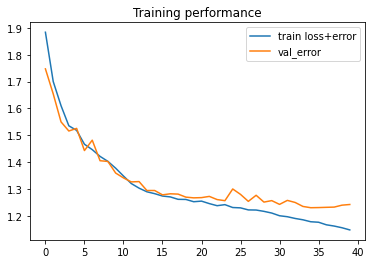

In [19]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

## Confusion matrix

In [20]:
test_Y_predictions = model.predict((iq_test, dft_test), batch_size=BATCH_SIZE)

test_Y_predictions_length = len(test_Y_predictions)
test_Y_onehotted = []

for i in range(0, test_Y_predictions_length - 1):
    # creating a [0...0] vector
    onehotted_prediction = np.zeros(len(classes))
    
    # I have to place a 1 where the probability value is maximum
    onehot_one_index = np.argmax(test_Y_predictions[i])
    onehotted_prediction[onehot_one_index] = 1
    
    test_Y_onehotted.append(onehotted_prediction)

In [21]:
# 11x11 zeros matrix
confusion_matrix = np.zeros((len(classes), len(classes)))

# row = true label, column = predicted label

for i in range(0, test_Y_predictions_length - 1):
    true_label_index = np.argmax(Y_test[i])
    predicted_label_index = np.argmax(test_Y_onehotted[i])
    
    confusion_matrix[true_label_index][predicted_label_index] += 1

softmaxed_confusion_matrix = np.zeros((len(classes), len(classes)))
    
# softmax each confusion matrix row
for i in range(0, len(classes)):
    vector_sum = np.sum(confusion_matrix[i])
    
    for j in range(0, len(confusion_matrix[i]) - 1):
        softmaxed_confusion_matrix[i][j] += round(confusion_matrix[i][j]/vector_sum, 2)
    
softmaxed_confusion_matrix

array([[0.38, 0.01, 0.3 , 0.01, 0.06, 0.01, 0.  , 0.02, 0.02, 0.17, 0.  ],
       [0.  , 0.62, 0.21, 0.  , 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.02, 0.91, 0.  , 0.02, 0.02, 0.  , 0.  , 0.  , 0.01, 0.  ],
       [0.01, 0.01, 0.3 , 0.55, 0.04, 0.01, 0.03, 0.01, 0.01, 0.03, 0.  ],
       [0.01, 0.01, 0.29, 0.01, 0.62, 0.03, 0.  , 0.  , 0.01, 0.01, 0.  ],
       [0.  , 0.01, 0.26, 0.  , 0.02, 0.66, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.01, 0.01, 0.21, 0.05, 0.03, 0.01, 0.64, 0.01, 0.01, 0.01, 0.  ],
       [0.06, 0.  , 0.18, 0.02, 0.05, 0.01, 0.01, 0.29, 0.33, 0.04, 0.  ],
       [0.04, 0.  , 0.11, 0.02, 0.04, 0.01, 0.01, 0.27, 0.45, 0.04, 0.  ],
       [0.22, 0.01, 0.29, 0.02, 0.07, 0.02, 0.  , 0.02, 0.02, 0.33, 0.  ],
       [0.  , 0.38, 0.22, 0.  , 0.01, 0.03, 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [22]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

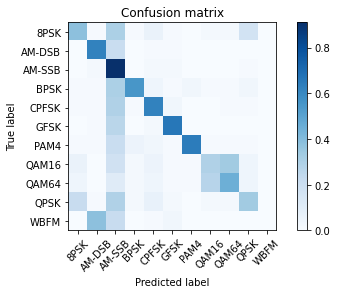

In [23]:
plot_confusion_matrix(softmaxed_confusion_matrix, labels=classes)

## Confusion matrix for each SNR

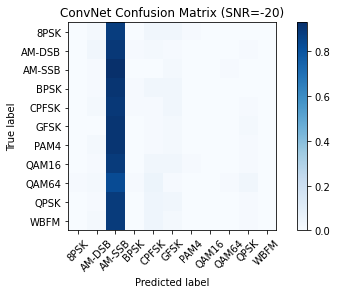

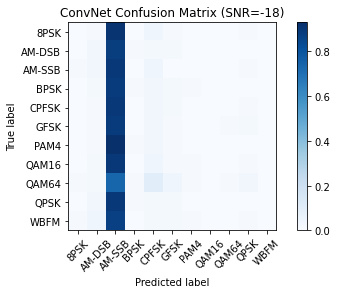

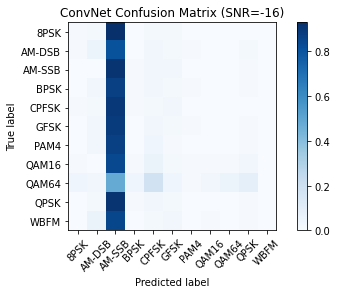

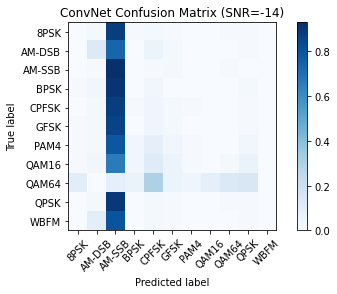

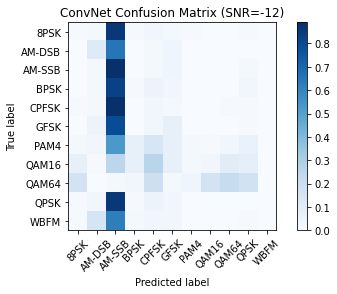

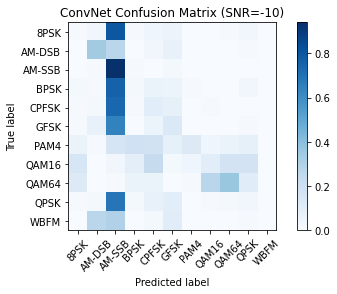

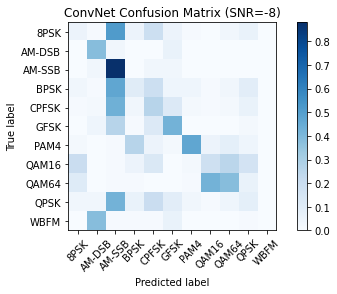

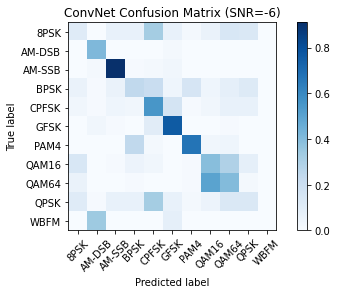

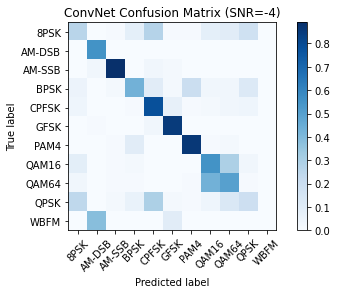

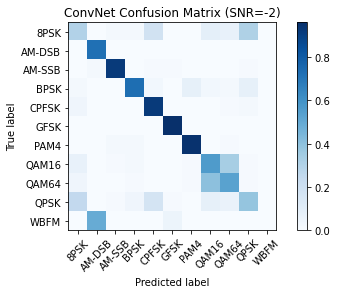

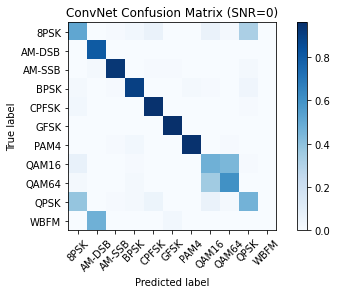

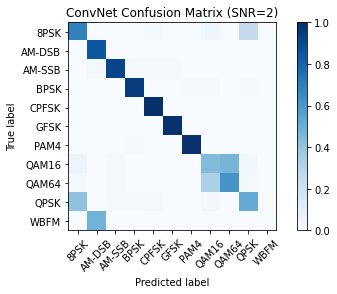

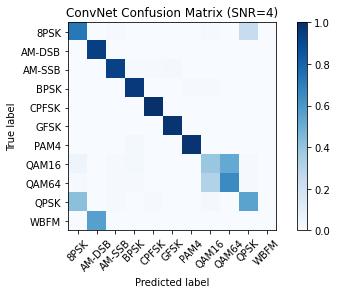

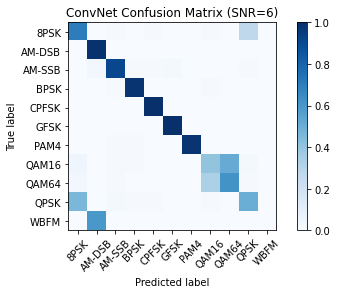

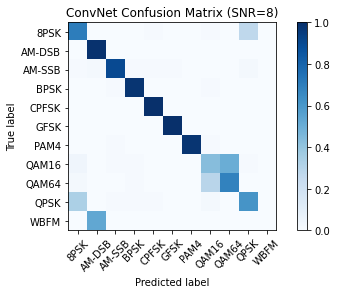

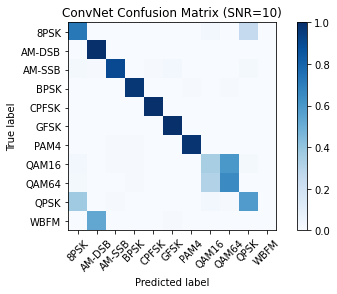

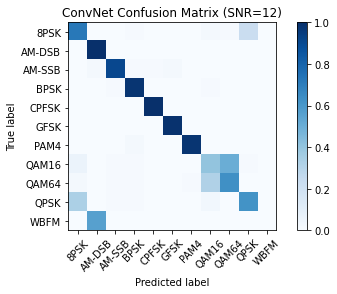

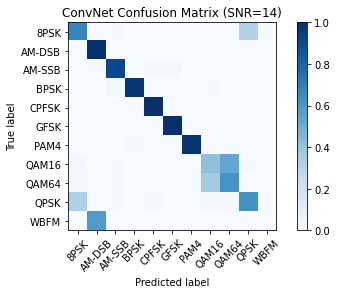

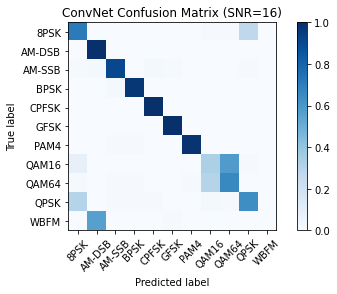

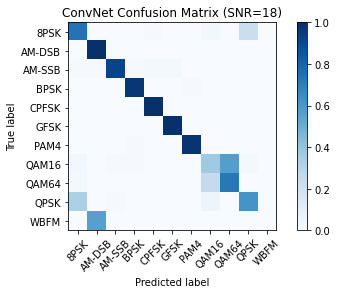

In [24]:
import math

# Plot confusion matrix
acc = {}

for snr in snrs:
    
    # extract classes @ SNR
    test_SNRs = list(dataset_df[snr_column_dataframe_name][test_index])
    this_snr_indexes = np.where(np.array(test_SNRs) == snr)
        
    test_X_i = (iq_test[this_snr_indexes], dft_test[this_snr_indexes])
    test_Y_i = Y_test[this_snr_indexes]
        
    # estimate classes
    test_Y_predictions = model.predict(test_X_i, batch_size=BATCH_SIZE)
    
    test_Y_predictions_length = len(test_Y_predictions)
    test_Y_onehotted = []
    
    for i in range(0, test_Y_predictions_length - 1):
        # creating a [0...0] vector
        onehotted_prediction = np.zeros(len(classes))

        # I have to place a 1 where the probability value is maximum
        onehot_one_index = np.argmax(test_Y_predictions[i])
        onehotted_prediction[onehot_one_index] = 1

        test_Y_onehotted.append(onehotted_prediction)
        
    # 11x11 zeros matrix
    confusion_matrix = np.zeros((len(classes), len(classes)))

    # row = true label, column = predicted label

    
    for i in range(0, test_Y_predictions_length - 1):
        true_label_index = np.argmax(test_Y_i[i])
        predicted_label_index = np.argmax(test_Y_onehotted[i])

        confusion_matrix[true_label_index][predicted_label_index] += 1
    
    softmaxed_confusion_matrix = np.zeros((len(classes), len(classes)))
    
    # softmax each confusion matrix row
    for i in range(0, len(classes)):
        vector_sum = np.sum(confusion_matrix[i])

        for j in range(0, len(confusion_matrix[i]) - 1):
            perc = confusion_matrix[i][j] / vector_sum
            softmaxed_confusion_matrix[i][j] += round(perc, 2)
    
    plt.figure()
    plot_confusion_matrix(softmaxed_confusion_matrix, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    well_predicted = np.sum(np.diag(confusion_matrix))
    all_predictions = np.sum(confusion_matrix)
    
    acc[snr] = well_predicted / all_predictions

## Accuracy performance

In [25]:
accuracy_perc = {}
for el in acc.items():
    accuracy_perc[el[0]] = int(el[1] * 100)
    
accuracy_df = pd.DataFrame(data=accuracy_perc, index=["Accuracy %"])
# accuracy_df.columns = ["SNRs", "Accuracy"]
accuracy_df

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,9,8,10,12,13,21,33,46,57,67,73,77,77,76,79,77,78,77,78,78


In [26]:
# Save results to a pickle file for plotting later
fd = open(OUTPUT_FILENAME,'wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

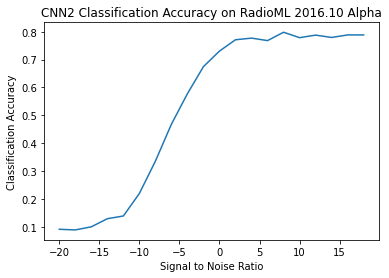

In [27]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")